## Camera Selection

In [1]:
import scipy.io as spio
#from __future__ import print_function

import numpy as np
import os

from IPython.display import clear_output
from IPython import display

import matplotlib.pyplot as plt
#import cv2 as cv
%matplotlib inline

In [2]:
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.distributions import Categorical
import time, math
 
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()

if use_cuda:
    print ('CUDA is available')
#use_cuda=False   #uncomment this if you dont want to use cuda variables

CUDA is available


In [3]:
import sys
import os
import gc
import collections
# import hickle as hkl
# import ttictoc as tt

sys.path.insert(0, '../data/')
import get_pid_train_test as db
import auxiliary as af

In [4]:
# sys.path.insert(0,'../py-MDNet/modules')
# from sample_generator import *
import pandas as pd

### For Validation

In [5]:
# Test function
def plot_current_state(ped, c,fno):
    # load image for current location
    img,bb = load_image(ped,c,fno,db_no)

    dpi = 80.0
    #figsize = (img.size[0]/dpi, img.size[1]/dpi)
    figsize = (img.shape[0]/dpi, img.shape[1]/dpi)
    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    # get image and rect handle
    imAX = ax.imshow(img, aspect='normal')
    rect = plt.Rectangle(tuple(bb[0,:2]),bb[0,2],bb[0,3], 
        linewidth=3, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)

    plt.pause(.01)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'0000.jpg'),dpi=dpi)
    
    return imAX, rect
    
def plot_second(ped,c,curr_frame, imAX,rect):
    img,bb =  load_image(ped,c,curr_frame,db_no)
    #if np.array(img).shape[0] > 0:
    if img != []:
        imAX.set_data(img)
    #print (bb)

    #if bb.shape[0] > 0:
    if bb != []:
        rect.set_xy(bb[0,:2])
        rect.set_width(bb[0,2])
        rect.set_height(bb[0,3])
        print ('Correct camera')
    elif c!= num_camera-1:
        print ('Wrong camera')

    
    display.display(plt.gcf())
    plt.pause(1)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'%04d.jpg'%(i)),dpi=dpi)

def get_reward_gt(ped, curr_frame, c):
    y = afc.find_target_camera(ped,curr_frame)
    # get reward (give reward at end of episode)
    if y == num_camera-1 and y == c:
        reward = 0
    elif y == c:
        reward = 1
    else:
        reward = -1
        
    return reward,y

def get_next_step(ped,c,curr_frame, state):
    # update current state and history
    ispresent,this_state = get_state_vector(ped, c,curr_frame)
    if ispresent:
        next_state = this_state
    else:
        # use previous state
        next_state = state
    
    # get correct label from ground truth
    reward,y = get_reward_gt(ped, curr_frame,c)

    return next_state,reward,y,ispresent

def test_func(pTest, iloc='first', eloc='last', fixLoc=-1, isdebug=0, req_inc=1):
    policy_net.eval()
    rsT,accT = [],[]
    Qvalues = []
    numTrAllP = []
    
    for p in range(pTest.shape[0]): 
        reward_sum = 0
        accP = []
        inc = 1
        aaa = 1
        Qval_1p = []
        numTr = 0
        
        # load p'th person data
        ped = np.copy(pTest[p])
        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        
        # Initialize with current state with start frame
        if iloc == 'first':
            startIDX = 0
        elif iloc == 'rand':
            startIDX = np.random.randint( 0,ped.shape[0]-20 )
        elif iloc == 'fix':
            startIDX = fixLoc
        if startIDX > ped.shape[0]:
            continue
        myPos = ped[startIDX,0:]
        print ('Initial position: ',myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,duke_cam))
        occ_len = 0.01
        # Make initial state
        x_t,c_t,te_tau,r_t = make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        prev_rt = r_t[0:4]
        #print (state.size())
        num_steps = 0
        prev_camera = curr_camera
        count_curr_c = 0
        
        if render: # show current location
            plot_current_state(ped, curr_camera,curr_frame)

            display.clear_output(wait=True)
            display.display(plt.gcf())

        # select an action from the current state
        hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
        #print (x_t.size(),h_t.size(),enc_history.size())
        state_xt = torch.cat([x_t, te_tau], dim=1)
        state = torch.cat([state_xt, hidden[1,].detach()], dim=1)
        
        
        while(curr_frame <= ped[-1,1]): # alltime-6):
            
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
                
            # Only exploitation for testing
            camera_index = torch.argmax(value_c)
            c = camera_index.detach().cpu().numpy()
            
            occ_max_val = 12000000
            aaa += 1
            if aaa > 1 and occ_len > occ_max_val:
                c = c #np.array(num_camera-1)
            if occ_len > occ_max_val and aaa%50 == 0:
                aaa = 1
                c = np.array(np.random.randint(num_camera))

            # find target for the next frame
            curr_frame += fpsc
            num_steps += 1
            
            # get correct label from ground truth
            reward,y = get_reward_gt(ped, curr_frame,c)
            #if req_inc:
            if inc==1 and y!=num_camera-1:
                # inside a camera
                if req_inc:
                    accP.append((y,y))
                    c = y
                else:
                    accP.append((y,c.item(0)))
            elif inc==0 and y==c.item(0) and y!=num_camera-1:
                # transitioning to second camera
                accP.append((y,c.item(0)))
                inc = 1
                numTr += 1
            elif inc==1 and y==num_camera-1:
                # moving out of a camera FOV
                inc = 0
                accP.append((y,c.item(0)))
            else:
                # Making transition
                accP.append((y,c.item(0)))
                #print ('Another case',y,c.item(0))
                    
            #else:
            #    accP.append((y,c.item(0)))
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0: # and np.random.rand < 0.95:
                bbox = bbox[0]
                rt = np.zeros((8))
                rt[0] = bbox[0]/1920 -(np.random.rand()-0.5)/100
                rt[1] = bbox[1]/1080 -(np.random.rand()-0.5)/100
                rt[2] = bbox[2]/1920 -(np.random.rand()-0.5)/100
                rt[3] = bbox[3]/1080 -(np.random.rand()-0.5)/100
                rt[4] = rt[0] - prev_rt[0] if occ_len < 0.2 else 0
                rt[5] = rt[1] - prev_rt[1] if occ_len < 0.2 else 0
                rt[6] = rt[2] - prev_rt[2] if occ_len < 0.2 else 0
                rt[7] = rt[3] - prev_rt[3] if occ_len < 0.2 else 0
                curr_camera = c
                
                # make next_state vector
                this_cam = afc.make_one_hot_camera(curr_camera)
                x_t = np.concatenate((this_cam, rt.ravel()))
                x_t[x_t==0] = -10
                x_t[x_t==1] = 10
                x_t = x_t.reshape(1,-1)
                if use_cuda:
                    x_t = torch.from_numpy(x_t).float().cuda()
                
                
                ispresent = 1
                prev_rt = rt[0:4]
                    
            else:
                ispresent = 0
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.01
            else:
                occ_len += 1
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = np.array(10*np.log(occ_len))
            
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:num_camera] = afc.make_one_hot_camera(c)
            ch[0,num_camera:] = 0
            this_cam = afc.make_one_hot_camera(c)
            c_t = this_cam.reshape(1,-1)
            
            if use_cuda:
                c_t = torch.from_numpy(c_t).float().cuda()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float().cuda()
            else:
                c_t = torch.from_numpy(c_t).float()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float()
                
            if isdebug:
                print ( np.where(rt.ravel()))
                print ( np.where(ch))
                print (c, curr_frame)
                print ('isPresent', ispresent)
                
            # make next_state vector
            hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
            #print (x_t.size(),h_t.size(),enc_history.size())
            next_state_xt = torch.cat([x_t, te_tau], dim=1)
            next_state = torch.cat([next_state_xt, hidden[1,].detach()], dim=1)
            
            # store current reward
            reward_sum += reward
            Qval_1p.append((list(value_c.detach().cpu().numpy()[0]),hcount.ravel()[0],reward,False,y,c,state.detach().cpu().numpy()))
                        
            #state = next_state
            #state_xt = next_state_xt
            state = next_state #torch.cat([state_xt, enc_history], dim=1)
            prev_camera = c
            
            if render:
                plot_second()
            if eloc != 'last':
                if num_steps > eloc:
                    break
            
        # stack episodic reward 
        Qvalues.append((np.stack(Qval_1p)))
        rsT.append((reward_sum,num_steps))
        accT.append(accP)
        numTrAllP.append(numTr)
        
    return rsT, accT, Qvalues, numTrAllP


### Initialize hyper-parameters

In [6]:
learning_rate = 1e-4
batch_size = 1500
replay_memory_size = 20000
#epsilon = 0.1
gamma = 0.99

resume = False # resume from previous checkpoint
render = False
eps = np.finfo(np.float32).eps.item()


In [7]:
# load dataset
db_no = 5
[pALL,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='train')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 6
pALL = np.array(pALL)

# load test set for current data set
[pTest,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='test')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pTest = np.array(pTest)

Total number of person in data set:  (1, 1812)
Total number of person in data set:  (1, 1812)


In [8]:
!ls /home/anils/8tb/hpc-storage/dukeMTMC/ground_truth

trainval2.csv  trainval.csv  trainval.mat  trainvalRaw.csv  trainvalRaw.mat


In [9]:
tvmat = spio.loadmat('/home/anils/8tb/hpc-storage/dukeMTMC/ground_truth/trainval.mat')
camGTT = tvmat['trainData'].astype(np.int)
camGT = camGTT[:,[0,2,3,4,5,6]]
camGT[:,0]-=1
camGT[:,1]-=1
# camGT = matlab.double(camGT)
print('Shape of full ground truth', camGT.shape)


# camGTT = pd.read_csv(os.path.expanduser('~/8tb/hpc-storage/nlpr/annotation_files/annotation/Dataset' + str(db_no) + '/fullgt.csv'), header=None).values.astype(np.int)[:,:7]
# tmp = np.copy(camGTT[:,1])
# camGTT[:,1] = camGTT[:,2]
# camGTT[:,2] = tmp
# camGT = camGTT[:,[0,2,3,4,5,6]]

# # In NLPR GT, frames already start with 0, only cam needs to be decremented
# camGT[:,0]-=1
# # camGT[:,1]-=1
# # camGT = matlab.double(camGT)
# print('Shape of full ground truth', camGT.shape)

Shape of full ground truth (4077132, 6)


In [10]:
numEpoch = 100000
d = 10
region_size = (d,d)

h_len = 10

# Load auxiliary functions using an object
afc = af.AuxiliaryFunction(num_camera=num_camera, d=d, h_len=h_len)

## Policy Model

In [11]:
# Initialize required parameters
lstm_size = 256
hidden_size1 = 4096
hidden_size2 = 2048
hidden_size3 = 256

input_size = lstm_size + num_camera+ 4*2 +1

# Required network
class NextCamera(nn.Module):
    def __init__(self):
        super(NextCamera, self).__init__()
        
        # make decoder layers
        self.fch1 = nn.Linear(input_size, hidden_size1)
        self.fch2 = nn.Linear(hidden_size1, hidden_size2)
        self.fch3 = nn.Linear(hidden_size2, hidden_size3)
        self.fco = nn.Linear(hidden_size3, num_camera)
        
        # Activation function 
        self.tanh = nn.Tanh() #ReLU()
        self.relu = nn.ReLU() #ReLU()
        #self.linear = nn.Linear() 
        
    def forward(self, x):
        
        x = self.relu(self.fch1(x))
        x = self.relu(self.fch2(x))
        x = self.relu(self.fch3(x))
        x = self.fco(x)
            
        return x # nn.functional.softmax(x)

In [12]:
# build the model
if use_cuda:
    policy_net = NextCamera().float().cuda()
    criterion = nn.MSELoss().cuda()
    
else:
    policy_net = NextCamera().float()
    criterion = nn.MSELoss()
    
if use_cuda:
    target_net = NextCamera().cuda()
    target_net.float().cuda()
target_net.load_state_dict(policy_net.state_dict())

# use ADAM as optimizer since we can load the whole data to train
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [13]:
def backward_network(replay_memory_pos,pos_prob, replay_memory_neg, replay_memory_cx, update_criteria):

    # sample random minibatch
    minibatch_pos = random.choices(replay_memory_pos, k=min(len(replay_memory_pos), 500), weights=pos_prob)
    #minibatch_pos = random.sample(replay_memory_pos, min(len(replay_memory_pos), 300)) #int(batch_size/3)))
    minibatch_posneg = minibatch_pos + random.sample(replay_memory_neg, min(len(replay_memory_neg), 500)) # int(batch_size/3)))
    minibatch = minibatch_posneg + random.sample(replay_memory_cx, min(len(replay_memory_cx), 500)) #int(batch_size/3)))
    
    # unpack minibatch
    #state_xt = tuple(d[0] for d in minibatch)
    state = torch.cat(tuple(d[0] for d in minibatch))
    #prev_ch = tuple(d[1] for d in minibatch)
    action = torch.cat(tuple(d[1] for d in minibatch))
    reward = torch.cat(tuple(d[2] for d in minibatch))
    #next_state_xt = tuple(d[4] for d in minibatch)
    next_state = torch.cat(tuple(d[3] for d in minibatch))
    #ch = tuple(d[5] for d in minibatch)
    
    # num samples of different categories
    numRew = torch.stack([torch.sum(reward>=0.2),torch.sum(reward==-1),torch.sum(reward==0.01)]).data.cpu().numpy()
    
    # get output for the next state
    next_output = target_net(next_state)

    # set y_j to r_j for terminal state, otherwise to r_j + gamma*max(Q)
    y = torch.cat(tuple(reward[i] if minibatch[i][4] \
                        else reward[i] + gamma * torch.max(next_output[i]) \
                        for i in range(len(minibatch))))

    # extract Q-value
    q_value = torch.sum(policy_net(state) * action, dim=1)

    # PyTorch accumulates gradients by default, so they need to be reset in each pass
    optimizer.zero_grad()

    # returns a new Tensor, detached from the current graph, the result will never require gradient
    y = y.detach()

    #print (y, q_value)
    # calculate loss
    loss = criterion(q_value, y)

    # do backward pass
    loss.backward()
    optimizer.step()

    # copy weights from policy_net to target_net
    if update_criteria == 10:
        target_net.load_state_dict(policy_net.state_dict())
        update_criteria = 0
    update_criteria += 1
    
    return loss.data,numRew,update_criteria

## AE Model

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = src #self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size, dim]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size, dim]
        
        embedded = input #self.dropout(self.embedding(input))
        #embedded[np.arange(embedded.size),a] = 1
        
        #embedded = [1, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.1):
        
        #src = [src len, batch size, dim]
        #trg = [trg len, batch size, dim]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output #.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [15]:
duke_cam = 41
INPUT_DIM = duke_cam
OUTPUT_DIM = duke_cam
ENC_EMB_DIM = duke_cam
DEC_EMB_DIM = duke_cam
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).float().cuda()
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).float().cuda()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(enc, dec, device).float().to(device)
criterion_ae = nn.CrossEntropyLoss()

In [16]:
# load encoder model
#enc.load_state_dict(torch.load('enc-model_manyDB_state64.pt'))
#enc.load_state_dict(torch.load('enc-model_manyDB.pt'))
#enc.eval()
#dec.load_state_dict(torch.load('dec-model_manyDB_state64.pt'))
#dec.eval()
#model.load_state_dict(torch.load('../eccv2020/tut1-model_duke_lstmSize128_manyDB_2.pt'))
model.load_state_dict(torch.load('../eccv2020/tut1-model_AICity_lstmSize256_manyDB.pt'))
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(41, 41)
    (rnn): LSTM(41, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(41, 41)
    (rnn): LSTM(41, 256, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=41, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [17]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Run episodes

In [18]:
reward_sum = 0
running_reward = None
xs,rs,cprs = [],[],[]
episode_number = 0
episode_durations = []
episode_reward = []
validation_reward= []
replay_memory_pos = []
pos_prob = []
replay_memory_neg = []
replay_memory_cx = []
M = np.zeros((num_camera,num_camera))

In [19]:
def make_state_vector(ped, curr_camera,curr_frame, ch,occ_len):
    numSamples = 30
    overlap_thres = [0.9, 1]
        
    # read image
    img,bbox,p = afc.load_image(ped,curr_camera,curr_frame,db_no)
    imw, imh = (1920,1080) #img.size
    hc = np.array(10*np.log(occ_len))
    
    if p:
        rt = np.zeros((8))
        rt[0] = bbox[0]/imw -(np.random.rand()-0.5)/100
        rt[1] = bbox[1]/imh -(np.random.rand()-0.5)/100
        rt[2] = bbox[2]/imw -(np.random.rand()-0.5)/100
        rt[3] = bbox[3]/imh -(np.random.rand()-0.5)/100
        rt[4] = 0
        rt[5] = 0
        rt[6] = 0
        rt[7] = 0
        #print (np.where(rt.ravel()))
        
        # make next_state vector
        #this_cam = afc.make_one_hot_camera(curr_camera)
        #state = np.concatenate((this_cam, rt.ravel()))
        #state = np.concatenate((state, hc.ravel()))
        #state = np.concatenate((state, ch.ravel()))
        #state = state.reshape(1,-1)
        #state[state==0] = -10
        #state[state==1] = 10
        
        # make next_state vector
        this_cam = afc.make_one_hot_camera(curr_camera)
        xt = np.concatenate((this_cam, rt.ravel()))
        xt[xt==0] = -10
        xt[xt==1] = 10
        xt = xt.reshape(1,-1)
        
        # make history vector
        c_t = this_cam.reshape(1,-1)
        
        if use_cuda:
            xt = torch.from_numpy(xt).float().cuda()
            c_t = torch.from_numpy(c_t).float().cuda()
            hc = torch.from_numpy(hc.reshape(1,-1)).float().cuda()
        else:
            xt = torch.from_numpy(xt).float()
            c_t = torch.from_numpy(c_t).float()
            hc = torch.from_numpy(hc.reshape(1,-1)).float()
    else:
        print ('Target is not present in ',c,curr_frame)
        xt,h_t = [],[]
    
    return xt,c_t,hc,rt #p,state,rt

def append_reward(rs,num_steps):
    if len(rs) > 0:
        # stack episodic reward 
        epR = np.vstack(rs)
        rs = []

        # append the episodic reward
        #episode_number += 1
        #episode_durations.append(num_steps)
        reward_stat = [num_steps,np.std(epR),np.sum(epR)]
        episode_reward.append(reward_stat)
    
    return rs

def reinit_ae(ch):
    # Initialize history variable (one-hot encoding)
    if use_cuda:
        ch = torch.from_numpy(ch).float().cuda()
        enc_h = torch.zeros(1,lstm_size).float().cuda()
        enc_c = torch.zeros(1,lstm_size).float().cuda()
    else:
        enc_h = torch.zeros(1,lstm_size).float()
        enc_c = torch.zeros(1,lstm_size).float()
        
    # encode whole camera history
    for i in range(seq_len-1,-1,-1):
        #print (ch[i,:])
        x = ch[i,:].view(1,-1)
        h_lstm,enc = ae_enc((enc_h,enc_c), x)
        (enc_h,enc_c) = h_lstm

    return h_lstm,enc

In [20]:
epoch = 0
occ_max_val = 100

In [21]:
EpData = []
allEpData = []
numRew=[]

numUpdateRew=[]
update_criteria = 0
episode_count = 0
steps_count = 0
initialEpsilon = 0.4
finalEpsilon = 0.01
epsilon = initialEpsilon

In [22]:
trExplored = {}
for i in range(num_camera):
    for j in range(num_camera):
        trExplored[str(i)+'-'+str(j)] = []

In [23]:
resume = False
if resume:
    epoch = 600
    epsilon = 0.170962
    aaa = np.load('./EpData/.npy', allow_pickle=True)
    episode_count = aaa[2]
    steps_count = aaa[3]
    episode_reward_pre = aaa[0]
    validation_reward_pre = aaa[1]
    policy_net.load_state_dict(torch.load('./models/')['state_dict'])

In [24]:
# tt.tic()

In [28]:
def bb_intersection_over_union(boxA, boxB):
    boxA = np.array(boxA)
    boxB = np.array(boxB)
    # convert to x1,y1,x2,y2
    boxA[2] = boxA[2] + boxA[0]
    boxA[3] = boxA[3] + boxA[1]
    boxB[2] = boxB[2] + boxB[0]
    boxB[3] = boxB[3] + boxB[1]
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersec1tion over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

cam_sync_offset = [5543,3607,27244,31182,1,22402,18968,46766]
def find_nearest_box(c,frame_no, prev_box):
    # find all bounding boxes
    #print (c, frame_no)
    all_dets = np.copy(camGT[np.logical_and(camGT[:,0]==c, camGT[:,1]==(frame_no+46766-cam_sync_offset[c])), 2:])
    
    #print (all_dets, prev_box)
    
    # find the nearest box
    maxIOU = -1
    box = np.array([])
    for i in range(len(all_dets)):
        this_box = np.copy(all_dets[i])
        iou = bb_intersection_over_union(this_box, prev_box)
        #print (iou, this_box)
        if iou > maxIOU and iou > 0.4:
            maxIOU = iou
            box = np.copy(all_dets[i])
            
    return box

In [29]:
# def discount_rewards(r):
#     """ take 1D float array of rewards and compute discounted reward """
#     discounted_r = np.zeros_like(r)
#     running_add = 0
#     for t in reversed(range(0, r.size)):
#         if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
#         running_add = running_add * gamma + r[t]
#         discounted_r[t] = running_add
#     return discounted_r

# def discount_rewards(r):
#     """ take 1D float array of rewards and compute discounted reward """
#     discounted_r = [] #np.zeros_like(r)
#     running_add = 0
#     for t in reversed(range(0, len(r))):
#         if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
#         running_add = running_add * gamma + r[t]
#         #discounted_r[t] = running_add
#         discounted_r.append(running_add)
#     return discounted_r

def discount_rewards(r,c):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = [] #np.zeros_like(r)
    running_add = 0
    pivot = c[-1]
    for t in reversed(range(0, len(r))):
        if r[t] != 0: 
            running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
            pivot = c[t]
        if c[t] == pivot:
            running_add = running_add * gamma + r[t]
            #discounted_r[t] = running_add
            discounted_r.append(running_add)
        else:
            running_add = running_add * gamma + 0
            discounted_r.append(0)
            
        
    return discounted_r

In [30]:
maxRewSteps = 5
max_ep_len = 500
seq_len = 20
h_len = seq_len

while epoch < numEpoch:
#for epoch in range(numEpoch):
    # repeat for all pedestrians
    #disp(pALL)
    
    for p in range(pALL.shape[0]): #range(pInLoop.shape[0])
        
        policy_net.train()
        
        # load p'th person data
        ped = np.copy(pALL[p])

        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        #print (np.unique(ped[:,0]))
        
        # check if camera number is correct
        if (ped[:,0] >= num_camera).any():
            print ('Error in person ', p)
            break
            
        if ped.shape[0] < max_ep_len/4:
            continue
        
        # select a camera uniformly
        uniq_cam = np.unique(ped[:,0])
        if len(uniq_cam) < 2 and np.random.rand() > 0.4:
            if len(np.where(ped[1:,1]-ped[0:-1,1] != 1)[0]) == 0:
                continue
        rand_cam = uniq_cam[np.random.randint(len(uniq_cam))]
        index_of_rand_cam = np.nonzero( ped[:,0]==rand_cam )[0]
        len_indices_rand_cam = len(index_of_rand_cam)
        
        # Initialize with current state with start frame
        tranIDX = np.where(ped[1:,0]-ped[0:-1,0])[0]
        if len(uniq_cam) < 2 or np.random.rand() < 0.4:
            startIDX = np.random.randint( 0,int(ped.shape[0]-ped.shape[0]/2) )
        else:
            startIDX = np.random.choice(tranIDX)-20
        #startIDX = np.random.choice(tranIDX)-20 if np.random.rand(1) < 0.6 else np.random.randint( 0,ped.shape[0]-max_ep_len/2 )
        #startIDX = index_of_rand_cam[np.random.randint(len_indices_rand_cam/10)]
        myPos = ped[startIDX,0:]
        #print (myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,duke_cam))
        prev_ch = ch
        
        # initialize total time target was occluded
        num_steps = 0
        occ_len = 0.01
        hcount = np.array(10*np.log(occ_len))
        CDataEp = []
        inCDataEp = []
        EpData = []
        episodic_seq = []
        rewSteps = 1
        
        tmp_replay = []
        tmp_reward = []
        tmp_c_seq = []
        pivot_cam = curr_camera
        prev_box = ped[ np.logical_and(ped[:,0]==curr_camera,ped[:,1]==curr_frame),2:][0]
        
        # create initial state (ct,rt,tau_t)
        #bbox = myPos[2:]
        #rt = afc.find_curr_rt(bbox)
        x_t,c_t,te_tau,r_t = make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        prev_rt = r_t[0:4]
        stCam = curr_camera
        expStC = curr_camera
        count_curr_c = 0
        prev_camera = curr_camera

        if render: # show current location
            plt.imshow(x.reshape(input_size))
            display.clear_output(wait=True)
            display.display(plt.gcf())
        episode_count += 1
        if epsilon > finalEpsilon:
            epsilon -= (initialEpsilon - finalEpsilon)/20000
        
        # select an action from the current state
        hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
        #print (x_t.size(),h_t.size(),enc_history.size())
        state_xt = torch.cat([x_t, te_tau], dim=1)
        #state = torch.cat([state_xt, hidden.detach().flatten().view(1,-1)], dim=1)
        state = torch.cat([state_xt, hidden[1,].detach()], dim=1)
        #print ('State size: ', state.size())
        
        while(curr_frame <= ped[-1,1]):
        
            state_in = Variable(state)
            value_c = policy_net(state_in)

            steps_count += 1
            
            # generate random steps
            if np.random.rand(1) < 0.01:
                rsteps = np.random.randint(fpsc,20,1)
            else:
                rsteps = 1
            curr_frame += rsteps*fpsc if rsteps > 1 else fpsc
            num_steps += 1
                
            # initialize action
            one_hot_action = torch.zeros([num_camera], dtype=torch.float32)
            if use_cuda:  # put on GPU if CUDA is available
                one_hot_action = one_hot_action.cuda()

            # epsilon greedy exploration
            random_action = np.random.random() <= epsilon
            camera_index = [torch.randint(num_camera, torch.Size([]), dtype=torch.int)
                           if random_action else torch.argmax(value_c)][0]
            
            if use_cuda:  # put on GPU if CUDA is available
                camera_index = camera_index.cuda()

            one_hot_action[camera_index] = 1
            one_hot_action = one_hot_action.unsqueeze(0)
            c = camera_index.detach().cpu().numpy().item()
            
            # Store the transition explored
            #M[stCam,c] += 1
            
            # get correct label from ground truth
            y = afc.find_target_camera(ped, curr_frame)
            # get reward (give reward at end of episode)
            
            #print (c, 'GT box: ', ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:])
            # give reward if rewardSteps reached maxRewardSteps
            if rewSteps >= maxRewSteps:
                
                #if np.random.rand() < 0.5:
                #    c = y
                
                if y == num_camera-1 and y == c:
                    reward = 0.01
                    wt = 1
                elif y == c and occ_len< 20:
                    reward = 0.5
                    wt = 1
                elif y == c:
                    reward = 1
                    wt = 10
                else:
                    wt = 1
                    reward = -1
                reward_sum += reward
                rs.append(reward)
                
                rewSteps = 1
                
                pivot_cam = c
                # take bounding box from GT
                # get the current bounding box
                bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
                if len(bbox): bbox = bbox[0]
            else:
                rewSteps += 1
                reward = 0
                
                # take nearest bounding box
                if c != num_camera-1 and c == pivot_cam and occ_len < 20:
                    bbox = np.array(find_nearest_box(c,curr_frame, prev_box))
                else:
                    bbox = np.array([])
                
            #print ('bbox taken: ', bbox)
            # get the current bounding box
            #bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0:
                #rt = afc.find_curr_rt(bbox[0]) 
                #bbox = bbox[0]
                rt = np.zeros((8))
                rt[0] = bbox[0]/1920 -(np.random.rand()-0.5)/100
                rt[1] = bbox[1]/1080 -(np.random.rand()-0.5)/100
                rt[2] = bbox[2]/1920 -(np.random.rand()-0.5)/100
                rt[3] = bbox[3]/1080 -(np.random.rand()-0.5)/100
                rt[4] = rt[0] - prev_rt[0] if occ_len < 0.2 else 0
                rt[5] = rt[1] - prev_rt[1] if occ_len < 0.2 else 0
                rt[6] = rt[2] - prev_rt[2] if occ_len < 0.2 else 0
                rt[7] = rt[3] - prev_rt[3] if occ_len < 0.2 else 0
                
                curr_camera = c
                # make next_state vector
                this_cam = afc.make_one_hot_camera(curr_camera)
                x_t = np.concatenate((this_cam, rt.ravel()))
                x_t[x_t==0] = -10
                x_t[x_t==1] = 10
                x_t = x_t.reshape(1,-1)
                if use_cuda:
                    x_t = torch.from_numpy(x_t).float().cuda()
                
                #num_steps = 0
                ispresent = 1
                stCam = c
                
                prev_rt = rt[0:4]
                prev_box = bbox
            else:
                ispresent = 0
            
            #if ispresent and expStC != num_camera-1 and c != num_camera-1:
            #    trExplored[str(expStC)+'-'+str(c)].append(occ_len)
            #    expStC = c
            
            
            #-----------    reward was here
            #EpData.append((list(value_c.detach().cpu().numpy()[0]),hcount.ravel()[0],reward,random_action,y,c,episode_reward))
            
            #print (np.array([rt, ispresent,c]))
            ######################## prepare the next state  #############################
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.01
            else:
                occ_len += rsteps
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = np.array(10*np.log(occ_len))
            
            # get next camera using policy network
            this_cam = afc.make_one_hot_camera(c)
            c_t = this_cam.reshape(1,-1)
            
            # update current state and history
            prev_ch = ch
            ch[1:,] = ch[0:-1,]
            ch[0,0:num_camera] = afc.make_one_hot_camera(c)
            ch[0,num_camera:] = 0
            
            #chCuda = torch.from_numpy(ch).float().cuda().unsqueeze(1)
            #outSeq = model(chCuda, chCuda)
            #print ('Encoding .. ', chCuda[:,0,].argmax(1))
            #print ('Decoded ..', outSeq[:,0].argmax(1))
            #print ('')
            
            if use_cuda:
                c_t = torch.from_numpy(c_t).float().cuda()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float().cuda()
            else:
                c_t = torch.from_numpy(c_t).float()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float()
            episodic_seq.append((c_t))
            
            # make next_state vector
            hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
            #print (x_t.size(),h_t.size(),enc_history.size())
            next_state_xt = torch.cat([x_t, te_tau], dim=1)
            #next_state = torch.cat([next_state_xt, hidden.detach().flatten().view(1,-1)], dim=1)
            next_state = torch.cat([next_state_xt, hidden[1,].detach()], dim=1)
            
            # save transition to replay memory
            tmp_replay.append((state, one_hot_action, next_state, ispresent))
            tmp_reward.append(reward)
            tmp_c_seq.append(c)
            
            #state_xt = next_state_xt
            state = next_state #torch.cat([state_xt, hidden.detach()], dim=1)
            #state = torch.cat([next_state_xt, enc_history], dim=1)
            prev_camera = c
            
            if num_steps >= max_ep_len and y!=num_camera-1 and y==c and reward != 0:  # break the episode
                #print ('')
                #print (epoch, p, random_action, rsteps)
                #print ('x_t: ', c,rt)
                ##print ( np.where(ch)[1])
                #print ('Q values: ', value_c)
                #print (y,c, curr_frame,ped[-1,1], num_steps, hcount)
                #print ('isPresent', ispresent)
                #print ('Pos Replay length: ', len(replay_memory_pos))
                
                
                #print (pos_prob[:])
                break
        
        #########################################################
        # compute reward backward
        #epr = np.vstack(tmp_reward)
        discounted_epr = discount_rewards(tmp_reward, tmp_c_seq)[-1::-1]
        #print (tmp_reward, discounted_epr)

        # save transition to replay memory
        for rLen in range(len(tmp_replay)):
            #state, one_hot_action, next_state, ispresent = tmp_replay[rLen]
            state = tmp_replay[rLen][0]
            one_hot_action = tmp_replay[rLen][1]
            next_state = tmp_replay[rLen][2]
            ispresent = tmp_replay[rLen][3]

            if use_cuda:
                reward = torch.from_numpy(np.array([discounted_epr[rLen]], dtype=np.float32)).unsqueeze(0).cuda()
            else:
                reward = torch.from_numpy(np.array([discounted_epr[rLen]], dtype=np.float32)).unsqueeze(0)

            if reward > 0.1:
                replay_memory_pos.append((state, one_hot_action, reward, next_state, ispresent))
                if reward > 0.5:
                    wt = 10
                else:
                    wt = 1
                pos_prob.append(wt)
            elif reward <= 0.01 and reward > 0:
                replay_memory_cx.append((state, one_hot_action, reward, next_state, ispresent))
            elif reward != 0:
                replay_memory_neg.append((state, one_hot_action, reward, next_state, ispresent))

            # if replay memory is full, remove the oldest transition
            if len(replay_memory_pos) > replay_memory_size:
                replay_memory_pos.pop(0)
                pos_prob.pop(0)
            if len(replay_memory_neg) > replay_memory_size:
                replay_memory_neg.pop(0)
            if len(replay_memory_cx) > replay_memory_size:
                replay_memory_cx.pop(0)
        #########################################################

        # update value_function
        loss,rrr,update_criteria = backward_network(replay_memory_pos, pos_prob[:], replay_memory_neg,replay_memory_cx, update_criteria)
        #numUpdateRew.append(rrr)
        #if np.random.rand() < 0.05:
        #    allEpData.append((np.stack(EpData)))
        
        # store episodic reward
        #numRew.append((sum(np.stack(rs)==100),sum(np.stack(rs)==-100),sum(np.stack(rs)==0.1)))
        rs = append_reward(rs,num_steps)
        
        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print ('ep %d: ep_len:%d episode reward: total was %f. running mean: %f' % (epoch, num_steps, reward_sum, running_reward))
        reward_sum = 0
        num_steps = 0
        rs = []
    
#     if epoch % 20 == 0: # test on validation set
#         _,accV,qv,numTR = test_func(pTest[1:2],iloc='first',eloc='last')
#         av = np.stack(accV[0])
#         av = sum(av[av[:,0]!=(num_camera-1),0] == av[av[:,0]!=(num_camera-1),1])/sum(av[:,0]!=(num_camera-1))
#         validation_reward.append((qv,av,numTR)) 
    #print (M)
    epoch += 1
    print ('epsilon:%f episode_count: %d. steps_count: %f' % (epsilon, episode_count,steps_count))
    if epoch % 5 == 1: 
        torch.save({'state_dict': policy_net.state_dict()}, './models/policy_duke_semisup_gtBOX_5_'+str(epoch))
    #if epoch %200 == 100:
        #np.save('./EpData/allEpData_ECCV_db3_pretrAE64_seq20_rp20K_'+str(epoch),np.array(allEpData),allow_pickle=True)
        #np.save('./EpData/episode_reward_ECCV_db3_pretrAE64_seq20_rp20K_'+str(epoch), (episode_reward,validation_reward,epsilon,episode_count, steps_count,running_reward))
    #allEpData = []
    #print ('Time elapsed: ', tt.toc())

ep 0: ep_len:500 episode reward: total was -99.500000. running mean: -100.835226
ep 0: ep_len:820 episode reward: total was -152.910000. running mean: -101.355974
ep 0: ep_len:655 episode reward: total was -120.470000. running mean: -101.547114
ep 0: ep_len:510 episode reward: total was -61.490000. running mean: -101.146543
ep 0: ep_len:500 episode reward: total was -80.950000. running mean: -100.944577
ep 0: ep_len:560 episode reward: total was -102.950000. running mean: -100.964632
ep 0: ep_len:875 episode reward: total was -162.920000. running mean: -101.584185
ep 0: ep_len:520 episode reward: total was -69.990000. running mean: -101.268243
ep 0: ep_len:890 episode reward: total was -169.940000. running mean: -101.954961
ep 0: ep_len:1235 episode reward: total was -208.800000. running mean: -103.023411
ep 0: ep_len:530 episode reward: total was -50.520000. running mean: -102.498377
ep 0: ep_len:550 episode reward: total was -72.180000. running mean: -102.195193
ep 0: ep_len:685 epis

ep 0: ep_len:965 episode reward: total was -165.940000. running mean: -102.025037
ep 0: ep_len:500 episode reward: total was -34.460000. running mean: -101.349387
ep 0: ep_len:835 episode reward: total was -106.460000. running mean: -101.400493
ep 0: ep_len:740 episode reward: total was -135.930000. running mean: -101.745788
ep 0: ep_len:610 episode reward: total was -98.820000. running mean: -101.716530
ep 0: ep_len:650 episode reward: total was -117.930000. running mean: -101.878665
ep 0: ep_len:194 episode reward: total was -1.500000. running mean: -100.874878
ep 0: ep_len:605 episode reward: total was -114.990000. running mean: -101.016029
ep 0: ep_len:1055 episode reward: total was -140.430000. running mean: -101.410169
ep 0: ep_len:665 episode reward: total was -66.350000. running mean: -101.059567
ep 0: ep_len:645 episode reward: total was -92.900000. running mean: -100.977972
ep 0: ep_len:500 episode reward: total was -80.400000. running mean: -100.772192
ep 0: ep_len:1100 epis

ep 0: ep_len:535 episode reward: total was -64.980000. running mean: -79.658086
ep 0: ep_len:560 episode reward: total was -104.950000. running mean: -79.911006
ep 0: ep_len:605 episode reward: total was -106.470000. running mean: -80.176596
ep 0: ep_len:650 episode reward: total was -118.940000. running mean: -80.564230
ep 0: ep_len:500 episode reward: total was -51.470000. running mean: -80.273287
ep 0: ep_len:1020 episode reward: total was -127.410000. running mean: -80.744654
ep 0: ep_len:500 episode reward: total was -31.970000. running mean: -80.256908
ep 0: ep_len:505 episode reward: total was -27.210000. running mean: -79.726439
ep 0: ep_len:875 episode reward: total was -77.930000. running mean: -79.708474
ep 0: ep_len:565 episode reward: total was -90.370000. running mean: -79.815090
ep 0: ep_len:500 episode reward: total was -47.960000. running mean: -79.496539
ep 0: ep_len:375 episode reward: total was -6.500000. running mean: -78.766573
ep 0: ep_len:505 episode reward: tot

ep 0: ep_len:520 episode reward: total was -37.230000. running mean: -73.539647
ep 0: ep_len:520 episode reward: total was -42.440000. running mean: -73.228650
ep 0: ep_len:125 episode reward: total was -7.500000. running mean: -72.571364
ep 0: ep_len:133 episode reward: total was 1.500000. running mean: -71.830650
ep 0: ep_len:296 episode reward: total was -8.500000. running mean: -71.197343
ep 0: ep_len:205 episode reward: total was -1.500000. running mean: -70.500370
ep 0: ep_len:320 episode reward: total was -8.000000. running mean: -69.875366
ep 0: ep_len:860 episode reward: total was -102.990000. running mean: -70.206513
ep 0: ep_len:500 episode reward: total was -41.710000. running mean: -69.921548
ep 0: ep_len:258 episode reward: total was -6.000000. running mean: -69.282332
ep 0: ep_len:500 episode reward: total was -30.770000. running mean: -68.897209
ep 0: ep_len:1070 episode reward: total was -101.940000. running mean: -69.227637
ep 0: ep_len:500 episode reward: total was -

ep 0: ep_len:910 episode reward: total was -106.560000. running mean: -68.585942
ep 0: ep_len:170 episode reward: total was 2.000000. running mean: -67.880083
ep 0: ep_len:765 episode reward: total was -62.150000. running mean: -67.822782
ep 0: ep_len:895 episode reward: total was -50.250000. running mean: -67.647054
ep 0: ep_len:1025 episode reward: total was -70.530000. running mean: -67.675884
ep 0: ep_len:254 episode reward: total was -4.500000. running mean: -67.044125
ep 0: ep_len:570 episode reward: total was -85.920000. running mean: -67.232884
ep 0: ep_len:510 episode reward: total was -46.990000. running mean: -67.030455
ep 0: ep_len:815 episode reward: total was -70.130000. running mean: -67.061450
ep 0: ep_len:535 episode reward: total was -76.720000. running mean: -67.158036
ep 0: ep_len:1020 episode reward: total was -151.500000. running mean: -68.001456
ep 0: ep_len:1550 episode reward: total was -194.080000. running mean: -69.262241
ep 0: ep_len:418 episode reward: tota

ep 0: ep_len:685 episode reward: total was -50.360000. running mean: -154.452787
ep 0: ep_len:693 episode reward: total was -92.550000. running mean: -153.833759
ep 0: ep_len:635 episode reward: total was -50.780000. running mean: -152.803222
ep 0: ep_len:670 episode reward: total was -71.490000. running mean: -151.990090
ep 0: ep_len:645 episode reward: total was -90.990000. running mean: -151.380089
ep 0: ep_len:1130 episode reward: total was -148.170000. running mean: -151.347988
ep 0: ep_len:1915 episode reward: total was -353.920000. running mean: -153.373708
ep 0: ep_len:735 episode reward: total was -82.190000. running mean: -152.661871
ep 0: ep_len:515 episode reward: total was -33.400000. running mean: -151.469252
ep 0: ep_len:505 episode reward: total was -49.890000. running mean: -150.453460
ep 0: ep_len:500 episode reward: total was -37.950000. running mean: -149.328425
ep 0: ep_len:500 episode reward: total was -31.110000. running mean: -148.146241
ep 0: ep_len:1942 episod

ep 0: ep_len:184 episode reward: total was 3.500000. running mean: -89.804184
ep 0: ep_len:515 episode reward: total was -29.440000. running mean: -89.200542
ep 0: ep_len:610 episode reward: total was -47.220000. running mean: -88.780737
ep 0: ep_len:855 episode reward: total was -70.540000. running mean: -88.598329
ep 0: ep_len:780 episode reward: total was -30.970000. running mean: -88.022046
ep 0: ep_len:805 episode reward: total was -36.210000. running mean: -87.503925
ep 0: ep_len:525 episode reward: total was -30.960000. running mean: -86.938486
ep 0: ep_len:510 episode reward: total was -32.850000. running mean: -86.397601
ep 0: ep_len:500 episode reward: total was -14.300000. running mean: -85.676625
ep 0: ep_len:850 episode reward: total was -68.480000. running mean: -85.504659
ep 0: ep_len:505 episode reward: total was -27.670000. running mean: -84.926312
ep 0: ep_len:880 episode reward: total was -70.550000. running mean: -84.782549
ep 0: ep_len:500 episode reward: total was

ep 0: ep_len:500 episode reward: total was -74.370000. running mean: -75.591126
ep 0: ep_len:1045 episode reward: total was -171.740000. running mean: -76.552615
ep 0: ep_len:615 episode reward: total was -51.830000. running mean: -76.305389
ep 0: ep_len:945 episode reward: total was -110.280000. running mean: -76.645135
ep 0: ep_len:505 episode reward: total was -11.930000. running mean: -75.997984
ep 0: ep_len:1260 episode reward: total was -74.040000. running mean: -75.978404
ep 0: ep_len:645 episode reward: total was -51.280000. running mean: -75.731420
ep 0: ep_len:500 episode reward: total was -40.900000. running mean: -75.383106
ep 0: ep_len:540 episode reward: total was -47.940000. running mean: -75.108675
ep 0: ep_len:655 episode reward: total was -40.250000. running mean: -74.760088
ep 0: ep_len:970 episode reward: total was -103.670000. running mean: -75.049187
ep 0: ep_len:570 episode reward: total was -47.390000. running mean: -74.772595
ep 0: ep_len:535 episode reward: to

ep 1: ep_len:14715 episode reward: total was -2700.940000. running mean: -94.304020
ep 1: ep_len:720 episode reward: total was -92.020000. running mean: -94.281179
ep 1: ep_len:665 episode reward: total was -43.860000. running mean: -93.776968
ep 1: ep_len:665 episode reward: total was -20.290000. running mean: -93.042098
ep 1: ep_len:500 episode reward: total was -12.370000. running mean: -92.235377
ep 1: ep_len:810 episode reward: total was -76.570000. running mean: -92.078723
ep 1: ep_len:560 episode reward: total was -51.130000. running mean: -91.669236
ep 1: ep_len:500 episode reward: total was -22.930000. running mean: -90.981844
ep 1: ep_len:700 episode reward: total was -96.100000. running mean: -91.033025
ep 1: ep_len:570 episode reward: total was -66.060000. running mean: -90.783295
ep 1: ep_len:500 episode reward: total was -14.910000. running mean: -90.024562
ep 1: ep_len:660 episode reward: total was -35.200000. running mean: -89.476316
ep 1: ep_len:570 episode reward: tot

ep 1: ep_len:505 episode reward: total was -45.310000. running mean: -136.398790
ep 1: ep_len:500 episode reward: total was -47.500000. running mean: -135.509803
ep 1: ep_len:500 episode reward: total was -53.070000. running mean: -134.685405
ep 1: ep_len:2460 episode reward: total was -280.440000. running mean: -136.142951
ep 1: ep_len:500 episode reward: total was -25.870000. running mean: -135.040221
ep 1: ep_len:875 episode reward: total was -78.550000. running mean: -134.475319
ep 1: ep_len:1510 episode reward: total was -123.250000. running mean: -134.363066
ep 1: ep_len:665 episode reward: total was -46.490000. running mean: -133.484335
ep 1: ep_len:500 episode reward: total was -46.030000. running mean: -132.609792
ep 1: ep_len:219 episode reward: total was -18.000000. running mean: -131.463694
ep 1: ep_len:500 episode reward: total was -5.500000. running mean: -130.204057
ep 1: ep_len:500 episode reward: total was -43.170000. running mean: -129.333716
ep 1: ep_len:755 episode 

ep 1: ep_len:1655 episode reward: total was -127.150000. running mean: -94.332356
ep 1: ep_len:560 episode reward: total was -53.470000. running mean: -93.923732
ep 1: ep_len:720 episode reward: total was -78.400000. running mean: -93.768495
ep 1: ep_len:835 episode reward: total was -68.070000. running mean: -93.511510
ep 1: ep_len:530 episode reward: total was -64.270000. running mean: -93.219095
ep 1: ep_len:715 episode reward: total was -40.930000. running mean: -92.696204
ep 1: ep_len:510 episode reward: total was -93.970000. running mean: -92.708942
ep 1: ep_len:500 episode reward: total was -30.260000. running mean: -92.084453
ep 1: ep_len:142 episode reward: total was -6.500000. running mean: -91.228608
ep 1: ep_len:143 episode reward: total was 0.500000. running mean: -90.311322
ep 1: ep_len:500 episode reward: total was -19.320000. running mean: -89.601409
ep 1: ep_len:500 episode reward: total was -34.210000. running mean: -89.047495
ep 1: ep_len:815 episode reward: total wa

ep 1: ep_len:238 episode reward: total was 0.000000. running mean: -72.220125
ep 1: ep_len:322 episode reward: total was -24.860000. running mean: -71.746523
ep 1: ep_len:1070 episode reward: total was -149.380000. running mean: -72.522858
ep 1: ep_len:885 episode reward: total was -110.360000. running mean: -72.901230
ep 1: ep_len:650 episode reward: total was -79.080000. running mean: -72.963017
ep 1: ep_len:505 episode reward: total was -34.290000. running mean: -72.576287
ep 1: ep_len:890 episode reward: total was -64.190000. running mean: -72.492424
ep 1: ep_len:505 episode reward: total was -51.920000. running mean: -72.286700
ep 1: ep_len:700 episode reward: total was -65.800000. running mean: -72.221833
ep 1: ep_len:685 episode reward: total was -99.790000. running mean: -72.497515
ep 1: ep_len:505 episode reward: total was -37.900000. running mean: -72.151539
ep 1: ep_len:590 episode reward: total was -43.290000. running mean: -71.862924
ep 1: ep_len:500 episode reward: total 

ep 1: ep_len:910 episode reward: total was -101.220000. running mean: -79.557811
ep 1: ep_len:525 episode reward: total was -55.530000. running mean: -79.317533
ep 1: ep_len:850 episode reward: total was -108.930000. running mean: -79.613658
ep 1: ep_len:995 episode reward: total was -86.980000. running mean: -79.687321
ep 1: ep_len:505 episode reward: total was -32.710000. running mean: -79.217548
ep 1: ep_len:505 episode reward: total was -29.320000. running mean: -78.718573
ep 1: ep_len:705 episode reward: total was -47.120000. running mean: -78.402587
ep 1: ep_len:500 episode reward: total was -48.290000. running mean: -78.101461
ep 1: ep_len:580 episode reward: total was -17.210000. running mean: -77.492546
ep 1: ep_len:795 episode reward: total was -71.550000. running mean: -77.433121
ep 1: ep_len:505 episode reward: total was -57.870000. running mean: -77.237490
ep 1: ep_len:620 episode reward: total was -67.820000. running mean: -77.143315
ep 1: ep_len:930 episode reward: total

ep 1: ep_len:340 episode reward: total was -9.000000. running mean: -64.919023
ep 1: ep_len:412 episode reward: total was -33.500000. running mean: -64.604833
ep 1: ep_len:785 episode reward: total was -88.590000. running mean: -64.844684
ep 1: ep_len:630 episode reward: total was -63.920000. running mean: -64.835438
ep 1: ep_len:905 episode reward: total was -92.480000. running mean: -65.111883
ep 1: ep_len:545 episode reward: total was -55.000000. running mean: -65.010764
ep 1: ep_len:230 episode reward: total was 3.500000. running mean: -64.325657
ep 1: ep_len:500 episode reward: total was -41.790000. running mean: -64.100300
ep 1: ep_len:195 episode reward: total was -21.490000. running mean: -63.674197
ep 1: ep_len:695 episode reward: total was -100.150000. running mean: -64.038955
ep 1: ep_len:510 episode reward: total was -29.420000. running mean: -63.692766
ep 1: ep_len:159 episode reward: total was -6.500000. running mean: -63.120838
ep 1: ep_len:500 episode reward: total was 

ep 1: ep_len:825 episode reward: total was -65.250000. running mean: -57.082157
ep 1: ep_len:670 episode reward: total was -60.290000. running mean: -57.114235
ep 1: ep_len:575 episode reward: total was -62.670000. running mean: -57.169793
ep 1: ep_len:500 episode reward: total was -55.390000. running mean: -57.151995
ep 1: ep_len:950 episode reward: total was -97.620000. running mean: -57.556675
ep 1: ep_len:500 episode reward: total was -32.730000. running mean: -57.308408
ep 1: ep_len:500 episode reward: total was -34.890000. running mean: -57.084224
ep 1: ep_len:535 episode reward: total was -76.780000. running mean: -57.281182
ep 1: ep_len:635 episode reward: total was -71.310000. running mean: -57.421470
ep 1: ep_len:535 episode reward: total was -87.340000. running mean: -57.720655
ep 1: ep_len:210 episode reward: total was -16.430000. running mean: -57.307749
ep 1: ep_len:500 episode reward: total was -38.530000. running mean: -57.119971
ep 1: ep_len:1020 episode reward: total 

ep 1: ep_len:1070 episode reward: total was -131.520000. running mean: -60.467429
ep 1: ep_len:535 episode reward: total was -43.420000. running mean: -60.296954
ep 1: ep_len:500 episode reward: total was -68.740000. running mean: -60.381385
ep 1: ep_len:665 episode reward: total was -59.320000. running mean: -60.370771
ep 1: ep_len:770 episode reward: total was -64.210000. running mean: -60.409163
ep 1: ep_len:500 episode reward: total was -28.320000. running mean: -60.088272
ep 1: ep_len:725 episode reward: total was -64.250000. running mean: -60.129889
ep 1: ep_len:500 episode reward: total was -19.850000. running mean: -59.727090
ep 1: ep_len:710 episode reward: total was -72.360000. running mean: -59.853419
ep 1: ep_len:715 episode reward: total was -47.820000. running mean: -59.733085
ep 1: ep_len:855 episode reward: total was -81.740000. running mean: -59.953154
ep 1: ep_len:239 episode reward: total was -4.000000. running mean: -59.393623
ep 1: ep_len:500 episode reward: total 

ep 2: ep_len:505 episode reward: total was -53.580000. running mean: -59.920412
ep 2: ep_len:585 episode reward: total was -52.410000. running mean: -59.845308
ep 2: ep_len:750 episode reward: total was -71.330000. running mean: -59.960155
ep 2: ep_len:500 episode reward: total was -8.770000. running mean: -59.448253
ep 2: ep_len:860 episode reward: total was -73.660000. running mean: -59.590371
ep 2: ep_len:725 episode reward: total was -54.720000. running mean: -59.541667
ep 2: ep_len:530 episode reward: total was -49.490000. running mean: -59.441150
ep 2: ep_len:505 episode reward: total was -13.810000. running mean: -58.984839
ep 2: ep_len:500 episode reward: total was -81.870000. running mean: -59.213690
ep 2: ep_len:500 episode reward: total was -29.680000. running mean: -58.918354
ep 2: ep_len:1325 episode reward: total was -125.150000. running mean: -59.580670
ep 2: ep_len:950 episode reward: total was -136.640000. running mean: -60.351263
ep 2: ep_len:560 episode reward: total

ep 2: ep_len:500 episode reward: total was -19.880000. running mean: -76.607804
ep 2: ep_len:890 episode reward: total was -86.500000. running mean: -76.706726
ep 2: ep_len:510 episode reward: total was -45.020000. running mean: -76.389859
ep 2: ep_len:500 episode reward: total was -10.830000. running mean: -75.734260
ep 2: ep_len:640 episode reward: total was -56.690000. running mean: -75.543818
ep 2: ep_len:195 episode reward: total was 1.500000. running mean: -74.773379
ep 2: ep_len:750 episode reward: total was -55.110000. running mean: -74.576746
ep 2: ep_len:510 episode reward: total was -63.150000. running mean: -74.462478
ep 2: ep_len:635 episode reward: total was -82.610000. running mean: -74.543953
ep 2: ep_len:500 episode reward: total was -18.100000. running mean: -73.979514
ep 2: ep_len:500 episode reward: total was -13.840000. running mean: -73.378119
ep 2: ep_len:710 episode reward: total was -56.160000. running mean: -73.205938
ep 2: ep_len:302 episode reward: total was

ep 2: ep_len:955 episode reward: total was -147.460000. running mean: -58.554688
ep 2: ep_len:510 episode reward: total was -26.290000. running mean: -58.232041
ep 2: ep_len:540 episode reward: total was -35.820000. running mean: -58.007920
ep 2: ep_len:880 episode reward: total was -73.020000. running mean: -58.158041
ep 2: ep_len:725 episode reward: total was -69.790000. running mean: -58.274361
ep 2: ep_len:1690 episode reward: total was -170.860000. running mean: -59.400217
ep 2: ep_len:815 episode reward: total was -56.420000. running mean: -59.370415
ep 2: ep_len:505 episode reward: total was -15.720000. running mean: -58.933911
ep 2: ep_len:570 episode reward: total was -60.000000. running mean: -58.944572
ep 2: ep_len:278 episode reward: total was -18.500000. running mean: -58.540126
ep 2: ep_len:214 episode reward: total was -4.000000. running mean: -57.994725
ep 2: ep_len:154 episode reward: total was 1.500000. running mean: -57.399777
ep 2: ep_len:590 episode reward: total w

ep 2: ep_len:256 episode reward: total was -10.500000. running mean: -55.331133
ep 2: ep_len:1095 episode reward: total was -102.240000. running mean: -55.800221
ep 2: ep_len:545 episode reward: total was -71.650000. running mean: -55.958719
ep 2: ep_len:245 episode reward: total was -2.000000. running mean: -55.419132
ep 2: ep_len:740 episode reward: total was -55.700000. running mean: -55.421941
ep 2: ep_len:570 episode reward: total was -43.350000. running mean: -55.301221
ep 2: ep_len:505 episode reward: total was -24.770000. running mean: -54.995909
ep 2: ep_len:500 episode reward: total was -35.280000. running mean: -54.798750
ep 2: ep_len:500 episode reward: total was -33.810000. running mean: -54.588862
ep 2: ep_len:550 episode reward: total was -26.730000. running mean: -54.310274
ep 2: ep_len:2805 episode reward: total was -399.740000. running mean: -57.764571
ep 2: ep_len:805 episode reward: total was -43.150000. running mean: -57.618425
ep 2: ep_len:730 episode reward: tota

ep 2: ep_len:500 episode reward: total was -16.300000. running mean: -69.294705
ep 2: ep_len:730 episode reward: total was -60.690000. running mean: -69.208658
ep 2: ep_len:540 episode reward: total was -36.830000. running mean: -68.884872
ep 2: ep_len:1065 episode reward: total was -75.600000. running mean: -68.952023
ep 2: ep_len:505 episode reward: total was -50.230000. running mean: -68.764803
ep 2: ep_len:950 episode reward: total was -85.500000. running mean: -68.932155
ep 2: ep_len:880 episode reward: total was -64.880000. running mean: -68.891633
ep 2: ep_len:505 episode reward: total was -32.350000. running mean: -68.526217
ep 2: ep_len:471 episode reward: total was -12.840000. running mean: -67.969355
ep 2: ep_len:500 episode reward: total was -41.830000. running mean: -67.707961
ep 2: ep_len:510 episode reward: total was -39.970000. running mean: -67.430582
ep 2: ep_len:500 episode reward: total was -35.440000. running mean: -67.110676
ep 2: ep_len:1025 episode reward: total

ep 2: ep_len:700 episode reward: total was -49.470000. running mean: -57.073769
ep 2: ep_len:1695 episode reward: total was -268.180000. running mean: -59.184832
ep 2: ep_len:705 episode reward: total was -68.140000. running mean: -59.274383
ep 2: ep_len:500 episode reward: total was -44.800000. running mean: -59.129640
ep 2: ep_len:500 episode reward: total was -63.290000. running mean: -59.171243
ep 2: ep_len:500 episode reward: total was -14.360000. running mean: -58.723131
ep 2: ep_len:655 episode reward: total was -49.480000. running mean: -58.630699
ep 2: ep_len:510 episode reward: total was -37.250000. running mean: -58.416892
ep 2: ep_len:376 episode reward: total was 7.500000. running mean: -57.757723
ep 2: ep_len:500 episode reward: total was -26.340000. running mean: -57.443546
ep 2: ep_len:500 episode reward: total was -29.610000. running mean: -57.165211
ep 2: ep_len:845 episode reward: total was -71.260000. running mean: -57.306159
ep 2: ep_len:505 episode reward: total w

ep 2: ep_len:311 episode reward: total was -59.000000. running mean: -55.098821
ep 2: ep_len:600 episode reward: total was -46.320000. running mean: -55.011033
ep 2: ep_len:605 episode reward: total was -65.990000. running mean: -55.120823
ep 2: ep_len:510 episode reward: total was -10.310000. running mean: -54.672715
ep 2: ep_len:172 episode reward: total was 8.000000. running mean: -54.045988
ep 2: ep_len:500 episode reward: total was -22.820000. running mean: -53.733728
ep 2: ep_len:230 episode reward: total was -8.990000. running mean: -53.286290
ep 2: ep_len:685 episode reward: total was -54.200000. running mean: -53.295428
ep 2: ep_len:226 episode reward: total was 3.500000. running mean: -52.727473
ep 2: ep_len:505 episode reward: total was -72.850000. running mean: -52.928699
ep 2: ep_len:500 episode reward: total was -10.230000. running mean: -52.501712
ep 2: ep_len:800 episode reward: total was -80.750000. running mean: -52.784194
ep 2: ep_len:1125 episode reward: total was -

ep 3: ep_len:500 episode reward: total was -21.390000. running mean: -66.630598
ep 3: ep_len:1120 episode reward: total was -62.490000. running mean: -66.589192
ep 3: ep_len:725 episode reward: total was -60.700000. running mean: -66.530300
ep 3: ep_len:995 episode reward: total was -78.780000. running mean: -66.652797
ep 3: ep_len:545 episode reward: total was -44.410000. running mean: -66.430369
ep 3: ep_len:920 episode reward: total was -60.310000. running mean: -66.369166
ep 3: ep_len:925 episode reward: total was -62.730000. running mean: -66.332774
ep 3: ep_len:635 episode reward: total was -17.760000. running mean: -65.847046
ep 3: ep_len:750 episode reward: total was -70.750000. running mean: -65.896076
ep 3: ep_len:500 episode reward: total was -24.540000. running mean: -65.482515
ep 3: ep_len:500 episode reward: total was -29.410000. running mean: -65.121790
ep 3: ep_len:500 episode reward: total was -19.790000. running mean: -64.668472
ep 3: ep_len:500 episode reward: total 

ep 3: ep_len:560 episode reward: total was -56.500000. running mean: -85.780519
ep 3: ep_len:630 episode reward: total was -45.740000. running mean: -85.380114
ep 3: ep_len:500 episode reward: total was -33.450000. running mean: -84.860813
ep 3: ep_len:251 episode reward: total was 4.500000. running mean: -83.967205
ep 3: ep_len:630 episode reward: total was -44.730000. running mean: -83.574833
ep 3: ep_len:505 episode reward: total was -20.260000. running mean: -82.941685
ep 3: ep_len:680 episode reward: total was -25.400000. running mean: -82.366268
ep 3: ep_len:500 episode reward: total was -6.860000. running mean: -81.611205
ep 3: ep_len:875 episode reward: total was -83.990000. running mean: -81.634993
ep 3: ep_len:1190 episode reward: total was -68.600000. running mean: -81.504643
ep 3: ep_len:500 episode reward: total was -35.870000. running mean: -81.048297
ep 3: ep_len:1450 episode reward: total was -244.830000. running mean: -82.686114
ep 3: ep_len:720 episode reward: total w

ep 3: ep_len:555 episode reward: total was -63.060000. running mean: -71.609395
ep 3: ep_len:173 episode reward: total was -2.000000. running mean: -70.913301
ep 3: ep_len:500 episode reward: total was -30.260000. running mean: -70.506768
ep 3: ep_len:650 episode reward: total was -43.680000. running mean: -70.238501
ep 3: ep_len:500 episode reward: total was -30.320000. running mean: -69.839316
ep 3: ep_len:705 episode reward: total was -84.490000. running mean: -69.985823
ep 3: ep_len:615 episode reward: total was -43.320000. running mean: -69.719164
ep 3: ep_len:680 episode reward: total was -45.450000. running mean: -69.476473
ep 3: ep_len:865 episode reward: total was -77.430000. running mean: -69.556008
ep 3: ep_len:990 episode reward: total was -66.440000. running mean: -69.524848
ep 3: ep_len:720 episode reward: total was -43.110000. running mean: -69.260699
ep 3: ep_len:500 episode reward: total was -33.350000. running mean: -68.901592
ep 3: ep_len:965 episode reward: total wa

ep 3: ep_len:575 episode reward: total was -66.570000. running mean: -55.651868
ep 3: ep_len:510 episode reward: total was -38.690000. running mean: -55.482250
ep 3: ep_len:500 episode reward: total was -35.000000. running mean: -55.277427
ep 3: ep_len:505 episode reward: total was -23.480000. running mean: -54.959453
ep 3: ep_len:680 episode reward: total was -67.370000. running mean: -55.083558
ep 3: ep_len:850 episode reward: total was -65.730000. running mean: -55.190023
ep 3: ep_len:805 episode reward: total was -79.240000. running mean: -55.430523
ep 3: ep_len:1040 episode reward: total was -65.570000. running mean: -55.531917
ep 3: ep_len:500 episode reward: total was -29.350000. running mean: -55.270098
ep 3: ep_len:995 episode reward: total was -71.220000. running mean: -55.429597
ep 3: ep_len:845 episode reward: total was -84.210000. running mean: -55.717401
ep 3: ep_len:680 episode reward: total was -31.950000. running mean: -55.479727
ep 3: ep_len:675 episode reward: total 

ep 3: ep_len:795 episode reward: total was -50.980000. running mean: -56.492913
ep 3: ep_len:500 episode reward: total was -23.290000. running mean: -56.160884
ep 3: ep_len:1015 episode reward: total was -104.070000. running mean: -56.639975
ep 3: ep_len:1675 episode reward: total was -200.740000. running mean: -58.080975
ep 3: ep_len:500 episode reward: total was -14.790000. running mean: -57.648066
ep 3: ep_len:520 episode reward: total was -53.630000. running mean: -57.607885
ep 3: ep_len:800 episode reward: total was -57.930000. running mean: -57.611106
ep 3: ep_len:500 episode reward: total was -24.440000. running mean: -57.279395
ep 3: ep_len:1305 episode reward: total was -138.740000. running mean: -58.094001
ep 3: ep_len:505 episode reward: total was -67.690000. running mean: -58.189961
ep 3: ep_len:585 episode reward: total was -32.130000. running mean: -57.929362
ep 3: ep_len:500 episode reward: total was -31.350000. running mean: -57.663568
ep 3: ep_len:821 episode reward: t

ep 3: ep_len:570 episode reward: total was -36.440000. running mean: -119.074745
ep 3: ep_len:640 episode reward: total was -76.510000. running mean: -118.649097
ep 3: ep_len:500 episode reward: total was -22.320000. running mean: -117.685806
ep 3: ep_len:530 episode reward: total was -71.710000. running mean: -117.226048
ep 3: ep_len:2380 episode reward: total was -360.910000. running mean: -119.662888
ep 3: ep_len:510 episode reward: total was -20.280000. running mean: -118.669059
ep 3: ep_len:205 episode reward: total was 0.000000. running mean: -117.482368
ep 3: ep_len:1645 episode reward: total was -174.390000. running mean: -118.051445
ep 3: ep_len:1295 episode reward: total was -111.660000. running mean: -117.987530
ep 3: ep_len:815 episode reward: total was -65.570000. running mean: -117.463355
ep 3: ep_len:500 episode reward: total was -39.480000. running mean: -116.683521
ep 3: ep_len:770 episode reward: total was -72.260000. running mean: -116.239286
ep 3: ep_len:520 episode

ep 3: ep_len:895 episode reward: total was -66.940000. running mean: -73.020735
ep 3: ep_len:500 episode reward: total was -32.190000. running mean: -72.612427
ep 3: ep_len:750 episode reward: total was -56.610000. running mean: -72.452403
ep 3: ep_len:925 episode reward: total was -33.300000. running mean: -72.060879
ep 3: ep_len:530 episode reward: total was -27.420000. running mean: -71.614470
ep 3: ep_len:640 episode reward: total was -60.350000. running mean: -71.501826
ep 3: ep_len:715 episode reward: total was -41.020000. running mean: -71.197007
ep 3: ep_len:500 episode reward: total was -34.670000. running mean: -70.831737
ep 3: ep_len:500 episode reward: total was -25.170000. running mean: -70.375120
ep 3: ep_len:910 episode reward: total was -51.240000. running mean: -70.183769
ep 3: ep_len:500 episode reward: total was -55.290000. running mean: -70.034831
ep 3: ep_len:500 episode reward: total was -12.380000. running mean: -69.458283
ep 3: ep_len:1515 episode reward: total 

ep 3: ep_len:520 episode reward: total was -45.470000. running mean: -48.045905
ep 3: ep_len:1175 episode reward: total was -136.560000. running mean: -48.931046
ep 3: ep_len:520 episode reward: total was -9.300000. running mean: -48.534736
ep 3: ep_len:500 episode reward: total was -36.350000. running mean: -48.412888
ep 3: ep_len:327 episode reward: total was -3.500000. running mean: -47.963759
ep 3: ep_len:445 episode reward: total was -57.220000. running mean: -48.056322
ep 3: ep_len:680 episode reward: total was -21.910000. running mean: -47.794859
ep 3: ep_len:540 episode reward: total was -31.290000. running mean: -47.629810
ep 3: ep_len:585 episode reward: total was -68.050000. running mean: -47.834012
ep 3: ep_len:505 episode reward: total was -22.270000. running mean: -47.578372
ep 3: ep_len:500 episode reward: total was -31.460000. running mean: -47.417188
ep 3: ep_len:600 episode reward: total was -72.150000. running mean: -47.664516
ep 3: ep_len:35 episode reward: total wa

ep 4: ep_len:600 episode reward: total was -36.010000. running mean: -58.546330
ep 4: ep_len:505 episode reward: total was -38.790000. running mean: -58.348767
ep 4: ep_len:500 episode reward: total was -19.800000. running mean: -57.963279
ep 4: ep_len:198 episode reward: total was 4.500000. running mean: -57.338646
ep 4: ep_len:860 episode reward: total was -40.900000. running mean: -57.174260
ep 4: ep_len:570 episode reward: total was -40.320000. running mean: -57.005717
ep 4: ep_len:850 episode reward: total was -25.670000. running mean: -56.692360
ep 4: ep_len:705 episode reward: total was -44.060000. running mean: -56.566036
ep 4: ep_len:19425 episode reward: total was -3657.330000. running mean: -92.573676
ep 4: ep_len:895 episode reward: total was -69.260000. running mean: -92.340539
ep 4: ep_len:1040 episode reward: total was -92.160000. running mean: -92.338734
ep 4: ep_len:215 episode reward: total was -1.000000. running mean: -91.425347
ep 4: ep_len:500 episode reward: total

ep 4: ep_len:2115 episode reward: total was -228.040000. running mean: -69.386978
ep 4: ep_len:515 episode reward: total was -32.840000. running mean: -69.021508
ep 4: ep_len:500 episode reward: total was -11.370000. running mean: -68.444993
ep 4: ep_len:71 episode reward: total was 1.000000. running mean: -67.750543
ep 4: ep_len:196 episode reward: total was 3.500000. running mean: -67.038038
ep 4: ep_len:615 episode reward: total was -44.270000. running mean: -66.810357
ep 4: ep_len:500 episode reward: total was -36.220000. running mean: -66.504454
ep 4: ep_len:745 episode reward: total was -49.060000. running mean: -66.330009
ep 4: ep_len:500 episode reward: total was -29.460000. running mean: -65.961309
ep 4: ep_len:520 episode reward: total was -34.990000. running mean: -65.651596
ep 4: ep_len:645 episode reward: total was -50.270000. running mean: -65.497780
ep 4: ep_len:560 episode reward: total was -64.550000. running mean: -65.488302
ep 4: ep_len:500 episode reward: total was 

ep 4: ep_len:500 episode reward: total was 3.500000. running mean: -54.041289
ep 4: ep_len:875 episode reward: total was -43.130000. running mean: -53.932176
ep 4: ep_len:500 episode reward: total was -30.710000. running mean: -53.699955
ep 4: ep_len:500 episode reward: total was -31.790000. running mean: -53.480855
ep 4: ep_len:510 episode reward: total was -45.490000. running mean: -53.400947
ep 4: ep_len:500 episode reward: total was -22.180000. running mean: -53.088737
ep 4: ep_len:845 episode reward: total was -54.920000. running mean: -53.107050
ep 4: ep_len:515 episode reward: total was -34.240000. running mean: -52.918379
ep 4: ep_len:585 episode reward: total was -72.290000. running mean: -53.112095
ep 4: ep_len:500 episode reward: total was -10.930000. running mean: -52.690275
ep 4: ep_len:700 episode reward: total was -40.940000. running mean: -52.572772
ep 4: ep_len:78 episode reward: total was 4.500000. running mean: -52.002044
ep 4: ep_len:605 episode reward: total was -6

ep 4: ep_len:530 episode reward: total was -32.990000. running mean: -46.210102
ep 4: ep_len:500 episode reward: total was -30.420000. running mean: -46.052201
ep 4: ep_len:1455 episode reward: total was -136.520000. running mean: -46.956879
ep 4: ep_len:1030 episode reward: total was -148.970000. running mean: -47.977010
ep 4: ep_len:515 episode reward: total was -69.720000. running mean: -48.194440
ep 4: ep_len:500 episode reward: total was -27.300000. running mean: -47.985495
ep 4: ep_len:208 episode reward: total was -0.500000. running mean: -47.510640
ep 4: ep_len:500 episode reward: total was -49.350000. running mean: -47.529034
ep 4: ep_len:500 episode reward: total was -48.050000. running mean: -47.534244
ep 4: ep_len:500 episode reward: total was -48.890000. running mean: -47.547801
ep 4: ep_len:500 episode reward: total was -24.430000. running mean: -47.316623
ep 4: ep_len:695 episode reward: total was -105.690000. running mean: -47.900357
ep 4: ep_len:178 episode reward: tot

ep 4: ep_len:510 episode reward: total was -40.930000. running mean: -53.486988
ep 4: ep_len:1140 episode reward: total was -103.330000. running mean: -53.985418
ep 4: ep_len:825 episode reward: total was -57.070000. running mean: -54.016264
ep 4: ep_len:1010 episode reward: total was -115.330000. running mean: -54.629401
ep 4: ep_len:575 episode reward: total was -68.070000. running mean: -54.763807
ep 4: ep_len:500 episode reward: total was -52.580000. running mean: -54.741969
ep 4: ep_len:1050 episode reward: total was -117.130000. running mean: -55.365849
ep 4: ep_len:1100 episode reward: total was -132.670000. running mean: -56.138891
ep 4: ep_len:715 episode reward: total was -46.090000. running mean: -56.038402
ep 4: ep_len:500 episode reward: total was -35.930000. running mean: -55.837318
ep 4: ep_len:595 episode reward: total was -47.340000. running mean: -55.752345
ep 4: ep_len:635 episode reward: total was -73.460000. running mean: -55.929421
ep 4: ep_len:500 episode reward:

ep 4: ep_len:620 episode reward: total was -33.640000. running mean: -109.019278
ep 4: ep_len:500 episode reward: total was -37.970000. running mean: -108.308785
ep 4: ep_len:500 episode reward: total was -36.510000. running mean: -107.590797
ep 4: ep_len:670 episode reward: total was -65.340000. running mean: -107.168289
ep 4: ep_len:785 episode reward: total was -100.640000. running mean: -107.103007
ep 4: ep_len:500 episode reward: total was -20.590000. running mean: -106.237876
ep 4: ep_len:500 episode reward: total was -39.550000. running mean: -105.570998
ep 4: ep_len:830 episode reward: total was -38.590000. running mean: -104.901188
ep 4: ep_len:177 episode reward: total was 1.000000. running mean: -103.842176
ep 4: ep_len:1205 episode reward: total was -69.920000. running mean: -103.502954
ep 4: ep_len:136 episode reward: total was 4.500000. running mean: -102.422925
ep 4: ep_len:500 episode reward: total was -20.860000. running mean: -101.607295
ep 4: ep_len:1110 episode rewa

ep 4: ep_len:500 episode reward: total was -24.290000. running mean: -67.760152
ep 4: ep_len:925 episode reward: total was -71.190000. running mean: -67.794450
ep 4: ep_len:1100 episode reward: total was -52.520000. running mean: -67.641706
ep 4: ep_len:855 episode reward: total was -48.650000. running mean: -67.451789
ep 4: ep_len:605 episode reward: total was -47.810000. running mean: -67.255371
ep 4: ep_len:770 episode reward: total was -61.620000. running mean: -67.199017
ep 4: ep_len:940 episode reward: total was -46.060000. running mean: -66.987627
ep 4: ep_len:670 episode reward: total was -37.030000. running mean: -66.688051
ep 4: ep_len:910 episode reward: total was -35.590000. running mean: -66.377070
ep 4: ep_len:500 episode reward: total was -26.010000. running mean: -65.973399
ep 4: ep_len:600 episode reward: total was -39.370000. running mean: -65.707365
ep 4: ep_len:500 episode reward: total was -41.120000. running mean: -65.461492
ep 4: ep_len:675 episode reward: total 

ep 4: ep_len:555 episode reward: total was -44.390000. running mean: -51.689441
ep 4: ep_len:505 episode reward: total was -10.230000. running mean: -51.274847
ep 4: ep_len:540 episode reward: total was -42.180000. running mean: -51.183899
ep 4: ep_len:1555 episode reward: total was -283.260000. running mean: -53.504660
ep 4: ep_len:500 episode reward: total was -25.760000. running mean: -53.227213
ep 4: ep_len:510 episode reward: total was -31.890000. running mean: -53.013841
ep 4: ep_len:925 episode reward: total was -50.620000. running mean: -52.989902
ep 4: ep_len:505 episode reward: total was -14.750000. running mean: -52.607503
ep 4: ep_len:610 episode reward: total was -34.470000. running mean: -52.426128
ep 4: ep_len:500 episode reward: total was -13.780000. running mean: -52.039667
ep 4: ep_len:860 episode reward: total was -60.610000. running mean: -52.125370
ep 4: ep_len:940 episode reward: total was -106.410000. running mean: -52.668217
ep 4: ep_len:615 episode reward: tota

ep 5: ep_len:500 episode reward: total was -31.700000. running mean: -55.779490
ep 5: ep_len:337 episode reward: total was -4.500000. running mean: -55.266696
ep 5: ep_len:1070 episode reward: total was -72.020000. running mean: -55.434229
ep 5: ep_len:515 episode reward: total was -50.530000. running mean: -55.385186
ep 5: ep_len:570 episode reward: total was -28.200000. running mean: -55.113334
ep 5: ep_len:150 episode reward: total was 0.000000. running mean: -54.562201
ep 5: ep_len:505 episode reward: total was -27.310000. running mean: -54.289679
ep 5: ep_len:500 episode reward: total was -45.020000. running mean: -54.196982
ep 5: ep_len:1305 episode reward: total was -103.930000. running mean: -54.694312
ep 5: ep_len:530 episode reward: total was -37.860000. running mean: -54.525969
ep 5: ep_len:530 episode reward: total was -22.820000. running mean: -54.208910
ep 5: ep_len:665 episode reward: total was -46.190000. running mean: -54.128721
ep 5: ep_len:690 episode reward: total w

ep 5: ep_len:500 episode reward: total was -9.280000. running mean: -53.920116
ep 5: ep_len:585 episode reward: total was -25.240000. running mean: -53.633315
ep 5: ep_len:1165 episode reward: total was -53.090000. running mean: -53.627881
ep 5: ep_len:715 episode reward: total was -44.560000. running mean: -53.537203
ep 5: ep_len:500 episode reward: total was -22.410000. running mean: -53.225931
ep 5: ep_len:500 episode reward: total was -18.950000. running mean: -52.883171
ep 5: ep_len:505 episode reward: total was -24.690000. running mean: -52.601240
ep 5: ep_len:690 episode reward: total was -42.590000. running mean: -52.501127
ep 5: ep_len:505 episode reward: total was -16.990000. running mean: -52.146016
ep 5: ep_len:500 episode reward: total was -10.330000. running mean: -51.727856
ep 5: ep_len:545 episode reward: total was -41.740000. running mean: -51.627977
ep 5: ep_len:585 episode reward: total was -33.940000. running mean: -51.451097
ep 5: ep_len:830 episode reward: total w

ep 5: ep_len:185 episode reward: total was -0.500000. running mean: -46.282390
ep 5: ep_len:500 episode reward: total was -42.160000. running mean: -46.241166
ep 5: ep_len:955 episode reward: total was -70.670000. running mean: -46.485455
ep 5: ep_len:500 episode reward: total was -44.680000. running mean: -46.467400
ep 5: ep_len:605 episode reward: total was -38.230000. running mean: -46.385026
ep 5: ep_len:239 episode reward: total was 10.000000. running mean: -45.821176
ep 5: ep_len:710 episode reward: total was -50.140000. running mean: -45.864364
ep 5: ep_len:1060 episode reward: total was -93.840000. running mean: -46.344121
ep 5: ep_len:740 episode reward: total was -51.210000. running mean: -46.392779
ep 5: ep_len:795 episode reward: total was -39.820000. running mean: -46.327052
ep 5: ep_len:500 episode reward: total was 13.000000. running mean: -45.733781
ep 5: ep_len:680 episode reward: total was -31.550000. running mean: -45.591943
ep 5: ep_len:660 episode reward: total was

ep 5: ep_len:134 episode reward: total was 4.000000. running mean: -45.130517
ep 5: ep_len:985 episode reward: total was -45.410000. running mean: -45.133312
ep 5: ep_len:720 episode reward: total was -59.480000. running mean: -45.276779
ep 5: ep_len:525 episode reward: total was -21.940000. running mean: -45.043411
ep 5: ep_len:500 episode reward: total was -19.000000. running mean: -44.782977
ep 5: ep_len:500 episode reward: total was -33.780000. running mean: -44.672947
ep 5: ep_len:500 episode reward: total was -48.950000. running mean: -44.715718
ep 5: ep_len:500 episode reward: total was -43.020000. running mean: -44.698760
ep 5: ep_len:181 episode reward: total was 13.500000. running mean: -44.116773
ep 5: ep_len:500 episode reward: total was -50.320000. running mean: -44.178805
ep 5: ep_len:500 episode reward: total was 8.500000. running mean: -43.652017
ep 5: ep_len:500 episode reward: total was -40.550000. running mean: -43.620997
ep 5: ep_len:755 episode reward: total was -5

ep 5: ep_len:500 episode reward: total was -24.980000. running mean: -50.403826
ep 5: ep_len:590 episode reward: total was -40.250000. running mean: -50.302288
ep 5: ep_len:985 episode reward: total was -88.760000. running mean: -50.686865
ep 5: ep_len:500 episode reward: total was -47.980000. running mean: -50.659796
ep 5: ep_len:318 episode reward: total was 12.000000. running mean: -50.033198
ep 5: ep_len:446 episode reward: total was 11.500000. running mean: -49.417866
ep 5: ep_len:505 episode reward: total was -37.440000. running mean: -49.298088
ep 5: ep_len:560 episode reward: total was -39.330000. running mean: -49.198407
ep 5: ep_len:500 episode reward: total was -35.100000. running mean: -49.057423
ep 5: ep_len:267 episode reward: total was 8.500000. running mean: -48.481848
ep 5: ep_len:140 episode reward: total was -8.000000. running mean: -48.077030
ep 5: ep_len:500 episode reward: total was -25.270000. running mean: -47.848960
ep 5: ep_len:795 episode reward: total was -5

ep 5: ep_len:905 episode reward: total was -63.580000. running mean: -44.408481
ep 5: ep_len:810 episode reward: total was -62.030000. running mean: -44.584696
ep 5: ep_len:830 episode reward: total was -55.070000. running mean: -44.689549
ep 5: ep_len:660 episode reward: total was -49.090000. running mean: -44.733553
ep 5: ep_len:560 episode reward: total was -45.880000. running mean: -44.745018
ep 5: ep_len:500 episode reward: total was -29.420000. running mean: -44.591768
ep 5: ep_len:590 episode reward: total was -28.330000. running mean: -44.429150
ep 5: ep_len:325 episode reward: total was -28.840000. running mean: -44.273259
ep 5: ep_len:620 episode reward: total was -43.290000. running mean: -44.263426
ep 5: ep_len:975 episode reward: total was -130.380000. running mean: -45.124592
ep 5: ep_len:127 episode reward: total was -1.000000. running mean: -44.683346
ep 5: ep_len:685 episode reward: total was -20.080000. running mean: -44.437312
ep 5: ep_len:660 episode reward: total w

ep 5: ep_len:1005 episode reward: total was -45.170000. running mean: -42.232440
ep 5: ep_len:500 episode reward: total was -36.980000. running mean: -42.179916
ep 5: ep_len:515 episode reward: total was -34.370000. running mean: -42.101817
ep 5: ep_len:575 episode reward: total was -28.130000. running mean: -41.962099
ep 5: ep_len:505 episode reward: total was -23.850000. running mean: -41.780978
ep 5: ep_len:520 episode reward: total was -24.270000. running mean: -41.605868
ep 5: ep_len:505 episode reward: total was -58.840000. running mean: -41.778209
ep 5: ep_len:500 episode reward: total was -15.840000. running mean: -41.518827
ep 5: ep_len:690 episode reward: total was -86.020000. running mean: -41.963839
ep 5: ep_len:505 episode reward: total was -20.340000. running mean: -41.747601
ep 5: ep_len:715 episode reward: total was -53.130000. running mean: -41.861425
ep 5: ep_len:595 episode reward: total was -47.340000. running mean: -41.916210
ep 5: ep_len:530 episode reward: total 

ep 5: ep_len:2620 episode reward: total was -367.570000. running mean: -65.566280
ep 5: ep_len:515 episode reward: total was -36.940000. running mean: -65.280017
ep 5: ep_len:5610 episode reward: total was -947.080000. running mean: -74.098017
ep 5: ep_len:620 episode reward: total was -40.220000. running mean: -73.759237
ep 5: ep_len:500 episode reward: total was -31.890000. running mean: -73.340545
ep 5: ep_len:1670 episode reward: total was -202.720000. running mean: -74.634339
ep 5: ep_len:620 episode reward: total was -76.060000. running mean: -74.648596
ep 5: ep_len:500 episode reward: total was -41.010000. running mean: -74.312210
ep 5: ep_len:520 episode reward: total was -18.310000. running mean: -73.752188
ep 5: ep_len:266 episode reward: total was 10.000000. running mean: -72.914666
epsilon:0.307589 episode_count: 4739. steps_count: 3471769.000000
ep 6: ep_len:510 episode reward: total was -21.320000. running mean: -72.398719
ep 6: ep_len:820 episode reward: total was -68.10

ep 6: ep_len:500 episode reward: total was -15.370000. running mean: -85.205352
ep 6: ep_len:505 episode reward: total was -48.190000. running mean: -84.835199
ep 6: ep_len:645 episode reward: total was -43.200000. running mean: -84.418847
ep 6: ep_len:510 episode reward: total was -3.360000. running mean: -83.608258
ep 6: ep_len:890 episode reward: total was -135.630000. running mean: -84.128476
ep 6: ep_len:750 episode reward: total was -108.240000. running mean: -84.369591
ep 6: ep_len:685 episode reward: total was -57.120000. running mean: -84.097095
ep 6: ep_len:974 episode reward: total was -82.800000. running mean: -84.084124
ep 6: ep_len:920 episode reward: total was -37.800000. running mean: -83.621283
ep 6: ep_len:705 episode reward: total was -58.470000. running mean: -83.369770
ep 6: ep_len:500 episode reward: total was -44.800000. running mean: -82.984072
ep 6: ep_len:500 episode reward: total was -13.210000. running mean: -82.286332
ep 6: ep_len:5695 episode reward: total

ep 6: ep_len:670 episode reward: total was -16.560000. running mean: -59.975742
ep 6: ep_len:555 episode reward: total was -57.520000. running mean: -59.951185
ep 6: ep_len:500 episode reward: total was -18.880000. running mean: -59.540473
ep 6: ep_len:515 episode reward: total was -14.660000. running mean: -59.091668
ep 6: ep_len:930 episode reward: total was -40.100000. running mean: -58.901752
ep 6: ep_len:835 episode reward: total was -62.820000. running mean: -58.940934
ep 6: ep_len:500 episode reward: total was -34.250000. running mean: -58.694025
ep 6: ep_len:660 episode reward: total was -42.650000. running mean: -58.533584
ep 6: ep_len:735 episode reward: total was -51.100000. running mean: -58.459249
ep 6: ep_len:695 episode reward: total was -57.730000. running mean: -58.451956
ep 6: ep_len:665 episode reward: total was -54.270000. running mean: -58.410137
ep 6: ep_len:1101 episode reward: total was -170.560000. running mean: -59.531635
ep 6: ep_len:620 episode reward: total

ep 6: ep_len:209 episode reward: total was 6.000000. running mean: -49.504274
ep 6: ep_len:316 episode reward: total was 9.500000. running mean: -48.914232
ep 6: ep_len:500 episode reward: total was -32.650000. running mean: -48.751589
ep 6: ep_len:595 episode reward: total was -31.670000. running mean: -48.580773
ep 6: ep_len:500 episode reward: total was -19.970000. running mean: -48.294666
ep 6: ep_len:525 episode reward: total was -75.760000. running mean: -48.569319
ep 6: ep_len:500 episode reward: total was -17.830000. running mean: -48.261926
ep 6: ep_len:500 episode reward: total was 15.500000. running mean: -47.624307
ep 6: ep_len:500 episode reward: total was -37.950000. running mean: -47.527564
ep 6: ep_len:605 episode reward: total was -67.000000. running mean: -47.722288
ep 6: ep_len:412 episode reward: total was -10.770000. running mean: -47.352765
ep 6: ep_len:830 episode reward: total was -57.980000. running mean: -47.459037
ep 6: ep_len:500 episode reward: total was -1

ep 6: ep_len:755 episode reward: total was -58.100000. running mean: -48.283626
ep 6: ep_len:500 episode reward: total was -26.610000. running mean: -48.066890
ep 6: ep_len:1715 episode reward: total was -222.860000. running mean: -49.814821
ep 6: ep_len:233 episode reward: total was 14.000000. running mean: -49.176673
ep 6: ep_len:520 episode reward: total was -48.500000. running mean: -49.169906
ep 6: ep_len:755 episode reward: total was -90.430000. running mean: -49.582507
ep 6: ep_len:555 episode reward: total was -7.220000. running mean: -49.158882
ep 6: ep_len:489 episode reward: total was 7.000000. running mean: -48.597293
ep 6: ep_len:715 episode reward: total was -22.030000. running mean: -48.331620
ep 6: ep_len:1050 episode reward: total was -113.060000. running mean: -48.978904
ep 6: ep_len:1440 episode reward: total was -189.040000. running mean: -50.379515
ep 6: ep_len:505 episode reward: total was -4.820000. running mean: -49.923920
ep 6: ep_len:500 episode reward: total 

ep 6: ep_len:640 episode reward: total was -32.940000. running mean: -46.567934
ep 6: ep_len:685 episode reward: total was -32.150000. running mean: -46.423754
ep 6: ep_len:500 episode reward: total was -49.120000. running mean: -46.450717
ep 6: ep_len:500 episode reward: total was -43.060000. running mean: -46.416810
ep 6: ep_len:750 episode reward: total was -42.960000. running mean: -46.382241
ep 6: ep_len:795 episode reward: total was -90.370000. running mean: -46.822119
ep 6: ep_len:820 episode reward: total was -29.330000. running mean: -46.647198
ep 6: ep_len:500 episode reward: total was -17.130000. running mean: -46.352026
ep 6: ep_len:500 episode reward: total was -19.970000. running mean: -46.088206
ep 6: ep_len:1510 episode reward: total was -163.340000. running mean: -47.260724
ep 6: ep_len:500 episode reward: total was -32.230000. running mean: -47.110416
ep 6: ep_len:1420 episode reward: total was -164.870000. running mean: -48.288012
ep 6: ep_len:1075 episode reward: to

ep 6: ep_len:565 episode reward: total was -23.180000. running mean: -43.797044
ep 6: ep_len:500 episode reward: total was -13.410000. running mean: -43.493174
ep 6: ep_len:545 episode reward: total was -16.000000. running mean: -43.218242
ep 6: ep_len:850 episode reward: total was -60.450000. running mean: -43.390560
ep 6: ep_len:600 episode reward: total was -62.970000. running mean: -43.586354
ep 6: ep_len:715 episode reward: total was -43.550000. running mean: -43.585991
ep 6: ep_len:555 episode reward: total was -30.740000. running mean: -43.457531
ep 6: ep_len:221 episode reward: total was 12.000000. running mean: -42.902955
ep 6: ep_len:291 episode reward: total was 15.000000. running mean: -42.323926
ep 6: ep_len:550 episode reward: total was -70.320000. running mean: -42.603886
ep 6: ep_len:505 episode reward: total was 13.500000. running mean: -42.042848
ep 6: ep_len:500 episode reward: total was -27.770000. running mean: -41.900119
ep 6: ep_len:500 episode reward: total was 

ep 6: ep_len:500 episode reward: total was 2.190000. running mean: -42.559685
ep 6: ep_len:1165 episode reward: total was -112.860000. running mean: -43.262688
ep 6: ep_len:500 episode reward: total was -13.250000. running mean: -42.962561
ep 6: ep_len:500 episode reward: total was -20.250000. running mean: -42.735435
ep 6: ep_len:418 episode reward: total was 8.500000. running mean: -42.223081
ep 6: ep_len:505 episode reward: total was -4.770000. running mean: -41.848550
ep 6: ep_len:500 episode reward: total was -10.350000. running mean: -41.533565
ep 6: ep_len:505 episode reward: total was -47.840000. running mean: -41.596629
ep 6: ep_len:560 episode reward: total was -50.930000. running mean: -41.689963
ep 6: ep_len:500 episode reward: total was -13.640000. running mean: -41.409463
ep 6: ep_len:705 episode reward: total was -72.450000. running mean: -41.719868
ep 6: ep_len:500 episode reward: total was -36.940000. running mean: -41.672070
ep 6: ep_len:505 episode reward: total was 

ep 7: ep_len:500 episode reward: total was -92.470000. running mean: -66.537723
ep 7: ep_len:565 episode reward: total was -45.010000. running mean: -66.322446
ep 7: ep_len:935 episode reward: total was -74.000000. running mean: -66.399221
ep 7: ep_len:630 episode reward: total was -50.840000. running mean: -66.243629
ep 7: ep_len:500 episode reward: total was -11.790000. running mean: -65.699093
ep 7: ep_len:500 episode reward: total was -28.630000. running mean: -65.328402
ep 7: ep_len:975 episode reward: total was -89.560000. running mean: -65.570718
ep 7: ep_len:595 episode reward: total was -28.880000. running mean: -65.203811
ep 7: ep_len:500 episode reward: total was -20.900000. running mean: -64.760773
ep 7: ep_len:500 episode reward: total was -10.840000. running mean: -64.221565
ep 7: ep_len:505 episode reward: total was -21.460000. running mean: -63.793949
ep 7: ep_len:167 episode reward: total was 6.500000. running mean: -63.091010
ep 7: ep_len:18995 episode reward: total w

ep 7: ep_len:910 episode reward: total was -37.190000. running mean: -64.663928
ep 7: ep_len:1475 episode reward: total was -195.550000. running mean: -65.972789
ep 7: ep_len:500 episode reward: total was -9.830000. running mean: -65.411361
ep 7: ep_len:500 episode reward: total was -0.800000. running mean: -64.765247
ep 7: ep_len:126 episode reward: total was -1.000000. running mean: -64.127595
ep 7: ep_len:605 episode reward: total was -45.300000. running mean: -63.939319
ep 7: ep_len:248 episode reward: total was 0.500000. running mean: -63.294925
ep 7: ep_len:500 episode reward: total was -15.540000. running mean: -62.817376
ep 7: ep_len:805 episode reward: total was -33.620000. running mean: -62.525402
ep 7: ep_len:530 episode reward: total was -41.410000. running mean: -62.314248
ep 7: ep_len:595 episode reward: total was -32.950000. running mean: -62.020606
ep 7: ep_len:660 episode reward: total was -64.380000. running mean: -62.044200
ep 7: ep_len:500 episode reward: total was 

ep 7: ep_len:725 episode reward: total was -45.030000. running mean: -44.944259
ep 7: ep_len:500 episode reward: total was -23.610000. running mean: -44.730917
ep 7: ep_len:500 episode reward: total was -26.850000. running mean: -44.552107
ep 7: ep_len:500 episode reward: total was 2.730000. running mean: -44.079286
ep 7: ep_len:620 episode reward: total was -7.090000. running mean: -43.709393
ep 7: ep_len:138 episode reward: total was 3.000000. running mean: -43.242299
ep 7: ep_len:565 episode reward: total was -47.370000. running mean: -43.283576
ep 7: ep_len:555 episode reward: total was -29.240000. running mean: -43.143141
ep 7: ep_len:500 episode reward: total was -44.590000. running mean: -43.157609
ep 7: ep_len:500 episode reward: total was -22.610000. running mean: -42.952133
ep 7: ep_len:500 episode reward: total was -6.350000. running mean: -42.586112
ep 7: ep_len:585 episode reward: total was -58.470000. running mean: -42.744951
ep 7: ep_len:505 episode reward: total was -23

ep 7: ep_len:186 episode reward: total was 5.000000. running mean: -41.599637
ep 7: ep_len:795 episode reward: total was -37.890000. running mean: -41.562541
ep 7: ep_len:715 episode reward: total was -42.630000. running mean: -41.573216
ep 7: ep_len:500 episode reward: total was -39.340000. running mean: -41.550884
ep 7: ep_len:720 episode reward: total was -66.280000. running mean: -41.798175
ep 7: ep_len:655 episode reward: total was -73.340000. running mean: -42.113593
ep 7: ep_len:500 episode reward: total was -43.480000. running mean: -42.127257
ep 7: ep_len:595 episode reward: total was -33.200000. running mean: -42.037984
ep 7: ep_len:500 episode reward: total was -18.310000. running mean: -41.800705
ep 7: ep_len:715 episode reward: total was -86.490000. running mean: -42.247598
ep 7: ep_len:615 episode reward: total was -46.260000. running mean: -42.287722
ep 7: ep_len:880 episode reward: total was -39.690000. running mean: -42.261744
ep 7: ep_len:545 episode reward: total was

ep 7: ep_len:570 episode reward: total was -47.880000. running mean: -51.201657
ep 7: ep_len:865 episode reward: total was -37.290000. running mean: -51.062540
ep 7: ep_len:500 episode reward: total was -50.680000. running mean: -51.058715
ep 7: ep_len:555 episode reward: total was -3.770000. running mean: -50.585828
ep 7: ep_len:665 episode reward: total was -33.060000. running mean: -50.410570
ep 7: ep_len:515 episode reward: total was -63.660000. running mean: -50.543064
ep 7: ep_len:505 episode reward: total was -12.740000. running mean: -50.165033
ep 7: ep_len:825 episode reward: total was -48.870000. running mean: -50.152083
ep 7: ep_len:1140 episode reward: total was -60.920000. running mean: -50.259762
ep 7: ep_len:500 episode reward: total was -24.310000. running mean: -50.000264
ep 7: ep_len:500 episode reward: total was -15.350000. running mean: -49.653762
ep 7: ep_len:700 episode reward: total was -24.870000. running mean: -49.405924
ep 7: ep_len:565 episode reward: total w

ep 7: ep_len:163 episode reward: total was 7.500000. running mean: -56.639328
ep 7: ep_len:500 episode reward: total was -23.550000. running mean: -56.308434
ep 7: ep_len:550 episode reward: total was -23.060000. running mean: -55.975950
ep 7: ep_len:500 episode reward: total was -13.790000. running mean: -55.554091
ep 7: ep_len:500 episode reward: total was -29.270000. running mean: -55.291250
ep 7: ep_len:500 episode reward: total was -33.320000. running mean: -55.071537
ep 7: ep_len:201 episode reward: total was 10.000000. running mean: -54.420822
ep 7: ep_len:67 episode reward: total was 2.000000. running mean: -53.856614
ep 7: ep_len:500 episode reward: total was -28.090000. running mean: -53.598947
ep 7: ep_len:770 episode reward: total was -51.030000. running mean: -53.573258
ep 7: ep_len:500 episode reward: total was -27.450000. running mean: -53.312025
ep 7: ep_len:500 episode reward: total was -8.800000. running mean: -52.866905
ep 7: ep_len:285 episode reward: total was -3.0

ep 7: ep_len:224 episode reward: total was -10.900000. running mean: -46.163605
ep 7: ep_len:665 episode reward: total was -24.510000. running mean: -45.947069
ep 7: ep_len:505 episode reward: total was -60.330000. running mean: -46.090898
ep 7: ep_len:785 episode reward: total was -65.110000. running mean: -46.281089
ep 7: ep_len:1010 episode reward: total was -43.770000. running mean: -46.255978
ep 7: ep_len:655 episode reward: total was -38.130000. running mean: -46.174718
ep 7: ep_len:895 episode reward: total was -57.370000. running mean: -46.286671
ep 7: ep_len:520 episode reward: total was -47.510000. running mean: -46.298905
ep 7: ep_len:500 episode reward: total was -16.320000. running mean: -45.999115
ep 7: ep_len:690 episode reward: total was -33.880000. running mean: -45.877924
ep 7: ep_len:785 episode reward: total was -62.110000. running mean: -46.040245
ep 7: ep_len:630 episode reward: total was -38.150000. running mean: -45.961343
ep 7: ep_len:925 episode reward: total 

ep 7: ep_len:505 episode reward: total was -50.180000. running mean: -48.982508
ep 7: ep_len:183 episode reward: total was 8.000000. running mean: -48.412683
ep 7: ep_len:500 episode reward: total was -50.070000. running mean: -48.429256
ep 7: ep_len:500 episode reward: total was -4.340000. running mean: -47.988363
ep 7: ep_len:500 episode reward: total was -22.890000. running mean: -47.737380
ep 7: ep_len:180 episode reward: total was 3.500000. running mean: -47.225006
ep 7: ep_len:500 episode reward: total was -9.290000. running mean: -46.845656
ep 7: ep_len:436 episode reward: total was -13.270000. running mean: -46.509899
ep 7: ep_len:520 episode reward: total was -89.390000. running mean: -46.938700
ep 7: ep_len:535 episode reward: total was -56.550000. running mean: -47.034813
ep 7: ep_len:565 episode reward: total was -46.880000. running mean: -47.033265
ep 7: ep_len:565 episode reward: total was -26.000000. running mean: -46.822932
ep 7: ep_len:660 episode reward: total was -45

ep 8: ep_len:505 episode reward: total was -15.340000. running mean: -60.638442
ep 8: ep_len:650 episode reward: total was -51.270000. running mean: -60.544758
ep 8: ep_len:500 episode reward: total was -28.890000. running mean: -60.228210
ep 8: ep_len:500 episode reward: total was -12.260000. running mean: -59.748528
ep 8: ep_len:540 episode reward: total was -32.790000. running mean: -59.478943
ep 8: ep_len:500 episode reward: total was -26.860000. running mean: -59.152753
ep 8: ep_len:1190 episode reward: total was -124.010000. running mean: -59.801326
ep 8: ep_len:795 episode reward: total was -35.870000. running mean: -59.562012
ep 8: ep_len:775 episode reward: total was -129.450000. running mean: -60.260892
ep 8: ep_len:500 episode reward: total was -15.870000. running mean: -59.816983
ep 8: ep_len:1005 episode reward: total was -84.510000. running mean: -60.063914
ep 8: ep_len:540 episode reward: total was -61.590000. running mean: -60.079174
ep 8: ep_len:500 episode reward: tot

ep 8: ep_len:500 episode reward: total was -18.880000. running mean: -45.957261
ep 8: ep_len:221 episode reward: total was 5.500000. running mean: -45.442688
ep 8: ep_len:665 episode reward: total was -25.970000. running mean: -45.247961
ep 8: ep_len:51 episode reward: total was 3.500000. running mean: -44.760482
ep 8: ep_len:605 episode reward: total was -35.690000. running mean: -44.669777
ep 8: ep_len:505 episode reward: total was -19.380000. running mean: -44.416879
ep 8: ep_len:500 episode reward: total was -62.190000. running mean: -44.594610
ep 8: ep_len:600 episode reward: total was -47.130000. running mean: -44.619964
ep 8: ep_len:700 episode reward: total was -33.280000. running mean: -44.506564
ep 8: ep_len:690 episode reward: total was -35.000000. running mean: -44.411499
ep 8: ep_len:193 episode reward: total was 11.500000. running mean: -43.852384
ep 8: ep_len:785 episode reward: total was -56.020000. running mean: -43.974060
ep 8: ep_len:690 episode reward: total was -22

ep 8: ep_len:186 episode reward: total was 5.500000. running mean: -37.301669
ep 8: ep_len:645 episode reward: total was -36.130000. running mean: -37.289952
ep 8: ep_len:1095 episode reward: total was -101.860000. running mean: -37.935652
ep 8: ep_len:500 episode reward: total was -30.490000. running mean: -37.861196
ep 8: ep_len:505 episode reward: total was -9.170000. running mean: -37.574284
ep 8: ep_len:815 episode reward: total was -37.960000. running mean: -37.578141
ep 8: ep_len:750 episode reward: total was -74.300000. running mean: -37.945360
ep 8: ep_len:1445 episode reward: total was -188.020000. running mean: -39.446106
ep 8: ep_len:735 episode reward: total was -37.970000. running mean: -39.431345
ep 8: ep_len:500 episode reward: total was 19.500000. running mean: -38.842032
ep 8: ep_len:505 episode reward: total was -14.090000. running mean: -38.594511
ep 8: ep_len:735 episode reward: total was -30.940000. running mean: -38.517966
ep 8: ep_len:540 episode reward: total w

ep 8: ep_len:505 episode reward: total was -31.320000. running mean: -37.605110
ep 8: ep_len:2155 episode reward: total was -202.350000. running mean: -39.252558
ep 8: ep_len:640 episode reward: total was -29.950000. running mean: -39.159533
ep 8: ep_len:940 episode reward: total was -46.480000. running mean: -39.232738
ep 8: ep_len:1550 episode reward: total was -136.840000. running mean: -40.208810
ep 8: ep_len:500 episode reward: total was -50.530000. running mean: -40.312022
ep 8: ep_len:705 episode reward: total was -63.770000. running mean: -40.546602
ep 8: ep_len:940 episode reward: total was -38.470000. running mean: -40.525836
ep 8: ep_len:500 episode reward: total was 15.500000. running mean: -39.965578
ep 8: ep_len:1090 episode reward: total was -95.810000. running mean: -40.524022
ep 8: ep_len:1095 episode reward: total was -58.100000. running mean: -40.699782
ep 8: ep_len:1705 episode reward: total was -123.900000. running mean: -41.531784
ep 8: ep_len:157 episode reward: 

ep 8: ep_len:725 episode reward: total was -65.260000. running mean: -38.572288
ep 8: ep_len:1005 episode reward: total was -54.600000. running mean: -38.732565
ep 8: ep_len:650 episode reward: total was -60.360000. running mean: -38.948840
ep 8: ep_len:505 episode reward: total was -19.080000. running mean: -38.750151
ep 8: ep_len:483 episode reward: total was -22.870000. running mean: -38.591350
ep 8: ep_len:500 episode reward: total was -27.740000. running mean: -38.482836
ep 8: ep_len:500 episode reward: total was -19.110000. running mean: -38.289108
ep 8: ep_len:785 episode reward: total was -78.760000. running mean: -38.693817
ep 8: ep_len:1020 episode reward: total was -135.970000. running mean: -39.666579
ep 8: ep_len:560 episode reward: total was -34.980000. running mean: -39.619713
ep 8: ep_len:500 episode reward: total was -24.310000. running mean: -39.466616
ep 8: ep_len:910 episode reward: total was -92.160000. running mean: -39.993550
ep 8: ep_len:655 episode reward: tota

ep 8: ep_len:500 episode reward: total was -37.660000. running mean: -38.423234
ep 8: ep_len:295 episode reward: total was 0.500000. running mean: -38.034002
ep 8: ep_len:500 episode reward: total was -9.970000. running mean: -37.753362
ep 8: ep_len:500 episode reward: total was 12.500000. running mean: -37.250829
ep 8: ep_len:500 episode reward: total was -26.830000. running mean: -37.146620
ep 8: ep_len:500 episode reward: total was -7.460000. running mean: -36.849754
ep 8: ep_len:510 episode reward: total was -30.000000. running mean: -36.781256
ep 8: ep_len:545 episode reward: total was -43.890000. running mean: -36.852344
ep 8: ep_len:625 episode reward: total was -29.100000. running mean: -36.774820
ep 8: ep_len:500 episode reward: total was -11.580000. running mean: -36.522872
ep 8: ep_len:670 episode reward: total was -50.000000. running mean: -36.657644
ep 8: ep_len:500 episode reward: total was -26.130000. running mean: -36.552367
ep 8: ep_len:500 episode reward: total was 29

ep 8: ep_len:477 episode reward: total was 8.180000. running mean: -33.581603
ep 8: ep_len:725 episode reward: total was -56.170000. running mean: -33.807487
ep 8: ep_len:625 episode reward: total was -43.210000. running mean: -33.901513
ep 8: ep_len:555 episode reward: total was -84.790000. running mean: -34.410397
ep 8: ep_len:695 episode reward: total was -71.270000. running mean: -34.778993
ep 8: ep_len:500 episode reward: total was -29.870000. running mean: -34.729904
ep 8: ep_len:396 episode reward: total was 6.500000. running mean: -34.317604
ep 8: ep_len:500 episode reward: total was -22.330000. running mean: -34.197728
ep 8: ep_len:890 episode reward: total was -62.880000. running mean: -34.484551
ep 8: ep_len:800 episode reward: total was -68.630000. running mean: -34.826006
ep 8: ep_len:555 episode reward: total was -58.500000. running mean: -35.062746
ep 8: ep_len:655 episode reward: total was -92.640000. running mean: -35.638518
ep 8: ep_len:259 episode reward: total was 8

ep 9: ep_len:1670 episode reward: total was -173.580000. running mean: -50.897671
ep 9: ep_len:785 episode reward: total was -57.060000. running mean: -50.959294
ep 9: ep_len:690 episode reward: total was -39.040000. running mean: -50.840101
ep 9: ep_len:555 episode reward: total was -53.480000. running mean: -50.866500
ep 9: ep_len:510 episode reward: total was -33.400000. running mean: -50.691835
ep 9: ep_len:505 episode reward: total was -18.900000. running mean: -50.373917
ep 9: ep_len:505 episode reward: total was -26.380000. running mean: -50.133977
ep 9: ep_len:990 episode reward: total was -59.800000. running mean: -50.230638
ep 9: ep_len:940 episode reward: total was -82.210000. running mean: -50.550431
ep 9: ep_len:1070 episode reward: total was -40.020000. running mean: -50.445127
ep 9: ep_len:500 episode reward: total was -5.310000. running mean: -49.993776
ep 9: ep_len:1010 episode reward: total was -20.010000. running mean: -49.693938
ep 9: ep_len:500 episode reward: tota

ep 9: ep_len:505 episode reward: total was -46.600000. running mean: -40.315593
ep 9: ep_len:755 episode reward: total was -58.120000. running mean: -40.493637
ep 9: ep_len:770 episode reward: total was -90.420000. running mean: -40.992901
ep 9: ep_len:625 episode reward: total was -45.230000. running mean: -41.035272
ep 9: ep_len:500 episode reward: total was -5.770000. running mean: -40.682619
ep 9: ep_len:505 episode reward: total was -9.150000. running mean: -40.367293
ep 9: ep_len:740 episode reward: total was -22.360000. running mean: -40.187220
ep 9: ep_len:5360 episode reward: total was -1007.070000. running mean: -49.856048
ep 9: ep_len:580 episode reward: total was -20.980000. running mean: -49.567287
ep 9: ep_len:670 episode reward: total was -44.160000. running mean: -49.513215
ep 9: ep_len:445 episode reward: total was 9.000000. running mean: -48.928082
ep 9: ep_len:520 episode reward: total was -30.290000. running mean: -48.741702
ep 9: ep_len:555 episode reward: total wa

ep 9: ep_len:1025 episode reward: total was -38.530000. running mean: -43.010056
ep 9: ep_len:675 episode reward: total was -42.620000. running mean: -43.006155
ep 9: ep_len:545 episode reward: total was -39.360000. running mean: -42.969694
ep 9: ep_len:172 episode reward: total was 6.500000. running mean: -42.474997
ep 9: ep_len:515 episode reward: total was -62.270000. running mean: -42.672947
ep 9: ep_len:900 episode reward: total was -34.050000. running mean: -42.586717
ep 9: ep_len:500 episode reward: total was -10.070000. running mean: -42.261550
ep 9: ep_len:760 episode reward: total was -30.580000. running mean: -42.144735
ep 9: ep_len:755 episode reward: total was -42.540000. running mean: -42.148687
ep 9: ep_len:500 episode reward: total was -29.010000. running mean: -42.017300
ep 9: ep_len:500 episode reward: total was -33.970000. running mean: -41.936827
ep 9: ep_len:500 episode reward: total was -16.050000. running mean: -41.677959
ep 9: ep_len:705 episode reward: total wa

ep 9: ep_len:615 episode reward: total was -42.220000. running mean: -35.219776
ep 9: ep_len:183 episode reward: total was 8.000000. running mean: -34.787578
ep 9: ep_len:219 episode reward: total was 11.000000. running mean: -34.329703
ep 9: ep_len:279 episode reward: total was 13.000000. running mean: -33.856406
ep 9: ep_len:342 episode reward: total was 16.000000. running mean: -33.357842
ep 9: ep_len:424 episode reward: total was 1.510000. running mean: -33.009163
ep 9: ep_len:815 episode reward: total was -99.390000. running mean: -33.672972
ep 9: ep_len:660 episode reward: total was -18.280000. running mean: -33.519042
ep 9: ep_len:645 episode reward: total was -9.830000. running mean: -33.282151
ep 9: ep_len:500 episode reward: total was -12.780000. running mean: -33.077130
ep 9: ep_len:500 episode reward: total was -13.130000. running mean: -32.877659
ep 9: ep_len:273 episode reward: total was 4.500000. running mean: -32.503882
ep 9: ep_len:500 episode reward: total was 12.5000

ep 9: ep_len:505 episode reward: total was -9.820000. running mean: -37.966728
ep 9: ep_len:232 episode reward: total was 7.000000. running mean: -37.517061
ep 9: ep_len:980 episode reward: total was -62.730000. running mean: -37.769190
ep 9: ep_len:1015 episode reward: total was -66.610000. running mean: -38.057598
ep 9: ep_len:755 episode reward: total was -53.690000. running mean: -38.213922
ep 9: ep_len:795 episode reward: total was -20.430000. running mean: -38.036083
ep 9: ep_len:1330 episode reward: total was -79.390000. running mean: -38.449622
ep 9: ep_len:133 episode reward: total was 1.500000. running mean: -38.050126
ep 9: ep_len:615 episode reward: total was -25.410000. running mean: -37.923725
ep 9: ep_len:760 episode reward: total was -82.850000. running mean: -38.372987
ep 9: ep_len:388 episode reward: total was -19.770000. running mean: -38.186957
ep 9: ep_len:900 episode reward: total was -31.100000. running mean: -38.116088
ep 9: ep_len:1305 episode reward: total was

ep 9: ep_len:1325 episode reward: total was -198.880000. running mean: -34.660033
ep 9: ep_len:510 episode reward: total was -33.180000. running mean: -34.645232
ep 9: ep_len:500 episode reward: total was -24.260000. running mean: -34.541380
ep 9: ep_len:500 episode reward: total was -21.270000. running mean: -34.408666
ep 9: ep_len:820 episode reward: total was -20.580000. running mean: -34.270380
ep 9: ep_len:500 episode reward: total was -30.480000. running mean: -34.232476
ep 9: ep_len:680 episode reward: total was -28.830000. running mean: -34.178451
ep 9: ep_len:630 episode reward: total was -54.830000. running mean: -34.384967
ep 9: ep_len:1435 episode reward: total was -243.620000. running mean: -36.477317
ep 9: ep_len:645 episode reward: total was -52.780000. running mean: -36.640344
ep 9: ep_len:705 episode reward: total was -49.140000. running mean: -36.765340
ep 9: ep_len:1695 episode reward: total was -240.090000. running mean: -38.798587
ep 9: ep_len:640 episode reward: t

ep 9: ep_len:820 episode reward: total was -42.790000. running mean: -37.940519
ep 9: ep_len:680 episode reward: total was -49.190000. running mean: -38.053014
ep 9: ep_len:865 episode reward: total was -49.400000. running mean: -38.166484
ep 9: ep_len:560 episode reward: total was -32.750000. running mean: -38.112319
ep 9: ep_len:500 episode reward: total was -15.250000. running mean: -37.883696
ep 9: ep_len:185 episode reward: total was 2.500000. running mean: -37.479859
ep 9: ep_len:159 episode reward: total was 1.000000. running mean: -37.095060
ep 9: ep_len:505 episode reward: total was -7.810000. running mean: -36.802210
ep 9: ep_len:705 episode reward: total was -60.740000. running mean: -37.041588
ep 9: ep_len:157 episode reward: total was 3.500000. running mean: -36.636172
ep 9: ep_len:560 episode reward: total was -31.250000. running mean: -36.582310
ep 9: ep_len:850 episode reward: total was -29.530000. running mean: -36.511787
ep 9: ep_len:1290 episode reward: total was -12

ep 9: ep_len:500 episode reward: total was -5.190000. running mean: -34.468240
ep 9: ep_len:231 episode reward: total was 2.000000. running mean: -34.103558
ep 9: ep_len:615 episode reward: total was -64.470000. running mean: -34.407222
ep 9: ep_len:446 episode reward: total was -35.500000. running mean: -34.418150
ep 9: ep_len:575 episode reward: total was -60.480000. running mean: -34.678769
ep 9: ep_len:840 episode reward: total was -17.560000. running mean: -34.507581
ep 9: ep_len:710 episode reward: total was -35.320000. running mean: -34.515705
ep 9: ep_len:645 episode reward: total was -13.410000. running mean: -34.304648
ep 9: ep_len:500 episode reward: total was -34.060000. running mean: -34.302202
ep 9: ep_len:615 episode reward: total was -14.900000. running mean: -34.108180
ep 9: ep_len:2370 episode reward: total was -199.780000. running mean: -35.764898
ep 9: ep_len:755 episode reward: total was -46.430000. running mean: -35.871549
ep 9: ep_len:500 episode reward: total wa

ep 10: ep_len:525 episode reward: total was -36.860000. running mean: -37.515879
ep 10: ep_len:500 episode reward: total was -14.470000. running mean: -37.285420
ep 10: ep_len:14620 episode reward: total was -2779.590000. running mean: -64.708466
ep 10: ep_len:500 episode reward: total was -11.800000. running mean: -64.179381
ep 10: ep_len:500 episode reward: total was 0.200000. running mean: -63.535587
ep 10: ep_len:525 episode reward: total was -73.740000. running mean: -63.637631
ep 10: ep_len:204 episode reward: total was 1.000000. running mean: -62.991255
ep 10: ep_len:605 episode reward: total was -32.380000. running mean: -62.685142
ep 10: ep_len:500 episode reward: total was -27.020000. running mean: -62.328491
ep 10: ep_len:505 episode reward: total was -2.890000. running mean: -61.734106
ep 10: ep_len:715 episode reward: total was -33.400000. running mean: -61.450765
ep 10: ep_len:725 episode reward: total was -44.050000. running mean: -61.276757
ep 10: ep_len:605 episode rew

ep 10: ep_len:500 episode reward: total was -27.440000. running mean: -86.353699
ep 10: ep_len:500 episode reward: total was -33.390000. running mean: -85.824062
ep 10: ep_len:500 episode reward: total was 0.760000. running mean: -84.958221
ep 10: ep_len:1340 episode reward: total was -158.970000. running mean: -85.698339
ep 10: ep_len:765 episode reward: total was -57.070000. running mean: -85.412056
ep 10: ep_len:500 episode reward: total was -34.000000. running mean: -84.897935
ep 10: ep_len:500 episode reward: total was -16.290000. running mean: -84.211856
ep 10: ep_len:500 episode reward: total was 21.500000. running mean: -83.154737
ep 10: ep_len:500 episode reward: total was -4.300000. running mean: -82.366190
ep 10: ep_len:895 episode reward: total was -46.350000. running mean: -82.006028
ep 10: ep_len:1870 episode reward: total was -194.900000. running mean: -83.134968
ep 10: ep_len:500 episode reward: total was -26.410000. running mean: -82.567718
ep 10: ep_len:500 episode re

ep 10: ep_len:525 episode reward: total was -26.420000. running mean: -49.517720
ep 10: ep_len:497 episode reward: total was -11.270000. running mean: -49.135243
ep 10: ep_len:500 episode reward: total was -22.830000. running mean: -48.872190
ep 10: ep_len:945 episode reward: total was -49.270000. running mean: -48.876168
ep 10: ep_len:890 episode reward: total was -55.320000. running mean: -48.940607
ep 10: ep_len:500 episode reward: total was -8.800000. running mean: -48.539200
ep 10: ep_len:755 episode reward: total was -56.040000. running mean: -48.614208
ep 10: ep_len:500 episode reward: total was -15.480000. running mean: -48.282866
ep 10: ep_len:535 episode reward: total was -31.300000. running mean: -48.113038
ep 10: ep_len:1310 episode reward: total was -94.390000. running mean: -48.575807
ep 10: ep_len:500 episode reward: total was -5.300000. running mean: -48.143049
ep 10: ep_len:500 episode reward: total was 24.500000. running mean: -47.416619
ep 10: ep_len:715 episode rewa

ep 10: ep_len:1610 episode reward: total was -218.140000. running mean: -37.412096
ep 10: ep_len:985 episode reward: total was -58.650000. running mean: -37.624475
ep 10: ep_len:505 episode reward: total was -14.230000. running mean: -37.390531
ep 10: ep_len:650 episode reward: total was -44.200000. running mean: -37.458625
ep 10: ep_len:204 episode reward: total was 5.000000. running mean: -37.034039
ep 10: ep_len:326 episode reward: total was 8.500000. running mean: -36.578699
ep 10: ep_len:500 episode reward: total was -44.040000. running mean: -36.653312
ep 10: ep_len:855 episode reward: total was -65.610000. running mean: -36.942878
ep 10: ep_len:945 episode reward: total was -19.330000. running mean: -36.766750
ep 10: ep_len:510 episode reward: total was 0.710000. running mean: -36.391982
ep 10: ep_len:545 episode reward: total was -32.780000. running mean: -36.355862
ep 10: ep_len:500 episode reward: total was -22.370000. running mean: -36.216004
ep 10: ep_len:1415 episode rewar

ep 10: ep_len:500 episode reward: total was -49.090000. running mean: -50.492910
ep 10: ep_len:500 episode reward: total was -21.740000. running mean: -50.205381
ep 10: ep_len:630 episode reward: total was -14.890000. running mean: -49.852227
ep 10: ep_len:273 episode reward: total was 16.500000. running mean: -49.188705
ep 10: ep_len:935 episode reward: total was -29.460000. running mean: -48.991418
ep 10: ep_len:500 episode reward: total was -22.790000. running mean: -48.729404
ep 10: ep_len:875 episode reward: total was -104.320000. running mean: -49.285310
ep 10: ep_len:500 episode reward: total was -13.510000. running mean: -48.927557
ep 10: ep_len:875 episode reward: total was -58.870000. running mean: -49.026981
ep 10: ep_len:730 episode reward: total was -52.120000. running mean: -49.057911
ep 10: ep_len:505 episode reward: total was 3.760000. running mean: -48.529732
ep 10: ep_len:505 episode reward: total was -14.060000. running mean: -48.185035
ep 10: ep_len:995 episode rewa

ep 10: ep_len:685 episode reward: total was -32.010000. running mean: -44.349061
ep 10: ep_len:615 episode reward: total was -46.960000. running mean: -44.375170
ep 10: ep_len:379 episode reward: total was -23.320000. running mean: -44.164619
ep 10: ep_len:650 episode reward: total was -42.570000. running mean: -44.148672
ep 10: ep_len:500 episode reward: total was -28.460000. running mean: -43.991786
ep 10: ep_len:500 episode reward: total was -29.010000. running mean: -43.841968
ep 10: ep_len:575 episode reward: total was -33.240000. running mean: -43.735948
ep 10: ep_len:500 episode reward: total was -12.810000. running mean: -43.426689
ep 10: ep_len:565 episode reward: total was -37.790000. running mean: -43.370322
ep 10: ep_len:500 episode reward: total was -10.960000. running mean: -43.046218
ep 10: ep_len:500 episode reward: total was -8.810000. running mean: -42.703856
ep 10: ep_len:595 episode reward: total was -43.300000. running mean: -42.709818
ep 10: ep_len:2040 episode re

ep 10: ep_len:815 episode reward: total was -46.870000. running mean: -38.707894
ep 10: ep_len:500 episode reward: total was -3.320000. running mean: -38.354015
ep 10: ep_len:500 episode reward: total was -31.430000. running mean: -38.284775
ep 10: ep_len:865 episode reward: total was -63.970000. running mean: -38.541628
ep 10: ep_len:500 episode reward: total was -19.850000. running mean: -38.354711
ep 10: ep_len:745 episode reward: total was -45.510000. running mean: -38.426264
ep 10: ep_len:500 episode reward: total was -5.900000. running mean: -38.101002
ep 10: ep_len:500 episode reward: total was -8.550000. running mean: -37.805492
ep 10: ep_len:620 episode reward: total was -51.820000. running mean: -37.945637
ep 10: ep_len:885 episode reward: total was -49.360000. running mean: -38.059780
ep 10: ep_len:705 episode reward: total was -29.950000. running mean: -37.978682
ep 10: ep_len:500 episode reward: total was -10.670000. running mean: -37.705596
ep 10: ep_len:760 episode rewar

ep 10: ep_len:1235 episode reward: total was -184.430000. running mean: -37.111957
ep 10: ep_len:500 episode reward: total was -23.410000. running mean: -36.974937
ep 10: ep_len:930 episode reward: total was -45.790000. running mean: -37.063088
ep 10: ep_len:790 episode reward: total was -53.010000. running mean: -37.222557
ep 10: ep_len:755 episode reward: total was -26.290000. running mean: -37.113231
ep 10: ep_len:565 episode reward: total was -33.960000. running mean: -37.081699
ep 10: ep_len:565 episode reward: total was -61.540000. running mean: -37.326282
ep 10: ep_len:1805 episode reward: total was -167.130000. running mean: -38.624319
ep 10: ep_len:555 episode reward: total was -42.720000. running mean: -38.665276
ep 10: ep_len:595 episode reward: total was -21.320000. running mean: -38.491823
ep 10: ep_len:740 episode reward: total was -33.920000. running mean: -38.446105
ep 10: ep_len:500 episode reward: total was -17.740000. running mean: -38.239044
ep 10: ep_len:500 episod

ep 11: ep_len:500 episode reward: total was -9.160000. running mean: -41.117449
ep 11: ep_len:670 episode reward: total was -20.900000. running mean: -40.915275
ep 11: ep_len:615 episode reward: total was 6.190000. running mean: -40.444222
ep 11: ep_len:535 episode reward: total was -37.360000. running mean: -40.413380
ep 11: ep_len:562 episode reward: total was -82.740000. running mean: -40.836646
ep 11: ep_len:1225 episode reward: total was -217.260000. running mean: -42.600880
ep 11: ep_len:500 episode reward: total was -29.350000. running mean: -42.468371
ep 11: ep_len:830 episode reward: total was -31.330000. running mean: -42.356987
ep 11: ep_len:149 episode reward: total was 1.000000. running mean: -41.923417
ep 11: ep_len:500 episode reward: total was -27.420000. running mean: -41.778383
ep 11: ep_len:484 episode reward: total was 16.170000. running mean: -41.198899
ep 11: ep_len:1150 episode reward: total was -85.620000. running mean: -41.643110
ep 11: ep_len:625 episode rewar

ep 11: ep_len:690 episode reward: total was -30.990000. running mean: -44.422639
ep 11: ep_len:815 episode reward: total was -41.320000. running mean: -44.391612
ep 11: ep_len:790 episode reward: total was -42.540000. running mean: -44.373096
ep 11: ep_len:305 episode reward: total was -11.920000. running mean: -44.048565
ep 11: ep_len:500 episode reward: total was -22.000000. running mean: -43.828079
ep 11: ep_len:500 episode reward: total was -12.880000. running mean: -43.518599
ep 11: ep_len:500 episode reward: total was -7.570000. running mean: -43.159113
ep 11: ep_len:810 episode reward: total was -33.780000. running mean: -43.065322
ep 11: ep_len:695 episode reward: total was -29.450000. running mean: -42.929168
ep 11: ep_len:610 episode reward: total was -50.460000. running mean: -43.004477
ep 11: ep_len:500 episode reward: total was -21.570000. running mean: -42.790132
ep 11: ep_len:510 episode reward: total was -26.790000. running mean: -42.630131
ep 11: ep_len:610 episode rew

ep 11: ep_len:935 episode reward: total was -46.480000. running mean: -37.944576
ep 11: ep_len:500 episode reward: total was -38.560000. running mean: -37.950730
ep 11: ep_len:218 episode reward: total was 7.000000. running mean: -37.501223
ep 11: ep_len:590 episode reward: total was -23.870000. running mean: -37.364910
ep 11: ep_len:1150 episode reward: total was -48.910000. running mean: -37.480361
ep 11: ep_len:580 episode reward: total was -23.130000. running mean: -37.336858
ep 11: ep_len:500 episode reward: total was -0.380000. running mean: -36.967289
ep 11: ep_len:500 episode reward: total was -18.310000. running mean: -36.780716
ep 11: ep_len:510 episode reward: total was -13.220000. running mean: -36.545109
ep 11: ep_len:720 episode reward: total was -32.920000. running mean: -36.508858
ep 11: ep_len:500 episode reward: total was 1.130000. running mean: -36.132469
ep 11: ep_len:167 episode reward: total was 7.500000. running mean: -35.696145
ep 11: ep_len:500 episode reward: 

ep 11: ep_len:1430 episode reward: total was -225.650000. running mean: -35.296323
ep 11: ep_len:540 episode reward: total was -76.740000. running mean: -35.710760
ep 11: ep_len:520 episode reward: total was -9.860000. running mean: -35.452252
ep 11: ep_len:530 episode reward: total was -26.260000. running mean: -35.360330
ep 11: ep_len:500 episode reward: total was -28.360000. running mean: -35.290327
ep 11: ep_len:680 episode reward: total was 1.820000. running mean: -34.919223
ep 11: ep_len:505 episode reward: total was -12.380000. running mean: -34.693831
ep 11: ep_len:215 episode reward: total was 7.000000. running mean: -34.276893
ep 11: ep_len:505 episode reward: total was -34.550000. running mean: -34.279624
ep 11: ep_len:695 episode reward: total was -72.970000. running mean: -34.666528
ep 11: ep_len:510 episode reward: total was -26.300000. running mean: -34.582862
ep 11: ep_len:655 episode reward: total was -23.950000. running mean: -34.476534
ep 11: ep_len:650 episode rewar

ep 11: ep_len:660 episode reward: total was -66.730000. running mean: -37.161274
ep 11: ep_len:500 episode reward: total was -18.010000. running mean: -36.969761
ep 11: ep_len:500 episode reward: total was -22.300000. running mean: -36.823064
ep 11: ep_len:830 episode reward: total was 7.090000. running mean: -36.383933
ep 11: ep_len:670 episode reward: total was -18.780000. running mean: -36.207894
ep 11: ep_len:500 episode reward: total was -11.300000. running mean: -35.958815
ep 11: ep_len:960 episode reward: total was -32.650000. running mean: -35.925727
ep 11: ep_len:520 episode reward: total was -26.890000. running mean: -35.835369
ep 11: ep_len:505 episode reward: total was -25.360000. running mean: -35.730616
ep 11: ep_len:550 episode reward: total was -20.880000. running mean: -35.582110
ep 11: ep_len:515 episode reward: total was -24.270000. running mean: -35.468988
ep 11: ep_len:770 episode reward: total was -24.480000. running mean: -35.359099
ep 11: ep_len:154 episode rewa

ep 11: ep_len:1434 episode reward: total was -250.700000. running mean: -38.882637
ep 11: ep_len:500 episode reward: total was 9.200000. running mean: -38.401811
ep 11: ep_len:500 episode reward: total was -14.870000. running mean: -38.166493
ep 11: ep_len:825 episode reward: total was -60.990000. running mean: -38.394728
ep 11: ep_len:1010 episode reward: total was -30.360000. running mean: -38.314381
ep 11: ep_len:520 episode reward: total was -98.970000. running mean: -38.920937
ep 11: ep_len:505 episode reward: total was 6.250000. running mean: -38.469228
ep 11: ep_len:500 episode reward: total was -15.780000. running mean: -38.242335
ep 11: ep_len:975 episode reward: total was -52.830000. running mean: -38.388212
ep 11: ep_len:505 episode reward: total was -21.460000. running mean: -38.218930
ep 11: ep_len:500 episode reward: total was -10.170000. running mean: -37.938440
ep 11: ep_len:1625 episode reward: total was -305.380000. running mean: -40.612856
ep 11: ep_len:500 episode r

ep 11: ep_len:160 episode reward: total was 1.500000. running mean: -35.015535
ep 11: ep_len:500 episode reward: total was -7.300000. running mean: -34.738380
ep 11: ep_len:550 episode reward: total was -55.510000. running mean: -34.946096
ep 11: ep_len:1475 episode reward: total was -148.440000. running mean: -36.081035
ep 11: ep_len:580 episode reward: total was -41.310000. running mean: -36.133325
ep 11: ep_len:735 episode reward: total was -44.000000. running mean: -36.211991
ep 11: ep_len:740 episode reward: total was -58.130000. running mean: -36.431171
ep 11: ep_len:505 episode reward: total was -12.330000. running mean: -36.190160
ep 11: ep_len:860 episode reward: total was -49.810000. running mean: -36.326358
ep 11: ep_len:500 episode reward: total was 13.730000. running mean: -35.825795
ep 11: ep_len:755 episode reward: total was -26.820000. running mean: -35.735737
ep 11: ep_len:625 episode reward: total was -39.690000. running mean: -35.775279
ep 11: ep_len:505 episode rewa

ep 11: ep_len:646 episode reward: total was -94.690000. running mean: -41.040216
ep 11: ep_len:500 episode reward: total was -35.900000. running mean: -40.988814
ep 11: ep_len:500 episode reward: total was -6.260000. running mean: -40.641526
ep 11: ep_len:500 episode reward: total was -25.390000. running mean: -40.489011
ep 11: ep_len:670 episode reward: total was -12.010000. running mean: -40.204221
ep 11: ep_len:2635 episode reward: total was -369.570000. running mean: -43.497878
ep 11: ep_len:955 episode reward: total was -33.100000. running mean: -43.393900
ep 11: ep_len:5450 episode reward: total was -903.090000. running mean: -51.990861
ep 11: ep_len:900 episode reward: total was -52.590000. running mean: -51.996852
ep 11: ep_len:500 episode reward: total was -53.560000. running mean: -52.012483
ep 11: ep_len:1235 episode reward: total was -128.850000. running mean: -52.780859
ep 11: ep_len:885 episode reward: total was -59.820000. running mean: -52.851250
ep 11: ep_len:500 episo

ep 12: ep_len:595 episode reward: total was -39.260000. running mean: -50.906257
ep 12: ep_len:500 episode reward: total was -27.660000. running mean: -50.673795
ep 12: ep_len:535 episode reward: total was -10.900000. running mean: -50.276057
ep 12: ep_len:510 episode reward: total was -19.470000. running mean: -49.967996
ep 12: ep_len:770 episode reward: total was -83.350000. running mean: -50.301816
ep 12: ep_len:630 episode reward: total was -8.080000. running mean: -49.879598
ep 12: ep_len:500 episode reward: total was -12.280000. running mean: -49.503602
ep 12: ep_len:570 episode reward: total was -56.480000. running mean: -49.573366
ep 12: ep_len:500 episode reward: total was 17.000000. running mean: -48.907632
ep 12: ep_len:695 episode reward: total was -67.830000. running mean: -49.096856
ep 12: ep_len:160 episode reward: total was 4.000000. running mean: -48.565887
ep 12: ep_len:500 episode reward: total was -17.410000. running mean: -48.254329
ep 12: ep_len:525 episode reward

ep 12: ep_len:550 episode reward: total was -22.150000. running mean: -36.217174
ep 12: ep_len:505 episode reward: total was -26.800000. running mean: -36.123002
ep 12: ep_len:500 episode reward: total was -28.430000. running mean: -36.046072
ep 12: ep_len:500 episode reward: total was -12.820000. running mean: -35.813811
ep 12: ep_len:500 episode reward: total was -25.270000. running mean: -35.708373
ep 12: ep_len:685 episode reward: total was -31.980000. running mean: -35.671090
ep 12: ep_len:230 episode reward: total was 8.000000. running mean: -35.234379
ep 12: ep_len:775 episode reward: total was -36.880000. running mean: -35.250835
ep 12: ep_len:505 episode reward: total was -1.750000. running mean: -34.915826
ep 12: ep_len:1608 episode reward: total was -219.610000. running mean: -36.762768
ep 12: ep_len:1880 episode reward: total was -296.750000. running mean: -39.362641
ep 12: ep_len:500 episode reward: total was -5.740000. running mean: -39.026414
ep 12: ep_len:760 episode re

ep 12: ep_len:510 episode reward: total was -10.830000. running mean: -32.282347
ep 12: ep_len:457 episode reward: total was -8.580000. running mean: -32.045323
ep 12: ep_len:515 episode reward: total was -36.880000. running mean: -32.093670
ep 12: ep_len:890 episode reward: total was -61.100000. running mean: -32.383733
ep 12: ep_len:1808 episode reward: total was -203.470000. running mean: -34.094596
ep 12: ep_len:790 episode reward: total was -38.470000. running mean: -34.138350
ep 12: ep_len:500 episode reward: total was 18.500000. running mean: -33.611967
ep 12: ep_len:1005 episode reward: total was -39.010000. running mean: -33.665947
ep 12: ep_len:500 episode reward: total was -10.300000. running mean: -33.432287
ep 12: ep_len:855 episode reward: total was -38.230000. running mean: -33.480265
ep 12: ep_len:805 episode reward: total was -28.490000. running mean: -33.430362
ep 12: ep_len:263 episode reward: total was 9.500000. running mean: -33.001058
ep 12: ep_len:1105 episode re

ep 12: ep_len:505 episode reward: total was -24.490000. running mean: -31.051146
ep 12: ep_len:645 episode reward: total was -44.180000. running mean: -31.182435
ep 12: ep_len:890 episode reward: total was -30.050000. running mean: -31.171110
ep 12: ep_len:1150 episode reward: total was -89.660000. running mean: -31.755999
ep 12: ep_len:505 episode reward: total was -14.400000. running mean: -31.582439
ep 12: ep_len:1400 episode reward: total was -78.050000. running mean: -32.047115
ep 12: ep_len:197 episode reward: total was 6.000000. running mean: -31.666644
ep 12: ep_len:500 episode reward: total was -5.850000. running mean: -31.408477
ep 12: ep_len:500 episode reward: total was 16.000000. running mean: -30.934393
ep 12: ep_len:550 episode reward: total was -50.430000. running mean: -31.129349
ep 12: ep_len:785 episode reward: total was -37.840000. running mean: -31.196455
ep 12: ep_len:500 episode reward: total was -14.690000. running mean: -31.031391
ep 12: ep_len:236 episode rewa

ep 12: ep_len:705 episode reward: total was -42.560000. running mean: -32.067782
ep 12: ep_len:484 episode reward: total was 3.160000. running mean: -31.715504
ep 12: ep_len:925 episode reward: total was -52.710000. running mean: -31.925449
ep 12: ep_len:575 episode reward: total was -35.260000. running mean: -31.958794
ep 12: ep_len:735 episode reward: total was -26.860000. running mean: -31.907806
ep 12: ep_len:790 episode reward: total was -120.160000. running mean: -32.790328
ep 12: ep_len:850 episode reward: total was -33.740000. running mean: -32.799825
ep 12: ep_len:500 episode reward: total was 1.390000. running mean: -32.457927
ep 12: ep_len:1150 episode reward: total was -98.280000. running mean: -33.116148
ep 12: ep_len:605 episode reward: total was -36.210000. running mean: -33.147086
ep 12: ep_len:500 episode reward: total was -14.190000. running mean: -32.957515
ep 12: ep_len:830 episode reward: total was -38.790000. running mean: -33.015840
ep 12: ep_len:785 episode rewa

ep 12: ep_len:570 episode reward: total was -36.280000. running mean: -28.874497
ep 12: ep_len:835 episode reward: total was -33.020000. running mean: -28.915952
ep 12: ep_len:505 episode reward: total was -6.950000. running mean: -28.696292
ep 12: ep_len:695 episode reward: total was -32.750000. running mean: -28.736830
ep 12: ep_len:755 episode reward: total was -73.280000. running mean: -29.182261
ep 12: ep_len:925 episode reward: total was -80.010000. running mean: -29.690539
ep 12: ep_len:960 episode reward: total was -51.290000. running mean: -29.906533
ep 12: ep_len:985 episode reward: total was -4.430000. running mean: -29.651768
ep 12: ep_len:500 episode reward: total was 7.210000. running mean: -29.283150
ep 12: ep_len:690 episode reward: total was -74.420000. running mean: -29.734519
ep 12: ep_len:625 episode reward: total was -19.020000. running mean: -29.627374
ep 12: ep_len:510 episode reward: total was -13.770000. running mean: -29.468800
ep 12: ep_len:825 episode reward

ep 12: ep_len:1020 episode reward: total was -26.920000. running mean: -26.097672
ep 12: ep_len:790 episode reward: total was -37.790000. running mean: -26.214595
ep 12: ep_len:640 episode reward: total was -16.390000. running mean: -26.116349
ep 12: ep_len:690 episode reward: total was -25.420000. running mean: -26.109386
ep 12: ep_len:215 episode reward: total was 11.000000. running mean: -25.738292
ep 12: ep_len:505 episode reward: total was -1.350000. running mean: -25.494409
ep 12: ep_len:500 episode reward: total was -47.730000. running mean: -25.716765
ep 12: ep_len:500 episode reward: total was -8.250000. running mean: -25.542097
ep 12: ep_len:114 episode reward: total was 5.000000. running mean: -25.236676
ep 12: ep_len:500 episode reward: total was -5.450000. running mean: -25.038810
ep 12: ep_len:635 episode reward: total was -37.130000. running mean: -25.159721
ep 12: ep_len:505 episode reward: total was -27.530000. running mean: -25.183424
ep 12: ep_len:8760 episode reward

ep 13: ep_len:655 episode reward: total was -9.960000. running mean: -43.124920
ep 13: ep_len:500 episode reward: total was 9.780000. running mean: -42.595871
ep 13: ep_len:505 episode reward: total was -19.910000. running mean: -42.369013
ep 13: ep_len:216 episode reward: total was 14.000000. running mean: -41.805322
ep 13: ep_len:860 episode reward: total was -64.990000. running mean: -42.037169
ep 13: ep_len:815 episode reward: total was -69.120000. running mean: -42.307998
ep 13: ep_len:500 episode reward: total was 3.230000. running mean: -41.852618
ep 13: ep_len:670 episode reward: total was -31.030000. running mean: -41.744391
ep 13: ep_len:640 episode reward: total was -61.340000. running mean: -41.940347
ep 13: ep_len:500 episode reward: total was -22.770000. running mean: -41.748644
ep 13: ep_len:500 episode reward: total was -18.750000. running mean: -41.518658
ep 13: ep_len:1390 episode reward: total was -164.410000. running mean: -42.747571
ep 13: ep_len:1055 episode rewar

ep 13: ep_len:915 episode reward: total was -54.390000. running mean: -47.321351
ep 13: ep_len:515 episode reward: total was 8.000000. running mean: -46.768138
ep 13: ep_len:500 episode reward: total was 17.130000. running mean: -46.129157
ep 13: ep_len:740 episode reward: total was -36.430000. running mean: -46.032165
ep 13: ep_len:209 episode reward: total was 13.500000. running mean: -45.436843
ep 13: ep_len:910 episode reward: total was -58.830000. running mean: -45.570775
ep 13: ep_len:665 episode reward: total was -37.590000. running mean: -45.490967
ep 13: ep_len:755 episode reward: total was -35.770000. running mean: -45.393757
ep 13: ep_len:725 episode reward: total was -110.710000. running mean: -46.046920
ep 13: ep_len:895 episode reward: total was -23.640000. running mean: -45.822851
ep 13: ep_len:740 episode reward: total was -67.610000. running mean: -46.040722
ep 13: ep_len:515 episode reward: total was 30.500000. running mean: -45.275315
ep 13: ep_len:500 episode reward

ep 13: ep_len:505 episode reward: total was 6.250000. running mean: -36.624740
ep 13: ep_len:500 episode reward: total was -13.530000. running mean: -36.393792
ep 13: ep_len:905 episode reward: total was -73.210000. running mean: -36.761954
ep 13: ep_len:1225 episode reward: total was -142.820000. running mean: -37.822535
ep 13: ep_len:137 episode reward: total was 7.500000. running mean: -37.369309
ep 13: ep_len:500 episode reward: total was -6.510000. running mean: -37.060716
ep 13: ep_len:810 episode reward: total was -44.410000. running mean: -37.134209
ep 13: ep_len:505 episode reward: total was -11.460000. running mean: -36.877467
ep 13: ep_len:510 episode reward: total was -19.470000. running mean: -36.703392
ep 13: ep_len:1080 episode reward: total was -50.850000. running mean: -36.844858
ep 13: ep_len:585 episode reward: total was -66.520000. running mean: -37.141610
ep 13: ep_len:500 episode reward: total was 3.230000. running mean: -36.737894
ep 13: ep_len:220 episode reward

ep 13: ep_len:500 episode reward: total was 12.300000. running mean: -27.004384
ep 13: ep_len:995 episode reward: total was -51.220000. running mean: -27.246540
ep 13: ep_len:500 episode reward: total was -28.080000. running mean: -27.254875
ep 13: ep_len:500 episode reward: total was 15.720000. running mean: -26.825126
ep 13: ep_len:311 episode reward: total was 16.000000. running mean: -26.396875
ep 13: ep_len:500 episode reward: total was -8.790000. running mean: -26.220806
ep 13: ep_len:500 episode reward: total was -7.330000. running mean: -26.031898
ep 13: ep_len:1110 episode reward: total was -30.810000. running mean: -26.079679
ep 13: ep_len:545 episode reward: total was -31.280000. running mean: -26.131682
ep 13: ep_len:500 episode reward: total was -11.260000. running mean: -25.982965
ep 13: ep_len:2055 episode reward: total was -147.810000. running mean: -27.201236
ep 13: ep_len:780 episode reward: total was -25.760000. running mean: -27.186823
ep 13: ep_len:510 episode rewa

ep 13: ep_len:500 episode reward: total was -24.110000. running mean: -30.953587
ep 13: ep_len:920 episode reward: total was -45.680000. running mean: -31.100852
ep 13: ep_len:223 episode reward: total was -1.500000. running mean: -30.804843
ep 13: ep_len:685 episode reward: total was -36.410000. running mean: -30.860895
ep 13: ep_len:500 episode reward: total was -18.810000. running mean: -30.740386
ep 13: ep_len:780 episode reward: total was -37.850000. running mean: -30.811482
ep 13: ep_len:625 episode reward: total was 3.540000. running mean: -30.467967
ep 13: ep_len:505 episode reward: total was 14.500000. running mean: -30.018287
ep 13: ep_len:1924 episode reward: total was -353.700000. running mean: -33.255104
ep 13: ep_len:500 episode reward: total was -2.250000. running mean: -32.945053
ep 13: ep_len:1004 episode reward: total was -120.730000. running mean: -33.822903
ep 13: ep_len:1295 episode reward: total was -150.520000. running mean: -34.989874
ep 13: ep_len:565 episode r

ep 13: ep_len:500 episode reward: total was -45.080000. running mean: -50.357439
ep 13: ep_len:500 episode reward: total was -37.550000. running mean: -50.229365
ep 13: ep_len:630 episode reward: total was -72.520000. running mean: -50.452271
ep 13: ep_len:725 episode reward: total was -46.560000. running mean: -50.413349
ep 13: ep_len:500 episode reward: total was 3.240000. running mean: -49.876815
ep 13: ep_len:695 episode reward: total was -81.480000. running mean: -50.192847
ep 13: ep_len:500 episode reward: total was -7.850000. running mean: -49.769418
ep 13: ep_len:500 episode reward: total was 0.190000. running mean: -49.269824
ep 13: ep_len:1590 episode reward: total was -248.330000. running mean: -51.260426
ep 13: ep_len:735 episode reward: total was -14.100000. running mean: -50.888822
ep 13: ep_len:1800 episode reward: total was -182.050000. running mean: -52.200434
ep 13: ep_len:965 episode reward: total was -92.540000. running mean: -52.603829
ep 13: ep_len:505 episode rew

ep 13: ep_len:625 episode reward: total was -39.200000. running mean: -31.855390
ep 13: ep_len:500 episode reward: total was -24.200000. running mean: -31.778836
ep 13: ep_len:505 episode reward: total was 9.130000. running mean: -31.369748
ep 13: ep_len:500 episode reward: total was -16.860000. running mean: -31.224651
ep 13: ep_len:500 episode reward: total was -22.390000. running mean: -31.136304
ep 13: ep_len:670 episode reward: total was -28.000000. running mean: -31.104941
ep 13: ep_len:1245 episode reward: total was -113.190000. running mean: -31.925792
ep 13: ep_len:805 episode reward: total was -38.840000. running mean: -31.994934
ep 13: ep_len:500 episode reward: total was -22.280000. running mean: -31.897784
ep 13: ep_len:700 episode reward: total was -28.950000. running mean: -31.868306
ep 13: ep_len:645 episode reward: total was -15.930000. running mean: -31.708923
ep 13: ep_len:238 episode reward: total was 7.500000. running mean: -31.316834
ep 13: ep_len:590 episode rewa

ep 13: ep_len:930 episode reward: total was -82.020000. running mean: -32.852965
ep 13: ep_len:505 episode reward: total was -7.740000. running mean: -32.601836
ep 13: ep_len:840 episode reward: total was -28.570000. running mean: -32.561517
ep 13: ep_len:520 episode reward: total was -36.380000. running mean: -32.599702
ep 13: ep_len:1390 episode reward: total was -159.880000. running mean: -33.872505
ep 13: ep_len:500 episode reward: total was -7.310000. running mean: -33.606880
ep 13: ep_len:465 episode reward: total was 20.000000. running mean: -33.070811
ep 13: ep_len:500 episode reward: total was -21.270000. running mean: -32.952803
ep 13: ep_len:720 episode reward: total was -34.480000. running mean: -32.968075
ep 13: ep_len:500 episode reward: total was 0.720000. running mean: -32.631194
ep 13: ep_len:500 episode reward: total was 11.780000. running mean: -32.187082
ep 13: ep_len:680 episode reward: total was -80.500000. running mean: -32.670212
ep 13: ep_len:500 episode reward

ep 14: ep_len:605 episode reward: total was -7.330000. running mean: -62.548007
ep 14: ep_len:500 episode reward: total was 5.680000. running mean: -61.865727
ep 14: ep_len:660 episode reward: total was -33.070000. running mean: -61.577770
ep 14: ep_len:505 episode reward: total was -15.840000. running mean: -61.120392
ep 14: ep_len:500 episode reward: total was -6.870000. running mean: -60.577888
ep 14: ep_len:505 episode reward: total was 3.270000. running mean: -59.939409
ep 14: ep_len:630 episode reward: total was -30.100000. running mean: -59.641015
ep 14: ep_len:500 episode reward: total was 12.140000. running mean: -58.923205
ep 14: ep_len:540 episode reward: total was -9.000000. running mean: -58.423973
ep 14: ep_len:500 episode reward: total was -43.520000. running mean: -58.274933
ep 14: ep_len:182 episode reward: total was 9.000000. running mean: -57.602184
ep 14: ep_len:535 episode reward: total was -17.680000. running mean: -57.202962
ep 14: ep_len:525 episode reward: tota

ep 14: ep_len:1700 episode reward: total was -125.800000. running mean: -44.213259
ep 14: ep_len:590 episode reward: total was -18.690000. running mean: -43.958027
ep 14: ep_len:500 episode reward: total was -40.210000. running mean: -43.920546
ep 14: ep_len:500 episode reward: total was -7.780000. running mean: -43.559141
ep 14: ep_len:3033 episode reward: total was -366.140000. running mean: -46.784950
ep 14: ep_len:391 episode reward: total was 18.000000. running mean: -46.137100
ep 14: ep_len:845 episode reward: total was -24.700000. running mean: -45.922729
ep 14: ep_len:1525 episode reward: total was -57.600000. running mean: -46.039502
ep 14: ep_len:575 episode reward: total was -28.220000. running mean: -45.861307
ep 14: ep_len:500 episode reward: total was -7.770000. running mean: -45.480394
ep 14: ep_len:107 episode reward: total was 4.500000. running mean: -44.980590
ep 14: ep_len:205 episode reward: total was 8.500000. running mean: -44.445784
ep 14: ep_len:500 episode rewa

ep 14: ep_len:660 episode reward: total was -13.690000. running mean: -34.489287
ep 14: ep_len:500 episode reward: total was 3.750000. running mean: -34.106894
ep 14: ep_len:500 episode reward: total was -18.110000. running mean: -33.946925
ep 14: ep_len:1035 episode reward: total was -20.370000. running mean: -33.811156
ep 14: ep_len:500 episode reward: total was 1.390000. running mean: -33.459144
ep 14: ep_len:610 episode reward: total was -25.820000. running mean: -33.382753
ep 14: ep_len:725 episode reward: total was -28.870000. running mean: -33.337625
ep 14: ep_len:690 episode reward: total was -30.990000. running mean: -33.314149
ep 14: ep_len:500 episode reward: total was 1.820000. running mean: -32.962808
ep 14: ep_len:500 episode reward: total was -14.250000. running mean: -32.775679
ep 14: ep_len:1210 episode reward: total was -153.350000. running mean: -33.981423
ep 14: ep_len:500 episode reward: total was 7.850000. running mean: -33.563108
ep 14: ep_len:171 episode reward:

ep 14: ep_len:675 episode reward: total was -22.420000. running mean: -29.688603
ep 14: ep_len:855 episode reward: total was -31.390000. running mean: -29.705617
ep 14: ep_len:500 episode reward: total was 15.240000. running mean: -29.256161
ep 14: ep_len:199 episode reward: total was 9.000000. running mean: -28.873600
ep 14: ep_len:980 episode reward: total was -29.510000. running mean: -28.879964
ep 14: ep_len:500 episode reward: total was 17.710000. running mean: -28.414064
ep 14: ep_len:1340 episode reward: total was -128.670000. running mean: -29.416623
ep 14: ep_len:515 episode reward: total was 27.500000. running mean: -28.847457
ep 14: ep_len:765 episode reward: total was -28.720000. running mean: -28.846182
ep 14: ep_len:835 episode reward: total was -43.110000. running mean: -28.988821
ep 14: ep_len:500 episode reward: total was -18.800000. running mean: -28.886932
ep 14: ep_len:520 episode reward: total was -22.240000. running mean: -28.820463
ep 14: ep_len:500 episode rewar

ep 14: ep_len:505 episode reward: total was -9.310000. running mean: -31.744437
ep 14: ep_len:505 episode reward: total was -19.650000. running mean: -31.623492
ep 14: ep_len:640 episode reward: total was -64.420000. running mean: -31.951457
ep 14: ep_len:735 episode reward: total was -49.570000. running mean: -32.127643
ep 14: ep_len:500 episode reward: total was 7.220000. running mean: -31.734166
ep 14: ep_len:590 episode reward: total was -35.750000. running mean: -31.774325
ep 14: ep_len:510 episode reward: total was -46.470000. running mean: -31.921281
ep 14: ep_len:510 episode reward: total was 1.200000. running mean: -31.590069
ep 14: ep_len:1255 episode reward: total was -125.790000. running mean: -32.532068
ep 14: ep_len:500 episode reward: total was 0.320000. running mean: -32.203547
ep 14: ep_len:500 episode reward: total was -13.390000. running mean: -32.015412
ep 14: ep_len:615 episode reward: total was -54.370000. running mean: -32.238958
ep 14: ep_len:925 episode reward:

ep 14: ep_len:500 episode reward: total was -15.390000. running mean: -89.711329
ep 14: ep_len:500 episode reward: total was 0.690000. running mean: -88.807316
ep 14: ep_len:500 episode reward: total was -4.360000. running mean: -87.962842
ep 14: ep_len:1000 episode reward: total was -85.920000. running mean: -87.942414
ep 14: ep_len:740 episode reward: total was -36.680000. running mean: -87.429790
ep 14: ep_len:500 episode reward: total was -15.750000. running mean: -86.712992
ep 14: ep_len:975 episode reward: total was -32.430000. running mean: -86.170162
ep 14: ep_len:765 episode reward: total was -53.060000. running mean: -85.839060
ep 14: ep_len:77 episode reward: total was -1.000000. running mean: -84.990670
ep 14: ep_len:129 episode reward: total was 2.500000. running mean: -84.115763
ep 14: ep_len:500 episode reward: total was -4.850000. running mean: -83.323105
ep 14: ep_len:995 episode reward: total was -40.030000. running mean: -82.890174
ep 14: ep_len:815 episode reward: t

ep 14: ep_len:500 episode reward: total was -9.320000. running mean: -47.473286
ep 14: ep_len:735 episode reward: total was -21.810000. running mean: -47.216653
ep 14: ep_len:500 episode reward: total was -6.360000. running mean: -46.808086
ep 14: ep_len:500 episode reward: total was 2.000000. running mean: -46.320005
ep 14: ep_len:750 episode reward: total was 10.130000. running mean: -45.755505
ep 14: ep_len:820 episode reward: total was -23.660000. running mean: -45.534550
ep 14: ep_len:1015 episode reward: total was -10.430000. running mean: -45.183505
ep 14: ep_len:680 episode reward: total was -42.120000. running mean: -45.152870
ep 14: ep_len:408 episode reward: total was -11.500000. running mean: -44.816341
ep 14: ep_len:685 episode reward: total was -13.570000. running mean: -44.503878
ep 14: ep_len:500 episode reward: total was -2.800000. running mean: -44.086839
ep 14: ep_len:505 episode reward: total was -2.880000. running mean: -43.674770
ep 14: ep_len:1370 episode reward:

ep 14: ep_len:900 episode reward: total was -38.790000. running mean: -32.716728
ep 14: ep_len:760 episode reward: total was -26.810000. running mean: -32.657661
ep 14: ep_len:545 episode reward: total was -27.260000. running mean: -32.603684
ep 14: ep_len:505 episode reward: total was 7.740000. running mean: -32.200247
ep 14: ep_len:500 episode reward: total was -66.990000. running mean: -32.548145
ep 14: ep_len:2125 episode reward: total was -277.770000. running mean: -35.000363
ep 14: ep_len:615 episode reward: total was -9.850000. running mean: -34.748860
ep 14: ep_len:462 episode reward: total was 14.750000. running mean: -34.253871
ep 14: ep_len:710 episode reward: total was -32.940000. running mean: -34.240732
ep 14: ep_len:640 episode reward: total was -57.320000. running mean: -34.471525
ep 14: ep_len:510 episode reward: total was -20.240000. running mean: -34.329210
ep 14: ep_len:500 episode reward: total was -19.830000. running mean: -34.184218
ep 14: ep_len:745 episode rewa

ep 15: ep_len:730 episode reward: total was -26.010000. running mean: -68.152481
ep 15: ep_len:605 episode reward: total was -12.140000. running mean: -67.592357
ep 15: ep_len:810 episode reward: total was -23.760000. running mean: -67.154033
ep 15: ep_len:525 episode reward: total was 2.150000. running mean: -66.460993
ep 15: ep_len:540 episode reward: total was -50.970000. running mean: -66.306083
ep 15: ep_len:645 episode reward: total was -89.680000. running mean: -66.539822
ep 15: ep_len:630 episode reward: total was -28.380000. running mean: -66.158224
ep 15: ep_len:1150 episode reward: total was -115.920000. running mean: -66.655841
ep 15: ep_len:535 episode reward: total was -51.500000. running mean: -66.504283
ep 15: ep_len:500 episode reward: total was 0.230000. running mean: -65.836940
ep 15: ep_len:595 episode reward: total was -45.810000. running mean: -65.636671
ep 15: ep_len:760 episode reward: total was -37.920000. running mean: -65.359504
ep 15: ep_len:157 episode rewa

ep 15: ep_len:500 episode reward: total was 0.260000. running mean: -47.924854
ep 15: ep_len:500 episode reward: total was -20.840000. running mean: -47.654005
ep 15: ep_len:695 episode reward: total was -45.120000. running mean: -47.628665
ep 15: ep_len:1215 episode reward: total was -42.960000. running mean: -47.581979
ep 15: ep_len:177 episode reward: total was 8.500000. running mean: -47.021159
ep 15: ep_len:700 episode reward: total was -34.000000. running mean: -46.890947
ep 15: ep_len:500 episode reward: total was -8.800000. running mean: -46.510038
ep 15: ep_len:500 episode reward: total was -2.410000. running mean: -46.069037
ep 15: ep_len:945 episode reward: total was -31.410000. running mean: -45.922447
ep 15: ep_len:905 episode reward: total was -2.440000. running mean: -45.487623
ep 15: ep_len:945 episode reward: total was -6.480000. running mean: -45.097546
ep 15: ep_len:1055 episode reward: total was -32.470000. running mean: -44.971271
ep 15: ep_len:500 episode reward: 

ep 15: ep_len:500 episode reward: total was -21.820000. running mean: -32.475993
ep 15: ep_len:209 episode reward: total was 13.000000. running mean: -32.021233
ep 15: ep_len:121 episode reward: total was 7.500000. running mean: -31.626020
ep 15: ep_len:500 episode reward: total was 6.900000. running mean: -31.240760
ep 15: ep_len:765 episode reward: total was -29.500000. running mean: -31.223352
ep 15: ep_len:645 episode reward: total was -7.350000. running mean: -30.984619
ep 15: ep_len:530 episode reward: total was -13.130000. running mean: -30.806073
ep 15: ep_len:910 episode reward: total was -5.990000. running mean: -30.557912
ep 15: ep_len:500 episode reward: total was 28.500000. running mean: -29.967333
ep 15: ep_len:630 episode reward: total was -42.710000. running mean: -30.094760
ep 15: ep_len:500 episode reward: total was 5.190000. running mean: -29.741912
ep 15: ep_len:620 episode reward: total was -12.950000. running mean: -29.573993
ep 15: ep_len:555 episode reward: tota

ep 15: ep_len:505 episode reward: total was -23.110000. running mean: -27.304983
ep 15: ep_len:500 episode reward: total was -10.850000. running mean: -27.140433
ep 15: ep_len:127 episode reward: total was 6.500000. running mean: -26.804029
ep 15: ep_len:760 episode reward: total was -84.350000. running mean: -27.379488
ep 15: ep_len:500 episode reward: total was -27.720000. running mean: -27.382893
ep 15: ep_len:500 episode reward: total was -18.300000. running mean: -27.292064
ep 15: ep_len:1020 episode reward: total was -26.520000. running mean: -27.284344
ep 15: ep_len:730 episode reward: total was -19.800000. running mean: -27.209500
ep 15: ep_len:720 episode reward: total was -22.110000. running mean: -27.158505
ep 15: ep_len:590 episode reward: total was -60.480000. running mean: -27.491720
ep 15: ep_len:301 episode reward: total was 6.500000. running mean: -27.151803
ep 15: ep_len:252 episode reward: total was 7.000000. running mean: -26.810285
ep 15: ep_len:640 episode reward:

ep 15: ep_len:500 episode reward: total was -4.830000. running mean: -41.029627
ep 15: ep_len:965 episode reward: total was -79.860000. running mean: -41.417931
ep 15: ep_len:540 episode reward: total was -27.460000. running mean: -41.278351
ep 15: ep_len:595 episode reward: total was -23.850000. running mean: -41.104068
ep 15: ep_len:500 episode reward: total was -10.820000. running mean: -40.801227
ep 15: ep_len:500 episode reward: total was -3.480000. running mean: -40.428015
ep 15: ep_len:505 episode reward: total was -30.960000. running mean: -40.333335
ep 15: ep_len:205 episode reward: total was 8.500000. running mean: -39.845001
ep 15: ep_len:189 episode reward: total was 6.500000. running mean: -39.381551
ep 15: ep_len:515 episode reward: total was -40.430000. running mean: -39.392036
ep 15: ep_len:505 episode reward: total was -0.840000. running mean: -39.006515
ep 15: ep_len:910 episode reward: total was -15.100000. running mean: -38.767450
ep 15: ep_len:740 episode reward: t

ep 15: ep_len:575 episode reward: total was -46.370000. running mean: -78.853031
ep 15: ep_len:255 episode reward: total was 13.010000. running mean: -77.934401
ep 15: ep_len:505 episode reward: total was -14.980000. running mean: -77.304857
ep 15: ep_len:665 episode reward: total was -15.890000. running mean: -76.690708
ep 15: ep_len:1240 episode reward: total was -21.260000. running mean: -76.136401
ep 15: ep_len:760 episode reward: total was -27.880000. running mean: -75.653837
ep 15: ep_len:575 episode reward: total was 2.400000. running mean: -74.873299
ep 15: ep_len:550 episode reward: total was -20.160000. running mean: -74.326166
ep 15: ep_len:595 episode reward: total was -23.100000. running mean: -73.813904
ep 15: ep_len:500 episode reward: total was -3.810000. running mean: -73.113865
ep 15: ep_len:500 episode reward: total was -13.530000. running mean: -72.518027
ep 15: ep_len:755 episode reward: total was -71.750000. running mean: -72.510346
ep 15: ep_len:1220 episode rewa

ep 15: ep_len:500 episode reward: total was -24.930000. running mean: -55.760681
ep 15: ep_len:500 episode reward: total was 8.740000. running mean: -55.115674
ep 15: ep_len:500 episode reward: total was 20.740000. running mean: -54.357118
ep 15: ep_len:1040 episode reward: total was -18.820000. running mean: -54.001747
ep 15: ep_len:250 episode reward: total was 14.500000. running mean: -53.316729
ep 15: ep_len:575 episode reward: total was -14.050000. running mean: -52.924062
ep 15: ep_len:178 episode reward: total was 8.500000. running mean: -52.309821
ep 15: ep_len:505 episode reward: total was -29.860000. running mean: -52.085323
ep 15: ep_len:150 episode reward: total was 6.000000. running mean: -51.504470
ep 15: ep_len:500 episode reward: total was -4.790000. running mean: -51.037325
ep 15: ep_len:710 episode reward: total was -14.720000. running mean: -50.674152
ep 15: ep_len:1310 episode reward: total was -142.870000. running mean: -51.596110
ep 15: ep_len:500 episode reward: 

ep 15: ep_len:510 episode reward: total was -17.700000. running mean: -42.785149
ep 15: ep_len:515 episode reward: total was -18.700000. running mean: -42.544298
ep 15: ep_len:500 episode reward: total was 5.800000. running mean: -42.060855
ep 15: ep_len:500 episode reward: total was -73.820000. running mean: -42.378446
ep 15: ep_len:515 episode reward: total was -40.430000. running mean: -42.358962
ep 15: ep_len:191 episode reward: total was 13.000000. running mean: -41.805372
ep 15: ep_len:515 episode reward: total was -21.210000. running mean: -41.599418
ep 15: ep_len:500 episode reward: total was -7.220000. running mean: -41.255624
ep 15: ep_len:505 episode reward: total was -5.110000. running mean: -40.894168
ep 15: ep_len:2860 episode reward: total was -374.650000. running mean: -44.231726
ep 15: ep_len:515 episode reward: total was -39.420000. running mean: -44.183609
ep 15: ep_len:500 episode reward: total was 2.060000. running mean: -43.721173
ep 15: ep_len:940 episode reward:

ep 16: ep_len:660 episode reward: total was -20.950000. running mean: -31.720530
ep 16: ep_len:615 episode reward: total was -10.620000. running mean: -31.509525
ep 16: ep_len:500 episode reward: total was 11.220000. running mean: -31.082229
ep 16: ep_len:770 episode reward: total was -58.070000. running mean: -31.352107
ep 16: ep_len:620 episode reward: total was -14.990000. running mean: -31.188486
ep 16: ep_len:840 episode reward: total was -86.240000. running mean: -31.739001
ep 16: ep_len:500 episode reward: total was -4.230000. running mean: -31.463911
ep 16: ep_len:500 episode reward: total was 31.000000. running mean: -30.839272
ep 16: ep_len:920 episode reward: total was -51.120000. running mean: -31.042079
ep 16: ep_len:199 episode reward: total was 12.000000. running mean: -30.611659
ep 16: ep_len:500 episode reward: total was -10.800000. running mean: -30.413542
ep 16: ep_len:500 episode reward: total was 5.710000. running mean: -30.052307
ep 16: ep_len:795 episode reward: 

ep 16: ep_len:535 episode reward: total was -25.730000. running mean: -28.173572
ep 16: ep_len:500 episode reward: total was -2.270000. running mean: -27.914536
ep 16: ep_len:585 episode reward: total was -12.280000. running mean: -27.758191
ep 16: ep_len:500 episode reward: total was -21.810000. running mean: -27.698709
ep 16: ep_len:675 episode reward: total was -29.000000. running mean: -27.711722
ep 16: ep_len:232 episode reward: total was 12.500000. running mean: -27.309604
ep 16: ep_len:820 episode reward: total was -28.710000. running mean: -27.323608
ep 16: ep_len:224 episode reward: total was 13.000000. running mean: -26.920372
ep 16: ep_len:2555 episode reward: total was -430.490000. running mean: -30.956069
ep 16: ep_len:545 episode reward: total was 0.320000. running mean: -30.643308
ep 16: ep_len:1520 episode reward: total was -235.370000. running mean: -32.690575
ep 16: ep_len:505 episode reward: total was -4.810000. running mean: -32.411769
ep 16: ep_len:570 episode rewa

ep 16: ep_len:1455 episode reward: total was -178.940000. running mean: -38.525491
ep 16: ep_len:720 episode reward: total was -37.970000. running mean: -38.519936
ep 16: ep_len:500 episode reward: total was -26.470000. running mean: -38.399436
ep 16: ep_len:500 episode reward: total was 1.210000. running mean: -38.003342
ep 16: ep_len:770 episode reward: total was -14.140000. running mean: -37.764709
ep 16: ep_len:695 episode reward: total was -29.970000. running mean: -37.686761
ep 16: ep_len:995 episode reward: total was -69.740000. running mean: -38.007294
ep 16: ep_len:500 episode reward: total was -5.820000. running mean: -37.685421
ep 16: ep_len:500 episode reward: total was -35.990000. running mean: -37.668467
ep 16: ep_len:500 episode reward: total was -0.880000. running mean: -37.300582
ep 16: ep_len:595 episode reward: total was -23.100000. running mean: -37.158576
ep 16: ep_len:1170 episode reward: total was -21.130000. running mean: -36.998290
ep 16: ep_len:500 episode rew

ep 16: ep_len:1750 episode reward: total was -137.320000. running mean: -54.162003
ep 16: ep_len:500 episode reward: total was -6.260000. running mean: -53.682983
ep 16: ep_len:500 episode reward: total was 32.500000. running mean: -52.821154
ep 16: ep_len:500 episode reward: total was -5.370000. running mean: -52.346642
ep 16: ep_len:970 episode reward: total was -39.250000. running mean: -52.215676
ep 16: ep_len:540 episode reward: total was -13.110000. running mean: -51.824619
ep 16: ep_len:247 episode reward: total was 12.500000. running mean: -51.181373
ep 16: ep_len:730 episode reward: total was -30.910000. running mean: -50.978659
ep 16: ep_len:500 episode reward: total was -10.570000. running mean: -50.574572
ep 16: ep_len:660 episode reward: total was -22.940000. running mean: -50.298227
ep 16: ep_len:500 episode reward: total was -47.220000. running mean: -50.267444
ep 16: ep_len:351 episode reward: total was 18.500000. running mean: -49.579770
ep 16: ep_len:500 episode rewar

ep 16: ep_len:930 episode reward: total was -86.060000. running mean: -55.918641
ep 16: ep_len:610 episode reward: total was -16.000000. running mean: -55.519455
ep 16: ep_len:500 episode reward: total was -7.100000. running mean: -55.035261
ep 16: ep_len:1125 episode reward: total was -1.730000. running mean: -54.502208
ep 16: ep_len:545 episode reward: total was -41.520000. running mean: -54.372386
ep 16: ep_len:1293 episode reward: total was -147.610000. running mean: -55.304762
ep 16: ep_len:570 episode reward: total was -32.240000. running mean: -55.074114
ep 16: ep_len:500 episode reward: total was -6.500000. running mean: -54.588373
ep 16: ep_len:500 episode reward: total was -17.810000. running mean: -54.220589
ep 16: ep_len:505 episode reward: total was -10.240000. running mean: -53.780784
ep 16: ep_len:500 episode reward: total was -19.430000. running mean: -53.437276
ep 16: ep_len:920 episode reward: total was -48.680000. running mean: -53.389703
ep 16: ep_len:1996 episode r

ep 16: ep_len:1315 episode reward: total was -46.310000. running mean: -39.288788
ep 16: ep_len:865 episode reward: total was -15.850000. running mean: -39.054400
ep 16: ep_len:740 episode reward: total was -50.990000. running mean: -39.173756
ep 16: ep_len:500 episode reward: total was 0.650000. running mean: -38.775518
ep 16: ep_len:860 episode reward: total was -70.490000. running mean: -39.092663
ep 16: ep_len:138 episode reward: total was 11.000000. running mean: -38.591736
ep 16: ep_len:500 episode reward: total was -2.070000. running mean: -38.226519
ep 16: ep_len:725 episode reward: total was -50.600000. running mean: -38.350254
ep 16: ep_len:172 episode reward: total was 9.500000. running mean: -37.871751
ep 16: ep_len:805 episode reward: total was -26.220000. running mean: -37.755234
ep 16: ep_len:500 episode reward: total was 4.270000. running mean: -37.334981
ep 16: ep_len:500 episode reward: total was 36.500000. running mean: -36.596632
ep 16: ep_len:815 episode reward: to

ep 16: ep_len:790 episode reward: total was -28.770000. running mean: -31.394136
ep 16: ep_len:695 episode reward: total was -76.430000. running mean: -31.844494
ep 16: ep_len:219 episode reward: total was 14.000000. running mean: -31.386050
ep 16: ep_len:500 episode reward: total was -32.410000. running mean: -31.396289
ep 16: ep_len:655 episode reward: total was -17.900000. running mean: -31.261326
ep 16: ep_len:500 episode reward: total was 5.710000. running mean: -30.891613
ep 16: ep_len:4265 episode reward: total was -686.400000. running mean: -37.446697
ep 16: ep_len:645 episode reward: total was -0.800000. running mean: -37.080230
ep 16: ep_len:580 episode reward: total was -41.870000. running mean: -37.128127
ep 16: ep_len:645 episode reward: total was -13.910000. running mean: -36.895946
ep 16: ep_len:203 episode reward: total was 8.000000. running mean: -36.446987
ep 16: ep_len:500 episode reward: total was -10.170000. running mean: -36.184217
ep 16: ep_len:540 episode reward

ep 17: ep_len:930 episode reward: total was -33.730000. running mean: -37.116726
ep 17: ep_len:500 episode reward: total was 11.800000. running mean: -36.627559
ep 17: ep_len:935 episode reward: total was -57.770000. running mean: -36.838983
ep 17: ep_len:820 episode reward: total was -36.790000. running mean: -36.838493
ep 17: ep_len:500 episode reward: total was 12.260000. running mean: -36.347508
ep 17: ep_len:500 episode reward: total was -12.080000. running mean: -36.104833
ep 17: ep_len:500 episode reward: total was -10.520000. running mean: -35.848985
ep 17: ep_len:243 episode reward: total was 18.500000. running mean: -35.305495
ep 17: ep_len:585 episode reward: total was -29.180000. running mean: -35.244240
ep 17: ep_len:500 episode reward: total was -4.630000. running mean: -34.938098
ep 17: ep_len:1480 episode reward: total was -81.930000. running mean: -35.408017
ep 17: ep_len:233 episode reward: total was 11.000000. running mean: -34.943937
ep 17: ep_len:925 episode reward

ep 17: ep_len:500 episode reward: total was -12.790000. running mean: -62.092255
ep 17: ep_len:195 episode reward: total was 3.000000. running mean: -61.441332
ep 17: ep_len:1110 episode reward: total was -38.310000. running mean: -61.210019
ep 17: ep_len:500 episode reward: total was -32.700000. running mean: -60.924919
ep 17: ep_len:840 episode reward: total was -31.150000. running mean: -60.627170
ep 17: ep_len:830 episode reward: total was -49.900000. running mean: -60.519898
ep 17: ep_len:935 episode reward: total was -145.200000. running mean: -61.366699
ep 17: ep_len:500 episode reward: total was -15.210000. running mean: -60.905132
ep 17: ep_len:9320 episode reward: total was -478.250000. running mean: -65.078581
ep 17: ep_len:700 episode reward: total was -20.480000. running mean: -64.632595
ep 17: ep_len:810 episode reward: total was -21.320000. running mean: -64.199469
ep 17: ep_len:505 episode reward: total was 20.500000. running mean: -63.352474
ep 17: ep_len:705 episode r

ep 17: ep_len:500 episode reward: total was -10.890000. running mean: -41.292087
ep 17: ep_len:885 episode reward: total was -12.490000. running mean: -41.004067
ep 17: ep_len:705 episode reward: total was -16.820000. running mean: -40.762226
ep 17: ep_len:500 episode reward: total was -4.800000. running mean: -40.402604
ep 17: ep_len:900 episode reward: total was -1.870000. running mean: -40.017278
ep 17: ep_len:500 episode reward: total was -35.590000. running mean: -39.973005
ep 17: ep_len:540 episode reward: total was -18.160000. running mean: -39.754875
ep 17: ep_len:182 episode reward: total was 15.000000. running mean: -39.207326
ep 17: ep_len:500 episode reward: total was -2.400000. running mean: -38.839253
ep 17: ep_len:720 episode reward: total was -21.840000. running mean: -38.669260
ep 17: ep_len:500 episode reward: total was 2.870000. running mean: -38.253868
ep 17: ep_len:680 episode reward: total was -33.030000. running mean: -38.201629
ep 17: ep_len:725 episode reward: 

ep 17: ep_len:415 episode reward: total was -66.960000. running mean: -27.122776
ep 17: ep_len:1765 episode reward: total was -223.250000. running mean: -29.084048
ep 17: ep_len:585 episode reward: total was -9.990000. running mean: -28.893108
ep 17: ep_len:570 episode reward: total was -17.090000. running mean: -28.775077
ep 17: ep_len:910 episode reward: total was -48.730000. running mean: -28.974626
ep 17: ep_len:169 episode reward: total was 10.500000. running mean: -28.579880
ep 17: ep_len:655 episode reward: total was -14.900000. running mean: -28.443081
ep 17: ep_len:500 episode reward: total was -22.830000. running mean: -28.386950
ep 17: ep_len:403 episode reward: total was -75.500000. running mean: -28.858081
ep 17: ep_len:635 episode reward: total was -48.270000. running mean: -29.052200
ep 17: ep_len:730 episode reward: total was -37.980000. running mean: -29.141478
ep 17: ep_len:780 episode reward: total was -41.920000. running mean: -29.269263
ep 17: ep_len:790 episode re

ep 17: ep_len:1295 episode reward: total was -105.670000. running mean: -33.611176
ep 17: ep_len:505 episode reward: total was 4.060000. running mean: -33.234464
ep 17: ep_len:241 episode reward: total was 18.000000. running mean: -32.722119
ep 17: ep_len:960 episode reward: total was -46.610000. running mean: -32.860998
ep 17: ep_len:500 episode reward: total was -3.600000. running mean: -32.568388
ep 17: ep_len:193 episode reward: total was 16.000000. running mean: -32.082704
ep 17: ep_len:620 episode reward: total was 3.870000. running mean: -31.723177
ep 17: ep_len:505 episode reward: total was -26.120000. running mean: -31.667145
ep 17: ep_len:500 episode reward: total was -50.100000. running mean: -31.851474
ep 17: ep_len:590 episode reward: total was -9.270000. running mean: -31.625659
ep 17: ep_len:500 episode reward: total was 44.000000. running mean: -30.869403
ep 17: ep_len:375 episode reward: total was -5.780000. running mean: -30.618509
ep 17: ep_len:500 episode reward: to

ep 17: ep_len:970 episode reward: total was -67.800000. running mean: -37.943957
ep 17: ep_len:1975 episode reward: total was -224.600000. running mean: -39.810517
ep 17: ep_len:505 episode reward: total was -4.540000. running mean: -39.457812
ep 17: ep_len:525 episode reward: total was -27.820000. running mean: -39.341434
ep 17: ep_len:520 episode reward: total was -12.140000. running mean: -39.069420
ep 17: ep_len:500 episode reward: total was 0.700000. running mean: -38.671726
ep 17: ep_len:500 episode reward: total was -16.280000. running mean: -38.447808
ep 17: ep_len:500 episode reward: total was -13.860000. running mean: -38.201930
ep 17: ep_len:500 episode reward: total was 1.730000. running mean: -37.802611
ep 17: ep_len:855 episode reward: total was -21.550000. running mean: -37.640085
ep 17: ep_len:500 episode reward: total was -39.630000. running mean: -37.659984
ep 17: ep_len:795 episode reward: total was -29.390000. running mean: -37.577284
ep 17: ep_len:1455 episode rewa

ep 17: ep_len:780 episode reward: total was -15.660000. running mean: -28.528212
ep 17: ep_len:505 episode reward: total was 7.650000. running mean: -28.166430
ep 17: ep_len:715 episode reward: total was -9.930000. running mean: -27.984065
ep 17: ep_len:845 episode reward: total was -24.280000. running mean: -27.947025
ep 17: ep_len:575 episode reward: total was -23.140000. running mean: -27.898954
ep 17: ep_len:500 episode reward: total was -4.370000. running mean: -27.663665
ep 17: ep_len:133 episode reward: total was 10.000000. running mean: -27.287028
ep 17: ep_len:500 episode reward: total was -3.390000. running mean: -27.048058
ep 17: ep_len:500 episode reward: total was 14.800000. running mean: -26.629577
ep 17: ep_len:500 episode reward: total was 9.470000. running mean: -26.268581
ep 17: ep_len:500 episode reward: total was -24.360000. running mean: -26.249496
ep 17: ep_len:500 episode reward: total was -2.380000. running mean: -26.010801
ep 17: ep_len:850 episode reward: tota

ep 17: ep_len:500 episode reward: total was -9.910000. running mean: -46.462291
ep 17: ep_len:500 episode reward: total was -4.180000. running mean: -46.039468
ep 17: ep_len:500 episode reward: total was -17.410000. running mean: -45.753173
ep 17: ep_len:500 episode reward: total was -23.560000. running mean: -45.531242
ep 17: ep_len:585 episode reward: total was -24.130000. running mean: -45.317229
ep 17: ep_len:920 episode reward: total was -30.530000. running mean: -45.169357
ep 17: ep_len:500 episode reward: total was 1.790000. running mean: -44.699763
ep 17: ep_len:700 episode reward: total was -17.840000. running mean: -44.431166
ep 17: ep_len:426 episode reward: total was 7.730000. running mean: -43.909554
ep 17: ep_len:1470 episode reward: total was -135.010000. running mean: -44.820558
ep 17: ep_len:630 episode reward: total was -43.230000. running mean: -44.804653
ep 17: ep_len:605 episode reward: total was -3.220000. running mean: -44.388806
ep 17: ep_len:487 episode reward:

ep 18: ep_len:500 episode reward: total was -21.390000. running mean: -50.988246
ep 18: ep_len:735 episode reward: total was -16.450000. running mean: -50.642864
ep 18: ep_len:710 episode reward: total was -9.180000. running mean: -50.228235
ep 18: ep_len:795 episode reward: total was -9.180000. running mean: -49.817753
ep 18: ep_len:262 episode reward: total was 9.500000. running mean: -49.224575
ep 18: ep_len:500 episode reward: total was 12.750000. running mean: -48.604830
ep 18: ep_len:805 episode reward: total was -3.650000. running mean: -48.155281
ep 18: ep_len:625 episode reward: total was -117.470000. running mean: -48.848429
ep 18: ep_len:500 episode reward: total was 14.770000. running mean: -48.212244
ep 18: ep_len:705 episode reward: total was -37.020000. running mean: -48.100322
ep 18: ep_len:720 episode reward: total was -33.800000. running mean: -47.957319
ep 18: ep_len:500 episode reward: total was 21.230000. running mean: -47.265445
ep 18: ep_len:500 episode reward: t

ep 18: ep_len:253 episode reward: total was 14.500000. running mean: -56.162034
ep 18: ep_len:765 episode reward: total was -21.060000. running mean: -55.811013
ep 18: ep_len:505 episode reward: total was -1.810000. running mean: -55.271003
ep 18: ep_len:500 episode reward: total was 9.180000. running mean: -54.626493
ep 18: ep_len:1755 episode reward: total was -226.100000. running mean: -56.341228
ep 18: ep_len:500 episode reward: total was -16.760000. running mean: -55.945416
ep 18: ep_len:500 episode reward: total was -27.020000. running mean: -55.656162
ep 18: ep_len:500 episode reward: total was -26.380000. running mean: -55.363400
ep 18: ep_len:2360 episode reward: total was -356.880000. running mean: -58.378566
ep 18: ep_len:500 episode reward: total was 2.680000. running mean: -57.767980
ep 18: ep_len:500 episode reward: total was -9.990000. running mean: -57.290201
ep 18: ep_len:1560 episode reward: total was -186.810000. running mean: -58.585399
ep 18: ep_len:500 episode rew

ep 18: ep_len:500 episode reward: total was -2.800000. running mean: -40.869393
ep 18: ep_len:500 episode reward: total was 18.230000. running mean: -40.278399
ep 18: ep_len:500 episode reward: total was 7.730000. running mean: -39.798315
ep 18: ep_len:500 episode reward: total was -3.210000. running mean: -39.432431
ep 18: ep_len:500 episode reward: total was 3.730000. running mean: -39.000807
ep 18: ep_len:500 episode reward: total was -5.870000. running mean: -38.669499
ep 18: ep_len:560 episode reward: total was -33.270000. running mean: -38.615504
ep 18: ep_len:635 episode reward: total was -16.190000. running mean: -38.391249
ep 18: ep_len:685 episode reward: total was -46.390000. running mean: -38.471237
ep 18: ep_len:700 episode reward: total was -40.060000. running mean: -38.487124
ep 18: ep_len:500 episode reward: total was -9.880000. running mean: -38.201053
ep 18: ep_len:1280 episode reward: total was -91.420000. running mean: -38.733242
ep 18: ep_len:500 episode reward: to

ep 18: ep_len:725 episode reward: total was -20.320000. running mean: -28.537741
ep 18: ep_len:715 episode reward: total was -19.150000. running mean: -28.443864
ep 18: ep_len:675 episode reward: total was -31.810000. running mean: -28.477525
ep 18: ep_len:358 episode reward: total was -3.280000. running mean: -28.225550
ep 18: ep_len:1200 episode reward: total was -24.930000. running mean: -28.192595
ep 18: ep_len:500 episode reward: total was -11.760000. running mean: -28.028269
ep 18: ep_len:835 episode reward: total was -21.560000. running mean: -27.963586
ep 18: ep_len:168 episode reward: total was 15.000000. running mean: -27.533950
ep 18: ep_len:755 episode reward: total was -23.290000. running mean: -27.491511
ep 18: ep_len:515 episode reward: total was -23.780000. running mean: -27.454396
ep 18: ep_len:855 episode reward: total was -8.220000. running mean: -27.262052
ep 18: ep_len:505 episode reward: total was 9.730000. running mean: -26.892131
ep 18: ep_len:344 episode reward

ep 18: ep_len:780 episode reward: total was -7.840000. running mean: -24.608348
ep 18: ep_len:180 episode reward: total was 10.500000. running mean: -24.257264
ep 18: ep_len:835 episode reward: total was -8.380000. running mean: -24.098492
ep 18: ep_len:755 episode reward: total was -27.060000. running mean: -24.128107
ep 18: ep_len:1225 episode reward: total was -226.840000. running mean: -26.155226
ep 18: ep_len:700 episode reward: total was -57.230000. running mean: -26.465973
ep 18: ep_len:1030 episode reward: total was -15.180000. running mean: -26.353114
ep 18: ep_len:670 episode reward: total was 1.980000. running mean: -26.069783
ep 18: ep_len:505 episode reward: total was -14.220000. running mean: -25.951285
ep 18: ep_len:1000 episode reward: total was -11.860000. running mean: -25.810372
ep 18: ep_len:9925 episode reward: total was -1933.590000. running mean: -44.888168
ep 18: ep_len:770 episode reward: total was -15.280000. running mean: -44.592087
ep 18: ep_len:500 episode 

ep 18: ep_len:426 episode reward: total was -14.250000. running mean: -98.700844
ep 18: ep_len:535 episode reward: total was -31.790000. running mean: -98.031736
ep 18: ep_len:835 episode reward: total was -19.130000. running mean: -97.242718
ep 18: ep_len:685 episode reward: total was -11.880000. running mean: -96.389091
ep 18: ep_len:122 episode reward: total was 9.000000. running mean: -95.335200
ep 18: ep_len:540 episode reward: total was -30.250000. running mean: -94.684348
ep 18: ep_len:500 episode reward: total was -4.730000. running mean: -93.784805
ep 18: ep_len:500 episode reward: total was 6.960000. running mean: -92.777357
ep 18: ep_len:710 episode reward: total was -57.390000. running mean: -92.423483
ep 18: ep_len:685 episode reward: total was -11.290000. running mean: -91.612148
ep 18: ep_len:615 episode reward: total was -28.110000. running mean: -90.977127
ep 18: ep_len:1045 episode reward: total was -112.090000. running mean: -91.188255
ep 18: ep_len:148 episode rewar

ep 18: ep_len:500 episode reward: total was -38.560000. running mean: -45.857609
ep 18: ep_len:585 episode reward: total was -50.200000. running mean: -45.901033
ep 18: ep_len:295 episode reward: total was 1.630000. running mean: -45.425722
ep 18: ep_len:905 episode reward: total was 7.160000. running mean: -44.899865
ep 18: ep_len:1340 episode reward: total was -149.530000. running mean: -45.946167
ep 18: ep_len:249 episode reward: total was 15.500000. running mean: -45.331705
ep 18: ep_len:800 episode reward: total was -38.850000. running mean: -45.266888
ep 18: ep_len:500 episode reward: total was 20.220000. running mean: -44.612019
ep 18: ep_len:970 episode reward: total was 3.560000. running mean: -44.130299
ep 18: ep_len:835 episode reward: total was -40.800000. running mean: -44.096996
ep 18: ep_len:500 episode reward: total was -16.940000. running mean: -43.825426
ep 18: ep_len:500 episode reward: total was -35.440000. running mean: -43.741572
ep 18: ep_len:765 episode reward: 

ep 18: ep_len:760 episode reward: total was -12.770000. running mean: -46.370650
ep 18: ep_len:500 episode reward: total was -18.270000. running mean: -46.089644
ep 18: ep_len:500 episode reward: total was 7.300000. running mean: -45.555748
ep 18: ep_len:530 episode reward: total was -23.230000. running mean: -45.332490
ep 18: ep_len:500 episode reward: total was 9.440000. running mean: -44.784765
ep 18: ep_len:895 episode reward: total was -51.790000. running mean: -44.854817
ep 18: ep_len:500 episode reward: total was 1.570000. running mean: -44.390569
ep 18: ep_len:795 episode reward: total was -13.740000. running mean: -44.084064
ep 18: ep_len:685 episode reward: total was -54.230000. running mean: -44.185523
ep 18: ep_len:745 episode reward: total was -21.760000. running mean: -43.961268
ep 18: ep_len:735 episode reward: total was -15.730000. running mean: -43.678955
ep 18: ep_len:289 episode reward: total was 22.500000. running mean: -43.017166
ep 18: ep_len:845 episode reward: t

ep 19: ep_len:745 episode reward: total was -24.790000. running mean: -54.959089
ep 19: ep_len:890 episode reward: total was -46.750000. running mean: -54.876998
ep 19: ep_len:685 episode reward: total was -20.870000. running mean: -54.536928
ep 19: ep_len:125 episode reward: total was 6.500000. running mean: -53.926559
ep 19: ep_len:810 episode reward: total was -31.880000. running mean: -53.706093
ep 19: ep_len:680 episode reward: total was -45.150000. running mean: -53.620532
ep 19: ep_len:500 episode reward: total was -20.410000. running mean: -53.288427
ep 19: ep_len:660 episode reward: total was -13.880000. running mean: -52.894343
ep 19: ep_len:106 episode reward: total was 9.000000. running mean: -52.275399
ep 19: ep_len:865 episode reward: total was -22.230000. running mean: -51.974945
ep 19: ep_len:685 episode reward: total was -25.460000. running mean: -51.709796
ep 19: ep_len:500 episode reward: total was -50.680000. running mean: -51.699498
ep 19: ep_len:18375 episode rewa

ep 19: ep_len:505 episode reward: total was -3.350000. running mean: -41.740979
ep 19: ep_len:249 episode reward: total was 18.500000. running mean: -41.138570
ep 19: ep_len:500 episode reward: total was -10.520000. running mean: -40.832384
ep 19: ep_len:500 episode reward: total was -18.850000. running mean: -40.612560
ep 19: ep_len:500 episode reward: total was 4.330000. running mean: -40.163134
ep 19: ep_len:875 episode reward: total was -6.570000. running mean: -39.827203
ep 19: ep_len:500 episode reward: total was -28.400000. running mean: -39.712931
ep 19: ep_len:640 episode reward: total was -16.920000. running mean: -39.485002
ep 19: ep_len:585 episode reward: total was 15.150000. running mean: -38.938652
ep 19: ep_len:505 episode reward: total was 15.790000. running mean: -38.391365
ep 19: ep_len:500 episode reward: total was -0.850000. running mean: -38.015952
ep 19: ep_len:635 episode reward: total was -46.250000. running mean: -38.098292
ep 19: ep_len:207 episode reward: to

ep 19: ep_len:800 episode reward: total was -36.260000. running mean: -23.262140
ep 19: ep_len:505 episode reward: total was -29.340000. running mean: -23.322919
ep 19: ep_len:1140 episode reward: total was -28.760000. running mean: -23.377290
ep 19: ep_len:870 episode reward: total was -1.130000. running mean: -23.154817
ep 19: ep_len:269 episode reward: total was 22.500000. running mean: -22.698269
ep 19: ep_len:500 episode reward: total was 3.470000. running mean: -22.436586
ep 19: ep_len:500 episode reward: total was -6.910000. running mean: -22.281320
ep 19: ep_len:530 episode reward: total was -9.580000. running mean: -22.154307
ep 19: ep_len:915 episode reward: total was -31.820000. running mean: -22.250964
ep 19: ep_len:585 episode reward: total was 1.620000. running mean: -22.012254
ep 19: ep_len:500 episode reward: total was 8.720000. running mean: -21.704932
ep 19: ep_len:500 episode reward: total was 19.760000. running mean: -21.290282
ep 19: ep_len:500 episode reward: tota

ep 19: ep_len:500 episode reward: total was 11.310000. running mean: -18.748876
ep 19: ep_len:920 episode reward: total was -31.870000. running mean: -18.880087
ep 19: ep_len:545 episode reward: total was -14.140000. running mean: -18.832686
ep 19: ep_len:500 episode reward: total was 11.770000. running mean: -18.526659
ep 19: ep_len:725 episode reward: total was 0.710000. running mean: -18.334292
ep 19: ep_len:229 episode reward: total was 19.500000. running mean: -17.955950
ep 19: ep_len:850 episode reward: total was -10.220000. running mean: -17.878590
ep 19: ep_len:500 episode reward: total was -6.240000. running mean: -17.762204
ep 19: ep_len:710 episode reward: total was -22.870000. running mean: -17.813282
ep 19: ep_len:500 episode reward: total was -0.820000. running mean: -17.643349
ep 19: ep_len:500 episode reward: total was -1.230000. running mean: -17.479216
ep 19: ep_len:820 episode reward: total was -31.710000. running mean: -17.621524
ep 19: ep_len:500 episode reward: to

ep 19: ep_len:580 episode reward: total was -20.100000. running mean: -22.007539
ep 19: ep_len:500 episode reward: total was -0.680000. running mean: -21.794263
ep 19: ep_len:540 episode reward: total was -42.400000. running mean: -22.000321
ep 19: ep_len:500 episode reward: total was -10.300000. running mean: -21.883317
ep 19: ep_len:1010 episode reward: total was -33.570000. running mean: -22.000184
ep 19: ep_len:260 episode reward: total was 18.500000. running mean: -21.595182
ep 19: ep_len:1031 episode reward: total was -117.200000. running mean: -22.551230
ep 19: ep_len:500 episode reward: total was -9.780000. running mean: -22.423518
ep 19: ep_len:580 episode reward: total was -51.900000. running mean: -22.718283
ep 19: ep_len:665 episode reward: total was -12.240000. running mean: -22.613500
ep 19: ep_len:520 episode reward: total was -50.520000. running mean: -22.892565
ep 19: ep_len:500 episode reward: total was -86.000000. running mean: -23.523640
ep 19: ep_len:1215 episode r

ep 19: ep_len:500 episode reward: total was 10.760000. running mean: -22.030850
ep 19: ep_len:500 episode reward: total was -13.760000. running mean: -21.948141
ep 19: ep_len:165 episode reward: total was 13.500000. running mean: -21.593660
ep 19: ep_len:92 episode reward: total was 6.000000. running mean: -21.317723
ep 19: ep_len:785 episode reward: total was 15.130000. running mean: -20.953246
ep 19: ep_len:1085 episode reward: total was 4.400000. running mean: -20.699714
ep 19: ep_len:500 episode reward: total was 18.750000. running mean: -20.305216
ep 19: ep_len:500 episode reward: total was 3.780000. running mean: -20.064364
ep 19: ep_len:780 episode reward: total was 8.270000. running mean: -19.781021
ep 19: ep_len:820 episode reward: total was -2.060000. running mean: -19.603810
ep 19: ep_len:860 episode reward: total was -28.630000. running mean: -19.694072
ep 19: ep_len:1085 episode reward: total was 3.330000. running mean: -19.463832
ep 19: ep_len:500 episode reward: total wa

ep 19: ep_len:500 episode reward: total was -3.060000. running mean: -20.972000
ep 19: ep_len:975 episode reward: total was -17.120000. running mean: -20.933480
ep 19: ep_len:500 episode reward: total was -15.970000. running mean: -20.883845
ep 19: ep_len:500 episode reward: total was 21.230000. running mean: -20.462707
ep 19: ep_len:515 episode reward: total was -24.940000. running mean: -20.507480
ep 19: ep_len:535 episode reward: total was -16.260000. running mean: -20.465005
ep 19: ep_len:500 episode reward: total was -8.740000. running mean: -20.347755
ep 19: ep_len:760 episode reward: total was -25.280000. running mean: -20.397078
ep 19: ep_len:585 episode reward: total was -17.060000. running mean: -20.363707
ep 19: ep_len:169 episode reward: total was 13.500000. running mean: -20.025070
ep 19: ep_len:500 episode reward: total was -10.770000. running mean: -19.932519
ep 19: ep_len:500 episode reward: total was 5.750000. running mean: -19.675694
ep 19: ep_len:505 episode reward: 

ep 19: ep_len:130 episode reward: total was 11.500000. running mean: -24.513222
ep 19: ep_len:500 episode reward: total was -86.490000. running mean: -25.132990
ep 19: ep_len:525 episode reward: total was -13.140000. running mean: -25.013060
ep 19: ep_len:505 episode reward: total was -12.170000. running mean: -24.884629
ep 19: ep_len:164 episode reward: total was 13.000000. running mean: -24.505783
ep 19: ep_len:500 episode reward: total was 24.290000. running mean: -24.017825
ep 19: ep_len:468 episode reward: total was 7.810000. running mean: -23.699547
ep 19: ep_len:520 episode reward: total was -72.740000. running mean: -24.189951
ep 19: ep_len:280 episode reward: total was 17.500000. running mean: -23.773052
ep 19: ep_len:520 episode reward: total was -15.170000. running mean: -23.687021
ep 19: ep_len:181 episode reward: total was 13.500000. running mean: -23.315151
ep 19: ep_len:565 episode reward: total was 17.310000. running mean: -22.908900
ep 19: ep_len:500 episode reward: to

ep 20: ep_len:930 episode reward: total was 5.620000. running mean: -27.028593
ep 20: ep_len:500 episode reward: total was -15.840000. running mean: -26.916707
ep 20: ep_len:930 episode reward: total was 5.160000. running mean: -26.595940
ep 20: ep_len:73 episode reward: total was 5.500000. running mean: -26.274981
ep 20: ep_len:550 episode reward: total was -4.150000. running mean: -26.053731
ep 20: ep_len:194 episode reward: total was -2.000000. running mean: -25.813194
ep 20: ep_len:500 episode reward: total was -45.600000. running mean: -26.011062
ep 20: ep_len:620 episode reward: total was -17.170000. running mean: -25.922651
ep 20: ep_len:500 episode reward: total was -24.110000. running mean: -25.904524
ep 20: ep_len:600 episode reward: total was -5.620000. running mean: -25.701679
ep 20: ep_len:500 episode reward: total was 18.780000. running mean: -25.256862
ep 20: ep_len:820 episode reward: total was -67.060000. running mean: -25.674894
ep 20: ep_len:500 episode reward: total

ep 20: ep_len:510 episode reward: total was -29.330000. running mean: -23.731383
ep 20: ep_len:640 episode reward: total was -25.110000. running mean: -23.745170
ep 20: ep_len:550 episode reward: total was -28.730000. running mean: -23.795018
ep 20: ep_len:555 episode reward: total was -16.580000. running mean: -23.722868
ep 20: ep_len:960 episode reward: total was -55.290000. running mean: -24.038539
ep 20: ep_len:520 episode reward: total was -1.330000. running mean: -23.811454
ep 20: ep_len:540 episode reward: total was -25.230000. running mean: -23.825639
ep 20: ep_len:500 episode reward: total was 24.230000. running mean: -23.345083
ep 20: ep_len:505 episode reward: total was -26.800000. running mean: -23.379632
ep 20: ep_len:500 episode reward: total was -16.310000. running mean: -23.308936
ep 20: ep_len:585 episode reward: total was -38.270000. running mean: -23.458546
ep 20: ep_len:690 episode reward: total was -16.850000. running mean: -23.392461
ep 20: ep_len:900 episode rewa

ep 20: ep_len:500 episode reward: total was 17.250000. running mean: -24.320942
ep 20: ep_len:545 episode reward: total was -21.670000. running mean: -24.294433
ep 20: ep_len:374 episode reward: total was 0.050000. running mean: -24.050988
ep 20: ep_len:630 episode reward: total was -46.260000. running mean: -24.273079
ep 20: ep_len:1325 episode reward: total was -80.970000. running mean: -24.840048
ep 20: ep_len:500 episode reward: total was 8.280000. running mean: -24.508847
ep 20: ep_len:530 episode reward: total was 3.500000. running mean: -24.228759
ep 20: ep_len:875 episode reward: total was -22.870000. running mean: -24.215171
ep 20: ep_len:975 episode reward: total was -64.200000. running mean: -24.615020
ep 20: ep_len:1470 episode reward: total was -136.490000. running mean: -25.733769
ep 20: ep_len:685 episode reward: total was -27.970000. running mean: -25.756132
ep 20: ep_len:500 episode reward: total was -12.360000. running mean: -25.622170
ep 20: ep_len:500 episode reward

ep 20: ep_len:500 episode reward: total was 17.800000. running mean: -27.899524
ep 20: ep_len:1430 episode reward: total was -124.450000. running mean: -28.865028
ep 20: ep_len:795 episode reward: total was -35.420000. running mean: -28.930578
ep 20: ep_len:680 episode reward: total was -46.650000. running mean: -29.107772
ep 20: ep_len:314 episode reward: total was 22.000000. running mean: -28.596695
ep 20: ep_len:1075 episode reward: total was -102.910000. running mean: -29.339828
ep 20: ep_len:560 episode reward: total was 1.630000. running mean: -29.030129
ep 20: ep_len:1435 episode reward: total was -102.220000. running mean: -29.762028
ep 20: ep_len:199 episode reward: total was 13.500000. running mean: -29.329408
ep 20: ep_len:910 episode reward: total was -0.030000. running mean: -29.036414
ep 20: ep_len:500 episode reward: total was 30.500000. running mean: -28.441050
ep 20: ep_len:810 episode reward: total was -26.710000. running mean: -28.423739
ep 20: ep_len:830 episode rew

ep 20: ep_len:850 episode reward: total was -19.240000. running mean: -34.626789
ep 20: ep_len:500 episode reward: total was -0.880000. running mean: -34.289322
ep 20: ep_len:280 episode reward: total was 22.000000. running mean: -33.726428
ep 20: ep_len:940 episode reward: total was -39.580000. running mean: -33.784964
ep 20: ep_len:560 episode reward: total was 7.110000. running mean: -33.376014
ep 20: ep_len:42290 episode reward: total was -8323.800000. running mean: -116.280254
ep 20: ep_len:960 episode reward: total was -162.760000. running mean: -116.745052
ep 20: ep_len:500 episode reward: total was 18.200000. running mean: -115.395601
ep 20: ep_len:500 episode reward: total was -16.000000. running mean: -114.401645
ep 20: ep_len:2210 episode reward: total was -363.850000. running mean: -116.896129
ep 20: ep_len:740 episode reward: total was -43.890000. running mean: -116.166067
ep 20: ep_len:500 episode reward: total was 16.480000. running mean: -114.839607
ep 20: ep_len:820 ep

ep 20: ep_len:500 episode reward: total was -8.900000. running mean: -62.699900
ep 20: ep_len:500 episode reward: total was -14.690000. running mean: -62.219801
ep 20: ep_len:500 episode reward: total was 0.620000. running mean: -61.591403
ep 20: ep_len:817 episode reward: total was -78.760000. running mean: -61.763089
ep 20: ep_len:500 episode reward: total was 13.760000. running mean: -61.007858
ep 20: ep_len:800 episode reward: total was -14.360000. running mean: -60.541380
ep 20: ep_len:500 episode reward: total was 12.870000. running mean: -59.807266
ep 20: ep_len:500 episode reward: total was 17.190000. running mean: -59.037293
ep 20: ep_len:500 episode reward: total was 1.940000. running mean: -58.427520
ep 20: ep_len:985 episode reward: total was -61.800000. running mean: -58.461245
ep 20: ep_len:530 episode reward: total was -30.270000. running mean: -58.179333
ep 20: ep_len:285 episode reward: total was 24.000000. running mean: -57.357539
ep 20: ep_len:555 episode reward: tot

ep 20: ep_len:282 episode reward: total was 22.000000. running mean: -30.540299
ep 20: ep_len:805 episode reward: total was 8.620000. running mean: -30.148696
ep 20: ep_len:216 episode reward: total was 19.000000. running mean: -29.657209
ep 20: ep_len:382 episode reward: total was 31.000000. running mean: -29.050637
ep 20: ep_len:320 episode reward: total was 23.500000. running mean: -28.525131
ep 20: ep_len:178 episode reward: total was 8.500000. running mean: -28.154879
ep 20: ep_len:500 episode reward: total was 14.250000. running mean: -27.730830
ep 20: ep_len:500 episode reward: total was -15.270000. running mean: -27.606222
ep 20: ep_len:1655 episode reward: total was -244.450000. running mean: -29.774660
ep 20: ep_len:905 episode reward: total was -11.260000. running mean: -29.589513
ep 20: ep_len:500 episode reward: total was 4.140000. running mean: -29.252218
ep 20: ep_len:510 episode reward: total was 3.230000. running mean: -28.927396
ep 20: ep_len:680 episode reward: total

ep 21: ep_len:500 episode reward: total was 8.490000. running mean: -36.008784
ep 21: ep_len:500 episode reward: total was 2.140000. running mean: -35.627296
ep 21: ep_len:500 episode reward: total was -4.770000. running mean: -35.318723
ep 21: ep_len:500 episode reward: total was -24.360000. running mean: -35.209136
ep 21: ep_len:750 episode reward: total was -68.730000. running mean: -35.544345
ep 21: ep_len:510 episode reward: total was 2.760000. running mean: -35.161301
ep 21: ep_len:785 episode reward: total was -25.750000. running mean: -35.067188
ep 21: ep_len:520 episode reward: total was -14.160000. running mean: -34.858116
ep 21: ep_len:500 episode reward: total was 1.140000. running mean: -34.498135
ep 21: ep_len:1025 episode reward: total was -15.000000. running mean: -34.303154
ep 21: ep_len:500 episode reward: total was -21.990000. running mean: -34.180022
ep 21: ep_len:865 episode reward: total was -29.630000. running mean: -34.134522
ep 21: ep_len:845 episode reward: to

ep 21: ep_len:760 episode reward: total was -12.680000. running mean: -57.538286
ep 21: ep_len:500 episode reward: total was -0.840000. running mean: -56.971303
ep 21: ep_len:201 episode reward: total was 18.500000. running mean: -56.216590
ep 21: ep_len:640 episode reward: total was -11.870000. running mean: -55.773124
ep 21: ep_len:940 episode reward: total was -152.230000. running mean: -56.737693
ep 21: ep_len:770 episode reward: total was -56.080000. running mean: -56.731116
ep 21: ep_len:500 episode reward: total was 22.250000. running mean: -55.941305
ep 21: ep_len:500 episode reward: total was -19.800000. running mean: -55.579892
ep 21: ep_len:243 episode reward: total was 16.500000. running mean: -54.859093
ep 21: ep_len:1130 episode reward: total was -32.960000. running mean: -54.640102
ep 21: ep_len:500 episode reward: total was 4.880000. running mean: -54.044901
ep 21: ep_len:545 episode reward: total was -7.590000. running mean: -53.580352
ep 21: ep_len:950 episode reward:

ep 21: ep_len:500 episode reward: total was 10.550000. running mean: -37.266710
ep 21: ep_len:805 episode reward: total was -42.220000. running mean: -37.316243
ep 21: ep_len:570 episode reward: total was -17.090000. running mean: -37.113981
ep 21: ep_len:505 episode reward: total was -12.780000. running mean: -36.870641
ep 21: ep_len:670 episode reward: total was -10.830000. running mean: -36.610234
ep 21: ep_len:2460 episode reward: total was -413.810000. running mean: -40.382232
ep 21: ep_len:500 episode reward: total was 4.730000. running mean: -39.931110
ep 21: ep_len:605 episode reward: total was -1.340000. running mean: -39.545199
ep 21: ep_len:500 episode reward: total was 6.260000. running mean: -39.087147
ep 21: ep_len:500 episode reward: total was -11.680000. running mean: -38.813075
ep 21: ep_len:364 episode reward: total was -70.500000. running mean: -39.129944
ep 21: ep_len:810 episode reward: total was -7.790000. running mean: -38.816545
ep 21: ep_len:640 episode reward:

ep 21: ep_len:571 episode reward: total was -8.200000. running mean: -23.974244
ep 21: ep_len:292 episode reward: total was 17.000000. running mean: -23.564502
ep 21: ep_len:500 episode reward: total was -6.710000. running mean: -23.395957
ep 21: ep_len:770 episode reward: total was -22.780000. running mean: -23.389797
ep 21: ep_len:840 episode reward: total was -41.770000. running mean: -23.573599
ep 21: ep_len:540 episode reward: total was -26.240000. running mean: -23.600263
ep 21: ep_len:850 episode reward: total was 2.800000. running mean: -23.336261
ep 21: ep_len:2240 episode reward: total was -229.630000. running mean: -25.399198
ep 21: ep_len:775 episode reward: total was -30.820000. running mean: -25.453406
ep 21: ep_len:515 episode reward: total was -12.150000. running mean: -25.320372
ep 21: ep_len:505 episode reward: total was 25.280000. running mean: -24.814368
ep 21: ep_len:500 episode reward: total was 15.750000. running mean: -24.408725
ep 21: ep_len:985 episode reward:

ep 21: ep_len:500 episode reward: total was -7.800000. running mean: -30.862120
ep 21: ep_len:555 episode reward: total was 11.730000. running mean: -30.436199
ep 21: ep_len:500 episode reward: total was -8.830000. running mean: -30.220137
ep 21: ep_len:1000 episode reward: total was -116.220000. running mean: -31.080136
ep 21: ep_len:1485 episode reward: total was -248.570000. running mean: -33.255034
ep 21: ep_len:500 episode reward: total was 15.260000. running mean: -32.769884
ep 21: ep_len:1142 episode reward: total was -88.460000. running mean: -33.326785
ep 21: ep_len:545 episode reward: total was -41.380000. running mean: -33.407317
ep 21: ep_len:1275 episode reward: total was -180.120000. running mean: -34.874444
ep 21: ep_len:920 episode reward: total was -28.510000. running mean: -34.810800
ep 21: ep_len:645 episode reward: total was -32.510000. running mean: -34.787792
ep 21: ep_len:500 episode reward: total was -5.540000. running mean: -34.495314
ep 21: ep_len:500 episode 

ep 21: ep_len:750 episode reward: total was -17.090000. running mean: -28.033510
ep 21: ep_len:500 episode reward: total was 7.090000. running mean: -27.682275
ep 21: ep_len:550 episode reward: total was -15.110000. running mean: -27.556552
ep 21: ep_len:1570 episode reward: total was -119.090000. running mean: -28.471887
ep 21: ep_len:725 episode reward: total was -39.000000. running mean: -28.577168
ep 21: ep_len:291 episode reward: total was 27.500000. running mean: -28.016396
ep 21: ep_len:1650 episode reward: total was -94.340000. running mean: -28.679632
ep 21: ep_len:1005 episode reward: total was -63.690000. running mean: -29.029736
ep 21: ep_len:500 episode reward: total was -3.040000. running mean: -28.769839
ep 21: ep_len:805 episode reward: total was -19.910000. running mean: -28.681240
ep 21: ep_len:720 episode reward: total was -17.800000. running mean: -28.572428
ep 21: ep_len:500 episode reward: total was 15.750000. running mean: -28.129204
ep 21: ep_len:371 episode rew

ep 21: ep_len:865 episode reward: total was -22.040000. running mean: -15.437924
ep 21: ep_len:635 episode reward: total was 14.340000. running mean: -15.140144
ep 21: ep_len:705 episode reward: total was -13.270000. running mean: -15.121443
ep 21: ep_len:840 episode reward: total was 1.410000. running mean: -14.956128
ep 21: ep_len:510 episode reward: total was -7.110000. running mean: -14.877667
ep 21: ep_len:500 episode reward: total was -9.810000. running mean: -14.826991
ep 21: ep_len:723 episode reward: total was -22.830000. running mean: -14.907021
ep 21: ep_len:500 episode reward: total was 4.910000. running mean: -14.708850
ep 21: ep_len:500 episode reward: total was 8.210000. running mean: -14.479662
ep 21: ep_len:500 episode reward: total was 8.770000. running mean: -14.247165
ep 21: ep_len:559 episode reward: total was -71.750000. running mean: -14.822194
ep 21: ep_len:500 episode reward: total was 23.130000. running mean: -14.442672
ep 21: ep_len:925 episode reward: total 

ep 21: ep_len:500 episode reward: total was 23.280000. running mean: -64.941292
ep 21: ep_len:500 episode reward: total was -1.330000. running mean: -64.305179
ep 21: ep_len:780 episode reward: total was -90.890000. running mean: -64.571027
ep 21: ep_len:760 episode reward: total was -28.830000. running mean: -64.213617
ep 21: ep_len:500 episode reward: total was 17.770000. running mean: -63.393780
ep 21: ep_len:500 episode reward: total was 26.280000. running mean: -62.497043
ep 21: ep_len:1180 episode reward: total was -74.800000. running mean: -62.620072
ep 21: ep_len:830 episode reward: total was 1.100000. running mean: -61.982871
ep 21: ep_len:890 episode reward: total was -10.290000. running mean: -61.465943
ep 21: ep_len:235 episode reward: total was 22.000000. running mean: -60.631283
ep 21: ep_len:49 episode reward: total was 4.500000. running mean: -59.979971
ep 21: ep_len:775 episode reward: total was -4.820000. running mean: -59.428371
ep 21: ep_len:500 episode reward: tota

ep 22: ep_len:515 episode reward: total was -1.770000. running mean: -45.222126
ep 22: ep_len:1258 episode reward: total was -165.200000. running mean: -46.421905
ep 22: ep_len:505 episode reward: total was -8.790000. running mean: -46.045586
ep 22: ep_len:329 episode reward: total was 20.500000. running mean: -45.380130
ep 22: ep_len:680 episode reward: total was 9.860000. running mean: -44.827729
ep 22: ep_len:550 episode reward: total was -9.050000. running mean: -44.469951
ep 22: ep_len:500 episode reward: total was 7.250000. running mean: -43.952752
ep 22: ep_len:815 episode reward: total was 5.200000. running mean: -43.461224
ep 22: ep_len:20641 episode reward: total was -476.880000. running mean: -47.795412
ep 22: ep_len:870 episode reward: total was -1.690000. running mean: -47.334358
ep 22: ep_len:895 episode reward: total was -30.580000. running mean: -47.166814
ep 22: ep_len:199 episode reward: total was 13.500000. running mean: -46.560146
ep 22: ep_len:645 episode reward: t

ep 22: ep_len:600 episode reward: total was -19.050000. running mean: -35.653229
ep 22: ep_len:227 episode reward: total was 18.000000. running mean: -35.116697
ep 22: ep_len:500 episode reward: total was 17.000000. running mean: -34.595530
ep 22: ep_len:925 episode reward: total was 12.230000. running mean: -34.127275
ep 22: ep_len:500 episode reward: total was 5.220000. running mean: -33.733802
ep 22: ep_len:500 episode reward: total was 26.740000. running mean: -33.129064
ep 22: ep_len:835 episode reward: total was -7.030000. running mean: -32.868073
ep 22: ep_len:530 episode reward: total was -28.280000. running mean: -32.822193
ep 22: ep_len:970 episode reward: total was 17.220000. running mean: -32.321771
ep 22: ep_len:605 episode reward: total was -10.960000. running mean: -32.108153
ep 22: ep_len:500 episode reward: total was 18.260000. running mean: -31.604472
ep 22: ep_len:500 episode reward: total was 10.570000. running mean: -31.182727
ep 22: ep_len:890 episode reward: tota

ep 22: ep_len:825 episode reward: total was -36.780000. running mean: -29.522059
ep 22: ep_len:500 episode reward: total was -6.200000. running mean: -29.288839
ep 22: ep_len:600 episode reward: total was -12.370000. running mean: -29.119650
ep 22: ep_len:362 episode reward: total was 3.590000. running mean: -28.792554
ep 22: ep_len:540 episode reward: total was -13.200000. running mean: -28.636628
ep 22: ep_len:500 episode reward: total was 5.280000. running mean: -28.297462
ep 22: ep_len:500 episode reward: total was -7.250000. running mean: -28.086987
ep 22: ep_len:505 episode reward: total was 5.230000. running mean: -27.753817
ep 22: ep_len:1050 episode reward: total was -4.180000. running mean: -27.518079
ep 22: ep_len:505 episode reward: total was -4.760000. running mean: -27.290499
ep 22: ep_len:190 episode reward: total was 17.010000. running mean: -26.847494
ep 22: ep_len:500 episode reward: total was -28.460000. running mean: -26.863619
ep 22: ep_len:750 episode reward: tota

ep 22: ep_len:730 episode reward: total was -6.280000. running mean: -20.766806
ep 22: ep_len:665 episode reward: total was -51.210000. running mean: -21.071238
ep 22: ep_len:500 episode reward: total was -66.260000. running mean: -21.523125
ep 22: ep_len:500 episode reward: total was 0.720000. running mean: -21.300694
ep 22: ep_len:530 episode reward: total was -7.040000. running mean: -21.158087
ep 22: ep_len:1230 episode reward: total was -164.840000. running mean: -22.594906
ep 22: ep_len:232 episode reward: total was 15.500000. running mean: -22.213957
ep 22: ep_len:565 episode reward: total was -62.610000. running mean: -22.617917
ep 22: ep_len:500 episode reward: total was -3.210000. running mean: -22.423838
ep 22: ep_len:700 episode reward: total was -11.780000. running mean: -22.317400
ep 22: ep_len:555 episode reward: total was -10.050000. running mean: -22.194726
ep 22: ep_len:520 episode reward: total was -11.130000. running mean: -22.084079
ep 22: ep_len:500 episode reward

ep 22: ep_len:500 episode reward: total was 16.240000. running mean: -18.868941
ep 22: ep_len:870 episode reward: total was 9.560000. running mean: -18.584652
ep 22: ep_len:500 episode reward: total was -29.240000. running mean: -18.691205
ep 22: ep_len:500 episode reward: total was -0.750000. running mean: -18.511793
ep 22: ep_len:695 episode reward: total was -7.750000. running mean: -18.404175
ep 22: ep_len:585 episode reward: total was 14.790000. running mean: -18.072233
ep 22: ep_len:740 episode reward: total was -17.760000. running mean: -18.069111
ep 22: ep_len:875 episode reward: total was -0.020000. running mean: -17.888620
ep 22: ep_len:500 episode reward: total was 5.800000. running mean: -17.651734
ep 22: ep_len:935 episode reward: total was -42.620000. running mean: -17.901416
ep 22: ep_len:540 episode reward: total was -36.340000. running mean: -18.085802
ep 22: ep_len:510 episode reward: total was -20.730000. running mean: -18.112244
ep 22: ep_len:1010 episode reward: to

ep 22: ep_len:855 episode reward: total was 6.430000. running mean: -72.776477
ep 22: ep_len:525 episode reward: total was -3.130000. running mean: -72.080012
ep 22: ep_len:500 episode reward: total was 15.260000. running mean: -71.206612
ep 22: ep_len:255 episode reward: total was 19.500000. running mean: -70.299546
ep 22: ep_len:1820 episode reward: total was -207.500000. running mean: -71.671551
ep 22: ep_len:228 episode reward: total was 18.000000. running mean: -70.774835
ep 22: ep_len:500 episode reward: total was -5.530000. running mean: -70.122387
ep 22: ep_len:204 episode reward: total was 6.500000. running mean: -69.356163
ep 22: ep_len:730 episode reward: total was -45.050000. running mean: -69.113101
ep 22: ep_len:500 episode reward: total was -1.710000. running mean: -68.439070
ep 22: ep_len:189 episode reward: total was 15.500000. running mean: -67.599680
ep 22: ep_len:595 episode reward: total was -59.850000. running mean: -67.522183
ep 22: ep_len:500 episode reward: tot

ep 22: ep_len:750 episode reward: total was -49.020000. running mean: -33.110986
ep 22: ep_len:500 episode reward: total was 27.750000. running mean: -32.502376
ep 22: ep_len:500 episode reward: total was 16.300000. running mean: -32.014352
ep 22: ep_len:605 episode reward: total was 19.420000. running mean: -31.500009
ep 22: ep_len:880 episode reward: total was -43.740000. running mean: -31.622409
ep 22: ep_len:11380 episode reward: total was -2162.620000. running mean: -52.932384
ep 22: ep_len:500 episode reward: total was 18.750000. running mean: -52.215561
ep 22: ep_len:500 episode reward: total was -18.240000. running mean: -51.875805
ep 22: ep_len:500 episode reward: total was -37.030000. running mean: -51.727347
ep 22: ep_len:500 episode reward: total was 3.780000. running mean: -51.172274
ep 22: ep_len:438 episode reward: total was 15.650000. running mean: -50.504051
ep 22: ep_len:975 episode reward: total was -129.970000. running mean: -51.298710
ep 22: ep_len:1260 episode rew

ep 22: ep_len:1039 episode reward: total was -105.510000. running mean: -32.129914
ep 22: ep_len:730 episode reward: total was 13.450000. running mean: -31.674115
ep 22: ep_len:500 episode reward: total was 14.550000. running mean: -31.211874
ep 22: ep_len:560 episode reward: total was -65.610000. running mean: -31.555855
ep 22: ep_len:760 episode reward: total was -31.860000. running mean: -31.558897
ep 22: ep_len:143 episode reward: total was 12.500000. running mean: -31.118308
ep 22: ep_len:159 episode reward: total was 15.500000. running mean: -30.652125
ep 22: ep_len:500 episode reward: total was 12.290000. running mean: -30.222703
ep 22: ep_len:740 episode reward: total was -9.650000. running mean: -30.016976
ep 22: ep_len:580 episode reward: total was 11.710000. running mean: -29.599707
ep 22: ep_len:730 episode reward: total was -10.680000. running mean: -29.410510
ep 22: ep_len:780 episode reward: total was -28.790000. running mean: -29.404304
ep 22: ep_len:500 episode reward:

ep 23: ep_len:620 episode reward: total was -9.920000. running mean: -23.695086
ep 23: ep_len:500 episode reward: total was -48.630000. running mean: -23.944435
ep 23: ep_len:670 episode reward: total was -32.010000. running mean: -24.025091
ep 23: ep_len:765 episode reward: total was -19.730000. running mean: -23.982140
ep 23: ep_len:500 episode reward: total was 23.830000. running mean: -23.504019
ep 23: ep_len:855 episode reward: total was 4.470000. running mean: -23.224278
ep 23: ep_len:500 episode reward: total was -33.480000. running mean: -23.326836
ep 23: ep_len:500 episode reward: total was 2.310000. running mean: -23.070467
ep 23: ep_len:500 episode reward: total was 5.130000. running mean: -22.788463
ep 23: ep_len:500 episode reward: total was 5.270000. running mean: -22.507878
ep 23: ep_len:500 episode reward: total was -10.730000. running mean: -22.390099
ep 23: ep_len:630 episode reward: total was -6.870000. running mean: -22.234898
ep 23: ep_len:500 episode reward: total

ep 23: ep_len:575 episode reward: total was 3.230000. running mean: -28.255418
ep 23: ep_len:710 episode reward: total was -13.780000. running mean: -28.110664
ep 23: ep_len:640 episode reward: total was -33.140000. running mean: -28.160957
ep 23: ep_len:975 episode reward: total was 23.620000. running mean: -27.643148
ep 23: ep_len:500 episode reward: total was 7.300000. running mean: -27.293716
ep 23: ep_len:500 episode reward: total was -1.680000. running mean: -27.037579
ep 23: ep_len:510 episode reward: total was -23.270000. running mean: -26.999903
ep 23: ep_len:815 episode reward: total was 1.450000. running mean: -26.715404
ep 23: ep_len:500 episode reward: total was -18.200000. running mean: -26.630250
ep 23: ep_len:500 episode reward: total was 44.000000. running mean: -25.923948
ep 23: ep_len:690 episode reward: total was -79.000000. running mean: -26.454708
ep 23: ep_len:500 episode reward: total was 15.290000. running mean: -26.037261
ep 23: ep_len:575 episode reward: tota

ep 23: ep_len:640 episode reward: total was 21.270000. running mean: -13.057117
ep 23: ep_len:715 episode reward: total was 12.730000. running mean: -12.799246
ep 23: ep_len:500 episode reward: total was -16.180000. running mean: -12.833054
ep 23: ep_len:500 episode reward: total was 42.500000. running mean: -12.279723
ep 23: ep_len:885 episode reward: total was 19.160000. running mean: -11.965326
ep 23: ep_len:565 episode reward: total was -7.000000. running mean: -11.915673
ep 23: ep_len:565 episode reward: total was -7.000000. running mean: -11.866516
ep 23: ep_len:183 episode reward: total was -13.500000. running mean: -11.882851
ep 23: ep_len:239 episode reward: total was 23.500000. running mean: -11.529022
ep 23: ep_len:935 episode reward: total was 10.870000. running mean: -11.305032
ep 23: ep_len:382 episode reward: total was 34.000000. running mean: -10.851982
ep 23: ep_len:520 episode reward: total was -9.110000. running mean: -10.834562
ep 23: ep_len:500 episode reward: tota

ep 23: ep_len:505 episode reward: total was -2.710000. running mean: -7.852910
ep 23: ep_len:595 episode reward: total was -11.990000. running mean: -7.894281
ep 23: ep_len:338 episode reward: total was 27.500000. running mean: -7.540338
ep 23: ep_len:500 episode reward: total was 5.710000. running mean: -7.407835
ep 23: ep_len:500 episode reward: total was -14.410000. running mean: -7.477856
ep 23: ep_len:1095 episode reward: total was -139.000000. running mean: -8.793078
ep 23: ep_len:625 episode reward: total was 14.440000. running mean: -8.560747
ep 23: ep_len:628 episode reward: total was -50.290000. running mean: -8.978039
ep 23: ep_len:500 episode reward: total was -10.310000. running mean: -8.991359
ep 23: ep_len:500 episode reward: total was -15.210000. running mean: -9.053545
ep 23: ep_len:1570 episode reward: total was -46.270000. running mean: -9.425710
ep 23: ep_len:1447 episode reward: total was -198.670000. running mean: -11.318153
ep 23: ep_len:675 episode reward: total

ep 23: ep_len:525 episode reward: total was -11.090000. running mean: -7.147857
ep 23: ep_len:730 episode reward: total was -21.370000. running mean: -7.290078
ep 23: ep_len:910 episode reward: total was 13.580000. running mean: -7.081377
ep 23: ep_len:595 episode reward: total was -26.130000. running mean: -7.271864
ep 23: ep_len:825 episode reward: total was -75.160000. running mean: -7.950745
ep 23: ep_len:500 episode reward: total was -3.670000. running mean: -7.907937
ep 23: ep_len:745 episode reward: total was -10.680000. running mean: -7.935658
ep 23: ep_len:500 episode reward: total was -3.640000. running mean: -7.892702
ep 23: ep_len:10605 episode reward: total was -2028.920000. running mean: -28.102974
ep 23: ep_len:500 episode reward: total was 14.460000. running mean: -27.677345
ep 23: ep_len:1065 episode reward: total was -6.880000. running mean: -27.469371
ep 23: ep_len:875 episode reward: total was -28.220000. running mean: -27.476878
ep 23: ep_len:865 episode reward: to

ep 23: ep_len:715 episode reward: total was 4.880000. running mean: -59.325200
ep 23: ep_len:505 episode reward: total was 8.480000. running mean: -58.647148
ep 23: ep_len:500 episode reward: total was -2.240000. running mean: -58.083077
ep 23: ep_len:535 episode reward: total was -18.470000. running mean: -57.686946
ep 23: ep_len:955 episode reward: total was -5.180000. running mean: -57.161877
ep 23: ep_len:500 episode reward: total was -8.030000. running mean: -56.670558
ep 23: ep_len:252 episode reward: total was 22.000000. running mean: -55.883852
ep 23: ep_len:855 episode reward: total was 11.600000. running mean: -55.209014
ep 23: ep_len:369 episode reward: total was 35.000000. running mean: -54.306924
ep 23: ep_len:710 episode reward: total was 7.930000. running mean: -53.684554
ep 23: ep_len:500 episode reward: total was 6.190000. running mean: -53.085809
ep 23: ep_len:500 episode reward: total was 2.270000. running mean: -52.532251
ep 23: ep_len:500 episode reward: total was 

ep 23: ep_len:1400 episode reward: total was -192.500000. running mean: -22.193045
ep 23: ep_len:500 episode reward: total was 0.890000. running mean: -21.962214
ep 23: ep_len:890 episode reward: total was 11.320000. running mean: -21.629392
ep 23: ep_len:208 episode reward: total was 20.500000. running mean: -21.208098
ep 23: ep_len:635 episode reward: total was -14.940000. running mean: -21.145417
ep 23: ep_len:530 episode reward: total was -8.080000. running mean: -21.014763
ep 23: ep_len:500 episode reward: total was -9.270000. running mean: -20.897315
ep 23: ep_len:630 episode reward: total was -28.050000. running mean: -20.968842
ep 23: ep_len:720 episode reward: total was -10.730000. running mean: -20.866454
ep 23: ep_len:500 episode reward: total was 21.780000. running mean: -20.439989
ep 23: ep_len:500 episode reward: total was -13.710000. running mean: -20.372689
ep 23: ep_len:690 episode reward: total was 5.850000. running mean: -20.110463
ep 23: ep_len:500 episode reward: t

ep 24: ep_len:500 episode reward: total was 3.110000. running mean: -19.658269
ep 24: ep_len:805 episode reward: total was -17.630000. running mean: -19.637986
ep 24: ep_len:545 episode reward: total was 11.980000. running mean: -19.321806
ep 24: ep_len:945 episode reward: total was -61.610000. running mean: -19.744688
ep 24: ep_len:500 episode reward: total was -1.770000. running mean: -19.564941
ep 24: ep_len:500 episode reward: total was -6.330000. running mean: -19.432592
ep 24: ep_len:750 episode reward: total was -143.990000. running mean: -20.678166
ep 24: ep_len:505 episode reward: total was -16.700000. running mean: -20.638384
ep 24: ep_len:800 episode reward: total was -30.770000. running mean: -20.739700
ep 24: ep_len:1060 episode reward: total was -110.550000. running mean: -21.637803
ep 24: ep_len:560 episode reward: total was 2.700000. running mean: -21.394425
ep 24: ep_len:700 episode reward: total was -50.160000. running mean: -21.682081
ep 24: ep_len:545 episode reward

ep 24: ep_len:299 episode reward: total was 28.000000. running mean: -22.633911
ep 24: ep_len:940 episode reward: total was -1.580000. running mean: -22.423372
ep 24: ep_len:655 episode reward: total was -6.820000. running mean: -22.267338
ep 24: ep_len:500 episode reward: total was 10.210000. running mean: -21.942565
ep 24: ep_len:500 episode reward: total was -19.640000. running mean: -21.919539
ep 24: ep_len:500 episode reward: total was 20.310000. running mean: -21.497244
ep 24: ep_len:5250 episode reward: total was -984.580000. running mean: -31.128071
ep 24: ep_len:500 episode reward: total was 27.690000. running mean: -30.539891
ep 24: ep_len:730 episode reward: total was -22.830000. running mean: -30.462792
ep 24: ep_len:231 episode reward: total was 23.500000. running mean: -29.923164
ep 24: ep_len:1040 episode reward: total was 1.980000. running mean: -29.604132
ep 24: ep_len:735 episode reward: total was -30.900000. running mean: -29.617091
ep 24: ep_len:500 episode reward: 

ep 24: ep_len:500 episode reward: total was 15.140000. running mean: -26.480262
ep 24: ep_len:865 episode reward: total was -81.140000. running mean: -27.026859
ep 24: ep_len:500 episode reward: total was 16.970000. running mean: -26.586890
ep 24: ep_len:680 episode reward: total was -10.810000. running mean: -26.429121
ep 24: ep_len:780 episode reward: total was -4.300000. running mean: -26.207830
ep 24: ep_len:500 episode reward: total was 4.450000. running mean: -25.901252
ep 24: ep_len:695 episode reward: total was -33.000000. running mean: -25.972239
ep 24: ep_len:535 episode reward: total was -45.440000. running mean: -26.166917
ep 24: ep_len:560 episode reward: total was -10.040000. running mean: -26.005648
ep 24: ep_len:765 episode reward: total was -30.840000. running mean: -26.053991
ep 24: ep_len:730 episode reward: total was -12.730000. running mean: -25.920751
ep 24: ep_len:500 episode reward: total was 17.900000. running mean: -25.482544
ep 24: ep_len:910 episode reward: 

ep 24: ep_len:555 episode reward: total was -7.020000. running mean: -13.744751
ep 24: ep_len:515 episode reward: total was -10.130000. running mean: -13.708603
ep 24: ep_len:800 episode reward: total was 9.670000. running mean: -13.474817
ep 24: ep_len:500 episode reward: total was 47.000000. running mean: -12.870069
ep 24: ep_len:500 episode reward: total was 24.290000. running mean: -12.498468
ep 24: ep_len:255 episode reward: total was 21.000000. running mean: -12.163484
ep 24: ep_len:700 episode reward: total was -21.750000. running mean: -12.259349
ep 24: ep_len:435 episode reward: total was 12.280000. running mean: -12.013955
ep 24: ep_len:775 episode reward: total was -26.780000. running mean: -12.161616
ep 24: ep_len:720 episode reward: total was -1.140000. running mean: -12.051400
ep 24: ep_len:505 episode reward: total was 2.720000. running mean: -11.903686
ep 24: ep_len:525 episode reward: total was -12.130000. running mean: -11.905949
ep 24: ep_len:950 episode reward: tota

ep 24: ep_len:192 episode reward: total was 16.000000. running mean: -44.941003
ep 24: ep_len:600 episode reward: total was -6.190000. running mean: -44.553493
ep 24: ep_len:500 episode reward: total was -3.670000. running mean: -44.144658
ep 24: ep_len:430 episode reward: total was -44.150000. running mean: -44.144711
ep 24: ep_len:241 episode reward: total was 23.000000. running mean: -43.473264
ep 24: ep_len:500 episode reward: total was 3.740000. running mean: -43.001131
ep 24: ep_len:980 episode reward: total was -108.180000. running mean: -43.652920
ep 24: ep_len:1515 episode reward: total was -229.320000. running mean: -45.509591
ep 24: ep_len:500 episode reward: total was 8.190000. running mean: -44.972595
ep 24: ep_len:1021 episode reward: total was -103.030000. running mean: -45.553169
ep 24: ep_len:1065 episode reward: total was -31.930000. running mean: -45.416937
ep 24: ep_len:500 episode reward: total was 20.830000. running mean: -44.754468
ep 24: ep_len:1210 episode rewa

ep 24: ep_len:515 episode reward: total was -4.070000. running mean: -26.739022
ep 24: ep_len:500 episode reward: total was 15.240000. running mean: -26.319232
ep 24: ep_len:560 episode reward: total was -16.860000. running mean: -26.224640
ep 24: ep_len:655 episode reward: total was -22.980000. running mean: -26.192193
ep 24: ep_len:680 episode reward: total was -1.720000. running mean: -25.947472
ep 24: ep_len:1869 episode reward: total was -164.970000. running mean: -27.337697
ep 24: ep_len:615 episode reward: total was -26.090000. running mean: -27.325220
ep 24: ep_len:530 episode reward: total was -6.060000. running mean: -27.112568
ep 24: ep_len:500 episode reward: total was 0.400000. running mean: -26.837442
ep 24: ep_len:600 episode reward: total was -0.220000. running mean: -26.571268
ep 24: ep_len:580 episode reward: total was 5.620000. running mean: -26.249355
ep 24: ep_len:1420 episode reward: total was -28.520000. running mean: -26.272061
ep 24: ep_len:1140 episode reward:

ep 24: ep_len:825 episode reward: total was -0.000000. running mean: -15.120220
ep 24: ep_len:500 episode reward: total was 2.770000. running mean: -14.941318
ep 24: ep_len:815 episode reward: total was -3.470000. running mean: -14.826604
ep 24: ep_len:610 episode reward: total was -23.070000. running mean: -14.909038
ep 24: ep_len:500 episode reward: total was -7.210000. running mean: -14.832048
ep 24: ep_len:258 episode reward: total was 24.000000. running mean: -14.443728
ep 24: ep_len:500 episode reward: total was -18.820000. running mean: -14.487490
ep 24: ep_len:500 episode reward: total was -24.420000. running mean: -14.586815
ep 24: ep_len:161 episode reward: total was 13.000000. running mean: -14.310947
ep 24: ep_len:500 episode reward: total was 8.580000. running mean: -14.082038
ep 24: ep_len:880 episode reward: total was 5.730000. running mean: -13.883917
ep 24: ep_len:2189 episode reward: total was -244.120000. running mean: -16.186278
ep 24: ep_len:790 episode reward: tot

ep 24: ep_len:535 episode reward: total was 5.740000. running mean: -30.055136
ep 24: ep_len:500 episode reward: total was 10.050000. running mean: -29.654085
ep 24: ep_len:590 episode reward: total was -85.210000. running mean: -30.209644
ep 24: ep_len:595 episode reward: total was 10.330000. running mean: -29.804247
ep 24: ep_len:500 episode reward: total was 21.290000. running mean: -29.293305
ep 24: ep_len:1025 episode reward: total was -73.840000. running mean: -29.738772
ep 24: ep_len:500 episode reward: total was 10.770000. running mean: -29.333684
ep 24: ep_len:720 episode reward: total was -20.830000. running mean: -29.248647
ep 24: ep_len:525 episode reward: total was -3.370000. running mean: -28.989861
ep 24: ep_len:1175 episode reward: total was -106.780000. running mean: -29.767762
ep 24: ep_len:620 episode reward: total was -21.030000. running mean: -29.680385
ep 24: ep_len:500 episode reward: total was 4.730000. running mean: -29.336281
ep 24: ep_len:1001 episode reward:

ep 25: ep_len:565 episode reward: total was -35.830000. running mean: -28.449137
ep 25: ep_len:570 episode reward: total was 16.160000. running mean: -28.003046
ep 25: ep_len:15928 episode reward: total was -2927.460000. running mean: -56.997615
ep 25: ep_len:500 episode reward: total was 24.420000. running mean: -56.183439
ep 25: ep_len:500 episode reward: total was 21.260000. running mean: -55.409005
ep 25: ep_len:850 episode reward: total was 0.970000. running mean: -54.845215
ep 25: ep_len:565 episode reward: total was 2.890000. running mean: -54.267863
ep 25: ep_len:890 episode reward: total was 5.630000. running mean: -53.668884
ep 25: ep_len:500 episode reward: total was 17.600000. running mean: -52.956195
ep 25: ep_len:500 episode reward: total was 20.680000. running mean: -52.219833
ep 25: ep_len:1497 episode reward: total was -214.230000. running mean: -53.839935
ep 25: ep_len:765 episode reward: total was -13.230000. running mean: -53.433835
ep 25: ep_len:500 episode reward:

ep 25: ep_len:218 episode reward: total was 22.000000. running mean: -88.608754
ep 25: ep_len:775 episode reward: total was -68.160000. running mean: -88.404266
ep 25: ep_len:500 episode reward: total was 21.320000. running mean: -87.307024
ep 25: ep_len:1905 episode reward: total was -198.330000. running mean: -88.417253
ep 25: ep_len:2224 episode reward: total was -328.890000. running mean: -90.821981
ep 25: ep_len:537 episode reward: total was -90.870000. running mean: -90.822461
ep 25: ep_len:500 episode reward: total was -21.020000. running mean: -90.124437
ep 25: ep_len:515 episode reward: total was -38.410000. running mean: -89.607292
ep 25: ep_len:500 episode reward: total was 48.500000. running mean: -88.226219
ep 25: ep_len:500 episode reward: total was 18.660000. running mean: -87.157357
ep 25: ep_len:945 episode reward: total was 16.190000. running mean: -86.123883
ep 25: ep_len:1560 episode reward: total was -132.140000. running mean: -86.584045
ep 25: ep_len:500 episode r

ep 25: ep_len:500 episode reward: total was -3.420000. running mean: -44.574038
ep 25: ep_len:675 episode reward: total was -100.710000. running mean: -45.135397
ep 25: ep_len:1827 episode reward: total was -240.420000. running mean: -47.088243
ep 25: ep_len:695 episode reward: total was -27.950000. running mean: -46.896861
ep 25: ep_len:790 episode reward: total was -11.750000. running mean: -46.545392
ep 25: ep_len:1720 episode reward: total was -95.590000. running mean: -47.035838
ep 25: ep_len:540 episode reward: total was -16.140000. running mean: -46.726880
ep 25: ep_len:700 episode reward: total was -14.810000. running mean: -46.407711
ep 25: ep_len:745 episode reward: total was -4.620000. running mean: -45.989834
ep 25: ep_len:500 episode reward: total was 19.420000. running mean: -45.335736
ep 25: ep_len:510 episode reward: total was -16.200000. running mean: -45.044378
ep 25: ep_len:710 episode reward: total was -5.700000. running mean: -44.650935
ep 25: ep_len:570 episode re

ep 25: ep_len:735 episode reward: total was -2.620000. running mean: -24.923507
ep 25: ep_len:510 episode reward: total was -8.180000. running mean: -24.756072
ep 25: ep_len:500 episode reward: total was 6.250000. running mean: -24.446011
ep 25: ep_len:500 episode reward: total was 4.810000. running mean: -24.153451
ep 25: ep_len:2096 episode reward: total was -138.640000. running mean: -25.298317
ep 25: ep_len:251 episode reward: total was 25.000000. running mean: -24.795333
ep 25: ep_len:1025 episode reward: total was -97.990000. running mean: -25.527280
ep 25: ep_len:865 episode reward: total was -96.290000. running mean: -26.234907
ep 25: ep_len:4595 episode reward: total was -794.040000. running mean: -33.912958
ep 25: ep_len:500 episode reward: total was 12.320000. running mean: -33.450629
ep 25: ep_len:680 episode reward: total was -2.210000. running mean: -33.138222
ep 25: ep_len:500 episode reward: total was -9.260000. running mean: -32.899440
ep 25: ep_len:710 episode reward:

ep 25: ep_len:605 episode reward: total was 0.220000. running mean: -18.133051
ep 25: ep_len:500 episode reward: total was 4.020000. running mean: -17.911521
ep 25: ep_len:8345 episode reward: total was -1450.410000. running mean: -32.236505
ep 25: ep_len:755 episode reward: total was -7.630000. running mean: -31.990440
ep 25: ep_len:473 episode reward: total was 31.270000. running mean: -31.357836
ep 25: ep_len:288 episode reward: total was 28.500000. running mean: -30.759258
ep 25: ep_len:500 episode reward: total was -30.390000. running mean: -30.755565
ep 25: ep_len:500 episode reward: total was 28.790000. running mean: -30.160109
ep 25: ep_len:500 episode reward: total was 5.550000. running mean: -29.803008
ep 25: ep_len:545 episode reward: total was -64.610000. running mean: -30.151078
ep 25: ep_len:1253 episode reward: total was -118.900000. running mean: -31.038567
ep 25: ep_len:500 episode reward: total was 26.340000. running mean: -30.464782
ep 25: ep_len:500 episode reward: 

ep 25: ep_len:244 episode reward: total was 24.000000. running mean: -32.921363
ep 25: ep_len:1290 episode reward: total was -132.540000. running mean: -33.917549
ep 25: ep_len:1287 episode reward: total was -178.820000. running mean: -35.366574
ep 25: ep_len:750 episode reward: total was -5.280000. running mean: -35.065708
ep 25: ep_len:560 episode reward: total was 32.840000. running mean: -34.386651
ep 25: ep_len:500 episode reward: total was 31.790000. running mean: -33.724884
ep 25: ep_len:1060 episode reward: total was -4.800000. running mean: -33.435635
ep 25: ep_len:810 episode reward: total was 8.510000. running mean: -33.016179
ep 25: ep_len:520 episode reward: total was -5.070000. running mean: -32.736717
ep 25: ep_len:950 episode reward: total was 7.110000. running mean: -32.338250
ep 25: ep_len:505 episode reward: total was 21.820000. running mean: -31.796668
ep 25: ep_len:178 episode reward: total was 16.000000. running mean: -31.318701
ep 25: ep_len:640 episode reward: t

ep 25: ep_len:177 episode reward: total was 17.500000. running mean: -21.092276
ep 25: ep_len:840 episode reward: total was -17.560000. running mean: -21.056953
ep 25: ep_len:500 episode reward: total was -25.340000. running mean: -21.099783
ep 25: ep_len:500 episode reward: total was -17.310000. running mean: -21.061886
ep 25: ep_len:725 episode reward: total was -3.650000. running mean: -20.887767
ep 25: ep_len:545 episode reward: total was -25.270000. running mean: -20.931589
ep 25: ep_len:515 episode reward: total was -23.260000. running mean: -20.954873
ep 25: ep_len:550 episode reward: total was -26.190000. running mean: -21.007224
ep 25: ep_len:680 episode reward: total was -34.010000. running mean: -21.137252
ep 25: ep_len:885 episode reward: total was -25.550000. running mean: -21.181380
ep 25: ep_len:985 episode reward: total was -77.870000. running mean: -21.748266
ep 25: ep_len:500 episode reward: total was -10.340000. running mean: -21.634183
ep 25: ep_len:835 episode rewa

ep 25: ep_len:740 episode reward: total was -19.810000. running mean: -16.995491
ep 25: ep_len:675 episode reward: total was -45.160000. running mean: -17.277136
ep 25: ep_len:500 episode reward: total was -4.650000. running mean: -17.150864
ep 25: ep_len:500 episode reward: total was 18.810000. running mean: -16.791256
ep 25: ep_len:755 episode reward: total was -11.150000. running mean: -16.734843
ep 25: ep_len:775 episode reward: total was -62.130000. running mean: -17.188795
ep 25: ep_len:635 episode reward: total was -17.970000. running mean: -17.196607
ep 25: ep_len:560 episode reward: total was -4.990000. running mean: -17.074541
ep 25: ep_len:770 episode reward: total was 14.060000. running mean: -16.763195
ep 25: ep_len:815 episode reward: total was 0.340000. running mean: -16.592163
ep 25: ep_len:134 episode reward: total was 13.000000. running mean: -16.296242
ep 25: ep_len:121 episode reward: total was 12.000000. running mean: -16.013279
ep 25: ep_len:555 episode reward: to

ep 26: ep_len:890 episode reward: total was -39.680000. running mean: -38.995833
ep 26: ep_len:500 episode reward: total was 21.810000. running mean: -38.387775
ep 26: ep_len:555 episode reward: total was -17.120000. running mean: -38.175097
ep 26: ep_len:154 episode reward: total was 15.500000. running mean: -37.638346
ep 26: ep_len:500 episode reward: total was 18.230000. running mean: -37.079662
ep 26: ep_len:451 episode reward: total was 19.140000. running mean: -36.517466
ep 26: ep_len:1130 episode reward: total was -132.120000. running mean: -37.473491
ep 26: ep_len:615 episode reward: total was -25.080000. running mean: -37.349556
ep 26: ep_len:510 episode reward: total was -34.380000. running mean: -37.319861
ep 26: ep_len:625 episode reward: total was -7.890000. running mean: -37.025562
ep 26: ep_len:745 episode reward: total was -2.600000. running mean: -36.681306
ep 26: ep_len:166 episode reward: total was 16.500000. running mean: -36.149493
ep 26: ep_len:955 episode reward:

ep 26: ep_len:500 episode reward: total was 23.770000. running mean: -34.828083
ep 26: ep_len:655 episode reward: total was -15.390000. running mean: -34.633702
ep 26: ep_len:500 episode reward: total was 19.760000. running mean: -34.089765
ep 26: ep_len:500 episode reward: total was -5.260000. running mean: -33.801468
ep 26: ep_len:930 episode reward: total was -3.160000. running mean: -33.495053
ep 26: ep_len:695 episode reward: total was 3.700000. running mean: -33.123102
ep 26: ep_len:500 episode reward: total was 13.660000. running mean: -32.655271
ep 26: ep_len:1125 episode reward: total was 6.870000. running mean: -32.260019
ep 26: ep_len:500 episode reward: total was 9.100000. running mean: -31.846419
ep 26: ep_len:670 episode reward: total was -35.070000. running mean: -31.878654
ep 26: ep_len:710 episode reward: total was -5.700000. running mean: -31.616868
ep 26: ep_len:610 episode reward: total was -27.110000. running mean: -31.571799
ep 26: ep_len:500 episode reward: total

ep 26: ep_len:500 episode reward: total was 8.340000. running mean: -11.253174
ep 26: ep_len:500 episode reward: total was 5.820000. running mean: -11.082443
ep 26: ep_len:500 episode reward: total was 48.500000. running mean: -10.486618
ep 26: ep_len:760 episode reward: total was 25.270000. running mean: -10.129052
ep 26: ep_len:610 episode reward: total was -9.940000. running mean: -10.127161
ep 26: ep_len:500 episode reward: total was 15.160000. running mean: -9.874290
ep 26: ep_len:510 episode reward: total was -9.130000. running mean: -9.866847
ep 26: ep_len:500 episode reward: total was 2.730000. running mean: -9.740878
ep 26: ep_len:700 episode reward: total was -34.000000. running mean: -9.983470
ep 26: ep_len:1205 episode reward: total was -146.110000. running mean: -11.344735
ep 26: ep_len:500 episode reward: total was 0.830000. running mean: -11.222988
ep 26: ep_len:540 episode reward: total was -0.990000. running mean: -11.120658
ep 26: ep_len:580 episode reward: total was 

ep 26: ep_len:123 episode reward: total was 12.000000. running mean: -9.664262
ep 26: ep_len:500 episode reward: total was -2.810000. running mean: -9.595719
ep 26: ep_len:500 episode reward: total was -22.700000. running mean: -9.726762
ep 26: ep_len:500 episode reward: total was 1.900000. running mean: -9.610494
ep 26: ep_len:620 episode reward: total was 18.190000. running mean: -9.332489
ep 26: ep_len:705 episode reward: total was -1.670000. running mean: -9.255864
ep 26: ep_len:178 episode reward: total was 17.500000. running mean: -8.988306
ep 26: ep_len:1665 episode reward: total was -36.110000. running mean: -9.259523
ep 26: ep_len:500 episode reward: total was -6.510000. running mean: -9.232028
ep 26: ep_len:194 episode reward: total was 19.000000. running mean: -8.949707
ep 26: ep_len:715 episode reward: total was 14.200000. running mean: -8.718210
ep 26: ep_len:500 episode reward: total was 10.660000. running mean: -8.524428
ep 26: ep_len:500 episode reward: total was -15.21

ep 26: ep_len:625 episode reward: total was -56.940000. running mean: -13.169036
ep 26: ep_len:219 episode reward: total was 22.000000. running mean: -12.817346
ep 26: ep_len:243 episode reward: total was 21.000000. running mean: -12.479172
ep 26: ep_len:500 episode reward: total was 11.860000. running mean: -12.235780
ep 26: ep_len:1010 episode reward: total was 6.970000. running mean: -12.043723
ep 26: ep_len:860 episode reward: total was -4.340000. running mean: -11.966685
ep 26: ep_len:550 episode reward: total was -17.130000. running mean: -12.018318
ep 26: ep_len:805 episode reward: total was -50.960000. running mean: -12.407735
ep 26: ep_len:160 episode reward: total was 13.000000. running mean: -12.153658
ep 26: ep_len:500 episode reward: total was 19.820000. running mean: -11.833921
ep 26: ep_len:690 episode reward: total was -4.730000. running mean: -11.762882
ep 26: ep_len:500 episode reward: total was 19.670000. running mean: -11.448553
ep 26: ep_len:875 episode reward: tot

ep 26: ep_len:500 episode reward: total was 24.780000. running mean: -12.738030
ep 26: ep_len:500 episode reward: total was 6.810000. running mean: -12.542549
ep 26: ep_len:520 episode reward: total was 21.360000. running mean: -12.203524
ep 26: ep_len:344 episode reward: total was 3.060000. running mean: -12.050889
ep 26: ep_len:185 episode reward: total was 17.000000. running mean: -11.760380
ep 26: ep_len:500 episode reward: total was 1.390000. running mean: -11.628876
ep 26: ep_len:500 episode reward: total was -8.340000. running mean: -11.595987
ep 26: ep_len:170 episode reward: total was 14.000000. running mean: -11.340027
ep 26: ep_len:500 episode reward: total was 13.610000. running mean: -11.090527
ep 26: ep_len:1395 episode reward: total was -190.170000. running mean: -12.881322
ep 26: ep_len:500 episode reward: total was 1.940000. running mean: -12.733109
ep 26: ep_len:775 episode reward: total was -44.250000. running mean: -13.048278
ep 26: ep_len:815 episode reward: total 

ep 26: ep_len:103 episode reward: total was 10.000000. running mean: -12.544305
ep 26: ep_len:970 episode reward: total was -12.170000. running mean: -12.540562
ep 26: ep_len:500 episode reward: total was 18.750000. running mean: -12.227657
ep 26: ep_len:1330 episode reward: total was -144.850000. running mean: -13.553880
ep 26: ep_len:660 episode reward: total was -21.160000. running mean: -13.629941
ep 26: ep_len:500 episode reward: total was 14.810000. running mean: -13.345542
ep 26: ep_len:590 episode reward: total was 5.000000. running mean: -13.162086
ep 26: ep_len:500 episode reward: total was 22.300000. running mean: -12.807466
ep 26: ep_len:3170 episode reward: total was -483.500000. running mean: -17.514391
ep 26: ep_len:485 episode reward: total was 30.760000. running mean: -17.031647
ep 26: ep_len:730 episode reward: total was -16.250000. running mean: -17.023831
ep 26: ep_len:645 episode reward: total was -8.860000. running mean: -16.942192
ep 26: ep_len:500 episode reward

ep 26: ep_len:500 episode reward: total was -12.300000. running mean: -14.462492
ep 26: ep_len:720 episode reward: total was -38.000000. running mean: -14.697867
ep 26: ep_len:2550 episode reward: total was -424.500000. running mean: -18.795889
ep 26: ep_len:500 episode reward: total was -5.720000. running mean: -18.665130
ep 26: ep_len:500 episode reward: total was 50.500000. running mean: -17.973479
ep 26: ep_len:870 episode reward: total was -55.860000. running mean: -18.352344
ep 26: ep_len:550 episode reward: total was -14.280000. running mean: -18.311620
ep 26: ep_len:1355 episode reward: total was -141.490000. running mean: -19.543404
ep 26: ep_len:500 episode reward: total was 50.000000. running mean: -18.847970
ep 26: ep_len:500 episode reward: total was 50.000000. running mean: -18.159490
ep 26: ep_len:500 episode reward: total was 19.450000. running mean: -17.783396
ep 26: ep_len:215 episode reward: total was 15.510000. running mean: -17.450462
epsilon:0.010000 episode_count

ep 27: ep_len:895 episode reward: total was 19.150000. running mean: -14.854172
ep 27: ep_len:500 episode reward: total was -0.360000. running mean: -14.709230
ep 27: ep_len:780 episode reward: total was 29.230000. running mean: -14.269838
ep 27: ep_len:500 episode reward: total was 23.310000. running mean: -13.894040
ep 27: ep_len:500 episode reward: total was 9.870000. running mean: -13.656399
ep 27: ep_len:500 episode reward: total was 23.340000. running mean: -13.286435
ep 27: ep_len:710 episode reward: total was -2.640000. running mean: -13.179971
ep 27: ep_len:500 episode reward: total was 4.900000. running mean: -12.999171
ep 27: ep_len:500 episode reward: total was 26.770000. running mean: -12.601479
ep 27: ep_len:500 episode reward: total was 24.350000. running mean: -12.231965
ep 27: ep_len:735 episode reward: total was 1.420000. running mean: -12.095445
ep 27: ep_len:515 episode reward: total was -2.170000. running mean: -11.996190
ep 27: ep_len:675 episode reward: total was

ep 27: ep_len:2175 episode reward: total was -316.880000. running mean: -28.468066
ep 27: ep_len:500 episode reward: total was 14.520000. running mean: -28.038185
ep 27: ep_len:1901 episode reward: total was -291.150000. running mean: -30.669303
ep 27: ep_len:500 episode reward: total was 23.190000. running mean: -30.130710
ep 27: ep_len:595 episode reward: total was -36.720000. running mean: -30.196603
ep 27: ep_len:710 episode reward: total was -5.700000. running mean: -29.951637
ep 27: ep_len:1000 episode reward: total was 8.300000. running mean: -29.569120
ep 27: ep_len:500 episode reward: total was 29.310000. running mean: -28.980329
ep 27: ep_len:615 episode reward: total was -28.110000. running mean: -28.971626
ep 27: ep_len:570 episode reward: total was -17.090000. running mean: -28.852810
ep 27: ep_len:560 episode reward: total was -16.590000. running mean: -28.730182
ep 27: ep_len:500 episode reward: total was 1.510000. running mean: -28.427780
ep 27: ep_len:785 episode rewar

ep 27: ep_len:595 episode reward: total was -18.050000. running mean: -31.093026
ep 27: ep_len:700 episode reward: total was -10.770000. running mean: -30.889796
ep 27: ep_len:312 episode reward: total was 31.000000. running mean: -30.270898
ep 27: ep_len:935 episode reward: total was -32.520000. running mean: -30.293389
ep 27: ep_len:500 episode reward: total was 22.270000. running mean: -29.767755
ep 27: ep_len:500 episode reward: total was -32.500000. running mean: -29.795078
ep 27: ep_len:660 episode reward: total was 23.260000. running mean: -29.264527
ep 27: ep_len:500 episode reward: total was 21.990000. running mean: -28.751982
ep 27: ep_len:725 episode reward: total was -44.050000. running mean: -28.904962
ep 27: ep_len:500 episode reward: total was 26.220000. running mean: -28.353712
ep 27: ep_len:810 episode reward: total was 6.490000. running mean: -28.005275
ep 27: ep_len:545 episode reward: total was -5.020000. running mean: -27.775422
ep 27: ep_len:155 episode reward: to

ep 27: ep_len:500 episode reward: total was 22.330000. running mean: -20.985513
ep 27: ep_len:500 episode reward: total was 16.880000. running mean: -20.606858
ep 27: ep_len:140 episode reward: total was 12.500000. running mean: -20.275789
ep 27: ep_len:780 episode reward: total was -82.290000. running mean: -20.895931
ep 27: ep_len:610 episode reward: total was 16.370000. running mean: -20.523272
ep 27: ep_len:925 episode reward: total was 20.270000. running mean: -20.115339
ep 27: ep_len:770 episode reward: total was -1.000000. running mean: -19.924186
ep 27: ep_len:500 episode reward: total was 25.300000. running mean: -19.471944
ep 27: ep_len:1170 episode reward: total was -5.760000. running mean: -19.334824
ep 27: ep_len:1025 episode reward: total was -1.990000. running mean: -19.161376
ep 27: ep_len:2131 episode reward: total was -144.330000. running mean: -20.413062
ep 27: ep_len:975 episode reward: total was -26.870000. running mean: -20.477632
ep 27: ep_len:705 episode reward:

ep 27: ep_len:500 episode reward: total was 13.210000. running mean: -35.579662
ep 27: ep_len:1130 episode reward: total was -201.810000. running mean: -37.241966
ep 27: ep_len:500 episode reward: total was 11.380000. running mean: -36.755746
ep 27: ep_len:500 episode reward: total was -0.630000. running mean: -36.394488
ep 27: ep_len:700 episode reward: total was 4.120000. running mean: -35.989344
ep 27: ep_len:500 episode reward: total was -6.670000. running mean: -35.696150
ep 27: ep_len:950 episode reward: total was -23.640000. running mean: -35.575589
ep 27: ep_len:1454 episode reward: total was -159.740000. running mean: -36.817233
ep 27: ep_len:500 episode reward: total was -7.550000. running mean: -36.524560
ep 27: ep_len:597 episode reward: total was -93.780000. running mean: -37.097115
ep 27: ep_len:515 episode reward: total was -11.140000. running mean: -36.837544
ep 27: ep_len:515 episode reward: total was -20.230000. running mean: -36.671468
ep 27: ep_len:695 episode rewar

ep 27: ep_len:275 episode reward: total was 26.000000. running mean: -31.964478
ep 27: ep_len:890 episode reward: total was -6.540000. running mean: -31.710233
ep 27: ep_len:1800 episode reward: total was -161.080000. running mean: -33.003930
ep 27: ep_len:500 episode reward: total was 47.000000. running mean: -32.203891
ep 27: ep_len:500 episode reward: total was 30.670000. running mean: -31.575152
ep 27: ep_len:900 episode reward: total was -4.580000. running mean: -31.305201
ep 27: ep_len:820 episode reward: total was 2.380000. running mean: -30.968349
ep 27: ep_len:500 episode reward: total was 13.790000. running mean: -30.520765
ep 27: ep_len:960 episode reward: total was -13.630000. running mean: -30.351858
ep 27: ep_len:620 episode reward: total was -23.050000. running mean: -30.278839
ep 27: ep_len:500 episode reward: total was -6.880000. running mean: -30.044851
ep 27: ep_len:500 episode reward: total was 30.750000. running mean: -29.436902
ep 27: ep_len:500 episode reward: to

ep 27: ep_len:570 episode reward: total was -21.130000. running mean: -18.216300
ep 27: ep_len:500 episode reward: total was 19.330000. running mean: -17.840837
ep 27: ep_len:500 episode reward: total was 6.770000. running mean: -17.594729
ep 27: ep_len:680 episode reward: total was -7.780000. running mean: -17.496582
ep 27: ep_len:560 episode reward: total was 6.800000. running mean: -17.253616
ep 27: ep_len:500 episode reward: total was 8.760000. running mean: -16.993480
ep 27: ep_len:500 episode reward: total was 27.330000. running mean: -16.550245
ep 27: ep_len:1055 episode reward: total was -92.970000. running mean: -17.314443
ep 27: ep_len:580 episode reward: total was 14.350000. running mean: -16.997798
ep 27: ep_len:500 episode reward: total was 25.790000. running mean: -16.569920
ep 27: ep_len:515 episode reward: total was -22.250000. running mean: -16.626721
ep 27: ep_len:1170 episode reward: total was -92.620000. running mean: -17.386654
ep 27: ep_len:610 episode reward: tot

ep 28: ep_len:500 episode reward: total was 25.790000. running mean: -27.002988
ep 28: ep_len:15534 episode reward: total was -2936.350000. running mean: -56.096459
ep 28: ep_len:500 episode reward: total was 6.040000. running mean: -55.475094
ep 28: ep_len:500 episode reward: total was 23.830000. running mean: -54.682043
ep 28: ep_len:745 episode reward: total was 9.390000. running mean: -54.041323
ep 28: ep_len:500 episode reward: total was -11.260000. running mean: -53.613509
ep 28: ep_len:625 episode reward: total was -9.480000. running mean: -53.172174
ep 28: ep_len:695 episode reward: total was -14.430000. running mean: -52.784753
ep 28: ep_len:500 episode reward: total was 28.790000. running mean: -51.969005
ep 28: ep_len:500 episode reward: total was -3.760000. running mean: -51.486915
ep 28: ep_len:875 episode reward: total was 4.320000. running mean: -50.928846
ep 28: ep_len:500 episode reward: total was 5.500000. running mean: -50.364557
ep 28: ep_len:730 episode reward: tot

ep 28: ep_len:500 episode reward: total was 25.880000. running mean: -34.499113
ep 28: ep_len:500 episode reward: total was 20.380000. running mean: -33.950322
ep 28: ep_len:2152 episode reward: total was -194.700000. running mean: -35.557818
ep 28: ep_len:1540 episode reward: total was -144.920000. running mean: -36.651440
ep 28: ep_len:1045 episode reward: total was -33.320000. running mean: -36.618126
ep 28: ep_len:500 episode reward: total was -8.900000. running mean: -36.340945
ep 28: ep_len:720 episode reward: total was -2.360000. running mean: -36.001135
ep 28: ep_len:500 episode reward: total was 48.500000. running mean: -35.156124
ep 28: ep_len:500 episode reward: total was 17.230000. running mean: -34.632263
ep 28: ep_len:875 episode reward: total was 4.080000. running mean: -34.245140
ep 28: ep_len:1510 episode reward: total was -54.600000. running mean: -34.448689
ep 28: ep_len:500 episode reward: total was 21.780000. running mean: -33.886402
ep 28: ep_len:500 episode rewar

ep 28: ep_len:500 episode reward: total was 25.820000. running mean: -22.318613
ep 28: ep_len:500 episode reward: total was 29.310000. running mean: -21.802327
ep 28: ep_len:715 episode reward: total was -25.890000. running mean: -21.843204
ep 28: ep_len:505 episode reward: total was -14.190000. running mean: -21.766672
ep 28: ep_len:500 episode reward: total was 14.010000. running mean: -21.408905
ep 28: ep_len:510 episode reward: total was -8.120000. running mean: -21.276016
ep 28: ep_len:705 episode reward: total was -2.680000. running mean: -21.090056
ep 28: ep_len:760 episode reward: total was -8.630000. running mean: -20.965455
ep 28: ep_len:600 episode reward: total was -7.940000. running mean: -20.835201
ep 28: ep_len:500 episode reward: total was 2.800000. running mean: -20.598849
ep 28: ep_len:975 episode reward: total was 11.690000. running mean: -20.275960
ep 28: ep_len:500 episode reward: total was 16.970000. running mean: -19.903501
ep 28: ep_len:540 episode reward: total

ep 28: ep_len:680 episode reward: total was 21.230000. running mean: -9.026207
ep 28: ep_len:500 episode reward: total was 1.290000. running mean: -8.923045
ep 28: ep_len:289 episode reward: total was 10.240000. running mean: -8.731415
ep 28: ep_len:205 episode reward: total was 19.000000. running mean: -8.454101
ep 28: ep_len:1075 episode reward: total was -104.440000. running mean: -9.413960
ep 28: ep_len:680 episode reward: total was -9.720000. running mean: -9.417020
ep 28: ep_len:500 episode reward: total was 15.380000. running mean: -9.169050
ep 28: ep_len:545 episode reward: total was -22.190000. running mean: -9.299259
ep 28: ep_len:715 episode reward: total was -4.190000. running mean: -9.248167
ep 28: ep_len:500 episode reward: total was -5.680000. running mean: -9.212485
ep 28: ep_len:2613 episode reward: total was -308.590000. running mean: -12.206260
ep 28: ep_len:250 episode reward: total was 22.000000. running mean: -11.864198
ep 28: ep_len:705 episode reward: total was 

ep 28: ep_len:990 episode reward: total was 10.820000. running mean: -114.145255
ep 28: ep_len:500 episode reward: total was -5.810000. running mean: -113.061902
ep 28: ep_len:585 episode reward: total was -31.720000. running mean: -112.248483
ep 28: ep_len:10 episode reward: total was -0.500000. running mean: -111.130999
ep 28: ep_len:500 episode reward: total was 24.720000. running mean: -109.772489
ep 28: ep_len:500 episode reward: total was 1.540000. running mean: -108.659364
ep 28: ep_len:685 episode reward: total was -2.720000. running mean: -107.599970
ep 28: ep_len:500 episode reward: total was 24.750000. running mean: -106.276470
ep 28: ep_len:615 episode reward: total was -9.930000. running mean: -105.313006
ep 28: ep_len:500 episode reward: total was 2.820000. running mean: -104.231676
ep 28: ep_len:500 episode reward: total was 16.850000. running mean: -103.020859
ep 28: ep_len:705 episode reward: total was -16.940000. running mean: -102.160050
ep 28: ep_len:675 episode rew

ep 28: ep_len:1198 episode reward: total was -125.910000. running mean: -105.399697
ep 28: ep_len:850 episode reward: total was -7.500000. running mean: -104.420700
ep 28: ep_len:705 episode reward: total was 1.360000. running mean: -103.362893
ep 28: ep_len:815 episode reward: total was -6.500000. running mean: -102.394264
ep 28: ep_len:105 episode reward: total was 9.000000. running mean: -101.280322
ep 28: ep_len:220 episode reward: total was 20.500000. running mean: -100.062518
ep 28: ep_len:500 episode reward: total was 24.170000. running mean: -98.820193
ep 28: ep_len:1045 episode reward: total was 14.490000. running mean: -97.687091
ep 28: ep_len:1945 episode reward: total was -237.010000. running mean: -99.080320
ep 28: ep_len:500 episode reward: total was 17.190000. running mean: -97.917617
ep 28: ep_len:865 episode reward: total was 19.090000. running mean: -96.747541
ep 28: ep_len:188 episode reward: total was 18.500000. running mean: -95.595066
ep 28: ep_len:2518 episode re

ep 28: ep_len:855 episode reward: total was -15.510000. running mean: -41.224200
ep 28: ep_len:242 episode reward: total was 21.000000. running mean: -40.601958
ep 28: ep_len:895 episode reward: total was 8.560000. running mean: -40.110338
ep 28: ep_len:760 episode reward: total was 1.700000. running mean: -39.692235
ep 28: ep_len:1005 episode reward: total was 23.310000. running mean: -39.062213
ep 28: ep_len:500 episode reward: total was -2.960000. running mean: -38.701191
ep 28: ep_len:500 episode reward: total was 22.800000. running mean: -38.086179
ep 28: ep_len:1000 episode reward: total was 11.660000. running mean: -37.588717
ep 28: ep_len:2301 episode reward: total was -377.290000. running mean: -40.985730
ep 28: ep_len:945 episode reward: total was -22.400000. running mean: -40.799872
ep 28: ep_len:500 episode reward: total was -4.180000. running mean: -40.433674
ep 28: ep_len:510 episode reward: total was -1.050000. running mean: -40.039837
ep 28: ep_len:860 episode reward: t

ep 28: ep_len:510 episode reward: total was -10.090000. running mean: -41.089473
ep 28: ep_len:630 episode reward: total was 5.930000. running mean: -40.619278
ep 28: ep_len:715 episode reward: total was -13.770000. running mean: -40.350786
ep 28: ep_len:690 episode reward: total was -35.030000. running mean: -40.297578
ep 28: ep_len:615 episode reward: total was 9.910000. running mean: -39.795502
ep 28: ep_len:500 episode reward: total was -20.440000. running mean: -39.601947
ep 28: ep_len:720 episode reward: total was -49.110000. running mean: -39.697027
ep 28: ep_len:1105 episode reward: total was 1.720000. running mean: -39.282857
ep 28: ep_len:680 episode reward: total was -0.950000. running mean: -38.899529
ep 28: ep_len:575 episode reward: total was -9.000000. running mean: -38.600533
ep 28: ep_len:500 episode reward: total was -40.240000. running mean: -38.616928
ep 28: ep_len:870 episode reward: total was -9.410000. running mean: -38.324859
ep 28: ep_len:500 episode reward: to

ep 29: ep_len:500 episode reward: total was -17.350000. running mean: -86.120499
ep 29: ep_len:530 episode reward: total was -12.610000. running mean: -85.385394
ep 29: ep_len:280 episode reward: total was 26.500000. running mean: -84.266540
ep 29: ep_len:198 episode reward: total was 19.500000. running mean: -83.228875
ep 29: ep_len:500 episode reward: total was -23.040000. running mean: -82.626986
ep 29: ep_len:500 episode reward: total was -19.250000. running mean: -81.993216
ep 29: ep_len:1385 episode reward: total was -131.230000. running mean: -82.485584
ep 29: ep_len:575 episode reward: total was -35.750000. running mean: -82.018228
ep 29: ep_len:525 episode reward: total was -41.420000. running mean: -81.612246
ep 29: ep_len:580 episode reward: total was -20.100000. running mean: -80.997124
ep 29: ep_len:715 episode reward: total was -42.540000. running mean: -80.612552
ep 29: ep_len:500 episode reward: total was 26.250000. running mean: -79.543927
ep 29: ep_len:500 episode rew

ep 29: ep_len:855 episode reward: total was -35.710000. running mean: -63.952607
ep 29: ep_len:251 episode reward: total was 23.500000. running mean: -63.078081
ep 29: ep_len:825 episode reward: total was -9.260000. running mean: -62.539900
ep 29: ep_len:500 episode reward: total was 16.240000. running mean: -61.752101
ep 29: ep_len:500 episode reward: total was 27.230000. running mean: -60.862280
ep 29: ep_len:500 episode reward: total was 20.980000. running mean: -60.043857
ep 29: ep_len:645 episode reward: total was -10.360000. running mean: -59.547019
ep 29: ep_len:505 episode reward: total was -5.100000. running mean: -59.002548
ep 29: ep_len:525 episode reward: total was 20.210000. running mean: -58.210423
ep 29: ep_len:500 episode reward: total was 3.620000. running mean: -57.592119
ep 29: ep_len:630 episode reward: total was -38.180000. running mean: -57.397998
ep 29: ep_len:705 episode reward: total was -0.660000. running mean: -56.830618
ep 29: ep_len:149 episode reward: tota

ep 29: ep_len:550 episode reward: total was -4.000000. running mean: -33.063204
ep 29: ep_len:1100 episode reward: total was 16.290000. running mean: -32.569672
ep 29: ep_len:500 episode reward: total was 3.310000. running mean: -32.210875
ep 29: ep_len:227 episode reward: total was 22.500000. running mean: -31.663767
ep 29: ep_len:575 episode reward: total was -0.890000. running mean: -31.356029
ep 29: ep_len:705 episode reward: total was 6.140000. running mean: -30.981069
ep 29: ep_len:500 episode reward: total was 30.260000. running mean: -30.368658
ep 29: ep_len:500 episode reward: total was 10.300000. running mean: -29.961971
ep 29: ep_len:670 episode reward: total was 0.280000. running mean: -29.659552
ep 29: ep_len:500 episode reward: total was 50.000000. running mean: -28.862956
ep 29: ep_len:765 episode reward: total was 29.790000. running mean: -28.276427
ep 29: ep_len:258 episode reward: total was 25.500000. running mean: -27.738662
ep 29: ep_len:500 episode reward: total wa

ep 29: ep_len:780 episode reward: total was 11.310000. running mean: -17.222755
ep 29: ep_len:1010 episode reward: total was 15.710000. running mean: -16.893427
ep 29: ep_len:500 episode reward: total was 5.370000. running mean: -16.670793
ep 29: ep_len:885 episode reward: total was -28.150000. running mean: -16.785585
ep 29: ep_len:453 episode reward: total was -64.780000. running mean: -17.265529
ep 29: ep_len:580 episode reward: total was 8.830000. running mean: -17.004574
ep 29: ep_len:590 episode reward: total was -22.300000. running mean: -17.057528
ep 29: ep_len:500 episode reward: total was -39.020000. running mean: -17.277153
ep 29: ep_len:1005 episode reward: total was -0.360000. running mean: -17.107981
ep 29: ep_len:1010 episode reward: total was 23.810000. running mean: -16.698801
ep 29: ep_len:500 episode reward: total was 18.290000. running mean: -16.348913
ep 29: ep_len:590 episode reward: total was -32.200000. running mean: -16.507424
ep 29: ep_len:500 episode reward: 

ep 29: ep_len:464 episode reward: total was 43.500000. running mean: -27.355439
ep 29: ep_len:920 episode reward: total was 24.140000. running mean: -26.840484
ep 29: ep_len:550 episode reward: total was -4.000000. running mean: -26.612079
ep 29: ep_len:500 episode reward: total was -10.830000. running mean: -26.454259
ep 29: ep_len:229 episode reward: total was 21.000000. running mean: -25.979716
ep 29: ep_len:500 episode reward: total was 13.280000. running mean: -25.587119
ep 29: ep_len:500 episode reward: total was 1.750000. running mean: -25.313748
ep 29: ep_len:500 episode reward: total was 3.220000. running mean: -25.028410
ep 29: ep_len:885 episode reward: total was 30.970000. running mean: -24.468426
ep 29: ep_len:500 episode reward: total was 50.000000. running mean: -23.723742
ep 29: ep_len:500 episode reward: total was 22.880000. running mean: -23.257704
ep 29: ep_len:735 episode reward: total was -2.620000. running mean: -23.051327
ep 29: ep_len:500 episode reward: total w

ep 29: ep_len:835 episode reward: total was -8.660000. running mean: -30.034628
ep 29: ep_len:560 episode reward: total was -0.720000. running mean: -29.741482
ep 29: ep_len:500 episode reward: total was 27.780000. running mean: -29.166267
ep 29: ep_len:500 episode reward: total was 7.270000. running mean: -28.801904
ep 29: ep_len:500 episode reward: total was -4.680000. running mean: -28.560685
ep 29: ep_len:510 episode reward: total was -15.510000. running mean: -28.430178
ep 29: ep_len:500 episode reward: total was 10.050000. running mean: -28.045377
ep 29: ep_len:500 episode reward: total was 2.250000. running mean: -27.742423
ep 29: ep_len:237 episode reward: total was 23.500000. running mean: -27.229999
ep 29: ep_len:500 episode reward: total was -3.990000. running mean: -26.997599
ep 29: ep_len:1435 episode reward: total was -253.720000. running mean: -29.264823
ep 29: ep_len:500 episode reward: total was 15.500000. running mean: -28.817174
ep 29: ep_len:500 episode reward: tota

ep 29: ep_len:500 episode reward: total was 14.280000. running mean: -15.402351
ep 29: ep_len:500 episode reward: total was 18.780000. running mean: -15.060527
ep 29: ep_len:1315 episode reward: total was -56.490000. running mean: -15.474822
ep 29: ep_len:500 episode reward: total was 19.790000. running mean: -15.122174
ep 29: ep_len:500 episode reward: total was 15.350000. running mean: -14.817452
ep 29: ep_len:595 episode reward: total was -53.330000. running mean: -15.202578
ep 29: ep_len:500 episode reward: total was 12.320000. running mean: -14.927352
ep 29: ep_len:500 episode reward: total was 48.500000. running mean: -14.293078
ep 29: ep_len:500 episode reward: total was 32.280000. running mean: -13.827348
ep 29: ep_len:695 episode reward: total was -7.750000. running mean: -13.766574
ep 29: ep_len:820 episode reward: total was -4.490000. running mean: -13.673808
ep 29: ep_len:1310 episode reward: total was -153.220000. running mean: -15.069270
ep 29: ep_len:950 episode reward: 

ep 29: ep_len:500 episode reward: total was 12.560000. running mean: -14.301166
ep 29: ep_len:2710 episode reward: total was -440.000000. running mean: -18.558154
ep 29: ep_len:885 episode reward: total was 11.080000. running mean: -18.261773
ep 29: ep_len:5422 episode reward: total was -844.330000. running mean: -26.522455
ep 29: ep_len:1073 episode reward: total was -44.920000. running mean: -26.706430
ep 29: ep_len:500 episode reward: total was -15.780000. running mean: -26.597166
ep 29: ep_len:500 episode reward: total was 11.120000. running mean: -26.219994
ep 29: ep_len:1405 episode reward: total was -193.150000. running mean: -27.889294
ep 29: ep_len:500 episode reward: total was 50.000000. running mean: -27.110402
ep 29: ep_len:500 episode reward: total was 9.620000. running mean: -26.743098
ep 29: ep_len:221 episode reward: total was -9.500000. running mean: -26.570667
epsilon:0.010000 episode_count: 23641. steps_count: 17154349.000000
ep 30: ep_len:500 episode reward: total w

ep 30: ep_len:827 episode reward: total was -76.150000. running mean: -34.483294
ep 30: ep_len:1525 episode reward: total was -152.170000. running mean: -35.660161
ep 30: ep_len:500 episode reward: total was 8.220000. running mean: -35.221360
ep 30: ep_len:500 episode reward: total was 30.320000. running mean: -34.565946
ep 30: ep_len:500 episode reward: total was -26.320000. running mean: -34.483486
ep 30: ep_len:1091 episode reward: total was -161.520000. running mean: -35.753852
ep 30: ep_len:695 episode reward: total was -1.690000. running mean: -35.413213
ep 30: ep_len:500 episode reward: total was 33.750000. running mean: -34.721581
ep 30: ep_len:705 episode reward: total was -66.310000. running mean: -35.037465
ep 30: ep_len:500 episode reward: total was 25.820000. running mean: -34.428890
ep 30: ep_len:910 episode reward: total was -38.480000. running mean: -34.469402
ep 30: ep_len:261 episode reward: total was 26.000000. running mean: -33.864708
ep 30: ep_len:829 episode rewar

ep 30: ep_len:396 episode reward: total was 38.000000. running mean: -15.385711
ep 30: ep_len:500 episode reward: total was 26.280000. running mean: -14.969054
ep 30: ep_len:585 episode reward: total was -31.170000. running mean: -15.131064
ep 30: ep_len:700 episode reward: total was -5.720000. running mean: -15.036953
ep 30: ep_len:1010 episode reward: total was 20.690000. running mean: -14.679684
ep 30: ep_len:690 episode reward: total was -9.750000. running mean: -14.630387
ep 30: ep_len:237 episode reward: total was 16.000000. running mean: -14.324083
ep 30: ep_len:675 episode reward: total was -13.850000. running mean: -14.319342
ep 30: ep_len:610 episode reward: total was -2.870000. running mean: -14.204849
ep 30: ep_len:500 episode reward: total was -8.140000. running mean: -14.144200
ep 30: ep_len:565 episode reward: total was 15.170000. running mean: -13.851058
ep 30: ep_len:500 episode reward: total was 6.620000. running mean: -13.646348
ep 30: ep_len:500 episode reward: tota

ep 30: ep_len:770 episode reward: total was -25.780000. running mean: -9.390785
ep 30: ep_len:500 episode reward: total was 3.710000. running mean: -9.259777
ep 30: ep_len:590 episode reward: total was -1.900000. running mean: -9.186179
ep 30: ep_len:715 episode reward: total was 0.370000. running mean: -9.090617
ep 30: ep_len:1120 episode reward: total was -37.860000. running mean: -9.378311
ep 30: ep_len:505 episode reward: total was -7.120000. running mean: -9.355728
ep 30: ep_len:500 episode reward: total was -20.320000. running mean: -9.465371
ep 30: ep_len:540 episode reward: total was 19.190000. running mean: -9.178817
ep 30: ep_len:1683 episode reward: total was -316.810000. running mean: -12.255129
ep 30: ep_len:695 episode reward: total was -33.000000. running mean: -12.462578
ep 30: ep_len:500 episode reward: total was 22.300000. running mean: -12.114952
ep 30: ep_len:500 episode reward: total was -19.250000. running mean: -12.186302
ep 30: ep_len:690 episode reward: total w

ep 30: ep_len:500 episode reward: total was 48.500000. running mean: -12.696503
ep 30: ep_len:935 episode reward: total was -10.600000. running mean: -12.675538
ep 30: ep_len:575 episode reward: total was -22.130000. running mean: -12.770083
ep 30: ep_len:500 episode reward: total was 23.430000. running mean: -12.408082
ep 30: ep_len:86 episode reward: total was 8.500000. running mean: -12.199001
ep 30: ep_len:215 episode reward: total was 20.000000. running mean: -11.877011
ep 30: ep_len:740 episode reward: total was -20.760000. running mean: -11.965841
ep 30: ep_len:1478 episode reward: total was -240.080000. running mean: -14.246982
ep 30: ep_len:680 episode reward: total was -4.750000. running mean: -14.152013
ep 30: ep_len:1315 episode reward: total was -179.220000. running mean: -15.802692
ep 30: ep_len:500 episode reward: total was 1.320000. running mean: -15.631466
ep 30: ep_len:835 episode reward: total was -24.640000. running mean: -15.721551
ep 30: ep_len:500 episode reward:

ep 30: ep_len:560 episode reward: total was -22.160000. running mean: -10.538813
ep 30: ep_len:575 episode reward: total was 7.450000. running mean: -10.358925
ep 30: ep_len:500 episode reward: total was -19.400000. running mean: -10.449335
ep 30: ep_len:175 episode reward: total was 16.000000. running mean: -10.184842
ep 30: ep_len:500 episode reward: total was 7.780000. running mean: -10.005194
ep 30: ep_len:500 episode reward: total was 0.860000. running mean: -9.896542
ep 30: ep_len:1030 episode reward: total was -1.900000. running mean: -9.816576
ep 30: ep_len:1531 episode reward: total was -222.200000. running mean: -11.940411
ep 30: ep_len:500 episode reward: total was 14.400000. running mean: -11.677006
ep 30: ep_len:628 episode reward: total was -88.670000. running mean: -12.446936
ep 30: ep_len:540 episode reward: total was -2.000000. running mean: -12.342467
ep 30: ep_len:1080 episode reward: total was -96.950000. running mean: -13.188542
ep 30: ep_len:505 episode reward: to

ep 30: ep_len:500 episode reward: total was 12.040000. running mean: -9.500044
ep 30: ep_len:1785 episode reward: total was -205.550000. running mean: -11.460544
ep 30: ep_len:299 episode reward: total was 27.000000. running mean: -11.075938
ep 30: ep_len:895 episode reward: total was 19.200000. running mean: -10.773179
ep 30: ep_len:500 episode reward: total was 23.340000. running mean: -10.432047
ep 30: ep_len:500 episode reward: total was 48.500000. running mean: -9.842727
ep 30: ep_len:825 episode reward: total was 9.950000. running mean: -9.644799
ep 30: ep_len:740 episode reward: total was -10.690000. running mean: -9.655251
ep 30: ep_len:805 episode reward: total was -83.280000. running mean: -10.391499
ep 30: ep_len:500 episode reward: total was 9.230000. running mean: -10.195284
ep 30: ep_len:860 episode reward: total was -20.550000. running mean: -10.298831
ep 30: ep_len:605 episode reward: total was -15.000000. running mean: -10.345843
ep 30: ep_len:650 episode reward: total

ep 30: ep_len:1300 episode reward: total was -207.530000. running mean: -34.261236
ep 30: ep_len:186 episode reward: total was 18.500000. running mean: -33.733624
ep 30: ep_len:680 episode reward: total was 0.300000. running mean: -33.393287
ep 30: ep_len:500 episode reward: total was 16.300000. running mean: -32.896355
ep 30: ep_len:380 episode reward: total was 36.500000. running mean: -32.202391
ep 30: ep_len:500 episode reward: total was 23.800000. running mean: -31.642367
ep 30: ep_len:790 episode reward: total was 2.000000. running mean: -31.305943
ep 30: ep_len:840 episode reward: total was 40.770000. running mean: -30.585184
ep 30: ep_len:690 episode reward: total was -22.910000. running mean: -30.508432
ep 30: ep_len:500 episode reward: total was 1.840000. running mean: -30.184948
ep 30: ep_len:500 episode reward: total was -2.320000. running mean: -29.906298
ep 30: ep_len:1225 episode reward: total was -127.420000. running mean: -30.881435
ep 30: ep_len:865 episode reward: to

ep 31: ep_len:500 episode reward: total was 8.610000. running mean: -27.736413
ep 31: ep_len:281 episode reward: total was 27.000000. running mean: -27.189049
ep 31: ep_len:830 episode reward: total was 6.920000. running mean: -26.847959
ep 31: ep_len:500 episode reward: total was 11.950000. running mean: -26.459979
ep 31: ep_len:1430 episode reward: total was -151.720000. running mean: -27.712579
ep 31: ep_len:197 episode reward: total was -6.000000. running mean: -27.495454
ep 31: ep_len:980 episode reward: total was -45.090000. running mean: -27.671399
ep 31: ep_len:2241 episode reward: total was -234.330000. running mean: -29.737985
ep 31: ep_len:600 episode reward: total was 22.620000. running mean: -29.214405
ep 31: ep_len:152 episode reward: total was -7.500000. running mean: -28.997261
ep 31: ep_len:905 episode reward: total was -20.530000. running mean: -28.912589
ep 31: ep_len:515 episode reward: total was -9.120000. running mean: -28.714663
ep 31: ep_len:14250 episode reward

ep 31: ep_len:910 episode reward: total was 14.100000. running mean: -34.501531
ep 31: ep_len:500 episode reward: total was -20.290000. running mean: -34.359416
ep 31: ep_len:595 episode reward: total was -43.300000. running mean: -34.448822
ep 31: ep_len:590 episode reward: total was -20.930000. running mean: -34.313633
ep 31: ep_len:860 episode reward: total was -5.180000. running mean: -34.022297
ep 31: ep_len:500 episode reward: total was 48.500000. running mean: -33.197074
ep 31: ep_len:500 episode reward: total was -17.650000. running mean: -33.041603
ep 31: ep_len:810 episode reward: total was -16.090000. running mean: -32.872087
ep 31: ep_len:143 episode reward: total was 12.500000. running mean: -32.418366
ep 31: ep_len:500 episode reward: total was 32.310000. running mean: -31.771083
ep 31: ep_len:1240 episode reward: total was -10.160000. running mean: -31.554972
ep 31: ep_len:1025 episode reward: total was -8.270000. running mean: -31.322122
ep 31: ep_len:500 episode reward

ep 31: ep_len:805 episode reward: total was -26.720000. running mean: -25.157763
ep 31: ep_len:725 episode reward: total was -16.780000. running mean: -25.073986
ep 31: ep_len:1329 episode reward: total was -212.130000. running mean: -26.944546
ep 31: ep_len:890 episode reward: total was 20.570000. running mean: -26.469400
ep 31: ep_len:625 episode reward: total was -56.270000. running mean: -26.767406
ep 31: ep_len:500 episode reward: total was 12.270000. running mean: -26.377032
ep 31: ep_len:500 episode reward: total was 14.310000. running mean: -25.970162
ep 31: ep_len:500 episode reward: total was 32.740000. running mean: -25.383060
ep 31: ep_len:500 episode reward: total was -7.190000. running mean: -25.201130
ep 31: ep_len:500 episode reward: total was 7.260000. running mean: -24.876519
ep 31: ep_len:855 episode reward: total was 8.950000. running mean: -24.538253
ep 31: ep_len:725 episode reward: total was 11.730000. running mean: -24.175571
ep 31: ep_len:835 episode reward: to

ep 31: ep_len:800 episode reward: total was -47.420000. running mean: -20.855267
ep 31: ep_len:685 episode reward: total was 6.780000. running mean: -20.578914
ep 31: ep_len:500 episode reward: total was 30.290000. running mean: -20.070225
ep 31: ep_len:675 episode reward: total was -33.860000. running mean: -20.208123
ep 31: ep_len:1030 episode reward: total was -96.080000. running mean: -20.966842
ep 31: ep_len:665 episode reward: total was -43.260000. running mean: -21.189773
ep 31: ep_len:1010 episode reward: total was -28.330000. running mean: -21.261176
ep 31: ep_len:500 episode reward: total was 6.750000. running mean: -20.981064
ep 31: ep_len:965 episode reward: total was 8.480000. running mean: -20.686453
ep 31: ep_len:257 episode reward: total was 25.500000. running mean: -20.224589
ep 31: ep_len:890 episode reward: total was -11.560000. running mean: -20.137943
ep 31: ep_len:545 episode reward: total was -21.180000. running mean: -20.148363
ep 31: ep_len:720 episode reward: 

ep 31: ep_len:500 episode reward: total was -30.270000. running mean: -18.953590
ep 31: ep_len:525 episode reward: total was -21.220000. running mean: -18.976254
ep 31: ep_len:500 episode reward: total was 25.850000. running mean: -18.527992
ep 31: ep_len:1670 episode reward: total was -27.290000. running mean: -18.615612
ep 31: ep_len:1760 episode reward: total was -71.270000. running mean: -19.142156
ep 31: ep_len:500 episode reward: total was 1.400000. running mean: -18.936734
ep 31: ep_len:500 episode reward: total was 11.350000. running mean: -18.633867
ep 31: ep_len:800 episode reward: total was -1.280000. running mean: -18.460328
ep 31: ep_len:500 episode reward: total was 18.230000. running mean: -18.093425
ep 31: ep_len:590 episode reward: total was 8.220000. running mean: -17.830291
ep 31: ep_len:183 episode reward: total was 18.000000. running mean: -17.471988
ep 31: ep_len:830 episode reward: total was 22.090000. running mean: -17.076368
ep 31: ep_len:705 episode reward: to

ep 31: ep_len:980 episode reward: total was -51.620000. running mean: -14.485213
ep 31: ep_len:765 episode reward: total was -31.850000. running mean: -14.658861
ep 31: ep_len:492 episode reward: total was -49.550000. running mean: -15.007773
ep 31: ep_len:705 episode reward: total was -5.190000. running mean: -14.909595
ep 31: ep_len:530 episode reward: total was -16.130000. running mean: -14.921799
ep 31: ep_len:481 episode reward: total was -1.200000. running mean: -14.784581
ep 31: ep_len:600 episode reward: total was -20.060000. running mean: -14.837335
ep 31: ep_len:760 episode reward: total was -13.770000. running mean: -14.826662
ep 31: ep_len:635 episode reward: total was 2.760000. running mean: -14.650795
ep 31: ep_len:167 episode reward: total was 16.500000. running mean: -14.339287
ep 31: ep_len:500 episode reward: total was 21.070000. running mean: -13.985194
ep 31: ep_len:535 episode reward: total was -53.520000. running mean: -14.380542
ep 31: ep_len:500 episode reward: 

ep 31: ep_len:755 episode reward: total was 6.700000. running mean: -10.754662
ep 31: ep_len:500 episode reward: total was -11.260000. running mean: -10.759715
ep 31: ep_len:293 episode reward: total was 29.000000. running mean: -10.362118
ep 31: ep_len:500 episode reward: total was 25.940000. running mean: -9.999097
ep 31: ep_len:500 episode reward: total was 50.000000. running mean: -9.399106
ep 31: ep_len:500 episode reward: total was 16.600000. running mean: -9.139115
ep 31: ep_len:500 episode reward: total was 11.670000. running mean: -8.931024
ep 31: ep_len:500 episode reward: total was 23.280000. running mean: -8.608913
ep 31: ep_len:500 episode reward: total was -54.500000. running mean: -9.067824
ep 31: ep_len:714 episode reward: total was -124.860000. running mean: -10.225746
ep 31: ep_len:695 episode reward: total was -4.720000. running mean: -10.170689
ep 31: ep_len:1255 episode reward: total was -123.790000. running mean: -11.306882
ep 31: ep_len:1090 episode reward: total

ep 31: ep_len:760 episode reward: total was -22.770000. running mean: -20.743835
ep 31: ep_len:500 episode reward: total was -43.720000. running mean: -20.973597
ep 31: ep_len:500 episode reward: total was 31.300000. running mean: -20.450861
ep 31: ep_len:760 episode reward: total was -17.790000. running mean: -20.424252
ep 31: ep_len:610 episode reward: total was -5.410000. running mean: -20.274109
ep 31: ep_len:820 episode reward: total was 15.540000. running mean: -19.915968
ep 31: ep_len:500 episode reward: total was -56.770000. running mean: -20.284509
ep 31: ep_len:43 episode reward: total was 4.000000. running mean: -20.041664
ep 31: ep_len:730 episode reward: total was -32.210000. running mean: -20.163347
ep 31: ep_len:500 episode reward: total was -20.000000. running mean: -20.161713
ep 31: ep_len:500 episode reward: total was 23.860000. running mean: -19.721496
ep 31: ep_len:500 episode reward: total was -2.070000. running mean: -19.544981
ep 31: ep_len:1150 episode reward: t

ep 32: ep_len:975 episode reward: total was 16.160000. running mean: -41.346186
ep 32: ep_len:500 episode reward: total was 19.850000. running mean: -40.734225
ep 32: ep_len:500 episode reward: total was -5.230000. running mean: -40.379182
ep 32: ep_len:264 episode reward: total was 6.500000. running mean: -39.910391
ep 32: ep_len:500 episode reward: total was 1.060000. running mean: -39.500687
ep 32: ep_len:705 episode reward: total was -29.950000. running mean: -39.405180
ep 32: ep_len:1090 episode reward: total was -42.940000. running mean: -39.440528
ep 32: ep_len:247 episode reward: total was 15.500000. running mean: -38.891123
ep 32: ep_len:500 episode reward: total was 3.350000. running mean: -38.468711
ep 32: ep_len:249 episode reward: total was 3.500000. running mean: -38.049024
ep 32: ep_len:740 episode reward: total was -26.850000. running mean: -37.937034
ep 32: ep_len:790 episode reward: total was -94.190000. running mean: -38.499564
ep 32: ep_len:500 episode reward: total

ep 32: ep_len:500 episode reward: total was 16.110000. running mean: -47.331363
ep 32: ep_len:695 episode reward: total was -4.720000. running mean: -46.905249
ep 32: ep_len:500 episode reward: total was 8.710000. running mean: -46.349097
ep 32: ep_len:500 episode reward: total was 25.220000. running mean: -45.633406
ep 32: ep_len:660 episode reward: total was -30.010000. running mean: -45.477172
ep 32: ep_len:500 episode reward: total was 50.000000. running mean: -44.522400
ep 32: ep_len:515 episode reward: total was 11.730000. running mean: -43.959876
ep 32: ep_len:170 episode reward: total was 15.500000. running mean: -43.365277
ep 32: ep_len:500 episode reward: total was 17.440000. running mean: -42.757224
ep 32: ep_len:500 episode reward: total was -62.890000. running mean: -42.958552
ep 32: ep_len:740 episode reward: total was -18.370000. running mean: -42.712667
ep 32: ep_len:755 episode reward: total was -38.540000. running mean: -42.670940
ep 32: ep_len:1010 episode reward: to

ep 32: ep_len:925 episode reward: total was -18.730000. running mean: -24.952974
ep 32: ep_len:610 episode reward: total was 14.540000. running mean: -24.558044
ep 32: ep_len:500 episode reward: total was 25.790000. running mean: -24.054564
ep 32: ep_len:52 episode reward: total was 5.000000. running mean: -23.764018
ep 32: ep_len:1160 episode reward: total was -55.240000. running mean: -24.078778
ep 32: ep_len:500 episode reward: total was 15.480000. running mean: -23.683190
ep 32: ep_len:500 episode reward: total was 17.830000. running mean: -23.268058
ep 32: ep_len:1281 episode reward: total was -77.520000. running mean: -23.810578
ep 32: ep_len:850 episode reward: total was 6.080000. running mean: -23.511672
ep 32: ep_len:1190 episode reward: total was -133.500000. running mean: -24.611555
ep 32: ep_len:670 episode reward: total was -8.450000. running mean: -24.449940
ep 32: ep_len:500 episode reward: total was -7.650000. running mean: -24.281940
ep 32: ep_len:500 episode reward: t

ep 32: ep_len:570 episode reward: total was -14.060000. running mean: -15.794508
ep 32: ep_len:520 episode reward: total was -3.040000. running mean: -15.666963
ep 32: ep_len:1482 episode reward: total was -230.000000. running mean: -17.810294
ep 32: ep_len:173 episode reward: total was 17.000000. running mean: -17.462191
ep 32: ep_len:150 episode reward: total was 13.500000. running mean: -17.152569
ep 32: ep_len:695 episode reward: total was 31.880000. running mean: -16.662243
ep 32: ep_len:825 episode reward: total was 27.760000. running mean: -16.218021
ep 32: ep_len:775 episode reward: total was -21.210000. running mean: -16.267941
ep 32: ep_len:590 episode reward: total was 3.400000. running mean: -16.071261
ep 32: ep_len:800 episode reward: total was 20.880000. running mean: -15.701749
ep 32: ep_len:515 episode reward: total was -15.180000. running mean: -15.696531
ep 32: ep_len:2425 episode reward: total was -438.280000. running mean: -19.922366
ep 32: ep_len:515 episode reward

ep 32: ep_len:241 episode reward: total was 21.000000. running mean: -18.154503
ep 32: ep_len:500 episode reward: total was -2.810000. running mean: -18.001058
ep 32: ep_len:705 episode reward: total was -6.290000. running mean: -17.883947
ep 32: ep_len:525 episode reward: total was 16.600000. running mean: -17.539108
ep 32: ep_len:825 episode reward: total was -37.410000. running mean: -17.737817
ep 32: ep_len:500 episode reward: total was 24.240000. running mean: -17.318039
ep 32: ep_len:500 episode reward: total was 16.910000. running mean: -16.975758
ep 32: ep_len:555 episode reward: total was -25.980000. running mean: -17.065801
ep 32: ep_len:555 episode reward: total was 16.570000. running mean: -16.729443
ep 32: ep_len:590 episode reward: total was 27.380000. running mean: -16.288348
ep 32: ep_len:530 episode reward: total was -32.320000. running mean: -16.448665
ep 32: ep_len:500 episode reward: total was 33.180000. running mean: -15.952378
ep 32: ep_len:500 episode reward: tot

ep 32: ep_len:238 episode reward: total was 23.500000. running mean: -19.907609
ep 32: ep_len:500 episode reward: total was 0.310000. running mean: -19.705433
ep 32: ep_len:870 episode reward: total was -101.970000. running mean: -20.528079
ep 32: ep_len:500 episode reward: total was -8.310000. running mean: -20.405898
ep 32: ep_len:500 episode reward: total was 10.730000. running mean: -20.094539
ep 32: ep_len:895 episode reward: total was -1.650000. running mean: -19.910093
ep 32: ep_len:500 episode reward: total was 4.350000. running mean: -19.667493
ep 32: ep_len:294 episode reward: total was 27.500000. running mean: -19.195818
ep 32: ep_len:500 episode reward: total was 26.830000. running mean: -18.735559
ep 32: ep_len:176 episode reward: total was 17.500000. running mean: -18.373204
ep 32: ep_len:127 episode reward: total was 12.500000. running mean: -18.064472
ep 32: ep_len:740 episode reward: total was 17.770000. running mean: -17.706127
ep 32: ep_len:800 episode reward: total 

ep 32: ep_len:535 episode reward: total was 21.360000. running mean: -12.885244
ep 32: ep_len:217 episode reward: total was -4.820000. running mean: -12.804591
ep 32: ep_len:500 episode reward: total was 17.190000. running mean: -12.504645
ep 32: ep_len:1190 episode reward: total was -13.530000. running mean: -12.514899
ep 32: ep_len:650 episode reward: total was 28.940000. running mean: -12.100350
ep 32: ep_len:775 episode reward: total was -27.170000. running mean: -12.251046
ep 32: ep_len:3620 episode reward: total was -523.050000. running mean: -17.359036
ep 32: ep_len:735 episode reward: total was -9.690000. running mean: -17.282345
ep 32: ep_len:500 episode reward: total was -5.890000. running mean: -17.168422
ep 32: ep_len:572 episode reward: total was -78.760000. running mean: -17.784338
ep 32: ep_len:500 episode reward: total was 30.260000. running mean: -17.303894
ep 32: ep_len:740 episode reward: total was -8.670000. running mean: -17.217555
ep 32: ep_len:615 episode reward:

ep 32: ep_len:710 episode reward: total was -9.740000. running mean: -26.967358
ep 32: ep_len:710 episode reward: total was -43.070000. running mean: -27.128385
ep 32: ep_len:500 episode reward: total was 5.210000. running mean: -26.805001
ep 32: ep_len:205 episode reward: total was 19.000000. running mean: -26.346951
ep 32: ep_len:500 episode reward: total was -5.000000. running mean: -26.133481
ep 32: ep_len:500 episode reward: total was 31.330000. running mean: -25.558847
ep 32: ep_len:500 episode reward: total was 27.350000. running mean: -25.029758
ep 32: ep_len:127 episode reward: total was 12.500000. running mean: -24.654461
ep 32: ep_len:500 episode reward: total was -11.720000. running mean: -24.525116
ep 32: ep_len:459 episode reward: total was 7.700000. running mean: -24.202865
ep 32: ep_len:570 episode reward: total was -62.290000. running mean: -24.583736
ep 32: ep_len:535 episode reward: total was -21.200000. running mean: -24.549899
ep 32: ep_len:555 episode reward: tota

ep 33: ep_len:745 episode reward: total was -21.850000. running mean: -52.763913
ep 33: ep_len:500 episode reward: total was -37.980000. running mean: -52.616074
ep 33: ep_len:640 episode reward: total was 2.350000. running mean: -52.066413
ep 33: ep_len:500 episode reward: total was -20.870000. running mean: -51.754449
ep 33: ep_len:1662 episode reward: total was -257.700000. running mean: -53.813905
ep 33: ep_len:500 episode reward: total was 14.250000. running mean: -53.133266
ep 33: ep_len:960 episode reward: total was 15.140000. running mean: -52.450533
ep 33: ep_len:63 episode reward: total was 6.000000. running mean: -51.866028
ep 33: ep_len:500 episode reward: total was -5.080000. running mean: -51.398167
ep 33: ep_len:167 episode reward: total was 16.500000. running mean: -50.719186
ep 33: ep_len:710 episode reward: total was -35.710000. running mean: -50.569094
ep 33: ep_len:750 episode reward: total was -3.040000. running mean: -50.093803
ep 33: ep_len:650 episode reward: to

ep 33: ep_len:990 episode reward: total was -26.070000. running mean: -60.653101
ep 33: ep_len:690 episode reward: total was -13.820000. running mean: -60.184770
ep 33: ep_len:206 episode reward: total was 20.500000. running mean: -59.377922
ep 33: ep_len:555 episode reward: total was 13.780000. running mean: -58.646343
ep 33: ep_len:219 episode reward: total was 18.500000. running mean: -57.874879
ep 33: ep_len:720 episode reward: total was -17.800000. running mean: -57.474131
ep 33: ep_len:500 episode reward: total was 47.000000. running mean: -56.429389
ep 33: ep_len:745 episode reward: total was 7.240000. running mean: -55.792695
ep 33: ep_len:1934 episode reward: total was -299.990000. running mean: -58.234669
ep 33: ep_len:570 episode reward: total was -32.240000. running mean: -57.974722
ep 33: ep_len:805 episode reward: total was -21.100000. running mean: -57.605975
ep 33: ep_len:575 episode reward: total was -68.000000. running mean: -57.709915
ep 33: ep_len:197 episode reward

ep 33: ep_len:635 episode reward: total was 0.210000. running mean: -25.701015
ep 33: ep_len:246 episode reward: total was 23.000000. running mean: -25.214005
ep 33: ep_len:905 episode reward: total was 15.210000. running mean: -24.809765
ep 33: ep_len:500 episode reward: total was 34.760000. running mean: -24.214067
ep 33: ep_len:5302 episode reward: total was -579.270000. running mean: -29.764627
ep 33: ep_len:680 episode reward: total was 0.300000. running mean: -29.463981
ep 33: ep_len:500 episode reward: total was 20.860000. running mean: -28.960741
ep 33: ep_len:178 episode reward: total was 17.500000. running mean: -28.496133
ep 33: ep_len:147 episode reward: total was 14.500000. running mean: -28.066172
ep 33: ep_len:905 episode reward: total was 36.770000. running mean: -27.417810
ep 33: ep_len:500 episode reward: total was 15.410000. running mean: -26.989532
ep 33: ep_len:500 episode reward: total was -4.270000. running mean: -26.762337
ep 33: ep_len:500 episode reward: total

ep 33: ep_len:445 episode reward: total was -45.680000. running mean: -23.330077
ep 33: ep_len:715 episode reward: total was 13.430000. running mean: -22.962476
ep 33: ep_len:1390 episode reward: total was -123.520000. running mean: -23.968051
ep 33: ep_len:500 episode reward: total was 30.290000. running mean: -23.425471
ep 33: ep_len:500 episode reward: total was 28.790000. running mean: -22.903316
ep 33: ep_len:720 episode reward: total was -10.730000. running mean: -22.781583
ep 33: ep_len:209 episode reward: total was 20.500000. running mean: -22.348767
ep 33: ep_len:780 episode reward: total was -12.630000. running mean: -22.251579
ep 33: ep_len:625 episode reward: total was -12.040000. running mean: -22.149464
ep 33: ep_len:251 episode reward: total was 25.000000. running mean: -21.677969
ep 33: ep_len:500 episode reward: total was 0.780000. running mean: -21.453389
ep 33: ep_len:500 episode reward: total was 8.670000. running mean: -21.152155
ep 33: ep_len:500 episode reward: t

ep 33: ep_len:500 episode reward: total was 5.980000. running mean: -14.498561
ep 33: ep_len:500 episode reward: total was -5.720000. running mean: -14.410775
ep 33: ep_len:227 episode reward: total was 22.500000. running mean: -14.041667
ep 33: ep_len:500 episode reward: total was -18.410000. running mean: -14.085351
ep 33: ep_len:570 episode reward: total was -6.710000. running mean: -14.011597
ep 33: ep_len:835 episode reward: total was 11.570000. running mean: -13.755781
ep 33: ep_len:865 episode reward: total was 24.010000. running mean: -13.378123
ep 33: ep_len:500 episode reward: total was 50.000000. running mean: -12.744342
ep 33: ep_len:500 episode reward: total was 2.330000. running mean: -12.593599
ep 33: ep_len:715 episode reward: total was -7.710000. running mean: -12.544763
ep 33: ep_len:500 episode reward: total was -2.080000. running mean: -12.440115
ep 33: ep_len:250 episode reward: total was 22.000000. running mean: -12.095714
ep 33: ep_len:690 episode reward: total w

ep 33: ep_len:500 episode reward: total was 28.760000. running mean: -54.401555
ep 33: ep_len:505 episode reward: total was 3.300000. running mean: -53.824539
ep 33: ep_len:500 episode reward: total was 9.750000. running mean: -53.188794
ep 33: ep_len:619 episode reward: total was -41.270000. running mean: -53.069606
ep 33: ep_len:500 episode reward: total was 11.950000. running mean: -52.419410
ep 33: ep_len:1150 episode reward: total was -106.880000. running mean: -52.964016
ep 33: ep_len:135 episode reward: total was 10.500000. running mean: -52.329376
ep 33: ep_len:500 episode reward: total was 26.770000. running mean: -51.538382
ep 33: ep_len:750 episode reward: total was 8.900000. running mean: -50.933998
ep 33: ep_len:805 episode reward: total was -65.230000. running mean: -51.076958
ep 33: ep_len:590 episode reward: total was 28.420000. running mean: -50.281989
ep 33: ep_len:500 episode reward: total was -31.980000. running mean: -50.098969
ep 33: ep_len:870 episode reward: tot

ep 33: ep_len:500 episode reward: total was -3.610000. running mean: -21.568793
ep 33: ep_len:500 episode reward: total was 2.370000. running mean: -21.329405
ep 33: ep_len:715 episode reward: total was -6.560000. running mean: -21.181711
ep 33: ep_len:500 episode reward: total was 20.400000. running mean: -20.765894
ep 33: ep_len:790 episode reward: total was -28.770000. running mean: -20.845935
ep 33: ep_len:500 episode reward: total was 19.820000. running mean: -20.439276
ep 33: ep_len:500 episode reward: total was -18.790000. running mean: -20.422783
ep 33: ep_len:500 episode reward: total was 29.800000. running mean: -19.920555
ep 33: ep_len:965 episode reward: total was 16.280000. running mean: -19.558549
ep 33: ep_len:307 episode reward: total was 29.500000. running mean: -19.067964
ep 33: ep_len:1025 episode reward: total was 31.620000. running mean: -18.561084
ep 33: ep_len:830 episode reward: total was -6.360000. running mean: -18.439073
ep 33: ep_len:1090 episode reward: tot

ep 33: ep_len:935 episode reward: total was -90.070000. running mean: -26.527497
ep 33: ep_len:500 episode reward: total was -19.770000. running mean: -26.459922
ep 33: ep_len:1660 episode reward: total was -141.860000. running mean: -27.613922
ep 33: ep_len:500 episode reward: total was 47.000000. running mean: -26.867783
ep 33: ep_len:413 episode reward: total was 4.000000. running mean: -26.559105
ep 33: ep_len:500 episode reward: total was 12.360000. running mean: -26.169914
epsilon:0.010000 episode_count: 26807. steps_count: 19468344.000000
ep 34: ep_len:1840 episode reward: total was -56.970000. running mean: -26.477915
ep 34: ep_len:940 episode reward: total was -14.010000. running mean: -26.353236
ep 34: ep_len:500 episode reward: total was -12.560000. running mean: -26.215304
ep 34: ep_len:1020 episode reward: total was -16.040000. running mean: -26.113551
ep 34: ep_len:560 episode reward: total was -21.150000. running mean: -26.063915
ep 34: ep_len:525 episode reward: total w

ep 34: ep_len:500 episode reward: total was -20.000000. running mean: -29.488725
ep 34: ep_len:500 episode reward: total was -3.790000. running mean: -29.231738
ep 34: ep_len:770 episode reward: total was 2.290000. running mean: -28.916521
ep 34: ep_len:500 episode reward: total was 33.780000. running mean: -28.289555
ep 34: ep_len:184 episode reward: total was 18.000000. running mean: -27.826660
ep 34: ep_len:795 episode reward: total was -87.340000. running mean: -28.421793
ep 34: ep_len:500 episode reward: total was -9.240000. running mean: -28.229975
ep 34: ep_len:500 episode reward: total was -43.030000. running mean: -28.377976
ep 34: ep_len:313 episode reward: total was -45.500000. running mean: -28.549196
ep 34: ep_len:1271 episode reward: total was -12.520000. running mean: -28.388904
ep 34: ep_len:580 episode reward: total was -16.060000. running mean: -28.265615
ep 34: ep_len:227 episode reward: total was 22.500000. running mean: -27.757959
ep 34: ep_len:500 episode reward: 

ep 34: ep_len:500 episode reward: total was 5.280000. running mean: -23.925575
ep 34: ep_len:500 episode reward: total was 15.990000. running mean: -23.526420
ep 34: ep_len:1929 episode reward: total was -295.200000. running mean: -26.243155
ep 34: ep_len:500 episode reward: total was 21.290000. running mean: -25.767824
ep 34: ep_len:500 episode reward: total was 20.310000. running mean: -25.307046
ep 34: ep_len:665 episode reward: total was -14.880000. running mean: -25.202775
ep 34: ep_len:775 episode reward: total was -22.740000. running mean: -25.178147
ep 34: ep_len:635 episode reward: total was -11.390000. running mean: -25.040266
ep 34: ep_len:630 episode reward: total was -18.990000. running mean: -24.979763
ep 34: ep_len:900 episode reward: total was 20.040000. running mean: -24.529566
ep 34: ep_len:525 episode reward: total was -10.110000. running mean: -24.385370
ep 34: ep_len:580 episode reward: total was -5.960000. running mean: -24.201116
ep 34: ep_len:770 episode reward:

ep 34: ep_len:327 episode reward: total was -15.500000. running mean: -21.341053
ep 34: ep_len:1390 episode reward: total was -99.280000. running mean: -22.120443
ep 34: ep_len:530 episode reward: total was 14.740000. running mean: -21.751838
ep 34: ep_len:500 episode reward: total was -18.820000. running mean: -21.722520
ep 34: ep_len:500 episode reward: total was 10.260000. running mean: -21.402695
ep 34: ep_len:500 episode reward: total was 24.410000. running mean: -20.944568
ep 34: ep_len:1135 episode reward: total was 17.180000. running mean: -20.563322
ep 34: ep_len:520 episode reward: total was -32.340000. running mean: -20.681089
ep 34: ep_len:500 episode reward: total was -3.390000. running mean: -20.508178
ep 34: ep_len:660 episode reward: total was -31.540000. running mean: -20.618496
ep 34: ep_len:211 episode reward: total was -9.000000. running mean: -20.502311
ep 34: ep_len:230 episode reward: total was -11.500000. running mean: -20.412288
ep 34: ep_len:312 episode reward

ep 34: ep_len:970 episode reward: total was 5.450000. running mean: -18.932157
ep 34: ep_len:945 episode reward: total was 0.410000. running mean: -18.738735
ep 34: ep_len:695 episode reward: total was -4.200000. running mean: -18.593348
ep 34: ep_len:1440 episode reward: total was -224.460000. running mean: -20.652014
ep 34: ep_len:354 episode reward: total was 30.500000. running mean: -20.140494
ep 34: ep_len:500 episode reward: total was 34.300000. running mean: -19.596089
ep 34: ep_len:885 episode reward: total was -19.490000. running mean: -19.595029
ep 34: ep_len:500 episode reward: total was 32.310000. running mean: -19.075978
ep 34: ep_len:265 episode reward: total was 25.500000. running mean: -18.630218
ep 34: ep_len:1010 episode reward: total was -25.300000. running mean: -18.696916
ep 34: ep_len:940 episode reward: total was -4.240000. running mean: -18.552347
ep 34: ep_len:214 episode reward: total was 21.000000. running mean: -18.156824
ep 34: ep_len:224 episode reward: to

ep 34: ep_len:975 episode reward: total was -71.210000. running mean: -92.578488
ep 34: ep_len:755 episode reward: total was -35.260000. running mean: -92.005303
ep 34: ep_len:375 episode reward: total was 1.660000. running mean: -91.068650
ep 34: ep_len:2537 episode reward: total was -488.850000. running mean: -95.046463
ep 34: ep_len:500 episode reward: total was 15.500000. running mean: -93.940998
ep 34: ep_len:500 episode reward: total was -16.400000. running mean: -93.165588
ep 34: ep_len:500 episode reward: total was -31.060000. running mean: -92.544533
ep 34: ep_len:500 episode reward: total was -28.610000. running mean: -91.905187
ep 34: ep_len:900 episode reward: total was -99.250000. running mean: -91.978635
ep 34: ep_len:500 episode reward: total was -12.500000. running mean: -91.183849
ep 34: ep_len:500 episode reward: total was 17.000000. running mean: -90.102011
ep 34: ep_len:605 episode reward: total was -106.860000. running mean: -90.269590
ep 34: ep_len:610 episode rew

ep 34: ep_len:735 episode reward: total was -28.880000. running mean: -48.294585
ep 34: ep_len:500 episode reward: total was 9.320000. running mean: -47.718439
ep 34: ep_len:680 episode reward: total was -1.720000. running mean: -47.258455
ep 34: ep_len:1895 episode reward: total was -242.700000. running mean: -49.212871
ep 34: ep_len:500 episode reward: total was 48.500000. running mean: -48.235742
ep 34: ep_len:675 episode reward: total was -1.730000. running mean: -47.770684
ep 34: ep_len:760 episode reward: total was -0.550000. running mean: -47.298478
ep 34: ep_len:500 episode reward: total was -11.900000. running mean: -46.944493
ep 34: ep_len:675 episode reward: total was -14.860000. running mean: -46.623648
ep 34: ep_len:990 episode reward: total was -2.040000. running mean: -46.177811
ep 34: ep_len:660 episode reward: total was -30.530000. running mean: -46.021333
ep 34: ep_len:500 episode reward: total was 3.930000. running mean: -45.521820
ep 34: ep_len:176 episode reward: t

ep 34: ep_len:500 episode reward: total was 14.370000. running mean: -20.939321
ep 34: ep_len:500 episode reward: total was 26.830000. running mean: -20.461628
ep 34: ep_len:441 episode reward: total was 42.500000. running mean: -19.832012
ep 34: ep_len:500 episode reward: total was 16.360000. running mean: -19.470092
ep 34: ep_len:500 episode reward: total was -6.820000. running mean: -19.343591
ep 34: ep_len:500 episode reward: total was 24.990000. running mean: -18.900255
ep 34: ep_len:500 episode reward: total was 0.680000. running mean: -18.704452
ep 34: ep_len:500 episode reward: total was -32.960000. running mean: -18.847008
ep 34: ep_len:580 episode reward: total was -0.910000. running mean: -18.667638
ep 34: ep_len:2280 episode reward: total was -303.920000. running mean: -21.520161
ep 34: ep_len:500 episode reward: total was 17.800000. running mean: -21.126960
ep 34: ep_len:520 episode reward: total was -31.330000. running mean: -21.228990
ep 34: ep_len:500 episode reward: to

ep 35: ep_len:253 episode reward: total was 19.000000. running mean: -16.535201
ep 35: ep_len:945 episode reward: total was -21.390000. running mean: -16.583749
ep 35: ep_len:1740 episode reward: total was -25.410000. running mean: -16.672011
ep 35: ep_len:580 episode reward: total was 21.140000. running mean: -16.293891
ep 35: ep_len:525 episode reward: total was -11.810000. running mean: -16.249052
ep 35: ep_len:700 episode reward: total was 29.710000. running mean: -15.789462
ep 35: ep_len:860 episode reward: total was -24.600000. running mean: -15.877567
ep 35: ep_len:500 episode reward: total was 8.090000. running mean: -15.637891
ep 35: ep_len:515 episode reward: total was -6.090000. running mean: -15.542413
ep 35: ep_len:790 episode reward: total was -4.690000. running mean: -15.433888
ep 35: ep_len:500 episode reward: total was -4.130000. running mean: -15.320850
ep 35: ep_len:700 episode reward: total was -3.700000. running mean: -15.204641
ep 35: ep_len:372 episode reward: to

ep 35: ep_len:3790 episode reward: total was -523.680000. running mean: -64.231919
ep 35: ep_len:1500 episode reward: total was -150.500000. running mean: -65.094600
ep 35: ep_len:1095 episode reward: total was 17.410000. running mean: -64.269554
ep 35: ep_len:835 episode reward: total was 22.600000. running mean: -63.400858
ep 35: ep_len:855 episode reward: total was -32.680000. running mean: -63.093649
ep 35: ep_len:500 episode reward: total was -4.520000. running mean: -62.507913
ep 35: ep_len:500 episode reward: total was -37.060000. running mean: -62.253434
ep 35: ep_len:500 episode reward: total was 17.310000. running mean: -61.457799
ep 35: ep_len:1610 episode reward: total was -48.340000. running mean: -61.326621
ep 35: ep_len:2050 episode reward: total was -179.670000. running mean: -62.510055
ep 35: ep_len:521 episode reward: total was -90.430000. running mean: -62.789255
ep 35: ep_len:500 episode reward: total was -18.510000. running mean: -62.346462
ep 35: ep_len:500 episod

ep 35: ep_len:815 episode reward: total was 1.500000. running mean: -33.363653
ep 35: ep_len:500 episode reward: total was -19.950000. running mean: -33.229516
ep 35: ep_len:505 episode reward: total was 26.290000. running mean: -32.634321
ep 35: ep_len:500 episode reward: total was -7.310000. running mean: -32.381078
ep 35: ep_len:500 episode reward: total was 0.830000. running mean: -32.048967
ep 35: ep_len:500 episode reward: total was 2.850000. running mean: -31.699977
ep 35: ep_len:500 episode reward: total was 4.290000. running mean: -31.340078
ep 35: ep_len:700 episode reward: total was -2.690000. running mean: -31.053577
ep 35: ep_len:500 episode reward: total was -0.670000. running mean: -30.749741
ep 35: ep_len:760 episode reward: total was -23.780000. running mean: -30.680044
ep 35: ep_len:625 episode reward: total was 12.400000. running mean: -30.249243
ep 35: ep_len:540 episode reward: total was -47.450000. running mean: -30.421251
ep 35: ep_len:500 episode reward: total w

ep 35: ep_len:500 episode reward: total was 34.270000. running mean: -11.709800
ep 35: ep_len:500 episode reward: total was 31.730000. running mean: -11.275402
ep 35: ep_len:1060 episode reward: total was -96.910000. running mean: -12.131748
ep 35: ep_len:354 episode reward: total was 17.830000. running mean: -11.832130
ep 35: ep_len:950 episode reward: total was -6.230000. running mean: -11.776109
ep 35: ep_len:655 episode reward: total was 17.430000. running mean: -11.484048
ep 35: ep_len:900 episode reward: total was 1.000000. running mean: -11.359207
ep 35: ep_len:316 episode reward: total was 27.500000. running mean: -10.970615
ep 35: ep_len:279 episode reward: total was 27.500000. running mean: -10.585909
ep 35: ep_len:580 episode reward: total was 4.680000. running mean: -10.433250
ep 35: ep_len:880 episode reward: total was -2.690000. running mean: -10.355818
ep 35: ep_len:875 episode reward: total was 8.810000. running mean: -10.164159
ep 35: ep_len:642 episode reward: total w

ep 35: ep_len:880 episode reward: total was -23.540000. running mean: -18.064081
ep 35: ep_len:500 episode reward: total was -8.170000. running mean: -17.965141
ep 35: ep_len:500 episode reward: total was -2.890000. running mean: -17.814389
ep 35: ep_len:719 episode reward: total was -14.320000. running mean: -17.779445
ep 35: ep_len:535 episode reward: total was 27.820000. running mean: -17.323451
ep 35: ep_len:1005 episode reward: total was -10.570000. running mean: -17.255916
ep 35: ep_len:299 episode reward: total was 29.500000. running mean: -16.788357
ep 35: ep_len:660 episode reward: total was -1.930000. running mean: -16.639774
ep 35: ep_len:1050 episode reward: total was -170.660000. running mean: -18.179976
ep 35: ep_len:825 episode reward: total was -10.000000. running mean: -18.098176
ep 35: ep_len:500 episode reward: total was -9.630000. running mean: -18.013494
ep 35: ep_len:500 episode reward: total was 17.280000. running mean: -17.660559
ep 35: ep_len:530 episode reward

ep 35: ep_len:1020 episode reward: total was -106.080000. running mean: -11.955493
ep 35: ep_len:675 episode reward: total was -3.230000. running mean: -11.868238
ep 35: ep_len:500 episode reward: total was -5.690000. running mean: -11.806456
ep 35: ep_len:451 episode reward: total was -9.220000. running mean: -11.780591
ep 35: ep_len:620 episode reward: total was -20.020000. running mean: -11.862985
ep 35: ep_len:835 episode reward: total was 15.050000. running mean: -11.593855
ep 35: ep_len:500 episode reward: total was -17.900000. running mean: -11.656917
ep 35: ep_len:560 episode reward: total was -12.060000. running mean: -11.660948
ep 35: ep_len:525 episode reward: total was -10.110000. running mean: -11.645438
ep 35: ep_len:500 episode reward: total was 19.420000. running mean: -11.334784
ep 35: ep_len:745 episode reward: total was 9.360000. running mean: -11.127836
ep 35: ep_len:500 episode reward: total was -0.700000. running mean: -11.023558
ep 35: ep_len:895 episode reward: 

ep 35: ep_len:1571 episode reward: total was -228.590000. running mean: -15.333164
ep 35: ep_len:500 episode reward: total was 2.320000. running mean: -15.156632
ep 35: ep_len:2801 episode reward: total was -380.430000. running mean: -18.809366
ep 35: ep_len:500 episode reward: total was -17.190000. running mean: -18.793172
ep 35: ep_len:731 episode reward: total was -110.250000. running mean: -19.707740
ep 35: ep_len:500 episode reward: total was -15.940000. running mean: -19.670063
ep 35: ep_len:1265 episode reward: total was -91.450000. running mean: -20.387862
ep 35: ep_len:387 episode reward: total was 38.500000. running mean: -19.798984
ep 35: ep_len:535 episode reward: total was 21.700000. running mean: -19.383994
ep 35: ep_len:560 episode reward: total was -27.210000. running mean: -19.462254
ep 35: ep_len:500 episode reward: total was 20.280000. running mean: -19.064831
ep 35: ep_len:1060 episode reward: total was 5.760000. running mean: -18.816583
ep 35: ep_len:500 episode re

ep 35: ep_len:760 episode reward: total was -15.700000. running mean: -24.546332
ep 35: ep_len:690 episode reward: total was -82.000000. running mean: -25.120868
ep 35: ep_len:500 episode reward: total was 26.780000. running mean: -24.601860
ep 35: ep_len:500 episode reward: total was -55.360000. running mean: -24.909441
ep 35: ep_len:500 episode reward: total was -4.670000. running mean: -24.707047
ep 35: ep_len:800 episode reward: total was 9.960000. running mean: -24.360376
ep 35: ep_len:500 episode reward: total was -49.670000. running mean: -24.613472
ep 35: ep_len:36 episode reward: total was 3.500000. running mean: -24.332338
ep 35: ep_len:500 episode reward: total was 7.760000. running mean: -24.011414
ep 35: ep_len:685 episode reward: total was 5.370000. running mean: -23.717600
ep 35: ep_len:575 episode reward: total was -12.520000. running mean: -23.605624
ep 35: ep_len:500 episode reward: total was 2.340000. running mean: -23.346168
ep 35: ep_len:234 episode reward: total w

ep 36: ep_len:500 episode reward: total was -6.750000. running mean: -48.020428
ep 36: ep_len:670 episode reward: total was 16.580000. running mean: -47.374424
ep 36: ep_len:500 episode reward: total was -3.710000. running mean: -46.937780
ep 36: ep_len:500 episode reward: total was -4.710000. running mean: -46.515502
ep 36: ep_len:755 episode reward: total was 0.740000. running mean: -46.042947
ep 36: ep_len:565 episode reward: total was 21.310000. running mean: -45.369418
ep 36: ep_len:630 episode reward: total was 1.210000. running mean: -44.903623
ep 36: ep_len:164 episode reward: total was 16.000000. running mean: -44.294587
ep 36: ep_len:20964 episode reward: total was -3902.350000. running mean: -82.875141
ep 36: ep_len:760 episode reward: total was -15.700000. running mean: -82.203390
ep 36: ep_len:1205 episode reward: total was -16.750000. running mean: -81.548856
ep 36: ep_len:500 episode reward: total was -3.290000. running mean: -80.766267
ep 36: ep_len:835 episode reward: 

ep 36: ep_len:750 episode reward: total was -65.280000. running mean: -50.506298
ep 36: ep_len:500 episode reward: total was 29.740000. running mean: -49.703835
ep 36: ep_len:500 episode reward: total was 50.000000. running mean: -48.706797
ep 36: ep_len:280 episode reward: total was 4.000000. running mean: -48.179729
ep 36: ep_len:500 episode reward: total was 5.090000. running mean: -47.647031
ep 36: ep_len:730 episode reward: total was -5.660000. running mean: -47.227161
ep 36: ep_len:500 episode reward: total was 5.190000. running mean: -46.702990
ep 36: ep_len:500 episode reward: total was -11.690000. running mean: -46.352860
ep 36: ep_len:875 episode reward: total was 12.490000. running mean: -45.764431
ep 36: ep_len:500 episode reward: total was 50.000000. running mean: -44.806787
ep 36: ep_len:500 episode reward: total was 0.710000. running mean: -44.351619
ep 36: ep_len:500 episode reward: total was 11.560000. running mean: -43.792503
ep 36: ep_len:920 episode reward: total wa

ep 36: ep_len:1040 episode reward: total was 2.240000. running mean: -31.121694
ep 36: ep_len:500 episode reward: total was 9.840000. running mean: -30.712077
ep 36: ep_len:770 episode reward: total was 5.320000. running mean: -30.351756
ep 36: ep_len:500 episode reward: total was 12.020000. running mean: -29.928039
ep 36: ep_len:500 episode reward: total was -2.630000. running mean: -29.655058
ep 36: ep_len:600 episode reward: total was -38.240000. running mean: -29.740908
ep 36: ep_len:1180 episode reward: total was -115.680000. running mean: -30.600299
ep 36: ep_len:505 episode reward: total was -11.190000. running mean: -30.406196
ep 36: ep_len:955 episode reward: total was -46.620000. running mean: -30.568334
ep 36: ep_len:760 episode reward: total was 13.060000. running mean: -30.132050
ep 36: ep_len:795 episode reward: total was -8.320000. running mean: -29.913930
ep 36: ep_len:500 episode reward: total was -28.030000. running mean: -29.895091
ep 36: ep_len:151 episode reward: t

ep 36: ep_len:705 episode reward: total was 2.370000. running mean: -15.519680
ep 36: ep_len:735 episode reward: total was -60.190000. running mean: -15.966384
ep 36: ep_len:500 episode reward: total was 26.250000. running mean: -15.544220
ep 36: ep_len:709 episode reward: total was -3.670000. running mean: -15.425478
ep 36: ep_len:565 episode reward: total was -22.150000. running mean: -15.492723
ep 36: ep_len:510 episode reward: total was 1.980000. running mean: -15.317996
ep 36: ep_len:1232 episode reward: total was -213.710000. running mean: -17.301916
ep 36: ep_len:166 episode reward: total was 10.500000. running mean: -17.023896
ep 36: ep_len:1750 episode reward: total was -288.990000. running mean: -19.743558
ep 36: ep_len:500 episode reward: total was 10.720000. running mean: -19.438922
ep 36: ep_len:675 episode reward: total was -0.200000. running mean: -19.246533
ep 36: ep_len:510 episode reward: total was -0.040000. running mean: -19.054467
ep 36: ep_len:625 episode reward: 

ep 36: ep_len:730 episode reward: total was 0.280000. running mean: -27.430654
ep 36: ep_len:500 episode reward: total was 24.260000. running mean: -26.913748
ep 36: ep_len:500 episode reward: total was 24.810000. running mean: -26.396510
ep 36: ep_len:930 episode reward: total was 8.030000. running mean: -26.052245
ep 36: ep_len:500 episode reward: total was 4.760000. running mean: -25.744123
ep 36: ep_len:640 episode reward: total was -34.120000. running mean: -25.827881
ep 36: ep_len:885 episode reward: total was 7.610000. running mean: -25.493503
ep 36: ep_len:664 episode reward: total was -38.120000. running mean: -25.619768
ep 36: ep_len:1040 episode reward: total was 6.360000. running mean: -25.299970
ep 36: ep_len:500 episode reward: total was 0.860000. running mean: -25.038370
ep 36: ep_len:500 episode reward: total was 2.980000. running mean: -24.758187
ep 36: ep_len:945 episode reward: total was -24.420000. running mean: -24.754805
ep 36: ep_len:970 episode reward: total was

ep 36: ep_len:500 episode reward: total was 22.720000. running mean: -20.783075
ep 36: ep_len:770 episode reward: total was -11.640000. running mean: -20.691644
ep 36: ep_len:500 episode reward: total was 10.230000. running mean: -20.382428
ep 36: ep_len:725 episode reward: total was 18.430000. running mean: -19.994303
ep 36: ep_len:500 episode reward: total was -9.760000. running mean: -19.891960
ep 36: ep_len:258 episode reward: total was 25.500000. running mean: -19.438041
ep 36: ep_len:2125 episode reward: total was -248.010000. running mean: -21.723760
ep 36: ep_len:288 episode reward: total was 28.500000. running mean: -21.221523
ep 36: ep_len:595 episode reward: total was 0.050000. running mean: -21.008808
ep 36: ep_len:500 episode reward: total was 10.940000. running mean: -20.689319
ep 36: ep_len:500 episode reward: total was 3.740000. running mean: -20.445026
ep 36: ep_len:500 episode reward: total was 8.960000. running mean: -20.150976
ep 36: ep_len:500 episode reward: total

ep 36: ep_len:1235 episode reward: total was 2.450000. running mean: -8.054933
ep 36: ep_len:12380 episode reward: total was -2324.270000. running mean: -31.217083
ep 36: ep_len:600 episode reward: total was -5.660000. running mean: -30.961513
ep 36: ep_len:880 episode reward: total was -14.180000. running mean: -30.793697
ep 36: ep_len:315 episode reward: total was 28.500000. running mean: -30.200760
ep 36: ep_len:500 episode reward: total was -4.740000. running mean: -29.946153
ep 36: ep_len:500 episode reward: total was 10.800000. running mean: -29.538691
ep 36: ep_len:221 episode reward: total was 11.140000. running mean: -29.131904
ep 36: ep_len:520 episode reward: total was -4.060000. running mean: -28.881185
ep 36: ep_len:1215 episode reward: total was -25.810000. running mean: -28.850474
ep 36: ep_len:500 episode reward: total was 10.200000. running mean: -28.459969
ep 36: ep_len:500 episode reward: total was 19.880000. running mean: -27.976569
ep 36: ep_len:500 episode reward:

ep 36: ep_len:500 episode reward: total was 16.240000. running mean: -31.711370
ep 36: ep_len:745 episode reward: total was -6.640000. running mean: -31.460656
ep 36: ep_len:500 episode reward: total was -1.280000. running mean: -31.158849
ep 36: ep_len:685 episode reward: total was -11.810000. running mean: -30.965361
ep 36: ep_len:500 episode reward: total was 14.030000. running mean: -30.515407
ep 36: ep_len:500 episode reward: total was 9.250000. running mean: -30.117753
ep 36: ep_len:940 episode reward: total was -79.660000. running mean: -30.613176
ep 36: ep_len:510 episode reward: total was -2.060000. running mean: -30.327644
ep 36: ep_len:500 episode reward: total was 4.440000. running mean: -29.979967
ep 36: ep_len:500 episode reward: total was 4.440000. running mean: -29.635768
ep 36: ep_len:500 episode reward: total was 25.820000. running mean: -29.081210
ep 36: ep_len:500 episode reward: total was -59.160000. running mean: -29.381998
ep 36: ep_len:271 episode reward: total 

ep 37: ep_len:3165 episode reward: total was -503.720000. running mean: -28.247345
ep 37: ep_len:540 episode reward: total was -1.890000. running mean: -27.983771
ep 37: ep_len:645 episode reward: total was -2.280000. running mean: -27.726733
ep 37: ep_len:530 episode reward: total was 10.740000. running mean: -27.342066
ep 37: ep_len:680 episode reward: total was 3.330000. running mean: -27.035345
ep 37: ep_len:555 episode reward: total was 2.410000. running mean: -26.740892
ep 37: ep_len:266 episode reward: total was 25.000000. running mean: -26.223483
ep 37: ep_len:500 episode reward: total was -14.810000. running mean: -26.109348
ep 37: ep_len:745 episode reward: total was 4.360000. running mean: -25.804655
ep 37: ep_len:500 episode reward: total was 9.930000. running mean: -25.447308
ep 37: ep_len:1390 episode reward: total was -179.560000. running mean: -26.988435
ep 37: ep_len:500 episode reward: total was -7.710000. running mean: -26.795651
ep 37: ep_len:500 episode reward: tot

ep 37: ep_len:665 episode reward: total was -40.130000. running mean: -16.575665
ep 37: ep_len:585 episode reward: total was -27.160000. running mean: -16.681508
ep 37: ep_len:870 episode reward: total was -13.100000. running mean: -16.645693
ep 37: ep_len:730 episode reward: total was 15.290000. running mean: -16.326336
ep 37: ep_len:195 episode reward: total was 16.010000. running mean: -16.002973
ep 37: ep_len:500 episode reward: total was 22.790000. running mean: -15.615043
ep 37: ep_len:54 episode reward: total was 5.000000. running mean: -15.408893
ep 37: ep_len:605 episode reward: total was -3.890000. running mean: -15.293704
ep 37: ep_len:510 episode reward: total was -5.090000. running mean: -15.191667
ep 37: ep_len:500 episode reward: total was 23.720000. running mean: -14.802550
ep 37: ep_len:640 episode reward: total was 8.830000. running mean: -14.566224
ep 37: ep_len:500 episode reward: total was -7.610000. running mean: -14.496662
ep 37: ep_len:680 episode reward: total 

ep 37: ep_len:500 episode reward: total was 47.000000. running mean: -15.551970
ep 37: ep_len:500 episode reward: total was 27.230000. running mean: -15.124150
ep 37: ep_len:735 episode reward: total was 19.680000. running mean: -14.776108
ep 37: ep_len:500 episode reward: total was 6.840000. running mean: -14.559947
ep 37: ep_len:360 episode reward: total was 15.500000. running mean: -14.259348
ep 37: ep_len:180 episode reward: total was 17.000000. running mean: -13.946754
ep 37: ep_len:142 episode reward: total was 14.000000. running mean: -13.667287
ep 37: ep_len:256 episode reward: total was 25.500000. running mean: -13.275614
ep 37: ep_len:570 episode reward: total was -23.150000. running mean: -13.374358
ep 37: ep_len:1035 episode reward: total was -94.450000. running mean: -14.185114
ep 37: ep_len:500 episode reward: total was 23.870000. running mean: -13.804563
ep 37: ep_len:447 episode reward: total was 15.020000. running mean: -13.516317
ep 37: ep_len:520 episode reward: tota

ep 37: ep_len:500 episode reward: total was -6.910000. running mean: -16.985581
ep 37: ep_len:500 episode reward: total was 20.830000. running mean: -16.607426
ep 37: ep_len:765 episode reward: total was 31.250000. running mean: -16.128851
ep 37: ep_len:500 episode reward: total was -16.220000. running mean: -16.129763
ep 37: ep_len:500 episode reward: total was 7.940000. running mean: -15.889065
ep 37: ep_len:735 episode reward: total was 8.820000. running mean: -15.641975
ep 37: ep_len:500 episode reward: total was 8.650000. running mean: -15.399055
ep 37: ep_len:1970 episode reward: total was -139.530000. running mean: -16.640364
ep 37: ep_len:500 episode reward: total was 23.370000. running mean: -16.240261
ep 37: ep_len:900 episode reward: total was 15.100000. running mean: -15.926858
ep 37: ep_len:1530 episode reward: total was -18.380000. running mean: -15.951389
ep 37: ep_len:650 episode reward: total was 5.830000. running mean: -15.733576
ep 37: ep_len:815 episode reward: tota

ep 37: ep_len:570 episode reward: total was -0.930000. running mean: -13.159363
ep 37: ep_len:500 episode reward: total was -6.360000. running mean: -13.091370
ep 37: ep_len:188 episode reward: total was 18.500000. running mean: -12.775456
ep 37: ep_len:500 episode reward: total was 27.440000. running mean: -12.373301
ep 37: ep_len:1040 episode reward: total was 27.350000. running mean: -11.976068
ep 37: ep_len:500 episode reward: total was 28.270000. running mean: -11.573608
ep 37: ep_len:760 episode reward: total was -6.610000. running mean: -11.523972
ep 37: ep_len:500 episode reward: total was 4.300000. running mean: -11.365732
ep 37: ep_len:985 episode reward: total was -15.250000. running mean: -11.404575
ep 37: ep_len:625 episode reward: total was -11.930000. running mean: -11.409829
ep 37: ep_len:500 episode reward: total was 29.440000. running mean: -11.001331
ep 37: ep_len:475 episode reward: total was 27.300000. running mean: -10.618317
ep 37: ep_len:890 episode reward: tota

ep 37: ep_len:500 episode reward: total was 0.660000. running mean: -17.024213
ep 37: ep_len:166 episode reward: total was 16.500000. running mean: -16.688971
ep 37: ep_len:745 episode reward: total was -29.870000. running mean: -16.820781
ep 37: ep_len:1485 episode reward: total was -33.790000. running mean: -16.990474
ep 37: ep_len:500 episode reward: total was 15.650000. running mean: -16.664069
ep 37: ep_len:500 episode reward: total was -4.100000. running mean: -16.538428
ep 37: ep_len:500 episode reward: total was 4.420000. running mean: -16.328844
ep 37: ep_len:500 episode reward: total was 19.420000. running mean: -15.971355
ep 37: ep_len:500 episode reward: total was -15.820000. running mean: -15.969842
ep 37: ep_len:500 episode reward: total was -14.290000. running mean: -15.953043
ep 37: ep_len:500 episode reward: total was 12.710000. running mean: -15.666413
ep 37: ep_len:520 episode reward: total was 22.340000. running mean: -15.286349
ep 37: ep_len:310 episode reward: tot

ep 37: ep_len:620 episode reward: total was -42.240000. running mean: -8.653579
ep 37: ep_len:600 episode reward: total was -39.250000. running mean: -8.959543
ep 37: ep_len:500 episode reward: total was 28.790000. running mean: -8.582048
ep 37: ep_len:700 episode reward: total was -15.820000. running mean: -8.654427
ep 37: ep_len:225 episode reward: total was 21.000000. running mean: -8.357883
ep 37: ep_len:565 episode reward: total was -17.100000. running mean: -8.445304
ep 37: ep_len:1175 episode reward: total was -178.140000. running mean: -10.142251
ep 37: ep_len:845 episode reward: total was 10.020000. running mean: -9.940629
ep 37: ep_len:645 episode reward: total was -23.000000. running mean: -10.071223
ep 37: ep_len:865 episode reward: total was 11.240000. running mean: -9.858110
ep 37: ep_len:269 episode reward: total was 26.500000. running mean: -9.494529
ep 37: ep_len:607 episode reward: total was -87.720000. running mean: -10.276784
ep 37: ep_len:800 episode reward: total 

ep 37: ep_len:500 episode reward: total was -14.190000. running mean: -26.389363
ep 37: ep_len:500 episode reward: total was -31.330000. running mean: -26.438770
ep 37: ep_len:500 episode reward: total was 50.000000. running mean: -25.674382
ep 37: ep_len:960 episode reward: total was 26.770000. running mean: -25.149938
ep 37: ep_len:200 episode reward: total was 18.500000. running mean: -24.713439
epsilon:0.010000 episode_count: 29977. steps_count: 21775576.000000
ep 38: ep_len:2285 episode reward: total was -241.920000. running mean: -26.885504
ep 38: ep_len:885 episode reward: total was -23.220000. running mean: -26.848849
ep 38: ep_len:685 episode reward: total was -15.120000. running mean: -26.731561
ep 38: ep_len:2794 episode reward: total was -416.960000. running mean: -30.633845
ep 38: ep_len:500 episode reward: total was 5.330000. running mean: -30.274207
ep 38: ep_len:500 episode reward: total was -10.580000. running mean: -30.077265
ep 38: ep_len:500 episode reward: total wa

ep 38: ep_len:1359 episode reward: total was -252.970000. running mean: -37.434920
ep 38: ep_len:525 episode reward: total was -38.390000. running mean: -37.444471
ep 38: ep_len:232 episode reward: total was 23.000000. running mean: -36.840026
ep 38: ep_len:797 episode reward: total was -64.090000. running mean: -37.112526
ep 38: ep_len:980 episode reward: total was 24.000000. running mean: -36.501400
ep 38: ep_len:670 episode reward: total was -12.690000. running mean: -36.263286
ep 38: ep_len:635 episode reward: total was -0.800000. running mean: -35.908653
ep 38: ep_len:500 episode reward: total was 23.840000. running mean: -35.311167
ep 38: ep_len:840 episode reward: total was -42.810000. running mean: -35.386155
ep 38: ep_len:720 episode reward: total was -46.990000. running mean: -35.502194
ep 38: ep_len:857 episode reward: total was -85.720000. running mean: -36.004372
ep 38: ep_len:885 episode reward: total was -17.470000. running mean: -35.819028
ep 38: ep_len:705 episode rewa

ep 38: ep_len:500 episode reward: total was 9.530000. running mean: -25.757334
ep 38: ep_len:905 episode reward: total was -9.770000. running mean: -25.597460
ep 38: ep_len:4475 episode reward: total was -549.250000. running mean: -30.833986
ep 38: ep_len:500 episode reward: total was 13.260000. running mean: -30.393046
ep 38: ep_len:500 episode reward: total was 28.450000. running mean: -29.804615
ep 38: ep_len:740 episode reward: total was -7.660000. running mean: -29.583169
ep 38: ep_len:550 episode reward: total was -32.830000. running mean: -29.615638
ep 38: ep_len:217 episode reward: total was 21.500000. running mean: -29.104481
ep 38: ep_len:620 episode reward: total was -6.890000. running mean: -28.882336
ep 38: ep_len:302 episode reward: total was 30.000000. running mean: -28.293513
ep 38: ep_len:655 episode reward: total was -1.770000. running mean: -28.028278
ep 38: ep_len:500 episode reward: total was 17.150000. running mean: -27.576495
ep 38: ep_len:845 episode reward: tot

ep 38: ep_len:830 episode reward: total was 5.000000. running mean: -17.545601
ep 38: ep_len:560 episode reward: total was -12.060000. running mean: -17.490744
ep 38: ep_len:174 episode reward: total was 17.000000. running mean: -17.145837
ep 38: ep_len:200 episode reward: total was 17.000000. running mean: -16.804379
ep 38: ep_len:351 episode reward: total was 33.500000. running mean: -16.301335
ep 38: ep_len:388 episode reward: total was 31.500000. running mean: -15.823322
ep 38: ep_len:500 episode reward: total was 5.670000. running mean: -15.608388
ep 38: ep_len:855 episode reward: total was 20.710000. running mean: -15.245204
ep 38: ep_len:680 episode reward: total was 25.750000. running mean: -14.835252
ep 38: ep_len:500 episode reward: total was -14.720000. running mean: -14.834100
ep 38: ep_len:108 episode reward: total was 10.500000. running mean: -14.580759
ep 38: ep_len:500 episode reward: total was 23.980000. running mean: -14.195151
ep 38: ep_len:500 episode reward: total 

ep 38: ep_len:1095 episode reward: total was -1.070000. running mean: -19.618521
ep 38: ep_len:500 episode reward: total was 4.380000. running mean: -19.378536
ep 38: ep_len:226 episode reward: total was 21.000000. running mean: -18.974751
ep 38: ep_len:1045 episode reward: total was -22.350000. running mean: -19.008503
ep 38: ep_len:676 episode reward: total was -47.160000. running mean: -19.290018
ep 38: ep_len:500 episode reward: total was 19.020000. running mean: -18.906918
ep 38: ep_len:500 episode reward: total was 5.580000. running mean: -18.662049
ep 38: ep_len:775 episode reward: total was -1.550000. running mean: -18.490928
ep 38: ep_len:675 episode reward: total was 17.470000. running mean: -18.131319
ep 38: ep_len:758 episode reward: total was -63.160000. running mean: -18.581606
ep 38: ep_len:940 episode reward: total was 5.260000. running mean: -18.343190
ep 38: ep_len:262 episode reward: total was 24.500000. running mean: -17.914758
ep 38: ep_len:970 episode reward: tota

ep 38: ep_len:1523 episode reward: total was -209.090000. running mean: -16.839491
ep 38: ep_len:1115 episode reward: total was -127.670000. running mean: -17.947797
ep 38: ep_len:500 episode reward: total was 12.320000. running mean: -17.645119
ep 38: ep_len:500 episode reward: total was -11.170000. running mean: -17.580367
ep 38: ep_len:1020 episode reward: total was -5.440000. running mean: -17.458964
ep 38: ep_len:700 episode reward: total was -116.300000. running mean: -18.447374
ep 38: ep_len:535 episode reward: total was -2.010000. running mean: -18.283000
ep 38: ep_len:500 episode reward: total was 20.720000. running mean: -17.892970
ep 38: ep_len:805 episode reward: total was -0.410000. running mean: -17.718141
ep 38: ep_len:705 episode reward: total was 14.750000. running mean: -17.393459
ep 38: ep_len:700 episode reward: total was -10.770000. running mean: -17.327225
ep 38: ep_len:810 episode reward: total was -27.720000. running mean: -17.431152
ep 38: ep_len:535 episode re

ep 38: ep_len:500 episode reward: total was -11.350000. running mean: -13.777269
ep 38: ep_len:500 episode reward: total was -10.800000. running mean: -13.747496
ep 38: ep_len:1000 episode reward: total was 6.520000. running mean: -13.544821
ep 38: ep_len:1073 episode reward: total was -28.140000. running mean: -13.690773
ep 38: ep_len:500 episode reward: total was 2.790000. running mean: -13.525965
ep 38: ep_len:133 episode reward: total was 13.000000. running mean: -13.260706
ep 38: ep_len:500 episode reward: total was 0.860000. running mean: -13.119499
ep 38: ep_len:510 episode reward: total was -6.100000. running mean: -13.049304
ep 38: ep_len:635 episode reward: total was 30.650000. running mean: -12.612311
ep 38: ep_len:715 episode reward: total was -2.660000. running mean: -12.512787
ep 38: ep_len:1365 episode reward: total was -171.040000. running mean: -14.098060
ep 38: ep_len:945 episode reward: total was -2.070000. running mean: -13.977779
ep 38: ep_len:500 episode reward: t

ep 38: ep_len:500 episode reward: total was 7.790000. running mean: -11.295381
ep 38: ep_len:640 episode reward: total was -19.980000. running mean: -11.382227
ep 38: ep_len:500 episode reward: total was 18.300000. running mean: -11.085405
ep 38: ep_len:500 episode reward: total was 3.250000. running mean: -10.942051
ep 38: ep_len:540 episode reward: total was 30.920000. running mean: -10.523430
ep 38: ep_len:570 episode reward: total was -19.280000. running mean: -10.610996
ep 38: ep_len:199 episode reward: total was 19.500000. running mean: -10.309886
ep 38: ep_len:500 episode reward: total was 22.280000. running mean: -9.983987
ep 38: ep_len:2450 episode reward: total was -299.510000. running mean: -12.879247
ep 38: ep_len:500 episode reward: total was 10.820000. running mean: -12.642255
ep 38: ep_len:500 episode reward: total was 20.250000. running mean: -12.313332
ep 38: ep_len:500 episode reward: total was 23.720000. running mean: -11.952999
ep 38: ep_len:1205 episode reward: tot

ep 39: ep_len:1450 episode reward: total was -109.260000. running mean: -24.410124
ep 39: ep_len:975 episode reward: total was -55.670000. running mean: -24.722722
ep 39: ep_len:1745 episode reward: total was -80.890000. running mean: -25.284395
ep 39: ep_len:500 episode reward: total was 9.620000. running mean: -24.935351
ep 39: ep_len:615 episode reward: total was -9.680000. running mean: -24.782798
ep 39: ep_len:945 episode reward: total was 23.140000. running mean: -24.303570
ep 39: ep_len:500 episode reward: total was 4.320000. running mean: -24.017334
ep 39: ep_len:500 episode reward: total was 21.910000. running mean: -23.558061
ep 39: ep_len:500 episode reward: total was 24.290000. running mean: -23.079580
ep 39: ep_len:830 episode reward: total was 3.470000. running mean: -22.814084
ep 39: ep_len:203 episode reward: total was 15.500000. running mean: -22.430943
ep 39: ep_len:645 episode reward: total was -49.280000. running mean: -22.699434
ep 39: ep_len:790 episode reward: to

ep 39: ep_len:500 episode reward: total was 50.000000. running mean: -22.165088
ep 39: ep_len:500 episode reward: total was 8.430000. running mean: -21.859137
ep 39: ep_len:715 episode reward: total was -1.650000. running mean: -21.657046
ep 39: ep_len:108 episode reward: total was 10.500000. running mean: -21.335475
ep 39: ep_len:575 episode reward: total was -31.710000. running mean: -21.439220
ep 39: ep_len:875 episode reward: total was -27.590000. running mean: -21.500728
ep 39: ep_len:1242 episode reward: total was -199.570000. running mean: -23.281421
ep 39: ep_len:500 episode reward: total was 9.200000. running mean: -22.956607
ep 39: ep_len:740 episode reward: total was 5.730000. running mean: -22.669741
ep 39: ep_len:2010 episode reward: total was -184.710000. running mean: -24.290143
ep 39: ep_len:500 episode reward: total was 8.210000. running mean: -23.965142
ep 39: ep_len:820 episode reward: total was -24.670000. running mean: -23.972190
ep 39: ep_len:500 episode reward: t

ep 39: ep_len:500 episode reward: total was 32.250000. running mean: -16.127222
ep 39: ep_len:500 episode reward: total was 1.840000. running mean: -15.947550
ep 39: ep_len:720 episode reward: total was -5.680000. running mean: -15.844874
ep 39: ep_len:500 episode reward: total was -16.890000. running mean: -15.855325
ep 39: ep_len:1045 episode reward: total was -11.290000. running mean: -15.809672
ep 39: ep_len:605 episode reward: total was 5.350000. running mean: -15.598076
ep 39: ep_len:545 episode reward: total was -41.380000. running mean: -15.855895
ep 39: ep_len:705 episode reward: total was -17.830000. running mean: -15.875636
ep 39: ep_len:500 episode reward: total was 19.270000. running mean: -15.524179
ep 39: ep_len:500 episode reward: total was 21.100000. running mean: -15.157938
ep 39: ep_len:500 episode reward: total was 32.740000. running mean: -14.678958
ep 39: ep_len:500 episode reward: total was 50.000000. running mean: -14.032169
ep 39: ep_len:930 episode reward: tot

ep 39: ep_len:1035 episode reward: total was -106.050000. running mean: -17.671513
ep 39: ep_len:570 episode reward: total was -72.870000. running mean: -18.223498
ep 39: ep_len:965 episode reward: total was -53.640000. running mean: -18.577663
ep 39: ep_len:500 episode reward: total was 5.770000. running mean: -18.334187
ep 39: ep_len:620 episode reward: total was -26.080000. running mean: -18.411645
ep 39: ep_len:299 episode reward: total was 28.000000. running mean: -17.947528
ep 39: ep_len:525 episode reward: total was -47.680000. running mean: -18.244853
ep 39: ep_len:500 episode reward: total was -11.350000. running mean: -18.175905
ep 39: ep_len:725 episode reward: total was -10.720000. running mean: -18.101345
ep 39: ep_len:500 episode reward: total was 21.780000. running mean: -17.702532
ep 39: ep_len:268 episode reward: total was 26.500000. running mean: -17.260507
ep 39: ep_len:500 episode reward: total was -26.250000. running mean: -17.350402
ep 39: ep_len:500 episode rewar

ep 39: ep_len:672 episode reward: total was -20.220000. running mean: -21.576869
ep 39: ep_len:905 episode reward: total was 10.830000. running mean: -21.252801
ep 39: ep_len:500 episode reward: total was 14.280000. running mean: -20.897473
ep 39: ep_len:301 episode reward: total was 30.000000. running mean: -20.388498
ep 39: ep_len:500 episode reward: total was -17.440000. running mean: -20.359013
ep 39: ep_len:690 episode reward: total was -18.870000. running mean: -20.344123
ep 39: ep_len:860 episode reward: total was -29.640000. running mean: -20.437082
ep 39: ep_len:500 episode reward: total was -3.510000. running mean: -20.267811
ep 39: ep_len:705 episode reward: total was 0.610000. running mean: -20.059033
ep 39: ep_len:570 episode reward: total was -15.070000. running mean: -20.009142
ep 39: ep_len:11003 episode reward: total was -2107.210000. running mean: -40.881151
ep 39: ep_len:960 episode reward: total was 11.890000. running mean: -40.353439
ep 39: ep_len:500 episode rewar

ep 39: ep_len:494 episode reward: total was -6.720000. running mean: -32.221427
ep 39: ep_len:500 episode reward: total was -4.800000. running mean: -31.947213
ep 39: ep_len:965 episode reward: total was 18.730000. running mean: -31.440441
ep 39: ep_len:500 episode reward: total was -1.710000. running mean: -31.143136
ep 39: ep_len:500 episode reward: total was 20.980000. running mean: -30.621905
ep 39: ep_len:665 episode reward: total was 24.840000. running mean: -30.067286
ep 39: ep_len:500 episode reward: total was 10.030000. running mean: -29.666313
ep 39: ep_len:520 episode reward: total was 3.870000. running mean: -29.330950
ep 39: ep_len:720 episode reward: total was -2.650000. running mean: -29.064140
ep 39: ep_len:655 episode reward: total was -31.060000. running mean: -29.084099
ep 39: ep_len:905 episode reward: total was -7.380000. running mean: -28.867058
ep 39: ep_len:218 episode reward: total was 17.000000. running mean: -28.408387
ep 39: ep_len:535 episode reward: total 

ep 39: ep_len:1540 episode reward: total was -201.480000. running mean: -18.105456
ep 39: ep_len:505 episode reward: total was -44.690000. running mean: -18.371301
ep 39: ep_len:540 episode reward: total was -0.200000. running mean: -18.189588
ep 39: ep_len:890 episode reward: total was -13.120000. running mean: -18.138892
ep 39: ep_len:1435 episode reward: total was -97.650000. running mean: -18.934003
ep 39: ep_len:303 episode reward: total was 30.000000. running mean: -18.444663
ep 39: ep_len:795 episode reward: total was -33.290000. running mean: -18.593116
ep 39: ep_len:560 episode reward: total was -16.070000. running mean: -18.567885
ep 39: ep_len:510 episode reward: total was -27.810000. running mean: -18.660306
ep 39: ep_len:885 episode reward: total was -51.290000. running mean: -18.986603
ep 39: ep_len:500 episode reward: total was 6.300000. running mean: -18.733737
ep 39: ep_len:500 episode reward: total was 5.260000. running mean: -18.493800
ep 39: ep_len:800 episode rewar

ep 39: ep_len:57 episode reward: total was 5.500000. running mean: -19.831660
ep 39: ep_len:520 episode reward: total was 23.300000. running mean: -19.400343
ep 39: ep_len:500 episode reward: total was 19.800000. running mean: -19.008340
ep 39: ep_len:500 episode reward: total was 24.440000. running mean: -18.573856
ep 39: ep_len:500 episode reward: total was 3.070000. running mean: -18.357418
ep 39: ep_len:177 episode reward: total was 17.500000. running mean: -17.998844
ep 39: ep_len:500 episode reward: total was 6.100000. running mean: -17.757855
ep 39: ep_len:925 episode reward: total was 9.910000. running mean: -17.481177
ep 39: ep_len:660 episode reward: total was -42.160000. running mean: -17.727965
ep 39: ep_len:830 episode reward: total was -17.580000. running mean: -17.726485
ep 39: ep_len:695 episode reward: total was -1.190000. running mean: -17.561120
ep 39: ep_len:500 episode reward: total was -16.280000. running mean: -17.548309
ep 39: ep_len:500 episode reward: total wa

ep 40: ep_len:156 episode reward: total was 14.000000. running mean: -17.993381
ep 40: ep_len:780 episode reward: total was -5.070000. running mean: -17.864147
ep 40: ep_len:500 episode reward: total was 16.450000. running mean: -17.521006
ep 40: ep_len:500 episode reward: total was -5.260000. running mean: -17.398395
ep 40: ep_len:680 episode reward: total was 0.300000. running mean: -17.221412
ep 40: ep_len:457 episode reward: total was 1.110000. running mean: -17.038097
ep 40: ep_len:500 episode reward: total was -10.160000. running mean: -16.969316
ep 40: ep_len:500 episode reward: total was 10.110000. running mean: -16.698523
ep 40: ep_len:915 episode reward: total was -10.520000. running mean: -16.636738
ep 40: ep_len:765 episode reward: total was -26.860000. running mean: -16.738971
ep 40: ep_len:585 episode reward: total was -8.980000. running mean: -16.661381
ep 40: ep_len:900 episode reward: total was 24.670000. running mean: -16.248067
ep 40: ep_len:660 episode reward: total

ep 40: ep_len:500 episode reward: total was 21.960000. running mean: -38.303459
ep 40: ep_len:900 episode reward: total was 23.660000. running mean: -37.683824
ep 40: ep_len:920 episode reward: total was 13.280000. running mean: -37.174186
ep 40: ep_len:930 episode reward: total was 16.730000. running mean: -36.635144
ep 40: ep_len:885 episode reward: total was 7.470000. running mean: -36.194093
ep 40: ep_len:615 episode reward: total was -6.900000. running mean: -35.901152
ep 40: ep_len:500 episode reward: total was 3.740000. running mean: -35.504740
ep 40: ep_len:500 episode reward: total was 29.370000. running mean: -34.855993
ep 40: ep_len:500 episode reward: total was 1.660000. running mean: -34.490833
ep 40: ep_len:830 episode reward: total was -17.580000. running mean: -34.321725
ep 40: ep_len:204 episode reward: total was 20.000000. running mean: -33.778507
ep 40: ep_len:1000 episode reward: total was 14.150000. running mean: -33.299222
ep 40: ep_len:555 episode reward: total w

ep 40: ep_len:500 episode reward: total was 0.350000. running mean: -18.826348
ep 40: ep_len:975 episode reward: total was -43.550000. running mean: -19.073585
ep 40: ep_len:625 episode reward: total was -2.840000. running mean: -18.911249
ep 40: ep_len:695 episode reward: total was -15.230000. running mean: -18.874437
ep 40: ep_len:690 episode reward: total was -30.990000. running mean: -18.995592
ep 40: ep_len:655 episode reward: total was 10.910000. running mean: -18.696536
ep 40: ep_len:995 episode reward: total was -10.930000. running mean: -18.618871
ep 40: ep_len:570 episode reward: total was 21.430000. running mean: -18.218382
ep 40: ep_len:500 episode reward: total was 24.260000. running mean: -17.793598
ep 40: ep_len:500 episode reward: total was 24.840000. running mean: -17.367262
ep 40: ep_len:225 episode reward: total was 18.000000. running mean: -17.013590
ep 40: ep_len:142 episode reward: total was 14.000000. running mean: -16.703454
ep 40: ep_len:500 episode reward: tot

ep 40: ep_len:685 episode reward: total was -66.350000. running mean: -10.266661
ep 40: ep_len:500 episode reward: total was 6.250000. running mean: -10.101495
ep 40: ep_len:720 episode reward: total was -2.160000. running mean: -10.022080
ep 40: ep_len:555 episode reward: total was -5.000000. running mean: -9.971859
ep 40: ep_len:550 episode reward: total was -13.580000. running mean: -10.007940
ep 40: ep_len:505 episode reward: total was 12.230000. running mean: -9.785561
ep 40: ep_len:500 episode reward: total was -6.260000. running mean: -9.750305
ep 40: ep_len:500 episode reward: total was 7.230000. running mean: -9.580502
ep 40: ep_len:940 episode reward: total was 24.290000. running mean: -9.241797
ep 40: ep_len:500 episode reward: total was 10.660000. running mean: -9.042779
ep 40: ep_len:565 episode reward: total was -11.040000. running mean: -9.062752
ep 40: ep_len:1450 episode reward: total was -231.010000. running mean: -11.282224
ep 40: ep_len:510 episode reward: total was

ep 40: ep_len:645 episode reward: total was -33.100000. running mean: -26.845787
ep 40: ep_len:550 episode reward: total was -15.110000. running mean: -26.728429
ep 40: ep_len:975 episode reward: total was -21.330000. running mean: -26.674445
ep 40: ep_len:995 episode reward: total was -98.790000. running mean: -27.395600
ep 40: ep_len:500 episode reward: total was 8.180000. running mean: -27.039844
ep 40: ep_len:500 episode reward: total was 13.880000. running mean: -26.630646
ep 40: ep_len:795 episode reward: total was -28.830000. running mean: -26.652639
ep 40: ep_len:765 episode reward: total was 12.480000. running mean: -26.261313
ep 40: ep_len:500 episode reward: total was 25.820000. running mean: -25.740500
ep 40: ep_len:1195 episode reward: total was -144.090000. running mean: -26.923995
ep 40: ep_len:370 episode reward: total was 34.000000. running mean: -26.314755
ep 40: ep_len:530 episode reward: total was -6.060000. running mean: -26.112207
ep 40: ep_len:500 episode reward:

ep 40: ep_len:71 episode reward: total was 7.000000. running mean: -26.005755
ep 40: ep_len:500 episode reward: total was 28.770000. running mean: -25.457997
ep 40: ep_len:780 episode reward: total was -5.560000. running mean: -25.259017
ep 40: ep_len:500 episode reward: total was 2.270000. running mean: -24.983727
ep 40: ep_len:237 episode reward: total was 22.000000. running mean: -24.513890
ep 40: ep_len:570 episode reward: total was -26.180000. running mean: -24.530551
ep 40: ep_len:500 episode reward: total was 0.650000. running mean: -24.278745
ep 40: ep_len:735 episode reward: total was -12.690000. running mean: -24.162858
ep 40: ep_len:885 episode reward: total was -6.480000. running mean: -23.986029
ep 40: ep_len:1130 episode reward: total was 28.980000. running mean: -23.456369
ep 40: ep_len:500 episode reward: total was 8.030000. running mean: -23.141505
ep 40: ep_len:500 episode reward: total was 25.730000. running mean: -22.652790
ep 40: ep_len:645 episode reward: total wa

ep 40: ep_len:655 episode reward: total was -22.130000. running mean: -17.441619
ep 40: ep_len:500 episode reward: total was -10.690000. running mean: -17.374103
ep 40: ep_len:755 episode reward: total was 19.170000. running mean: -17.008662
ep 40: ep_len:500 episode reward: total was 0.800000. running mean: -16.830575
ep 40: ep_len:500 episode reward: total was -9.680000. running mean: -16.759069
ep 40: ep_len:500 episode reward: total was 28.760000. running mean: -16.303879
ep 40: ep_len:595 episode reward: total was 12.300000. running mean: -16.017840
ep 40: ep_len:780 episode reward: total was -14.650000. running mean: -16.004162
ep 40: ep_len:605 episode reward: total was -1.870000. running mean: -15.862820
ep 40: ep_len:187 episode reward: total was 17.500000. running mean: -15.529192
ep 40: ep_len:660 episode reward: total was -6.810000. running mean: -15.442000
ep 40: ep_len:695 episode reward: total was 38.340000. running mean: -14.904180
ep 40: ep_len:500 episode reward: tota

ep 40: ep_len:500 episode reward: total was -0.820000. running mean: -23.907507
ep 40: ep_len:1010 episode reward: total was 5.570000. running mean: -23.612732
ep 40: ep_len:500 episode reward: total was 15.010000. running mean: -23.226505
ep 40: ep_len:705 episode reward: total was 12.700000. running mean: -22.867240
ep 40: ep_len:500 episode reward: total was -3.760000. running mean: -22.676167
ep 40: ep_len:685 episode reward: total was 14.950000. running mean: -22.299906
ep 40: ep_len:500 episode reward: total was 27.780000. running mean: -21.799107
ep 40: ep_len:500 episode reward: total was 28.330000. running mean: -21.297816
ep 40: ep_len:500 episode reward: total was 21.810000. running mean: -20.866737
ep 40: ep_len:500 episode reward: total was -57.170000. running mean: -21.229770
ep 40: ep_len:252 episode reward: total was 25.000000. running mean: -20.767472
ep 40: ep_len:515 episode reward: total was -14.660000. running mean: -20.706398
ep 40: ep_len:810 episode reward: tota

ep 41: ep_len:1055 episode reward: total was -150.430000. running mean: -56.526981
ep 41: ep_len:500 episode reward: total was 10.820000. running mean: -55.853511
ep 41: ep_len:500 episode reward: total was -9.730000. running mean: -55.392276
ep 41: ep_len:870 episode reward: total was 14.600000. running mean: -54.692353
ep 41: ep_len:700 episode reward: total was -51.180000. running mean: -54.657230
ep 41: ep_len:730 episode reward: total was 1.320000. running mean: -54.097457
ep 41: ep_len:625 episode reward: total was -0.820000. running mean: -53.564683
ep 41: ep_len:500 episode reward: total was 8.770000. running mean: -52.941336
ep 41: ep_len:710 episode reward: total was -8.210000. running mean: -52.494023
ep 41: ep_len:75 episode reward: total was 6.000000. running mean: -51.909082
ep 41: ep_len:515 episode reward: total was -7.100000. running mean: -51.460991
ep 41: ep_len:500 episode reward: total was 16.820000. running mean: -50.778182
ep 41: ep_len:535 episode reward: total 

ep 41: ep_len:500 episode reward: total was 7.050000. running mean: -32.126103
ep 41: ep_len:810 episode reward: total was -23.600000. running mean: -32.040842
ep 41: ep_len:500 episode reward: total was 0.800000. running mean: -31.712433
ep 41: ep_len:193 episode reward: total was 18.000000. running mean: -31.215309
ep 41: ep_len:500 episode reward: total was 9.250000. running mean: -30.810656
ep 41: ep_len:500 episode reward: total was 47.000000. running mean: -30.032549
ep 41: ep_len:487 episode reward: total was 29.770000. running mean: -29.434524
ep 41: ep_len:540 episode reward: total was -3.010000. running mean: -29.170279
ep 41: ep_len:500 episode reward: total was 0.890000. running mean: -28.869676
ep 41: ep_len:580 episode reward: total was -28.180000. running mean: -28.862779
ep 41: ep_len:730 episode reward: total was 1.720000. running mean: -28.556951
ep 41: ep_len:111 episode reward: total was 10.500000. running mean: -28.166382
ep 41: ep_len:795 episode reward: total was

ep 41: ep_len:1547 episode reward: total was -304.990000. running mean: -27.446363
ep 41: ep_len:745 episode reward: total was 11.220000. running mean: -27.059699
ep 41: ep_len:486 episode reward: total was 8.550000. running mean: -26.703602
ep 41: ep_len:780 episode reward: total was -50.000000. running mean: -26.936566
ep 41: ep_len:990 episode reward: total was -39.560000. running mean: -27.062800
ep 41: ep_len:1735 episode reward: total was -69.010000. running mean: -27.482272
ep 41: ep_len:930 episode reward: total was -6.630000. running mean: -27.273750
ep 41: ep_len:500 episode reward: total was -4.770000. running mean: -27.048712
ep 41: ep_len:500 episode reward: total was 13.170000. running mean: -26.646525
ep 41: ep_len:585 episode reward: total was -8.460000. running mean: -26.464660
ep 41: ep_len:885 episode reward: total was -0.260000. running mean: -26.202613
ep 41: ep_len:220 episode reward: total was 20.500000. running mean: -25.735587
ep 41: ep_len:1145 episode reward:

ep 41: ep_len:1030 episode reward: total was -56.570000. running mean: -17.726542
ep 41: ep_len:500 episode reward: total was 21.820000. running mean: -17.331076
ep 41: ep_len:1410 episode reward: total was -79.040000. running mean: -17.948165
ep 41: ep_len:293 episode reward: total was 29.000000. running mean: -17.478684
ep 41: ep_len:500 episode reward: total was -5.170000. running mean: -17.355597
ep 41: ep_len:500 episode reward: total was 0.400000. running mean: -17.178041
ep 41: ep_len:795 episode reward: total was -36.840000. running mean: -17.374660
ep 41: ep_len:810 episode reward: total was -28.730000. running mean: -17.488214
ep 41: ep_len:600 episode reward: total was 29.360000. running mean: -17.019732
ep 41: ep_len:212 episode reward: total was 19.500000. running mean: -16.654534
ep 41: ep_len:200 episode reward: total was 19.000000. running mean: -16.297989
ep 41: ep_len:780 episode reward: total was -17.680000. running mean: -16.311809
ep 41: ep_len:1452 episode reward:

ep 41: ep_len:585 episode reward: total was -7.970000. running mean: -44.337404
ep 41: ep_len:550 episode reward: total was -21.170000. running mean: -44.105730
ep 41: ep_len:820 episode reward: total was -56.990000. running mean: -44.234572
ep 41: ep_len:775 episode reward: total was -4.460000. running mean: -43.836827
ep 41: ep_len:1053 episode reward: total was -119.300000. running mean: -44.591458
ep 41: ep_len:820 episode reward: total was -64.500000. running mean: -44.790544
ep 41: ep_len:795 episode reward: total was 12.340000. running mean: -44.219238
ep 41: ep_len:880 episode reward: total was -34.890000. running mean: -44.125946
ep 41: ep_len:500 episode reward: total was 25.820000. running mean: -43.426487
ep 41: ep_len:500 episode reward: total was -9.820000. running mean: -43.090422
ep 41: ep_len:980 episode reward: total was -41.640000. running mean: -43.075917
ep 41: ep_len:500 episode reward: total was 16.360000. running mean: -42.481558
ep 41: ep_len:500 episode reward

ep 41: ep_len:615 episode reward: total was 2.540000. running mean: -25.016723
ep 41: ep_len:1000 episode reward: total was -45.580000. running mean: -25.222356
ep 41: ep_len:990 episode reward: total was -27.180000. running mean: -25.241932
ep 41: ep_len:234 episode reward: total was 21.500000. running mean: -24.774513
ep 41: ep_len:500 episode reward: total was 12.620000. running mean: -24.400568
ep 41: ep_len:315 episode reward: total was 3.160000. running mean: -24.124962
ep 41: ep_len:1225 episode reward: total was -38.940000. running mean: -24.273113
ep 41: ep_len:205 episode reward: total was 18.000000. running mean: -23.850381
ep 41: ep_len:2400 episode reward: total was -379.600000. running mean: -27.407878
ep 41: ep_len:500 episode reward: total was 5.280000. running mean: -27.080999
ep 41: ep_len:830 episode reward: total was 4.830000. running mean: -26.761889
ep 41: ep_len:530 episode reward: total was 25.760000. running mean: -26.236670
ep 41: ep_len:500 episode reward: to

ep 41: ep_len:635 episode reward: total was -0.800000. running mean: -18.583189
ep 41: ep_len:500 episode reward: total was 27.780000. running mean: -18.119557
ep 41: ep_len:10510 episode reward: total was -1920.230000. running mean: -37.140662
ep 41: ep_len:550 episode reward: total was -4.000000. running mean: -36.809255
ep 41: ep_len:570 episode reward: total was 12.140000. running mean: -36.319763
ep 41: ep_len:695 episode reward: total was -6.710000. running mean: -36.023665
ep 41: ep_len:500 episode reward: total was -16.980000. running mean: -35.833228
ep 41: ep_len:500 episode reward: total was 50.000000. running mean: -34.974896
ep 41: ep_len:705 episode reward: total was -11.770000. running mean: -34.742847
ep 41: ep_len:456 episode reward: total was 45.500000. running mean: -33.940419
ep 41: ep_len:500 episode reward: total was 25.330000. running mean: -33.347714
ep 41: ep_len:286 episode reward: total was 25.500000. running mean: -32.759237
ep 41: ep_len:500 episode reward:

ep 42: ep_len:795 episode reward: total was -15.630000. running mean: -31.703606
ep 42: ep_len:406 episode reward: total was 40.500000. running mean: -30.981570
ep 42: ep_len:760 episode reward: total was 0.770000. running mean: -30.664054
ep 42: ep_len:500 episode reward: total was 4.570000. running mean: -30.311713
ep 42: ep_len:254 episode reward: total was 25.000000. running mean: -29.758596
ep 42: ep_len:625 episode reward: total was -8.530000. running mean: -29.546310
ep 42: ep_len:500 episode reward: total was 28.670000. running mean: -28.964147
ep 42: ep_len:1375 episode reward: total was -61.940000. running mean: -29.293906
ep 42: ep_len:239 episode reward: total was 23.500000. running mean: -28.765967
ep 42: ep_len:1070 episode reward: total was -50.210000. running mean: -28.980407
ep 42: ep_len:1435 episode reward: total was -77.980000. running mean: -29.470403
ep 42: ep_len:470 episode reward: total was 20.770000. running mean: -28.967999
ep 42: ep_len:1677 episode reward: 

ep 42: ep_len:1103 episode reward: total was -71.060000. running mean: -16.295526
ep 42: ep_len:500 episode reward: total was 0.280000. running mean: -16.129770
ep 42: ep_len:500 episode reward: total was -7.250000. running mean: -16.040973
ep 42: ep_len:525 episode reward: total was -24.220000. running mean: -16.122763
ep 42: ep_len:720 episode reward: total was -1.440000. running mean: -15.975935
ep 42: ep_len:745 episode reward: total was -7.650000. running mean: -15.892676
ep 42: ep_len:1450 episode reward: total was -95.120000. running mean: -16.684949
ep 42: ep_len:500 episode reward: total was 4.910000. running mean: -16.469000
ep 42: ep_len:755 episode reward: total was -8.640000. running mean: -16.390710
ep 42: ep_len:500 episode reward: total was 16.270000. running mean: -16.064103
ep 42: ep_len:835 episode reward: total was -21.610000. running mean: -16.119562
ep 42: ep_len:1361 episode reward: total was -146.840000. running mean: -17.426766
ep 42: ep_len:300 episode reward:

ep 42: ep_len:765 episode reward: total was -4.580000. running mean: -21.090855
ep 42: ep_len:500 episode reward: total was -2.380000. running mean: -20.903747
ep 42: ep_len:650 episode reward: total was -11.880000. running mean: -20.813509
ep 42: ep_len:920 episode reward: total was -82.480000. running mean: -21.430174
ep 42: ep_len:406 episode reward: total was 23.300000. running mean: -20.982872
ep 42: ep_len:600 episode reward: total was 1.220000. running mean: -20.760844
ep 42: ep_len:465 episode reward: total was 27.280000. running mean: -20.280435
ep 42: ep_len:495 episode reward: total was 32.270000. running mean: -19.754931
ep 42: ep_len:500 episode reward: total was 36.750000. running mean: -19.189881
ep 42: ep_len:530 episode reward: total was 22.210000. running mean: -18.775883
ep 42: ep_len:500 episode reward: total was 18.320000. running mean: -18.404924
ep 42: ep_len:500 episode reward: total was 3.710000. running mean: -18.183775
ep 42: ep_len:500 episode reward: total 

ep 42: ep_len:960 episode reward: total was 10.630000. running mean: -8.940318
ep 42: ep_len:820 episode reward: total was -20.630000. running mean: -9.057215
ep 42: ep_len:830 episode reward: total was 16.690000. running mean: -8.799743
ep 42: ep_len:515 episode reward: total was -8.110000. running mean: -8.792845
ep 42: ep_len:575 episode reward: total was -34.250000. running mean: -9.047417
ep 42: ep_len:960 episode reward: total was -98.700000. running mean: -9.943943
ep 42: ep_len:615 episode reward: total was -25.120000. running mean: -10.095703
ep 42: ep_len:960 episode reward: total was -33.480000. running mean: -10.329546
ep 42: ep_len:500 episode reward: total was 4.750000. running mean: -10.178751
ep 42: ep_len:940 episode reward: total was 14.580000. running mean: -9.931163
ep 42: ep_len:340 episode reward: total was 32.500000. running mean: -9.506852
ep 42: ep_len:950 episode reward: total was 0.070000. running mean: -9.411083
ep 42: ep_len:500 episode reward: total was -9

ep 42: ep_len:710 episode reward: total was -3.680000. running mean: -17.708229
ep 42: ep_len:794 episode reward: total was -8.290000. running mean: -17.614046
ep 42: ep_len:146 episode reward: total was 14.500000. running mean: -17.292906
ep 42: ep_len:500 episode reward: total was 16.270000. running mean: -16.957277
ep 42: ep_len:500 episode reward: total was 17.860000. running mean: -16.609104
ep 42: ep_len:199 episode reward: total was 19.500000. running mean: -16.248013
ep 42: ep_len:880 episode reward: total was -9.030000. running mean: -16.175833
ep 42: ep_len:680 episode reward: total was -48.180000. running mean: -16.495875
ep 42: ep_len:830 episode reward: total was -13.540000. running mean: -16.466316
ep 42: ep_len:1622 episode reward: total was -272.540000. running mean: -19.027053
ep 42: ep_len:645 episode reward: total was 5.780000. running mean: -18.778982
ep 42: ep_len:585 episode reward: total was -9.990000. running mean: -18.691092
ep 42: ep_len:8505 episode reward: t

ep 42: ep_len:685 episode reward: total was -2.720000. running mean: -43.579564
ep 42: ep_len:650 episode reward: total was 2.330000. running mean: -43.120469
ep 42: ep_len:394 episode reward: total was -6.740000. running mean: -42.756664
ep 42: ep_len:500 episode reward: total was -12.880000. running mean: -42.457898
ep 42: ep_len:500 episode reward: total was -11.290000. running mean: -42.146219
ep 42: ep_len:458 episode reward: total was 44.000000. running mean: -41.284756
ep 42: ep_len:500 episode reward: total was 25.910000. running mean: -40.612809
ep 42: ep_len:500 episode reward: total was 8.250000. running mean: -40.124181
ep 42: ep_len:605 episode reward: total was -8.940000. running mean: -39.812339
ep 42: ep_len:500 episode reward: total was -2.140000. running mean: -39.435616
ep 42: ep_len:770 episode reward: total was 4.740000. running mean: -38.993859
ep 42: ep_len:765 episode reward: total was -20.580000. running mean: -38.809721
ep 42: ep_len:700 episode reward: total 

ep 42: ep_len:500 episode reward: total was 20.460000. running mean: -14.020970
ep 42: ep_len:555 episode reward: total was -11.060000. running mean: -13.991361
ep 42: ep_len:500 episode reward: total was -26.740000. running mean: -14.118847
ep 42: ep_len:500 episode reward: total was 23.620000. running mean: -13.741458
ep 42: ep_len:910 episode reward: total was -4.940000. running mean: -13.653444
ep 42: ep_len:1671 episode reward: total was -228.990000. running mean: -15.806809
ep 42: ep_len:840 episode reward: total was -15.540000. running mean: -15.804141
ep 42: ep_len:535 episode reward: total was -14.130000. running mean: -15.787400
ep 42: ep_len:950 episode reward: total was 17.440000. running mean: -15.455126
ep 42: ep_len:1265 episode reward: total was 20.530000. running mean: -15.095275
ep 42: ep_len:735 episode reward: total was -75.640000. running mean: -15.700722
ep 42: ep_len:500 episode reward: total was 22.240000. running mean: -15.321315
ep 42: ep_len:580 episode rewar

ep 42: ep_len:1254 episode reward: total was -204.660000. running mean: -63.933082
ep 42: ep_len:745 episode reward: total was -4.290000. running mean: -63.336652
ep 42: ep_len:500 episode reward: total was -29.560000. running mean: -62.998885
ep 42: ep_len:500 episode reward: total was 10.240000. running mean: -62.266496
ep 42: ep_len:500 episode reward: total was 25.330000. running mean: -61.390531
ep 42: ep_len:500 episode reward: total was 21.990000. running mean: -60.556726
ep 42: ep_len:920 episode reward: total was -29.520000. running mean: -60.246359
ep 42: ep_len:1365 episode reward: total was -156.310000. running mean: -61.206995
ep 42: ep_len:855 episode reward: total was -32.380000. running mean: -60.918725
ep 42: ep_len:690 episode reward: total was -48.160000. running mean: -60.791138
ep 42: ep_len:1075 episode reward: total was 0.280000. running mean: -60.180427
ep 42: ep_len:760 episode reward: total was 9.930000. running mean: -59.479322
ep 42: ep_len:500 episode rewar

ep 43: ep_len:500 episode reward: total was 17.250000. running mean: -34.334859
ep 43: ep_len:500 episode reward: total was 48.500000. running mean: -33.506511
ep 43: ep_len:685 episode reward: total was -1.710000. running mean: -33.188545
ep 43: ep_len:990 episode reward: total was -10.550000. running mean: -32.962160
ep 43: ep_len:520 episode reward: total was 5.870000. running mean: -32.573838
ep 43: ep_len:515 episode reward: total was -56.590000. running mean: -32.814000
ep 43: ep_len:1835 episode reward: total was -174.590000. running mean: -34.231760
ep 43: ep_len:500 episode reward: total was 20.860000. running mean: -33.680842
ep 43: ep_len:745 episode reward: total was -10.680000. running mean: -33.450834
ep 43: ep_len:550 episode reward: total was 34.310000. running mean: -32.773226
ep 43: ep_len:915 episode reward: total was 11.600000. running mean: -32.329493
ep 43: ep_len:545 episode reward: total was 13.450000. running mean: -31.871698
ep 43: ep_len:1225 episode reward: 

ep 43: ep_len:775 episode reward: total was -20.360000. running mean: -23.686761
ep 43: ep_len:500 episode reward: total was 48.500000. running mean: -22.964894
ep 43: ep_len:500 episode reward: total was 11.180000. running mean: -22.623445
ep 43: ep_len:500 episode reward: total was -2.530000. running mean: -22.422510
ep 43: ep_len:1139 episode reward: total was -106.140000. running mean: -23.259685
ep 43: ep_len:500 episode reward: total was 19.480000. running mean: -22.832288
ep 43: ep_len:870 episode reward: total was 20.630000. running mean: -22.397665
ep 43: ep_len:950 episode reward: total was 10.370000. running mean: -22.069989
ep 43: ep_len:705 episode reward: total was -0.780000. running mean: -21.857089
ep 43: ep_len:555 episode reward: total was -9.010000. running mean: -21.728618
ep 43: ep_len:500 episode reward: total was 28.270000. running mean: -21.228632
ep 43: ep_len:500 episode reward: total was 5.180000. running mean: -20.964545
ep 43: ep_len:1615 episode reward: to

ep 43: ep_len:500 episode reward: total was -10.160000. running mean: -15.577058
ep 43: ep_len:1438 episode reward: total was -45.130000. running mean: -15.872588
ep 43: ep_len:625 episode reward: total was -4.860000. running mean: -15.762462
ep 43: ep_len:635 episode reward: total was -62.410000. running mean: -16.228937
ep 43: ep_len:500 episode reward: total was -9.480000. running mean: -16.161448
ep 43: ep_len:500 episode reward: total was 21.290000. running mean: -15.786934
ep 43: ep_len:500 episode reward: total was 16.270000. running mean: -15.466364
ep 43: ep_len:560 episode reward: total was -4.960000. running mean: -15.361301
ep 43: ep_len:990 episode reward: total was 7.360000. running mean: -15.134088
ep 43: ep_len:500 episode reward: total was 16.300000. running mean: -14.819747
ep 43: ep_len:163 episode reward: total was 16.000000. running mean: -14.511549
ep 43: ep_len:500 episode reward: total was 19.420000. running mean: -14.172234
ep 43: ep_len:620 episode reward: tot

ep 43: ep_len:725 episode reward: total was -2.640000. running mean: -28.165254
ep 43: ep_len:695 episode reward: total was 5.510000. running mean: -27.828502
ep 43: ep_len:740 episode reward: total was 11.840000. running mean: -27.431817
ep 43: ep_len:535 episode reward: total was -19.180000. running mean: -27.349299
ep 43: ep_len:740 episode reward: total was -11.700000. running mean: -27.192806
ep 43: ep_len:540 episode reward: total was -32.900000. running mean: -27.249877
ep 43: ep_len:675 episode reward: total was -2.740000. running mean: -27.004779
ep 43: ep_len:500 episode reward: total was 15.190000. running mean: -26.582831
ep 43: ep_len:500 episode reward: total was 8.370000. running mean: -26.233303
ep 43: ep_len:520 episode reward: total was 2.990000. running mean: -25.941070
ep 43: ep_len:500 episode reward: total was 5.740000. running mean: -25.624259
ep 43: ep_len:184 episode reward: total was 18.000000. running mean: -25.188016
ep 43: ep_len:500 episode reward: total w

ep 43: ep_len:500 episode reward: total was 11.090000. running mean: -22.583298
ep 43: ep_len:855 episode reward: total was -14.630000. running mean: -22.503765
ep 43: ep_len:745 episode reward: total was -12.700000. running mean: -22.405727
ep 43: ep_len:975 episode reward: total was -21.820000. running mean: -22.399870
ep 43: ep_len:690 episode reward: total was -13.000000. running mean: -22.305871
ep 43: ep_len:675 episode reward: total was 23.570000. running mean: -21.847113
ep 43: ep_len:500 episode reward: total was 11.280000. running mean: -21.515841
ep 43: ep_len:780 episode reward: total was -2.790000. running mean: -21.328583
ep 43: ep_len:505 episode reward: total was -7.120000. running mean: -21.186497
ep 43: ep_len:500 episode reward: total was -2.660000. running mean: -21.001232
ep 43: ep_len:710 episode reward: total was 24.840000. running mean: -20.542820
ep 43: ep_len:1830 episode reward: total was -239.780000. running mean: -22.735192
ep 43: ep_len:665 episode reward:

ep 43: ep_len:500 episode reward: total was 12.650000. running mean: -10.560008
ep 43: ep_len:152 episode reward: total was 15.000000. running mean: -10.304408
ep 43: ep_len:580 episode reward: total was 13.950000. running mean: -10.061864
ep 43: ep_len:500 episode reward: total was 0.850000. running mean: -9.952746
ep 43: ep_len:222 episode reward: total was 22.000000. running mean: -9.633218
ep 43: ep_len:590 episode reward: total was 13.260000. running mean: -9.404286
ep 43: ep_len:770 episode reward: total was -21.740000. running mean: -9.527643
ep 43: ep_len:500 episode reward: total was 26.280000. running mean: -9.169567
ep 43: ep_len:500 episode reward: total was 23.370000. running mean: -8.844171
ep 43: ep_len:191 episode reward: total was 19.000000. running mean: -8.565729
ep 43: ep_len:500 episode reward: total was -5.870000. running mean: -8.538772
ep 43: ep_len:665 episode reward: total was 0.270000. running mean: -8.450684
ep 43: ep_len:845 episode reward: total was -38.76

ep 43: ep_len:745 episode reward: total was 31.210000. running mean: -4.762088
ep 43: ep_len:795 episode reward: total was -70.170000. running mean: -5.416167
ep 43: ep_len:670 episode reward: total was 18.460000. running mean: -5.177405
ep 43: ep_len:500 episode reward: total was -30.500000. running mean: -5.430631
ep 43: ep_len:5540 episode reward: total was -1042.370000. running mean: -15.800025
ep 43: ep_len:510 episode reward: total was 30.800000. running mean: -15.334025
ep 43: ep_len:640 episode reward: total was 8.830000. running mean: -15.092385
ep 43: ep_len:500 episode reward: total was -9.500000. running mean: -15.036461
ep 43: ep_len:530 episode reward: total was -4.160000. running mean: -14.927696
ep 43: ep_len:765 episode reward: total was -5.590000. running mean: -14.834319
ep 43: ep_len:605 episode reward: total was -4.900000. running mean: -14.734976
ep 43: ep_len:975 episode reward: total was 3.060000. running mean: -14.557026
ep 43: ep_len:85 episode reward: total w

ep 43: ep_len:500 episode reward: total was 17.290000. running mean: -16.203834
ep 43: ep_len:157 episode reward: total was 16.000000. running mean: -15.881795
ep 43: ep_len:500 episode reward: total was 26.860000. running mean: -15.454377
ep 43: ep_len:625 episode reward: total was 11.380000. running mean: -15.186034
ep 43: ep_len:500 episode reward: total was 28.790000. running mean: -14.746273
ep 43: ep_len:500 episode reward: total was 30.290000. running mean: -14.295911
ep 43: ep_len:500 episode reward: total was 29.830000. running mean: -13.854652
ep 43: ep_len:505 episode reward: total was -64.260000. running mean: -14.358705
ep 43: ep_len:540 episode reward: total was -14.150000. running mean: -14.356618
ep 43: ep_len:145 episode reward: total was 13.000000. running mean: -14.083052
ep 43: ep_len:500 episode reward: total was 25.820000. running mean: -13.684021
ep 43: ep_len:500 episode reward: total was 18.780000. running mean: -13.359381
ep 43: ep_len:500 episode reward: tota

ep 44: ep_len:1890 episode reward: total was -230.560000. running mean: -66.929816
ep 44: ep_len:500 episode reward: total was -10.860000. running mean: -66.369118
ep 44: ep_len:1000 episode reward: total was -19.280000. running mean: -65.898226
ep 44: ep_len:500 episode reward: total was 4.670000. running mean: -65.192544
ep 44: ep_len:625 episode reward: total was -9.880000. running mean: -64.639419
ep 44: ep_len:78 episode reward: total was 7.500000. running mean: -63.918025
ep 44: ep_len:500 episode reward: total was -1.710000. running mean: -63.295944
ep 44: ep_len:226 episode reward: total was 21.500000. running mean: -62.447985
ep 44: ep_len:500 episode reward: total was -59.830000. running mean: -62.421805
ep 44: ep_len:585 episode reward: total was -20.090000. running mean: -61.998487
ep 44: ep_len:670 episode reward: total was 15.570000. running mean: -61.222802
ep 44: ep_len:590 episode reward: total was 29.340000. running mean: -60.317174
ep 44: ep_len:765 episode reward: t

ep 44: ep_len:500 episode reward: total was -0.240000. running mean: -33.209406
ep 44: ep_len:505 episode reward: total was 25.370000. running mean: -32.623612
ep 44: ep_len:785 episode reward: total was 10.000000. running mean: -32.197376
ep 44: ep_len:545 episode reward: total was -26.720000. running mean: -32.142602
ep 44: ep_len:500 episode reward: total was -21.130000. running mean: -32.032476
ep 44: ep_len:1267 episode reward: total was -135.650000. running mean: -33.068651
ep 44: ep_len:180 episode reward: total was 16.500000. running mean: -32.572965
ep 44: ep_len:580 episode reward: total was 10.300000. running mean: -32.144235
ep 44: ep_len:595 episode reward: total was -3.910000. running mean: -31.861893
ep 44: ep_len:500 episode reward: total was 25.270000. running mean: -31.290574
ep 44: ep_len:500 episode reward: total was 17.780000. running mean: -30.799868
ep 44: ep_len:500 episode reward: total was -23.830000. running mean: -30.730169
ep 44: ep_len:500 episode reward: 

ep 44: ep_len:500 episode reward: total was 6.340000. running mean: -15.857176
ep 44: ep_len:500 episode reward: total was 3.830000. running mean: -15.660304
ep 44: ep_len:500 episode reward: total was 11.890000. running mean: -15.384801
ep 44: ep_len:192 episode reward: total was 2.500000. running mean: -15.205953
ep 44: ep_len:187 episode reward: total was 18.500000. running mean: -14.868894
ep 44: ep_len:203 episode reward: total was 17.000000. running mean: -14.550205
ep 44: ep_len:915 episode reward: total was -8.180000. running mean: -14.486503
ep 44: ep_len:1050 episode reward: total was -38.350000. running mean: -14.725138
ep 44: ep_len:690 episode reward: total was 37.350000. running mean: -14.204386
ep 44: ep_len:560 episode reward: total was 20.530000. running mean: -13.857042
ep 44: ep_len:755 episode reward: total was -5.610000. running mean: -13.774572
ep 44: ep_len:790 episode reward: total was -32.810000. running mean: -13.964926
ep 44: ep_len:1510 episode reward: total

ep 44: ep_len:500 episode reward: total was -5.750000. running mean: -10.995192
ep 44: ep_len:500 episode reward: total was 10.030000. running mean: -10.784940
ep 44: ep_len:1222 episode reward: total was -113.570000. running mean: -11.812791
ep 44: ep_len:725 episode reward: total was 16.540000. running mean: -11.529263
ep 44: ep_len:2065 episode reward: total was -217.110000. running mean: -13.585070
ep 44: ep_len:500 episode reward: total was 21.840000. running mean: -13.230820
ep 44: ep_len:755 episode reward: total was -13.660000. running mean: -13.235112
ep 44: ep_len:1790 episode reward: total was -61.760000. running mean: -13.720360
ep 44: ep_len:500 episode reward: total was -4.590000. running mean: -13.629057
ep 44: ep_len:690 episode reward: total was -7.360000. running mean: -13.566366
ep 44: ep_len:685 episode reward: total was -1.710000. running mean: -13.447803
ep 44: ep_len:371 episode reward: total was 17.000000. running mean: -13.143325
ep 44: ep_len:500 episode rewar

ep 44: ep_len:760 episode reward: total was -37.400000. running mean: -41.749908
ep 44: ep_len:1240 episode reward: total was 10.160000. running mean: -41.230809
ep 44: ep_len:610 episode reward: total was -20.040000. running mean: -41.018900
ep 44: ep_len:500 episode reward: total was 17.180000. running mean: -40.436911
ep 44: ep_len:474 episode reward: total was 10.640000. running mean: -39.926142
ep 44: ep_len:1090 episode reward: total was -39.300000. running mean: -39.919881
ep 44: ep_len:910 episode reward: total was 12.020000. running mean: -39.400482
ep 44: ep_len:500 episode reward: total was -7.680000. running mean: -39.083277
ep 44: ep_len:810 episode reward: total was -96.400000. running mean: -39.656445
ep 44: ep_len:500 episode reward: total was -14.930000. running mean: -39.409180
ep 44: ep_len:500 episode reward: total was 9.380000. running mean: -38.921288
ep 44: ep_len:1965 episode reward: total was -293.270000. running mean: -41.464775
ep 44: ep_len:585 episode rewar

ep 44: ep_len:500 episode reward: total was -20.950000. running mean: -28.644310
ep 44: ep_len:705 episode reward: total was -23.890000. running mean: -28.596767
ep 44: ep_len:500 episode reward: total was 9.650000. running mean: -28.214300
ep 44: ep_len:297 episode reward: total was 29.500000. running mean: -27.637157
ep 44: ep_len:500 episode reward: total was 6.770000. running mean: -27.293085
ep 44: ep_len:500 episode reward: total was 45.500000. running mean: -26.565154
ep 44: ep_len:505 episode reward: total was -1.180000. running mean: -26.311303
ep 44: ep_len:675 episode reward: total was 27.700000. running mean: -25.771190
ep 44: ep_len:500 episode reward: total was 32.770000. running mean: -25.185778
ep 44: ep_len:530 episode reward: total was -18.180000. running mean: -25.115720
ep 44: ep_len:640 episode reward: total was -6.850000. running mean: -24.933063
ep 44: ep_len:1040 episode reward: total was 19.390000. running mean: -24.489832
ep 44: ep_len:500 episode reward: tota

ep 44: ep_len:500 episode reward: total was -3.090000. running mean: -10.725124
ep 44: ep_len:820 episode reward: total was 1.380000. running mean: -10.604073
ep 44: ep_len:685 episode reward: total was -3.420000. running mean: -10.532232
ep 44: ep_len:500 episode reward: total was 10.850000. running mean: -10.318410
ep 44: ep_len:920 episode reward: total was 14.090000. running mean: -10.074325
ep 44: ep_len:223 episode reward: total was 19.000000. running mean: -9.783582
ep 44: ep_len:500 episode reward: total was 15.810000. running mean: -9.527646
ep 44: ep_len:745 episode reward: total was -4.620000. running mean: -9.478570
ep 44: ep_len:239 episode reward: total was 23.500000. running mean: -9.148784
ep 44: ep_len:500 episode reward: total was 22.830000. running mean: -8.828996
ep 44: ep_len:860 episode reward: total was -16.510000. running mean: -8.905806
ep 44: ep_len:745 episode reward: total was -17.750000. running mean: -8.994248
ep 44: ep_len:505 episode reward: total was -1

ep 44: ep_len:525 episode reward: total was 18.980000. running mean: -22.848584
epsilon:0.010000 episode_count: 35502. steps_count: 25753213.000000
ep 45: ep_len:500 episode reward: total was 25.270000. running mean: -22.367398
ep 45: ep_len:1110 episode reward: total was -13.640000. running mean: -22.280124
ep 45: ep_len:500 episode reward: total was 6.220000. running mean: -21.995123
ep 45: ep_len:2619 episode reward: total was -377.590000. running mean: -25.551072
ep 45: ep_len:1055 episode reward: total was -23.370000. running mean: -25.529261
ep 45: ep_len:500 episode reward: total was 4.080000. running mean: -25.233168
ep 45: ep_len:885 episode reward: total was -13.360000. running mean: -25.114437
ep 45: ep_len:500 episode reward: total was 13.820000. running mean: -24.725092
ep 45: ep_len:895 episode reward: total was -27.820000. running mean: -24.756041
ep 45: ep_len:500 episode reward: total was 10.720000. running mean: -24.401281
ep 45: ep_len:575 episode reward: total was -

ep 45: ep_len:500 episode reward: total was -11.780000. running mean: -20.729884
ep 45: ep_len:590 episode reward: total was -19.560000. running mean: -20.718185
ep 45: ep_len:580 episode reward: total was -26.160000. running mean: -20.772603
ep 45: ep_len:635 episode reward: total was -2.820000. running mean: -20.593077
ep 45: ep_len:500 episode reward: total was -12.760000. running mean: -20.514746
ep 45: ep_len:18955 episode reward: total was -3613.620000. running mean: -56.445799
ep 45: ep_len:500 episode reward: total was 6.370000. running mean: -55.817641
ep 45: ep_len:500 episode reward: total was 21.840000. running mean: -55.041065
ep 45: ep_len:185 episode reward: total was 17.000000. running mean: -54.320654
ep 45: ep_len:845 episode reward: total was -48.860000. running mean: -54.266047
ep 45: ep_len:500 episode reward: total was -8.590000. running mean: -53.809287
ep 45: ep_len:500 episode reward: total was -15.530000. running mean: -53.426494
ep 45: ep_len:880 episode rewa

ep 45: ep_len:650 episode reward: total was 0.770000. running mean: -34.172134
ep 45: ep_len:500 episode reward: total was -2.960000. running mean: -33.860013
ep 45: ep_len:999 episode reward: total was -159.120000. running mean: -35.112613
ep 45: ep_len:500 episode reward: total was 22.330000. running mean: -34.538187
ep 45: ep_len:500 episode reward: total was 2.790000. running mean: -34.164905
ep 45: ep_len:500 episode reward: total was 14.090000. running mean: -33.682356
ep 45: ep_len:600 episode reward: total was -27.390000. running mean: -33.619432
ep 45: ep_len:525 episode reward: total was -13.140000. running mean: -33.414638
ep 45: ep_len:500 episode reward: total was 10.000000. running mean: -32.980491
ep 45: ep_len:376 episode reward: total was 36.000000. running mean: -32.290686
ep 45: ep_len:895 episode reward: total was 14.590000. running mean: -31.821880
ep 45: ep_len:720 episode reward: total was -6.660000. running mean: -31.570261
ep 45: ep_len:835 episode reward: tota

ep 45: ep_len:770 episode reward: total was -15.680000. running mean: -16.285247
ep 45: ep_len:500 episode reward: total was 25.790000. running mean: -15.864495
ep 45: ep_len:695 episode reward: total was 20.580000. running mean: -15.500050
ep 45: ep_len:585 episode reward: total was -18.070000. running mean: -15.525749
ep 45: ep_len:198 episode reward: total was 19.500000. running mean: -15.175492
ep 45: ep_len:171 episode reward: total was 17.000000. running mean: -14.853737
ep 45: ep_len:343 episode reward: total was 34.000000. running mean: -14.365200
ep 45: ep_len:221 episode reward: total was 16.500000. running mean: -14.056548
ep 45: ep_len:500 episode reward: total was 2.180000. running mean: -13.894182
ep 45: ep_len:885 episode reward: total was 17.480000. running mean: -13.580440
ep 45: ep_len:218 episode reward: total was 21.500000. running mean: -13.229636
ep 45: ep_len:873 episode reward: total was -95.220000. running mean: -14.049540
ep 45: ep_len:885 episode reward: tota

ep 45: ep_len:237 episode reward: total was 23.500000. running mean: -12.925837
ep 45: ep_len:500 episode reward: total was 11.550000. running mean: -12.681079
ep 45: ep_len:685 episode reward: total was -0.700000. running mean: -12.561268
ep 45: ep_len:1245 episode reward: total was -161.670000. running mean: -14.052356
ep 45: ep_len:500 episode reward: total was 32.830000. running mean: -13.583532
ep 45: ep_len:935 episode reward: total was -14.480000. running mean: -13.592497
ep 45: ep_len:1076 episode reward: total was -181.720000. running mean: -15.273772
ep 45: ep_len:2063 episode reward: total was -190.440000. running mean: -17.025434
ep 45: ep_len:1005 episode reward: total was -7.130000. running mean: -16.926480
ep 45: ep_len:500 episode reward: total was 20.580000. running mean: -16.551415
ep 45: ep_len:500 episode reward: total was 11.730000. running mean: -16.268601
ep 45: ep_len:500 episode reward: total was -10.980000. running mean: -16.215715
ep 45: ep_len:915 episode re

KeyboardInterrupt: 

[55, 88, 123, 206] [51, 81, 105, 186]
0.5571980896065499


In [34]:
chCuda = torch.from_numpy(ch).float().cuda().unsqueeze(1)
outSeq = model(chCuda, chCuda)
print ('Encoding .. ', chCuda[:,0,].argmax(1))
print ('Decoded ..', outSeq[:,0].argmax(1))
print ('')

(-150.0, 0.0)

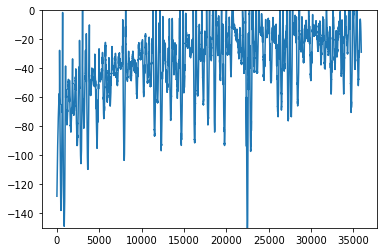

In [31]:
# reward received during training
rpR = np.vstack(episode_reward)
from scipy.signal import savgol_filter
yhat = savgol_filter(rpR[:,2], 361, 2) # window size 51, polynomial order 3
#plt.plot(rpR[:,4])
plt.figure(figsize=(6,4))
plt.plot(yhat)
plt.ylim([-150,0])

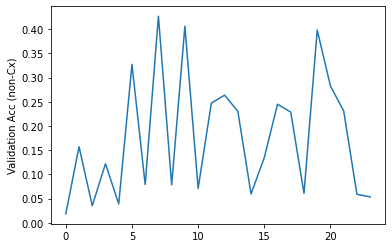

In [29]:
vvr = np.stack(validation_reward)
plt.figure(figsize=(6,4))
plt.plot(vvr[:,1])
plt.ylabel('Validation Acc (non-Cx)')
plt.show()

In [ ]:
# histogram of Q values last 10 episodes
epn = -1
mmat = allEpData
episQ = np.stack(mmat[epn][:,0])[:,]
episY = mmat[epn][:,4]*10+10
episC = mmat[epn][:,5]*10+10
episTau = mmat[epn][:,1]
# print (episY)

plt.figure(figsize=(20,10))
plt.rcParams["figure.figsize"] = (20,10)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(episY, label='GT')
ax1.plot(episTau, label='Tau', color='black')
#ax1.plot(episC+1, label='pi(s)', color='cyan')
ax1.legend(loc='best')

ax2.plot(episQ[:,0], label='A1')
ax2.plot(episQ[:,1], label='A2')
ax2.plot(episQ[:,2], label='A3')
ax2.plot(episQ[:,3], label='A4')
ax2.plot(episQ[:,4], label='A5')
ax2.plot(episQ[:,5], label='Ax')
ax2.set_ylim([-4,5])
ax2.legend(loc='best')

In [32]:
def remove_duplicates(arr): 
    final_list = [] 
    gt_tr = []
    final_list.append(arr[0])     
    for i in range(1,arr.shape[0]): 
        if arr[i] != arr[i-1]:
            final_list.append(arr[i])     
            if arr[i] != num_camera-1:
                gt_tr.append(arr[i])
    return final_list, gt_tr

In [36]:
print (epoch)

45


In [45]:
policy_net.load_state_dict(torch.load('./models/policy_duke_semisup_gtBOX_5_81')['state_dict'])

In [34]:
policy_net.eval()
req_inc = 0
render = False
_,acc,_,numTR = test_func(pTest,iloc='fix',eloc='last', fixLoc=2, isdebug=0, req_inc=req_inc)
tr_acc = 0
avg_tr_captured = []
A,P,R,F, ttr = [],[],[],[],[]
Fscore, Fscore_onlytr = [],[]
A_onlytr,P_onlytr,R_onlytr = [],[],[]
nfr = []
for i in range(len(acc)):
    print ('Person: ',i)
    gt = np.array([d[0] for d in acc[i]])
    pr = np.array([d[1] for d in acc[i]])
    g = gt #t[gt != num_camera-1]
    p = pr #r[gt != num_camera-1]

    dups,gt_tr = remove_duplicates(g)
    print ('Transitions: ', dups)
    print ('GT transitions: ', len(gt_tr))
    print ('Transitions captured: ', numTR[i])
    if len(gt_tr) != 0:
        avg_tr_captured.append((numTR[i],len(gt_tr)))
        contains_tr = 1
    else:
        print ('')
        contains_tr = 0
        #continue

    # plot transitions
#     afc.plot_color_transitions(p,g)
    # MCTA and number of frames
    if req_inc == 1:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    else:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)

    fs = 2*(pr*re)/(pr+re)
    if contains_tr == 1:
        A_onlytr.append(ac)
        P_onlytr.append(pr)
        R_onlytr.append(re)
        Fscore_onlytr.append(fs)
    A.append(ac)
    P.append(pr)
    R.append(re)
    F.append(fr)
    Fscore.append(fs) 
    ttr.append(tr)
    print ('A,P,R: ', ac,pr,re)
    f = afc.compute_num_frames(p,g)
    nfr.append(f)
    print ('Num frames: ', f)
    # Accuracy
    tacc = np.sum(g==p, dtype=np.float)/g.shape[0]
    tr_acc += tacc
    print ('Accuracy: ',tacc)
print (tr_acc/len(A))
print ('Average (only transitions) A,P,R', np.mean(A_onlytr),np.mean(P_onlytr),np.mean(R_onlytr))
print ('Average (all targets) A,P,R,F, ttr', np.mean(A),np.mean(P),np.mean(R),np.mean(F), ttr)
print ('Fscore (all targets, only transitions) ', np.mean(Fscore),np.mean(Fscore_onlytr))
print (np.sum(nfr))

Initial position:  [    7 33839   283   816    96   237]
Initial position:  [    0 20939  1851   298    64   194]
Initial position:  [     0 122030   1851    427     62    228]
Initial position:  [    7 52909   233   811    97   241]
Initial position:  [     0 126222   1847    272     68    213]
Initial position:  [    7 88687   256   821    94   236]
Initial position:  [    5 14238  1589   595    95   239]
Initial position:  [    7 99379   268   820    94   237]
Initial position:  [     5 145243    137    724    138    344]
Initial position:  [     7 142346   1765    763     90    227]
Initial position:  [    7 55585  1774   687    95   241]
Initial position:  [    1 27254   698   138    67   168]
Initial position:  [    7 71533   256   807    99   249]
Initial position:  [     7 163928    257    807     99    247]
Initial position:  [    5 35783  1568   582    98   248]
Initial position:  [    7 18757  1769   726    92   232]
Initial position:  [    7 10747   581   816    98   240]
I

Initial position:  [     7 140765    270    798    104    263]
Initial position:  [    7 71946  1771   712    93   234]
Initial position:  [    5 98438  1606   608    91   231]
Initial position:  [     0 115607   1860    310     56    190]
Initial position:  [    0 26294  1855   404    56   216]
Initial position:  [     7 160954   1773    720     88    222]
Initial position:  [    1 54999  1842   362    73   225]
Initial position:  [    7 80689  1772   758    83   210]
Initial position:  [     7 104443   1766    771     84    214]
Initial position:  [     7 127063    244    796    105    264]
Initial position:  [    3 49905  1321   142    41   104]
Initial position:  [    5 45107  1585   612    87   219]
Initial position:  [    7 74864   323   813    97   246]
Initial position:  [    7 59765  1771   733    86   218]
Initial position:  [    7 30506  1775   715    87   220]
Initial position:  [    7 79859  1769   655    78   196]
Initial position:  [    6 67191     8   598    82   225]
I

Initial position:  [    5 94570  1591   590    98   247]
Initial position:  [    7 22387   176   818    94   237]
Initial position:  [    1 53359   681   126    72   181]
Initial position:  [     7 109779   1772    727     88    224]
Initial position:  [    0 65115  1841   441    77   246]
Initial position:  [    0 34154  1851   285    66   210]
Initial position:  [     5 109371   1625    594    100    253]
Initial position:  [    1 34868   704   133    68   173]
Initial position:  [    7 52640  1775   741    84   213]
Initial position:  [    0 70895  1859   271    53   194]
Initial position:  [    3 40350  1318   134    44   112]
Initial position:  [     0 152068   1857    287     60    191]
Initial position:  [    7 94246  1773   726    85   216]
Initial position:  [     7 116806   1770    736     87    219]
Initial position:  [     1 120840    698    126     72    181]
Initial position:  [     7 118899   1765    728     98    247]
Initial position:  [    7 77603   172   786   107   

Initial position:  [    6 46717   816   576    60   153]
Initial position:  [     0 140380   1845    273     72    214]
Initial position:  [    0 52915  1845   265    72   212]
Initial position:  [    7 10451  1771   713    93   234]
Initial position:  [    7 72591  1797   502    55   138]
Initial position:  [     3 155349   1311    140     42    106]
Initial position:  [    3 25533  1318   142    41   104]
Initial position:  [     7 155700     96    777    112    283]
Initial position:  [    1 76928  1839   463    73   243]
Initial position:  [    6 56772   801   572    62   157]
Initial position:  [     0 117940   1843    272     74    220]
Initial position:  [    0 68488  1856   274    50   214]
Initial position:  [    7 71045  1758   751    91   231]
Initial position:  [    7 53472   260   796   104   256]
Initial position:  [    7 49309  1759   704    95   239]
Initial position:  [    1 87395   667   132    70   177]
Initial position:  [    7 98027   255   796   104   264]
Initial

Initial position:  [    0 52499  1857   278    50   208]
Initial position:  [    5 90224  1620   587   102   258]
Initial position:  [     7 179445    236    798    102    254]
Initial position:  [    1 77723   710   146    63   160]
Initial position:  [     7 137022   1768    752     91    231]
Initial position:  [     7 172260   1768    712     93    234]
Initial position:  [    0 35281  1830   285    83   210]
Initial position:  [    3 44488  1337   140    42   106]
Initial position:  [    7 40227  1799   651    72   183]
Initial position:  [     7 107472   1772    726     85    216]
Initial position:  [    0 58943  1855   270    62   213]
Initial position:  [    7 50956  1771   741    87   220]
Initial position:  [    3 50710  1321   144    40   102]
Initial position:  [    0 79349  1855   295    61   187]
Initial position:  [    5 62032  1589   595    95   240]
Initial position:  [    0 42591  1830   743    77   311]
Initial position:  [    5 51175  1583   594    94   239]
Initial

Initial position:  [    7 36130   333   802   102   258]
Initial position:  [     7 161987    321    799    102    259]
Initial position:  [    7 74844   209   835    88   219]
Initial position:  [    7 64913   296   817    96   238]
Initial position:  [    7 83758  1773   722    85   215]
Initial position:  [     7 114940    298    799    103    253]
Initial position:  [     7 119019   1742    789     83    211]
Initial position:  [    7 68033  1773   732    89   225]
Initial position:  [    5 66852  1591   606    90   228]
Initial position:  [    0 35934  1821   401    85   216]
Initial position:  [    0 48752  1800   243    82   207]
Initial position:  [    7 19158  1769   750    85   215]
Initial position:  [    7 74702  1770   731    89   225]
Initial position:  [    5 71972  1629   627    85   216]
Initial position:  [    5 25150  1615   611    91   230]
Initial position:  [     7 136996   1767    718     87    221]
Initial position:  [     7 136413    294    799    103    257]
I

Initial position:  [    5 45227  1354   741   129   320]
Initial position:  [    1 88455  1836   342    63   241]
Initial position:  [     0 124191   1857    372     61    209]
Initial position:  [    4 29735  1825   593    87   294]
Initial position:  [    7 81443  1775   737    84   212]
Initial position:  [    7 73503   288   819    93   235]
Initial position:  [     0 116262   1855    278     61    208]
Initial position:  [     7 154512   1771    741     87    220]
Initial position:  [    0 67792  1841   423    74   242]
Initial position:  [    7 17010  1770   740    87   220]
Initial position:  [     7 152030   1774    767     84    212]
Initial position:  [     3 102896   1310    129     46    117]
Initial position:  [     7 177780   1770    713     93    234]
Initial position:  [     5 115485   1627    616     90    229]
Initial position:  [     7 141449   1738    745     82    206]
Initial position:  [    7 71499  1771   759    86   218]
Initial position:  [    3 13496  1321   

A,P,R:  0.9962406015037594 0.9962406015037594 1.0
Num frames:  (266, 1)
Accuracy:  0.9962406015037594
Person:  37
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9968847352024922 0.9968847352024922 1.0
Num frames:  (321, 1)
Accuracy:  0.9968847352024922
Person:  38
Transitions:  [5, 8, 4, 8, 1, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.7521879318286504 0.7047200878155873 0.9922720247295209
Num frames:  (1822, 528)
Accuracy:  0.7521879318286504
Person:  39
Transitions:  [3, 8, 2, 8, 1, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.8733905579399142 0.8209408194233687 0.9077181208053692
Num frames:  (1318, 126)
Accuracy:  0.8733905579399142
Person:  40
Transitions:  [1, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.7544956997654417 0.6616231086657497 0.6143039591315453
Num frames:  (727, 12)
Accuracy:  0.7544956997654417
Person:  41
Transitions:  [7, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.951834

Num frames:  (934, 45)
Accuracy:  0.9709864603481625
Person:  108
Transitions:  [4, 8, 5, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.9897100093545369 0.9840116279069767 0.9941262848751835
Num frames:  (688, 7)
Accuracy:  0.9897100093545369
Person:  109
Transitions:  [7, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.7453531598513011 0.609129814550642 1.0
Num frames:  (1402, 548)
Accuracy:  0.7453531598513011
Person:  110
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9976470588235294 0.9976470588235294 1.0
Num frames:  (425, 1)
Accuracy:  0.9976470588235294
Person:  111
Transitions:  [5, 8, 6, 8, 7, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9429756350440642 0.9109311740890689 1.0
Num frames:  (1235, 110)
Accuracy:  0.9429756350440642
Person:  112
Transitions:  [7, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.9716267339218159 0.9476135040745053 1.0
Num frames:  (859, 45)
Accuracy:  0.971626733921

A,P,R:  0.9959183673469387 0.9959183673469387 1.0
Num frames:  (245, 1)
Accuracy:  0.9959183673469387
Person:  176
Transitions:  [6, 8, 4, 8, 2, 8]
GT transitions:  2
Transitions captured:  0
A,P,R:  0.3651895355045382 0.3736343772760379 0.3445265278710544
Num frames:  (1373, 213)
Accuracy:  0.3651895355045382
Person:  177
Transitions:  [1, 8, 4, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.886762360446571 0.8328 0.8617549668874173
Num frames:  (1250, 46)
Accuracy:  0.886762360446571
Person:  178
Transitions:  [7, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.9514792899408284 0.9141361256544502 1.0
Num frames:  (955, 82)
Accuracy:  0.9514792899408284
Person:  179
Transitions:  [5, 8, 4, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.9774951076320939 0.965925925925926 0.998468606431853
Num frames:  (675, 22)
Accuracy:  0.9774951076320939
Person:  180
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.959259

Transitions:  [0, 8, 1, 8, 7, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.8937282229965157 0.7978723404255319 0.8714596949891068
Num frames:  (1504, 128)
Accuracy:  0.8937282229965157
Person:  232
Transitions:  [7, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.8835257082896117 0.808124459809853 1.0
Num frames:  (1157, 222)
Accuracy:  0.8835257082896117
Person:  233
Transitions:  [2, 8, 4, 8, 6, 8, 7, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9156094870380584 0.8567335243553008 0.9857142857142858
Num frames:  (1047, 140)
Accuracy:  0.9156094870380584
Person:  234
Transitions:  [3, 8, 2, 8, 4, 8, 4, 8, 2, 8]
GT transitions:  4
Transitions captured:  2
A,P,R:  0.2027037773359841 0.1309699228568952 0.4983509234828496
Num frames:  (11537, 8505)
Accuracy:  0.2027037773359841
Person:  235
Transitions:  [3, 8, 2, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8854258121158911 0.8258706467661692 0.8143908421913328
Num frames:  (

A,P,R:  0.996996996996997 0.996996996996997 1.0
Num frames:  (333, 1)
Accuracy:  0.996996996996997
Person:  277
Transitions:  [1, 8, 2, 8, 3, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.8807247106190237 0.8323903818953324 0.898473282442748
Num frames:  (1414, 104)
Accuracy:  0.8807247106190237
Person:  278
Transitions:  [1, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.7685749086479903 0.6304347826086957 0.7200902934537246
Num frames:  (1012, 132)
Accuracy:  0.7685749086479903
Person:  279
Transitions:  [5, 8, 4, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8986175115207373 0.8328462887200467 0.9985984583041345
Num frames:  (1711, 284)
Accuracy:  0.8986175115207373
Person:  280
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9970588235294118 0.9970588235294118 1.0
Num frames:  (340, 1)
Accuracy:  0.9970588235294118
Person:  281
Transitions:  [1, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R: 

A,P,R:  0.9961089494163424 0.9961089494163424 1.0
Num frames:  (257, 1)
Accuracy:  0.9961089494163424
Person:  339
Transitions:  [0, 8, 1, 8, 2, 8, 3, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8444637178375253 0.7402221149203283 0.876
Num frames:  (2071, 321)
Accuracy:  0.8444637178375253
Person:  340
Transitions:  [5, 8, 6, 8, 7, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9783132530120482 0.9631525076765609 1.0
Num frames:  (977, 36)
Accuracy:  0.9783132530120482
Person:  341
Transitions:  [0, 8, 1, 8, 4, 8, 5, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9515828677839852 0.9023904382470119 0.9919708029197081
Num frames:  (1506, 145)
Accuracy:  0.9515828677839852
Person:  342
Transitions:  [2, 8, 1, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.834924965893588 0.7846975088967971 0.8242990654205608
Num frames:  (562, 27)
Accuracy:  0.834924965893588
Person:  343
Transitions:  [3, 8, 2, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions cap

A,P,R:  0.8916753744339951 0.7884882108183079 0.8732718894009217
Num frames:  (1442, 146)
Accuracy:  0.8916753744339951
Person:  398
Transitions:  [3, 8, 2, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8917299240910906 0.8492569002123143 0.8664259927797834
Num frames:  (1413, 86)
Accuracy:  0.8917299240910906
Person:  399
Transitions:  [5, 8, 4, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9303519061583577 0.8846625766871166 0.9979238754325259
Num frames:  (1630, 187)
Accuracy:  0.9303519061583577
Person:  400
Transitions:  [3, 8, 2, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8908801274392673 0.8095238095238095 0.8615733736762481
Num frames:  (1407, 91)
Accuracy:  0.8908801274392673
Person:  401
Transitions:  [5, 8, 6, 8, 7, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9751724137931035 0.9913258983890955 0.9650180940892642
Num frames:  (807, 7)
Accuracy:  0.9751724137931035
Person:  402
Transitions:  

Num frames:  (72487, 64887)
Accuracy:  0.0673637507270686
Person:  438
Transitions:  [0, 8, 1, 8, 2, 8, 3, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8791208791208791 0.7863296955772544 0.8697585768742059
Num frames:  (1741, 169)
Accuracy:  0.8791208791208791
Person:  439
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9980769230769231 0.9980769230769231 1.0
Num frames:  (520, 1)
Accuracy:  0.9980769230769231
Person:  440
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.8990338164251208 0.8542538354253836 1.0
Num frames:  (1434, 209)
Accuracy:  0.8990338164251208
Person:  441
Transitions:  [0, 8, 1, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.8293650793650794 0.6789189189189189 0.7449584816132859
Num frames:  (925, 86)
Accuracy:  0.8293650793650794
Person:  442
Transitions:  [7, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.9359410430839002 0.8881188118811881 1.0
Num frames:  (

A,P,R:  0.9316939890710383 0.9346534653465347 0.8847235238987816
Num frames:  (1010, 52)
Accuracy:  0.9316939890710383
Person:  503
Transitions:  [0, 8, 1, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.8835820895522388 0.7616822429906542 0.76049766718507
Num frames:  (642, 2)
Accuracy:  0.8835820895522388
Person:  504
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9971014492753624 0.9971014492753624 1.0
Num frames:  (345, 1)
Accuracy:  0.9971014492753624
Person:  505
Transitions:  [5, 8, 4, 8, 1, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.827741612418628 0.7750163505559189 0.8803863298662704
Num frames:  (1529, 183)
Accuracy:  0.827741612418628
Person:  506
Transitions:  [5, 8, 4, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9260355029585798 0.8801986343885785 0.9950877192982456
Num frames:  (1611, 193)
Accuracy:  0.9260355029585798
Person:  507
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.05428847256161945 0.025586817969842995 0.6844074844074844
Num frames:  (64330, 61936)
Accuracy:  0.05428847256161945
Person:  552
Transitions:  [5, 8, 4, 8, 0, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.6300448430493274 0.5103857566765578 1.0
Num frames:  (2359, 1155)
Accuracy:  0.6300448430493274
Person:  553
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9975247524752475 0.9975247524752475 1.0
Num frames:  (404, 1)
Accuracy:  0.9975247524752475
Person:  554
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.996078431372549 0.996078431372549 1.0
Num frames:  (255, 1)
Accuracy:  0.996078431372549
Person:  555
Transitions:  [0, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9997949979499795 0.9997949979499795 1.0
Num frames:  (4878, 1)
Accuracy:  0.9997949979499795
Person:  556
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9965986394557823 0.9965986394557823 1.0
Num fra

A,P,R:  0.0441249441770456 0.023519407001243876 0.08827172256097561
Num frames:  (78786, 57916)
Accuracy:  0.0441249441770456
Person:  616
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9967741935483871 0.9967741935483871 1.0
Num frames:  (310, 1)
Accuracy:  0.9967741935483871
Person:  617
Transitions:  [1, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.4991364421416235 0.4991364421416235 0.5
Num frames:  (579, 1)
Accuracy:  0.4991364421416235
Person:  618
Transitions:  [5, 8, 4, 8, 1, 8, 1, 8, 1, 8]
GT transitions:  4
Transitions captured:  2
A,P,R:  0.23939131510577755 0.18114011720831114 0.5844434894714224
Num frames:  (7508, 5181)
Accuracy:  0.23939131510577755
Person:  619
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.941839762611276 0.9089184060721063 0.9979166666666667
Num frames:  (1054, 96)
Accuracy:  0.941839762611276
Person:  620
Transitions:  [1, 8, 4, 8, 2, 8, 3, 8]
GT transitions:  3
Transiti

A,P,R:  0.11152794060179758 0.053424942744118256 0.39367904265111997
Num frames:  (24015, 20760)
Accuracy:  0.11152794060179758
Person:  678
Transitions:  [5, 8, 6, 8, 7, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9802784222737819 0.9686907020872866 0.9990215264187867
Num frames:  (1054, 33)
Accuracy:  0.9802784222737819
Person:  679
Transitions:  [0, 8, 1, 8, 2, 8, 3, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8955091151622944 0.8963474827245804 0.8136200716845878
Num frames:  (1013, 27)
Accuracy:  0.8955091151622944
Person:  680
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9966555183946488 0.9966555183946488 1.0
Num frames:  (299, 1)
Accuracy:  0.9966555183946488
Person:  681
Transitions:  [2, 8, 1, 8, 0, 8, 0, 8]
GT transitions:  3
Transitions captured:  2
A,P,R:  0.6658756525866161 0.6641883519206939 0.4986046511627907
Num frames:  (807, 165)
Accuracy:  0.6658756525866161
Person:  682
Transitions:  [1, 8, 0, 8]
GT transitio

A,P,R:  0.6249248346361996 0.5223051885889336 0.9708185053380783
Num frames:  (5223, 2413)
Accuracy:  0.6249248346361996
Person:  736
Transitions:  [0, 8, 1, 8, 2, 8, 3, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8892857142857142 0.7990654205607477 0.8586800573888091
Num frames:  (1498, 113)
Accuracy:  0.8892857142857142
Person:  737
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9536384976525821 0.9268518518518518 1.0
Num frames:  (1080, 79)
Accuracy:  0.9536384976525821
Person:  738
Transitions:  [0, 8, 1, 8, 2, 8, 3, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8235294117647058 0.7002022244691608 0.8204976303317536
Num frames:  (1978, 294)
Accuracy:  0.8235294117647058
Person:  739
Transitions:  [0, 8, 1, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.8800813008130082 0.7531380753138075 0.7670454545454546
Num frames:  (717, 13)
Accuracy:  0.8800813008130082
Person:  740
Transitions:  [1, 8, 4, 8, 5, 8]
GT tr

Transitions:  [3, 8, 2, 8, 1, 8, 1, 8, 4, 8, 4, 8]
GT transitions:  5
Transitions captured:  2
A,P,R:  0.09907947223074563 0.05903180121024849 0.4855705586444268
Num frames:  (31068, 27418)
Accuracy:  0.09907947223074563
Person:  802
Transitions:  [3, 8, 2, 8, 4, 8, 1, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8665955176093917 0.7905405405405406 0.9821615949632738
Num frames:  (1184, 233)
Accuracy:  0.8665955176093917
Person:  803
Transitions:  [3, 8, 2, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8997837058399423 0.8346268656716418 0.9338677354709419
Num frames:  (1675, 179)
Accuracy:  0.8997837058399423
Person:  804
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.8684738955823293 0.8069270449521002 1.0
Num frames:  (1357, 262)
Accuracy:  0.8684738955823293
Person:  805
Transitions:  [0, 8, 1, 8, 2, 8, 3, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8462204270051933 0.7427606177606177 0.87195467

A,P,R:  0.8863276836158193 0.852751756440281 0.9024163568773235
Num frames:  (3416, 188)
Accuracy:  0.8863276836158193
Person:  861
Transitions:  [1, 8, 4, 8, 2, 8, 3, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9246458923512748 0.8704453441295547 0.9942196531791907
Num frames:  (988, 128)
Accuracy:  0.9246458923512748
Person:  862
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9969230769230769 0.9969230769230769 1.0
Num frames:  (325, 1)
Accuracy:  0.9969230769230769
Person:  863
Transitions:  [0, 8, 1, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.8718801996672213 0.8088531187122736 0.7256317689530686
Num frames:  (497, 2)
Accuracy:  0.8718801996672213
Person:  864
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9968847352024922 0.9968847352024922 1.0
Num frames:  (321, 1)
Accuracy:  0.9968847352024922
Person:  865
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.99635036496350

In [35]:
a = np.stack(avg_tr_captured)
print (np.mean(a[:,0]/a[:,1]))
print (sum(a[:,0])/sum(a[:,1]))

0.9372219344441567
0.8957940991839297


In [37]:
from IPython.display import clear_output
def eval_policy():
    policy_net.eval()
    req_inc = 0
    render = False
    _,acc,_,numTR = test_func(pTest,iloc='fix',eloc='last', fixLoc=2, isdebug=0, req_inc=req_inc)
    tr_acc = 0
    avg_tr_captured = []
    A,P,R,F, ttr = [],[],[],[],[]
    Fscore, Fscore_onlytr = [],[]
    A_onlytr,P_onlytr,R_onlytr = [],[],[]
    nfr = []
    for i in range(len(acc)):
        print ('Person: ',i)
        gt = np.array([d[0] for d in acc[i]])
        pr = np.array([d[1] for d in acc[i]])
        g = gt #t[gt != num_camera-1]
        p = pr #r[gt != num_camera-1]

        dups,gt_tr = remove_duplicates(g)
        print ('Transitions: ', dups)
        print ('GT transitions: ', len(gt_tr))
        print ('Transitions captured: ', numTR[i])
        if len(gt_tr) != 0:
            avg_tr_captured.append((numTR[i],len(gt_tr)))
            contains_tr = 1
        else:
            print ('')
            contains_tr = 0
            #continue

        # plot transitions
    #     afc.plot_color_transitions(p,g)
        # MCTA and number of frames
        if req_inc == 1:
            ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
        else:
            ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)

        fs = 2*(pr*re)/(pr+re)
        if contains_tr == 1:
            A_onlytr.append(ac)
            P_onlytr.append(pr)
            R_onlytr.append(re)
            Fscore_onlytr.append(fs)
        A.append(ac)
        P.append(pr)
        R.append(re)
        F.append(fr)
        Fscore.append(fs) 
        ttr.append(tr)
        print ('A,P,R: ', ac,pr,re)
        f = afc.compute_num_frames(p,g)
        nfr.append(f)
        print ('Num frames: ', f)
        # Accuracy
        tacc = np.sum(g==p, dtype=np.float)/g.shape[0]
        tr_acc += tacc
        print ('Accuracy: ',tacc)
    print (tr_acc/len(A))
    print ('Average (only transitions) A,P,R', np.mean(A_onlytr),np.mean(P_onlytr),np.mean(R_onlytr))
    print ('Average (all targets) A,P,R,F, ttr', np.mean(A),np.mean(P),np.mean(R),np.mean(F), ttr)
    print ('Fscore (all targets, only transitions) ', np.mean(Fscore),np.mean(Fscore_onlytr))
    print (np.sum(nfr))
    
    a = np.stack(avg_tr_captured)
    PCH_1 = np.mean(a[:,0]/a[:,1])
    PCH_2 = sum(a[:,0])/sum(a[:,1])
    print (PCH_1)
    print (PCH_2)
    
    return np.mean(A),np.mean(P),np.mean(R),np.mean(Fscore),PCH_1,PCH_2

In [38]:

all_metric_values = []
for epoch_i in range(1,epoch,5):
    modelname = './models/policy_duke_semisup_gtBOX_5_' + str(epoch_i)
    print (modelname)
    # load model
    policy_net.load_state_dict(torch.load(modelname)['state_dict'])
    
    A,P,R,F1,PCH1,PCH2 = eval_policy()
    all_metric_values.append((epoch_i,A,P,R,F1,PCH1,PCH2))
    
    clear_output(wait=True)

./models/policy_duke_semisup_gtBOX_5_41
Initial position:  [    7 33839   283   816    96   237]
Initial position:  [    0 20939  1851   298    64   194]
Initial position:  [     0 122030   1851    427     62    228]
Initial position:  [    7 52909   233   811    97   241]
Initial position:  [     0 126222   1847    272     68    213]
Initial position:  [    7 88687   256   821    94   236]
Initial position:  [    5 14238  1589   595    95   239]
Initial position:  [    7 99379   268   820    94   237]
Initial position:  [     5 145243    137    724    138    344]
Initial position:  [     7 142346   1765    763     90    227]
Initial position:  [    7 55585  1774   687    95   241]
Initial position:  [    1 27254   698   138    67   168]
Initial position:  [    7 71533   256   807    99   249]
Initial position:  [     7 163928    257    807     99    247]
Initial position:  [    5 35783  1568   582    98   248]
Initial position:  [    7 18757  1769   726    92   232]
Initial position: 

Initial position:  [   3 3330 1259  702  140  355]
Initial position:  [     7 140765    270    798    104    263]
Initial position:  [    7 71946  1771   712    93   234]
Initial position:  [    5 98438  1606   608    91   231]
Initial position:  [     0 115607   1860    310     56    190]
Initial position:  [    0 26294  1855   404    56   216]
Initial position:  [     7 160954   1773    720     88    222]
Initial position:  [    1 54999  1842   362    73   225]
Initial position:  [    7 80689  1772   758    83   210]
Initial position:  [     7 104443   1766    771     84    214]
Initial position:  [     7 127063    244    796    105    264]
Initial position:  [    3 49905  1321   142    41   104]
Initial position:  [    5 45107  1585   612    87   219]
Initial position:  [    7 74864   323   813    97   246]
Initial position:  [    7 59765  1771   733    86   218]
Initial position:  [    7 30506  1775   715    87   220]
Initial position:  [    7 79859  1769   655    78   196]
Initial

Initial position:  [    5 94570  1591   590    98   247]
Initial position:  [    7 22387   176   818    94   237]
Initial position:  [    1 53359   681   126    72   181]
Initial position:  [     7 109779   1772    727     88    224]
Initial position:  [    0 65115  1841   441    77   246]
Initial position:  [    0 34154  1851   285    66   210]
Initial position:  [     5 109371   1625    594    100    253]
Initial position:  [    1 34868   704   133    68   173]
Initial position:  [    7 52640  1775   741    84   213]
Initial position:  [    0 70895  1859   271    53   194]
Initial position:  [    3 40350  1318   134    44   112]
Initial position:  [     0 152068   1857    287     60    191]
Initial position:  [    7 94246  1773   726    85   216]
Initial position:  [     7 116806   1770    736     87    219]
Initial position:  [     1 120840    698    126     72    181]
Initial position:  [     7 118899   1765    728     98    247]
Initial position:  [    7 77603   172   786   107   

Initial position:  [    6 46717   816   576    60   153]
Initial position:  [     0 140380   1845    273     72    214]
Initial position:  [    0 52915  1845   265    72   212]
Initial position:  [    7 10451  1771   713    93   234]
Initial position:  [    7 72591  1797   502    55   138]
Initial position:  [     3 155349   1311    140     42    106]
Initial position:  [    3 25533  1318   142    41   104]
Initial position:  [     7 155700     96    777    112    283]
Initial position:  [    1 76928  1839   463    73   243]
Initial position:  [    6 56772   801   572    62   157]
Initial position:  [     0 117940   1843    272     74    220]
Initial position:  [    0 68488  1856   274    50   214]
Initial position:  [    7 71045  1758   751    91   231]
Initial position:  [    7 53472   260   796   104   256]
Initial position:  [    7 49309  1759   704    95   239]
Initial position:  [    1 87395   667   132    70   177]
Initial position:  [    7 98027   255   796   104   264]
Initial

Initial position:  [    0 52499  1857   278    50   208]
Initial position:  [    5 90224  1620   587   102   258]
Initial position:  [     7 179445    236    798    102    254]
Initial position:  [    1 77723   710   146    63   160]
Initial position:  [     7 137022   1768    752     91    231]
Initial position:  [     7 172260   1768    712     93    234]
Initial position:  [    0 35281  1830   285    83   210]
Initial position:  [    3 44488  1337   140    42   106]
Initial position:  [    7 40227  1799   651    72   183]
Initial position:  [     7 107472   1772    726     85    216]
Initial position:  [    0 58943  1855   270    62   213]
Initial position:  [    7 50956  1771   741    87   220]
Initial position:  [    3 50710  1321   144    40   102]
Initial position:  [    0 79349  1855   295    61   187]
Initial position:  [    5 62032  1589   595    95   240]
Initial position:  [    0 42591  1830   743    77   311]
Initial position:  [    5 51175  1583   594    94   239]
Initial

Initial position:  [    7 36130   333   802   102   258]
Initial position:  [     7 161987    321    799    102    259]
Initial position:  [    7 74844   209   835    88   219]
Initial position:  [    7 64913   296   817    96   238]
Initial position:  [    7 83758  1773   722    85   215]
Initial position:  [     7 114940    298    799    103    253]
Initial position:  [     7 119019   1742    789     83    211]
Initial position:  [    7 68033  1773   732    89   225]
Initial position:  [    5 66852  1591   606    90   228]
Initial position:  [    0 35934  1821   401    85   216]
Initial position:  [    0 48752  1800   243    82   207]
Initial position:  [    7 19158  1769   750    85   215]
Initial position:  [    7 74702  1770   731    89   225]
Initial position:  [    5 71972  1629   627    85   216]
Initial position:  [    5 25150  1615   611    91   230]
Initial position:  [     7 136996   1767    718     87    221]
Initial position:  [     7 136413    294    799    103    257]
I

Initial position:  [    5 45227  1354   741   129   320]
Initial position:  [    1 88455  1836   342    63   241]
Initial position:  [     0 124191   1857    372     61    209]
Initial position:  [    4 29735  1825   593    87   294]
Initial position:  [    7 81443  1775   737    84   212]
Initial position:  [    7 73503   288   819    93   235]
Initial position:  [     0 116262   1855    278     61    208]
Initial position:  [     7 154512   1771    741     87    220]
Initial position:  [    0 67792  1841   423    74   242]
Initial position:  [    7 17010  1770   740    87   220]
Initial position:  [     7 152030   1774    767     84    212]
Initial position:  [     3 102896   1310    129     46    117]
Initial position:  [     7 177780   1770    713     93    234]
Initial position:  [     5 115485   1627    616     90    229]
Initial position:  [     7 141449   1738    745     82    206]
Initial position:  [    7 71499  1771   759    86   218]
Initial position:  [    3 13496  1321   

A,P,R:  0.9617447264926707 0.9359365466748018 0.9986979166666666
Num frames:  (1639, 105)
Accuracy:  0.9617447264926707
Person:  32
Transitions:  [3, 8, 2, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8565989847715736 0.8002969561989607 0.8254211332312404
Num frames:  (1347, 111)
Accuracy:  0.8565989847715736
Person:  33
Transitions:  [6, 8, 7, 8, 0, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.8761826408885233 0.7717968157695224 1.0
Num frames:  (1319, 301)
Accuracy:  0.8761826408885233
Person:  34
Transitions:  [3, 8, 2, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9790810608890549 0.9638795986622074 0.9986139986139986
Num frames:  (1495, 54)
Accuracy:  0.9790810608890549
Person:  35
Transitions:  [7, 8, 6, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.7060998151571165 0.92 0.4591651542649728
Num frames:  (275, 20)
Accuracy:  0.7060998151571165
Person:  36
Transitions:  [7, 8]
GT transitions:  0
Transitions captur

Accuracy:  0.9566074950690335
Person:  97
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9970059880239521 0.9970059880239521 1.0
Num frames:  (334, 1)
Accuracy:  0.9970059880239521
Person:  98
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  1
A,P,R:  0.547979797979798 0.3545586107091172 0.2722222222222222
Num frames:  (691, 61)
Accuracy:  0.547979797979798
Person:  99
Transitions:  [1, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.946983546617916 0.9189944134078212 0.9939577039274925
Num frames:  (1074, 81)
Accuracy:  0.946983546617916
Person:  100
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9288979177247334 0.8920585967617579 1.0
Num frames:  (1297, 140)
Accuracy:  0.9288979177247334
Person:  101
Transitions:  [0, 8, 1, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.8970019342359767 0.8442982456140351 1.0
Num frames:  (1368, 213)
Accuracy:  0.8970019342359767
P

Accuracy:  0.9169656586365966
Person:  139
Transitions:  [3, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9978813559322034 0.9978813559322034 1.0
Num frames:  (472, 1)
Accuracy:  0.9978813559322034
Person:  140
Transitions:  [7, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.8342696629213483 0.7160731472569779 1.0
Num frames:  (1039, 295)
Accuracy:  0.8342696629213483
Person:  141
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9659224441833137 0.944177093358999 1.0
Num frames:  (1039, 58)
Accuracy:  0.9659224441833137
Person:  142
Transitions:  [5, 8, 4, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8908011869436202 0.8310376492194674 1.0
Num frames:  (2178, 368)
Accuracy:  0.8908011869436202
Person:  143
Transitions:  [0, 8, 1, 8, 2, 8, 3, 8]
GT transitions:  3
Transitions captured:  1
A,P,R:  0.39818372336709745 0.20530565167243367 0.24842986741102582
Num frames:  (1734, 646)
Accuracy:  0.3981

A,P,R:  0.19761029411764705 0.18766726546174434 0.288768545157105
Num frames:  (27277, 12709)
Accuracy:  0.19761029411764705
Person:  194
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9202256244963739 0.9952380952380953 0.8672199170124482
Num frames:  (630, 3)
Accuracy:  0.9202256244963739
Person:  195
Transitions:  [0, 8, 1, 8, 4, 8, 5, 8]
GT transitions:  3
Transitions captured:  1
A,P,R:  0.33136829041265903 0.16921606118546845 0.2110912343470483
Num frames:  (2092, 832)
Accuracy:  0.33136829041265903
Person:  196
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9951219512195122 0.9951219512195122 1.0
Num frames:  (205, 1)
Accuracy:  0.9951219512195122
Person:  197
Transitions:  [2, 8, 3, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.9863813229571985 0.9820554649265906 0.9950413223140496
Num frames:  (613, 11)
Accuracy:  0.9863813229571985
Person:  198
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
T

Transitions:  [0, 8, 1, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.9117147707979627 0.8519924098671727 1.0
Num frames:  (1054, 156)
Accuracy:  0.9117147707979627
Person:  250
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9568106312292359 0.9568106312292359 0.96
Num frames:  (301, 1)
Accuracy:  0.9568106312292359
Person:  251
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  1
A,P,R:  0.526218383713757 0.3356258596973865 0.2582010582010582
Num frames:  (727, 67)
Accuracy:  0.526218383713757
Person:  252
Transitions:  [3, 8, 2, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9303981871155714 0.884841992501339 1.0
Num frames:  (1867, 215)
Accuracy:  0.9303981871155714
Person:  253
Transitions:  [0, 8, 7, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.8675461741424803 0.7713498622589532 0.9893992932862191
Num frames:  (1089, 242)
Accuracy:  0.8675461741424803
Person:  254
Transitions:  [5, 8

A,P,R:  0.9756944444444444 0.9756944444444444 0.9790940766550522
Num frames:  (288, 1)
Accuracy:  0.9756944444444444
Person:  321
Transitions:  [5, 8, 6, 8, 7, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.8849206349206349 0.8325082508250825 1.0
Num frames:  (1212, 203)
Accuracy:  0.8849206349206349
Person:  322
Transitions:  [6, 8, 4, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  2
A,P,R:  0.633122028526149 0.5172921265636498 0.7108190091001011
Num frames:  (1359, 640)
Accuracy:  0.633122028526149
Person:  323
Transitions:  [6, 8, 7, 8, 0, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.8598774885145483 0.7553475935828877 1.0
Num frames:  (1496, 366)
Accuracy:  0.8598774885145483
Person:  324
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9515570934256056 0.9515570934256056 0.9548611111111112
Num frames:  (289, 1)
Accuracy:  0.9515570934256056
Person:  325
Transitions:  [5, 8]
GT transitions:  0
Transitions captured:  0

A,P,

Accuracy:  0.950278164116829
Person:  377
Transitions:  [0, 8, 1, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.9250629722921915 0.8641552511415526 1.0
Num frames:  (876, 119)
Accuracy:  0.9250629722921915
Person:  378
Transitions:  [0, 8, 1, 8, 2, 8, 3, 8]
GT transitions:  3
Transitions captured:  1
A,P,R:  0.3814852492370295 0.19241192411924118 0.2384150436534587
Num frames:  (1845, 690)
Accuracy:  0.3814852492370295
Person:  379
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  1
A,P,R:  0.5088967971530249 0.29912390488110135 0.2304725168756027
Num frames:  (799, 30)
Accuracy:  0.5088967971530249
Person:  380
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9642857142857143 0.9642857142857143 0.9669421487603306
Num frames:  (364, 1)
Accuracy:  0.9642857142857143
Person:  381
Transitions:  [5, 8, 4, 8, 1, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9174917491749175 0.8856209150326797 1.0
Num frames:  (1530, 1

A,P,R:  0.9218241042345277 0.8658468418110676 1.0
Num frames:  (1789, 240)
Accuracy:  0.9218241042345277
Person:  422
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9422110552763819 0.9126803340926348 1.0
Num frames:  (1317, 115)
Accuracy:  0.9422110552763819
Person:  423
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9651515151515152 0.9651515151515152 0.9666160849772383
Num frames:  (660, 1)
Accuracy:  0.9651515151515152
Person:  424
Transitions:  [3, 8, 2, 8, 4, 8, 4, 8, 2, 8]
GT transitions:  4
Transitions captured:  2
A,P,R:  0.26059938645481 0.1472034979049007 0.5437415881561238
Num frames:  (10978, 8044)
Accuracy:  0.26059938645481
Person:  425
Transitions:  [3, 8, 2, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9764058198977585 0.9748382458662832 0.9818971759594497
Num frames:  (1391, 35)
Accuracy:  0.9764058198977585
Person:  426
Transitions:  [7, 8, 0, 8]
GT transitions:  1
Transition

A,P,R:  0.9330357142857143 0.8932584269662921 0.9994285714285714
Num frames:  (1958, 209)
Accuracy:  0.9330357142857143
Person:  467
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9609120521172638 0.9609120521172638 0.9640522875816994
Num frames:  (307, 1)
Accuracy:  0.9609120521172638
Person:  468
Transitions:  [5, 8, 6, 8, 7, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.8581560283687943 0.8033707865168539 1.0
Num frames:  (1424, 280)
Accuracy:  0.8581560283687943
Person:  469
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9470304975922953 0.9175686927560366 1.0
Num frames:  (1201, 99)
Accuracy:  0.9470304975922953
Person:  470
Transitions:  [5, 8, 6, 8, 7, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.84684260131951 0.7912652536929994 1.0
Num frames:  (1557, 325)
Accuracy:  0.84684260131951
Person:  471
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.952095808383233

A,P,R:  0.3537117903930131 0.1796116504854369 0.21359846055163567
Num frames:  (1854, 698)
Accuracy:  0.3537117903930131
Person:  518
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9465725806451613 0.9193302891933028 1.0
Num frames:  (1314, 106)
Accuracy:  0.9465725806451613
Person:  519
Transitions:  [5, 8, 4, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9695634761714057 0.9585218702865762 0.9791987673343605
Num frames:  (1326, 49)
Accuracy:  0.9695634761714057
Person:  520
Transitions:  [5, 8, 6, 8, 4, 8, 1, 8, 0, 8]
GT transitions:  4
Transitions captured:  3
A,P,R:  0.7678965625985493 0.6425094645754462 0.9406175771971497
Num frames:  (1849, 661)
Accuracy:  0.7678965625985493
Person:  521
Transitions:  [5, 8, 4, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.8746268656716418 0.8040130657956136 1.0
Num frames:  (2143, 420)
Accuracy:  0.8746268656716418
Person:  522
Transitions:  [7, 8]
GT transitio

A,P,R:  0.881578947368421 0.8142589118198874 1.0
Num frames:  (2132, 396)
Accuracy:  0.881578947368421
Person:  579
Transitions:  [3, 8, 2, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9649069270674397 0.9493731918997107 0.9949469429004548
Num frames:  (2074, 105)
Accuracy:  0.9649069270674397
Person:  580
Transitions:  [3, 8, 4, 8, 7, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.8770370370370371 0.7476708074534162 0.9796541200406917
Num frames:  (1288, 312)
Accuracy:  0.8770370370370371
Person:  581
Transitions:  [0, 8, 1, 8, 4, 8, 6, 8, 5, 8]
GT transitions:  4
Transitions captured:  4
A,P,R:  0.8011915269196822 0.7394447657605553 0.9996090695856138
Num frames:  (3458, 900)
Accuracy:  0.8011915269196822
Person:  582
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9442640692640693 0.9124149659863946 1.0
Num frames:  (1176, 103)
Accuracy:  0.9442640692640693
Person:  583
Transitions:  [5, 8, 6, 8, 7, 8]
GT trans

A,P,R:  0.7877539005004416 0.6568300809138505 1.0
Num frames:  (2101, 721)
Accuracy:  0.7877539005004416
Person:  650
Transitions:  [7, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.4299855142443264 0.2528481012658228 0.9803680981595092
Num frames:  (3160, 2345)
Accuracy:  0.4299855142443264
Person:  651
Transitions:  [0, 8, 1, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.657465495608532 0.7158351409978309 0.4034229828850856
Num frames:  (461, 58)
Accuracy:  0.657465495608532
Person:  652
Transitions:  [1, 8, 4, 8, 2, 8, 3, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.902469917669411 0.8287671232876712 0.9945205479452055
Num frames:  (876, 150)
Accuracy:  0.902469917669411
Person:  653
Transitions:  [5, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9978021978021978 0.9978021978021978 1.0
Num frames:  (455, 1)
Accuracy:  0.9978021978021978
Person:  654
Transitions:  [7, 8, 0, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.94

Transitions:  [0, 8, 1, 8, 4, 8, 5, 8]
GT transitions:  3
Transitions captured:  1
A,P,R:  0.37151921043355657 0.1930635838150289 0.22416107382550335
Num frames:  (1730, 627)
Accuracy:  0.37151921043355657
Person:  710
Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.953405017921147 0.953405017921147 0.9568345323741008
Num frames:  (279, 1)
Accuracy:  0.953405017921147
Person:  711
Transitions:  [7, 8, 6, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9730363423212193 0.9560229445506692 1.0
Num frames:  (1046, 46)
Accuracy:  0.9730363423212193
Person:  712
Transitions:  [5, 8, 4, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9532100108813928 0.9214330609679446 0.9972789115646259
Num frames:  (1591, 125)
Accuracy:  0.9532100108813928
Person:  713
Transitions:  [5, 8, 6, 8, 7, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.870899470899471 0.7523680649526387 1.0
Num frames:  (1478, 366)
Accuracy:  0.87089947

Transitions:  [7, 8]
GT transitions:  0
Transitions captured:  0

A,P,R:  0.9709677419354839 0.9709677419354839 0.9741100323624595
Num frames:  (310, 1)
Accuracy:  0.9709677419354839
Person:  769
Transitions:  [0, 8, 1, 8, 4, 8, 5, 8]
GT transitions:  3
Transitions captured:  1
A,P,R:  0.3545293072824156 0.18024263431542462 0.2074468085106383
Num frames:  (1731, 625)
Accuracy:  0.3545293072824156
Person:  770
Transitions:  [5, 8, 6, 8, 7, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.8999421631000578 0.852263023057216 1.0
Num frames:  (1171, 173)
Accuracy:  0.8999421631000578
Person:  771
Transitions:  [5, 8, 4, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9215824796891557 0.8728663919952914 0.9959704499664204
Num frames:  (1699, 216)
Accuracy:  0.9215824796891557
Person:  772
Transitions:  [5, 8, 4, 8, 1, 8, 0, 8]
GT transitions:  3
Transitions captured:  3
A,P,R:  0.9302176696542894 0.889865563598759 0.9971031286210892
Num frames:  (1934, 213)
Accur

Person:  817
Transitions:  [2, 8, 4, 8, 5, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9034965034965035 0.9156355455568054 0.8819068255687974
Num frames:  (889, 29)
Accuracy:  0.9034965034965035
Person:  818
Transitions:  [5, 8, 6, 8, 7, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.919576059850374 0.8779564806054873 1.0
Num frames:  (1057, 129)
Accuracy:  0.919576059850374
Person:  819
Transitions:  [5, 8, 6, 8, 7, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.9470031545741325 0.9184466019417475 1.0
Num frames:  (1030, 84)
Accuracy:  0.9470031545741325
Person:  820
Transitions:  [5, 8, 4, 8, 4, 8, 1, 8, 0, 8]
GT transitions:  4
Transitions captured:  2
A,P,R:  0.5936315390447309 0.4859006330328026 0.7620336943441637
Num frames:  (5213, 1889)
Accuracy:  0.5936315390447309
Person:  821
Transitions:  [0, 8, 1, 8, 1, 8]
GT transitions:  2
Transitions captured:  2
A,P,R:  0.8653846153846154 0.7782805429864253 1.0
Num frames:  (1105, 245)
Accuracy:  0.8653

GT transitions:  1
Transitions captured:  1
A,P,R:  0.9781818181818182 0.9704918032786886 0.9916247906197655
Num frames:  (610, 13)
Accuracy:  0.9781818181818182
Person:  879
Transitions:  [3, 8, 2, 8, 1, 8]
GT transitions:  2
Transitions captured:  0
A,P,R:  0.5877502944640753 0.5245098039215687 0.3835125448028674
Num frames:  (408, 6)
Accuracy:  0.5877502944640753
Person:  880
Transitions:  [5, 8, 6, 8, 4, 8, 1, 8, 1, 8, 0, 8]
GT transitions:  5
Transitions captured:  3
A,P,R:  0.6488747836122332 0.59822263797942 0.7505868544600939
Num frames:  (2138, 792)
Accuracy:  0.6488747836122332
Person:  881
Transitions:  [5, 8, 4, 8]
GT transitions:  1
Transitions captured:  1
A,P,R:  0.9468190308757279 0.9450748978665456 1.0
Num frames:  (8812, 484)
Accuracy:  0.9468190308757279
Person:  882
Transitions:  [7, 8, 1, 8]
GT transitions:  1
Transitions captured:  0
A,P,R:  0.45556594948550044 0.8730769230769231 0.2858942065491184
Num frames:  (260, 15)
Accuracy:  0.45556594948550044
Person:  883

0.8634377967711301
0.8041431261770244


In [10]:
all_metric_values

[(1,
  0.6697683933154539,
  0.6232921177719772,
  0.7173030046992717,
  0.6501639805948773,
  0.47708926875593544,
  0.43565599497802887),
 (6,
  0.8687334968867123,
  0.8194998836021545,
  0.9257853202475934,
  0.863520347577358,
  0.8629392212725545,
  0.8072818581293157),
 (11,
  0.8762277267412761,
  0.8372478383826238,
  0.9365547611369059,
  0.8773700975464868,
  0.8903371320037986,
  0.8361581920903954),
 (16,
  0.904865889557247,
  0.8663224524608174,
  0.9552871628776599,
  0.9027303844704702,
  0.9311663644996978,
  0.8870056497175142),
 (21,
  0.674875914016115,
  0.6637334800578198,
  0.7126324395221588,
  nan,
  0.893613485280152,
  0.8625235404896422),
 (26,
  0.7560918575152582,
  0.7026388144563787,
  0.8056474964160066,
  0.7448448268550223,
  0.9178803706581484,
  0.8700564971751412),
 (31,
  0.6790889778258731,
  0.6131377325609578,
  0.7148952298050733,
  0.6539118561752812,
  0.8825870288833251,
  0.8392969240426867),
 (36,
  0.8241541455501316,
  0.78870892831626

In [8]:
np.save('./all_metric_values_duke_5steps', all_metric_values)

In [12]:
all_metric_values_cat = {}
all_metric_values_cat['all_metric_values'] = np.stack(all_metric_values)
spio.savemat('../../8tb/abstraction/unsup/all_metric_values_duke_5steps.mat', all_metric_values_cat)

### Test function

In [ ]:
backup_fname = '/media/win/HRLhkl/Q_CamSel_3L_l4_st200_db3_1tCont_2'
hkl.dump([[episode_reward, running_reward]], backup_fname+'_variables.hkl')

In [1]:
1/np.log(600*12)

NameError: name 'np' is not defined

In [ ]:
pp = 1
np.max(pTest[pp][1:,1] - pTest[pp][0:-1,1])